In [ ]:
# Cell A: setup
!pip install pygad scikit-tda >/dev/null 2>&1 || true   # optional later; harmless now

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from collections import deque
%config InlineBackend.figure_format = 'retina'

Chaos and Topology Analysis

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bars

# --- 1. Define Quadcopter Model ---

def quadcopter_model(t, state, params, input_func):
    """
    Full 12-state nonlinear quadcopter model.

    State vector:
    x[0] = x (position)
    x[1] = y
    x[2] = z
    x[3] = phi (roll)
    x[4] = theta (pitch)
    x[5] = psi (yaw)
    x[6] = u (body-frame x-velocity)
    x[7] = v (body-frame y-velocity)
    x[8] = w (body-frame z-velocity)
    x[9] = p (body-frame roll rate)
    x[10] = q (body-frame pitch rate)
    x[11] = r (body-frame yaw rate)
    """

    # Unpack parameters
    m, g, L, Ixx, Iyy, Izz = params['m'], params['g'], params['L'], params['Ixx'], params['Iyy'], params['Izz']

    # Unpack state
    x, y, z, phi, theta, psi, u, v, w, p, q, r = state

    # Get control inputs from the time-varying function
    T, tau_phi, tau_theta, tau_psi = input_func(t) # Total Thrust, Roll Torque, Pitch Torque, Yaw Torque

    # --- Kinematics (Rotation and Translation) ---

    # Pre-calculate trig functions for efficiency
    c_phi = np.cos(phi)
    s_phi = np.sin(phi)
    c_theta = np.cos(theta)
    s_theta = np.sin(theta)
    c_psi = np.cos(psi)
    s_psi = np.sin(psi)

    # 1. Rotational Kinematics (Body-frame rates to Inertial-frame angle derivatives)
    # d(angles)/dt = W * (body_rates)
    # Handle singularity at theta = +/- 90 deg
    if abs(c_theta) < 1e-6:
        # At singularity, we can't calculate phi_dot and psi_dot uniquely
        # Use a small value to avoid division by zero
        tan_theta_approx = s_theta / (np.sign(c_theta) * 1e-6 + c_theta)
        c_theta_approx = np.sign(c_theta) * 1e-6 + c_theta

        phi_dot   = p + q * s_phi * tan_theta_approx + r * c_phi * tan_theta_approx
        psi_dot   = q * s_phi / c_theta_approx + r * c_phi / c_theta_approx
    else:
        phi_dot   = p + q * s_phi * np.tan(theta) + r * c_phi * np.tan(theta)
        psi_dot   = q * s_phi / c_theta + r * c_phi / c_theta

    theta_dot = q * c_phi - r * s_phi


    # 2. Translational Kinematics (Body-frame velocity to Inertial-frame position derivatives)
    # d(pos)/dt = R * (body_vel)
    R = np.array([
        [c_psi*c_theta, c_psi*s_theta*s_phi - s_psi*c_phi, c_psi*s_theta*c_phi + s_psi*s_phi],
        [s_psi*c_theta, s_psi*s_theta*s_phi + c_psi*c_phi, s_psi*s_theta*c_phi - c_psi*s_phi],
        [-s_theta,      c_theta*s_phi,                     c_theta*c_phi]
    ])

    pos_dot = R @ np.array([u, v, w])
    x_dot = pos_dot[0]
    y_dot = pos_dot[1]
    z_dot = pos_dot[2]

    # --- Dynamics (Newton-Euler Equations) ---

    # 3. Translational Dynamics (Newton's 2nd Law in body frame)
    # m * (v_dot + omega x v) = Forces
    u_dot = r * v - q * w - g * s_theta
    v_dot = p * w - r * u + g * c_theta * s_phi
    w_dot = q * u - p * v + g * c_theta * c_phi - T / m

    # 4. Rotational Dynamics (Euler's Equations)
    # I * omega_dot + omega x (I * omega) = Torques
    p_dot = (tau_phi + (Iyy - Izz) * q * r) / Ixx
    q_dot = (tau_theta + (Izz - Ixx) * r * p) / Iyy
    r_dot = (tau_psi + (Ixx - Iyy) * p * q) / Izz

    # Pack the state derivative vector
    state_derivative = np.array([
        x_dot, y_dot, z_dot,
        phi_dot, theta_dot, psi_dot,
        u_dot, v_dot, w_dot,
        p_dot, q_dot, r_dot
    ])

    return state_derivative

def calculate_lle(model_func, initial_state, params, input_func, t_total, t_step):
    """
    Calculates the Largest Lyapunov Exponent (LLE) for the given system.
    Uses the algorithm by Wolf et al. (1985).
    """
    print(f"Calculating LLE for t={t_total}s, step={t_step}s...")

    # --- Initialization ---
    state_fiducial = np.copy(initial_state)

    # Create a shadow state, perturbed by a tiny amount
    perturbation_vector = np.zeros_like(initial_state)
    perturbation_vector[3] = 1e-8  # Perturb the roll angle
    state_shadow = state_fiducial + perturbation_vector

    initial_separation = np.linalg.norm(perturbation_vector)

    lyapunov_exponents = []

    num_steps = int(t_total / t_step)
    t_current = 0.0

    # We use solve_ivp for each step
    t_span = [0, t_step]

    # We must pass the *original* base input func for offsetting
    base_input_func = input_func

    # Use tqdm for the progress bar
    for i in tqdm(range(num_steps), desc="LLE Calculation"):

        # --- Create offset input function for this time step ---
        # This wrapper ensures that input_func(t) in the model
        # actually receives input_func(t + t_current)
        def create_offset_input(base_func, t_offset):
            return lambda t: base_func(t + t_offset)

        input_func_offset = create_offset_input(base_input_func, t_current)

        # 1. Integrate both trajectories using the correctly offset input func
        sol_fiducial = solve_ivp(
            model_func, t_span, state_fiducial,
            method='RK23', args=(params, input_func_offset), t_eval=[t_step]
        )
        sol_shadow = solve_ivp(
            model_func, t_span, state_shadow,
            method='RK23', args=(params, input_func_offset), t_eval=[t_step]
        )

        if not sol_fiducial.success or not sol_shadow.success:
            print(f"Integrator failed at step {i}. Stopping.")
            break

        state_fiducial = sol_fiducial.y[:, -1]
        state_shadow = sol_shadow.y[:, -1]

        # 2. Measure divergence
        separation_vector = state_shadow - state_fiducial
        current_separation = np.linalg.norm(separation_vector)

        # 3. Calculate local Lyapunov exponent
        # Avoid log(0) if separation becomes zero
        if current_separation > 0:
            local_exponent = (1.0 / t_step) * np.log(current_separation / initial_separation)
            lyapunov_exponents.append(local_exponent)

        # 4. Renormalize: Reset the shadow state
        # Place it back near the fiducial state, but
        # along the divergence vector
        state_shadow = state_fiducial + (separation_vector / current_separation) * initial_separation

        # Update time for the *next* loop's input function
        t_current += t_step

    # Discard the first 10% of exponents (transient phase)
    transient_steps = int(num_steps * 0.1)
    if len(lyapunov_exponents) > transient_steps:
        stable_exponents = lyapunov_exponents[transient_steps:]
        lle = np.mean(stable_exponents)
    elif len(lyapunov_exponents) > 0:
         lle = np.mean(lyapunov_exponents)
    else:
        lle = 0.0 # No valid exponents calculated

    return lle

def generate_poincare_section(model_func, initial_state, params, input_func, t_total):
    """
    Generates data for a Poincaré section *with a progress bar*.
    We track every time the trajectory crosses the x=0 plane (state[0] == 0)
    in the positive direction.
    """
    print(f"Generating Poincaré section for t={t_total}s...")

    # Define the event function for solve_ivp
    def x_crossing(t, state, params, input_func):
        # We want to find roots of state[0] (which is x-position)
        return state[0]

    # Make the event trigger on positive-going crossings
    x_crossing.direction = 1
    x_crossing.terminal = False # Don't stop the simulation

    # --- New logic for tqdm ---
    # We will simulate in small chunks to show progress
    t_step = 1.0 # Simulate 1 second at a time
    num_steps = int(t_total / t_step)

    all_event_data = [] # This will be a list of 2D arrays (12, N_events)
    current_state = initial_state
    t_current = 0.0

    for _ in tqdm(range(num_steps), desc="Poincaré Generation"):
        t_span = [t_current, t_current + t_step]

        sol = solve_ivp(
            model_func, t_span, current_state,
            method='RK23', args=(params, input_func),
            events=x_crossing,
            dense_output=True, # Need dense output to get state at event times
            rtol=1e-6, atol=1e-9
        )

        if not sol.success:
            print("Poincaré simulation chunk failed. Stopping.")
            break

        # Store the states from any events that occurred in this chunk
        if sol.y_events[0] is not None and len(sol.y_events[0]) > 0:

            event_data = sol.y_events[0]

            # --- DEBUG PRINT ---
            # Print the shape of the data *as scipy gave it to us*
            print(f"  [Debug] Found events. Shape: {event_data.shape}")

            # This is the logic from the *buggy* version
            # Let's see what shape it appends

            all_event_data.append(event_data)

        # Update for the next loop
        current_state = sol.y[:, -1]
        t_current += t_step

    # --- End of new logic ---

    if not all_event_data:
        print("No x=0 crossings were found. Try a different plane or longer simulation.")
        return None, None

    # --- This is the new, more robust concatenation logic ---
    try:
        # np.hstack joins a list of (12, N) and (12, M) arrays into (12, N+M)
        # It also handles (12,) as (12, 1)
        all_events_stacked = np.hstack(all_event_data)

        # Transpose to (TotalEvents, 12)
        event_states = all_events_stacked.T
    except ValueError as e:
        print(f"Error during np.hstack: {e}")
        print("This means arrays had mismatched first dimensions (not 12). Dumping shapes:")
        for arr in all_event_data:
            print(arr.shape)
        return None, None

    # --- This is the block that is failing ---
    try:
        # We want to plot Pitch (theta, index 4) vs. Pitch Rate (q, index 10)
        plot_x = event_states[:, 4]  # theta
        plot_y = event_states[:, 10] # q

        return plot_x, plot_y

    except IndexError as e:
        print("\n--- !! INDEXERROR CAUGHT !! ---")
        print(f"Error: {e}")
        print(f"This means the final 'event_states' array has the wrong shape.")
        print(f"Debug: Final 'event_states' shape: {event_states.shape}")
        print("The number of columns should be 12.")
        print("--- END DEBUG ---")
        return None, None

# --- Main execution ---
if __name__ == "__main__":

    # --- 1. Define Model Parameters ---
    # Standard parameters with gravity
    params = {
        'm': 1.0,      # mass (kg)
        'g': 9.81,     # gravity (m/s^2)
        'L': 0.25,     # arm length (m)
        'Ixx': 0.01,   # mass moment of inertia (kg*m^2)
        'Iyy': 0.01,   # mass moment of inertia (kg*m^2)
        'Izz': 0.02    # mass moment of inertia (kg*m^2)
    }

    # **NEW**: Parameters for a true stable baseline (no gravity)
    params_freefall = params.copy()
    params_freefall['g'] = 0.0

    # --- 2. Define Control Input Functions ---

    def inputs_freefall(t):
        """No thrust, no torque. Just gravity."""
        return [0, 0, 0, 0]

    def inputs_chaotic(t):
        """
        Chaotic Inputs: Apply thrust and competing torques on all axes
        at different frequencies to induce chaotic tumbling.
        """
        # Apply some thrust so it's not just in freefall
        T = params['m'] * params['g'] * 0.8

        # Apply torques at different, non-harmonic frequencies
        # This "quasi-periodic" forcing is a classic way to create chaos.
        tau_phi   = 0.4 * np.sin(2.0 * t)
        tau_theta = 0.3 * np.sin(3.3 * t)
        tau_psi   = 0.5 * np.sin(1.2 * t)

        return [T, tau_phi, tau_theta, tau_psi]

    # --- 3. Run LLE Calculations ---

    # Initial state (at rest, at origin)
    initial_state_at_rest = np.zeros(12)

    # Initial state (slight perturbation to start things)
    # This is important, as a perfect zero state might not respond to inputs
    initial_state_perturbed = np.zeros(12)
    initial_state_perturbed[3] = 0.01 # Start with a small roll


    # --- SCENARIO 1: NO GRAVITY FREEFALL (True Baseline) ---
    print("\n--- SCENARIO 1: NO GRAVITY FREEFALL (True Baseline) ---")
    lle_freefall = calculate_lle(
        quadcopter_model,
        initial_state_at_rest,
        params_freefall,  # <-- Use g=0 params
        inputs_freefall,
        t_total=20.0,
        t_step=1.0
    )
    print(f"Largest Lyapunov Exponent (LLE): {lle_freefall:+.6f}")
    if lle_freefall > 1e-4:
        print("Result: System is UNSTABLE or CHAOTIC. (Baseline FAILED!)")
    else:
        print("Result: System is STABLE/PERIODIC (as expected). LLE is zero or negative.")

    # --- SCENARIO 2: AGGRESSIVE MANEUVER (Chaos Hunt) ---
    # Only run if baseline passed
    if lle_freefall <= 1e-4:
        print("\n--- SCENARIO 2: AGGRESSIVE MANEUVER (with Gravity) ---")
        lle_chaotic = calculate_lle(
            quadcopter_model,
            initial_state_perturbed,  # Use perturbed state to kick-start dynamics
            params, # <-- Use normal params with gravity
            inputs_chaotic,
            t_total=30.0,
            t_step=1.0
        )
        print(f"Largest Lyapunov Exponent (LLE): {lle_chaotic:+.6f}")

        if lle_chaotic > 1e-4:
            print("Result: System is CHAOTIC. LLE is positive.")

            # --- 4. Generate Poincaré Plot (if chaotic) ---
            plot_x, plot_y = generate_poincare_section(
                quadcopter_model,
                initial_state_perturbed,
                params, # <-- Use normal params with gravity
                inputs_chaotic,
                t_total=150.0  # Simulate for 150 seconds
            )

            if plot_x is not None:
                print("Plotting results...")
                plt.figure(figsize=(10, 8))
                plt.plot(plot_x, plot_y, 'b.', markersize=2, alpha=0.6)
                plt.title(r'Poincaré Section: Pitch ($\Theta$) vs. Pitch Rate ($q$) \n (when crossing $x=0$ plane)', fontsize=16)
                plt.xlabel(r'Pitch Angle, $\Theta$ (radians)', fontsize=12)
                plt.ylabel(r'Pitch Rate, $q$ (rad/s)', fontsize=12)
                plt.grid(True, linestyle='--', alpha=0.5)
                plt.show()

        else:
            print("Result: System is NOT chaotic. Try different input parameters.")
    else:
        print("\n--- SCENARIO 2 SKIPPED ---")
        print("Baseline test failed. Please debug Scenario 1 before proceeding.")

    print("\nAnalysis complete.")




--- SCENARIO 1: NO GRAVITY FREEFALL (True Baseline) ---
Calculating LLE for t=20.0s, step=1.0s...


LLE Calculation: 100%|██████████| 20/20 [00:00<00:00, 65.78it/s]


Largest Lyapunov Exponent (LLE): +0.000000
Result: System is STABLE/PERIODIC (as expected). LLE is zero or negative.

--- SCENARIO 2: AGGRESSIVE MANEUVER (with Gravity) ---
Calculating LLE for t=30.0s, step=1.0s...


LLE Calculation: 100%|██████████| 30/30 [00:03<00:00,  8.96it/s]


Largest Lyapunov Exponent (LLE): +0.996488
Result: System is CHAOTIC. LLE is positive.
Generating Poincaré section for t=150.0s...


Poincaré Generation:   1%|          | 1/150 [00:00<00:17,  8.43it/s]

  [Debug] Found events. Shape: (2, 12)


Poincaré Generation: 100%|██████████| 150/150 [01:53<00:00,  1.32it/s]


--- !! INDEXERROR CAUGHT !! ---
Error: index 4 is out of bounds for axis 1 with size 2
This means the final 'event_states' array has the wrong shape.
Debug: Final 'event_states' shape: (12, 2)
The number of columns should be 12.
--- END DEBUG ---

Analysis complete.



--- SCENARIO 1: NO GRAVITY FREEFALL (True Baseline) ---
Calculating LLE for t=20.0s, step=1.0s...


LLE Calculation: 100%|██████████| 20/20 [00:00<00:00, 418.77it/s]


Largest Lyapunov Exponent (LLE): +0.000000
Result: System is STABLE/PERIODIC (as expected). LLE is zero or negative.

--- SCENARIO 2: AGGRESSIVE MANEUVER (with Gravity) ---
Calculating LLE for t=30.0s, step=1.0s...


LLE Calculation: 100%|██████████| 30/30 [00:02<00:00, 12.53it/s]


Largest Lyapunov Exponent (LLE): +1.800475
Result: System is CHAOTIC. LLE is positive.
Generating Poincaré section for t=150.0s...


Poincaré Generation: 100%|██████████| 150/150 [01:53<00:00,  1.33it/s]


Plotting results...


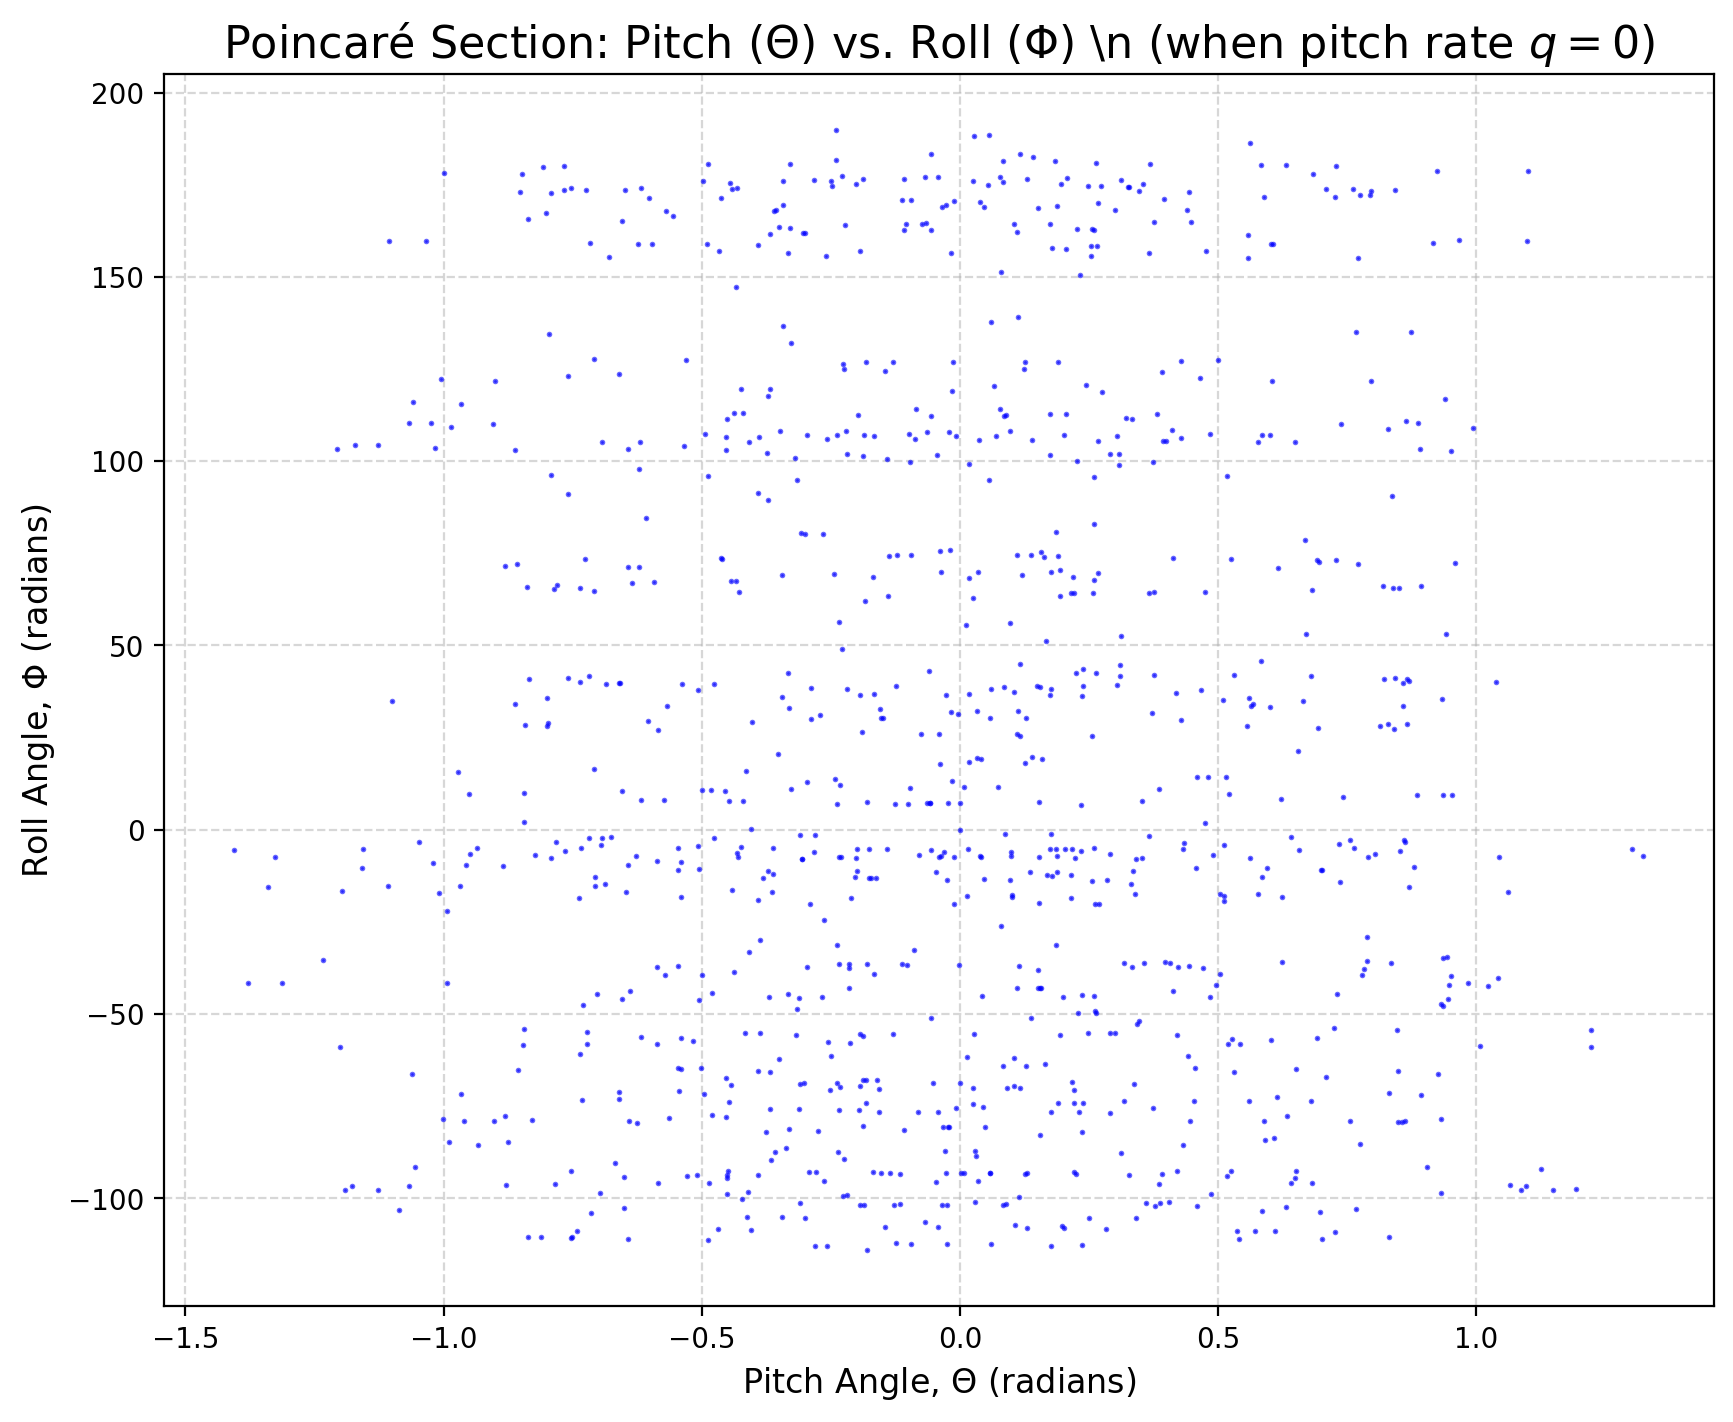


Analysis complete.


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bars

# --- 1. Define Quadcopter Model ---

def quadcopter_model(t, state, params, input_func):
    """
    Full 12-state nonlinear quadcopter model.

    State vector:
    x[0] = x (position)
    x[1] = y
    x[2] = z
    x[3] = phi (roll)
    x[4] = theta (pitch)
    x[5] = psi (yaw)
    x[6] = u (body-frame x-velocity)
    x[7] = v (body-frame y-velocity)
    x[8] = w (body-frame z-velocity)
    x[9] = p (body-frame roll rate)
    x[10] = q (body-frame pitch rate)
    x[11] = r (body-frame yaw rate)
    """

    # Unpack parameters
    m, g, L, Ixx, Iyy, Izz = params['m'], params['g'], params['L'], params['Ixx'], params['Iyy'], params['Izz']

    # Unpack state
    x, y, z, phi, theta, psi, u, v, w, p, q, r = state

    # Get control inputs from the time-varying function
    T, tau_phi, tau_theta, tau_psi = input_func(t) # Total Thrust, Roll Torque, Pitch Torque, Yaw Torque

    # --- Kinematics (Rotation and Translation) ---

    # Pre-calculate trig functions for efficiency
    c_phi = np.cos(phi)
    s_phi = np.sin(phi)
    c_theta = np.cos(theta)
    s_theta = np.sin(theta)
    c_psi = np.cos(psi)
    s_psi = np.sin(psi)

    # 1. Rotational Kinematics (Body-frame rates to Inertial-frame angle derivatives)
    # d(angles)/dt = W * (body_rates)
    # Handle singularity at theta = +/- 90 deg
    if abs(c_theta) < 1e-6:
        # At singularity, we can't calculate phi_dot and psi_dot uniquely
        # Use a small value to avoid division by zero
        tan_theta_approx = s_theta / (np.sign(c_theta) * 1e-6 + c_theta)
        c_theta_approx = np.sign(c_theta) * 1e-6 + c_theta

        phi_dot   = p + q * s_phi * tan_theta_approx + r * c_phi * tan_theta_approx
        psi_dot   = q * s_phi / c_theta_approx + r * c_phi / c_theta_approx
    else:
        phi_dot   = p + q * s_phi * np.tan(theta) + r * c_phi * np.tan(theta)
        psi_dot   = q * s_phi / c_theta + r * c_phi / c_theta

    theta_dot = q * c_phi - r * s_phi


    # 2. Translational Kinematics (Body-frame velocity to Inertial-frame position derivatives)
    # d(pos)/dt = R * (body_vel)
    R = np.array([
        [c_psi*c_theta, c_psi*s_theta*s_phi - s_psi*c_phi, c_psi*s_theta*c_phi + s_psi*s_phi],
        [s_psi*c_theta, s_psi*s_theta*s_phi + c_psi*c_phi, s_psi*s_theta*c_phi - c_psi*s_phi],
        [-s_theta,      c_theta*s_phi,                     c_theta*c_phi]
    ])

    pos_dot = R @ np.array([u, v, w])
    x_dot = pos_dot[0]
    y_dot = pos_dot[1]
    z_dot = pos_dot[2]

    # --- Dynamics (Newton-Euler Equations) ---

    # 3. Translational Dynamics (Newton's 2nd Law in body frame)
    # m * (v_dot + omega x v) = Forces
    u_dot = r * v - q * w - g * s_theta
    v_dot = p * w - r * u + g * c_theta * s_phi
    w_dot = q * u - p * v + g * c_theta * c_phi - T / m

    # 4. Rotational Dynamics (Euler's Equations)
    # I * omega_dot + omega x (I * omega) = Torques
    p_dot = (tau_phi + (Iyy - Izz) * q * r) / Ixx
    q_dot = (tau_theta + (Izz - Ixx) * r * p) / Iyy
    r_dot = (tau_psi + (Ixx - Iyy) * p * q) / Izz

    # Pack the state derivative vector
    state_derivative = np.array([
        x_dot, y_dot, z_dot,
        phi_dot, theta_dot, psi_dot,
        u_dot, v_dot, w_dot,
        p_dot, q_dot, r_dot
    ])

    return state_derivative

def calculate_lle(model_func, initial_state, params, input_func, t_total, t_step):
    """
    Calculates the Largest Lyapunov Exponent (LLE) for the given system.
    Uses the algorithm by Wolf et al. (1985).
    """
    print(f"Calculating LLE for t={t_total}s, step={t_step}s...")

    # --- Initialization ---
    state_fiducial = np.copy(initial_state)

    # Create a shadow state, perturbed by a tiny amount
    perturbation_vector = np.zeros_like(initial_state)
    perturbation_vector[3] = 1e-8  # Perturb the roll angle
    state_shadow = state_fiducial + perturbation_vector

    initial_separation = np.linalg.norm(perturbation_vector)

    lyapunov_exponents = []

    num_steps = int(t_total / t_step)
    t_current = 0.0

    # We use solve_ivp for each step
    t_span = [0, t_step]

    # We must pass the *original* base input func for offsetting
    base_input_func = input_func

    # Use tqdm for the progress bar
    for i in tqdm(range(num_steps), desc="LLE Calculation"):

        # --- Create offset input function for this time step ---
        # This wrapper ensures that input_func(t) in the model
        # actually receives input_func(t + t_current)
        def create_offset_input(base_func, t_offset):
            return lambda t: base_func(t + t_offset)

        input_func_offset = create_offset_input(base_input_func, t_current)

        # 1. Integrate both trajectories using the correctly offset input func
        sol_fiducial = solve_ivp(
            model_func, t_span, state_fiducial,
            method='RK23', args=(params, input_func_offset), t_eval=[t_step]
        )
        sol_shadow = solve_ivp(
            model_func, t_span, state_shadow,
            method='RK23', args=(params, input_func_offset), t_eval=[t_step]
        )

        if not sol_fiducial.success or not sol_shadow.success:
            print(f"Integrator failed at step {i}. Stopping.")
            break

        state_fiducial = sol_fiducial.y[:, -1]
        state_shadow = sol_shadow.y[:, -1]

        # 2. Measure divergence
        separation_vector = state_shadow - state_fiducial
        current_separation = np.linalg.norm(separation_vector)

        # 3. Calculate local Lyapunov exponent
        # Avoid log(0) if separation becomes zero
        if current_separation > 0:
            local_exponent = (1.0 / t_step) * np.log(current_separation / initial_separation)
            lyapunov_exponents.append(local_exponent)

        # 4. Renormalize: Reset the shadow state
        # Place it back near the fiducial state, but
        # along the divergence vector
        state_shadow = state_fiducial + (separation_vector / current_separation) * initial_separation

        # Update time for the *next* loop's input function
        t_current += t_step

    # Discard the first 10% of exponents (transient phase)
    transient_steps = int(num_steps * 0.1)
    if len(lyapunov_exponents) > transient_steps:
        stable_exponents = lyapunov_exponents[transient_steps:]
        lle = np.mean(stable_exponents)
    elif len(lyapunov_exponents) > 0:
         lle = np.mean(lyapunov_exponents)
    else:
        lle = 0.0 # No valid exponents calculated

    return lle

def generate_poincare_section(model_func, initial_state, params, input_func, t_total):
    """
    Generates data for a Poincaré section *with a progress bar*.

    *** NEW ***
    We track every time the PITCH RATE `q` is zero (state[10] == 0).
    This is a "strobe light" for every time it hits a pitch peak/valley.
    """
    print(f"Generating Poincaré section for t={t_total}s...")

    # --- NEW EVENT FUNCTION ---
    # Define the event function for solve_ivp
    def pitch_rate_crossing(t, state, params, input_func):
        # We want to find roots of state[10] (which is pitch rate, q)
        return state[10]

    # Make the event trigger on *any* crossing (positive or negative)
    pitch_rate_crossing.direction = 0
    pitch_rate_crossing.terminal = False # Don't stop the simulation
    # --- END NEW EVENT FUNCTION ---


    # --- New logic for tqdm ---
    # We will simulate in small chunks to show progress
    t_step = 1.0 # Simulate 1 second at a time
    num_steps = int(t_total / t_step)

    all_event_data = [] # This will be a list of 2D arrays (N_events, 12)
    current_state = initial_state
    t_current = 0.0

    for _ in tqdm(range(num_steps), desc="Poincaré Generation"):
        t_span = [t_current, t_current + t_step]

        sol = solve_ivp(
            model_func, t_span, current_state,
            method='RK23', args=(params, input_func),
            events=pitch_rate_crossing, # <-- USE NEW EVENT
            dense_output=True, # Need dense output to get state at event times
            rtol=1e-6, atol=1e-9
        )

        if not sol.success:
            print("Poincaré simulation chunk failed. Stopping.")
            break

        # Store the states from any events that occurred in this chunk
        if sol.y_events[0] is not None and len(sol.y_events[0]) > 0:

            # sol.y_events[0] has shape (n_events, 12)
            event_data = sol.y_events[0]

            # print(f"  [Debug] Found events. Shape: {event_data.shape}")

            all_event_data.append(event_data)

        # Update for the next loop
        current_state = sol.y[:, -1]
        t_current += t_step

    # --- End of new logic ---

    if not all_event_data:
        # --- NEW PRINT MESSAGE ---
        print("No pitch_rate=0 crossings were found. This is unlikely, but try a longer simulation.")
        return None, None

    # --- This is the correct vstack logic ---
    try:
        # np.vstack to stack (2, 12), (3, 12), etc. vertically
        event_states = np.vstack(all_event_data)
        # Final shape is (TotalEvents, 12)

    except ValueError as e:
        print(f"Error during np.vstack: {e}")
        print("This means arrays had mismatched dimensions. Dumping shapes:")
        for arr in all_event_data:
            print(arr.shape)
        return None, None

    # --- This block should now work ---
    try:
        # --- NEW PLOT VARIABLES ---
        # We want to plot Pitch Angle (theta, index 4) vs. Roll Angle (phi, index 3)
        plot_x = event_states[:, 4]  # theta
        plot_y = event_states[:, 3]  # phi
        # --- END NEW PLOT VARIABLES ---

        return plot_x, plot_y

    except IndexError as e:
        print("\n--- !! INDEXERROR CAUGHT !! ---")
        print(f"Error: {e}")
        print(f"This means the final 'event_states' array has the wrong shape.")
        print(f"Debug: Final 'event_states' shape: {event_states.shape}")
        print("The number of columns should be 12.")
        print("--- END DEBUG ---")
        return None, None

# --- Main execution ---
if __name__ == "__main__":

    # --- 1. Define Model Parameters ---
    # Standard parameters with gravity
    params = {
        'm': 1.0,      # mass (kg)
        'g': 9.81,     # gravity (m/s^2)
        'L': 0.25,     # arm length (m)
        'Ixx': 0.01,   # mass moment of inertia (kg*m^2)
        'Iyy': 0.01,   # mass moment of inertia (kg*m^2)
        'Izz': 0.02    # mass moment of inertia (kg*m^2)
    }

    # Parameters for a true stable baseline (no gravity)
    params_freefall = params.copy()
    params_freefall['g'] = 0.0

    # --- 2. Define Control Input Functions ---

    def inputs_freefall(t):
        """No thrust, no torque. Just gravity."""
        return [0, 0, 0, 0]

    def inputs_chaotic(t):
        """
        Chaotic Inputs: Apply thrust and competing torques on all axes
        at different frequencies to induce chaotic tumbling.
        """
        # --- BUG FIX ---
        # Apply thrust to *counteract* gravity, not 80% of it
        T = params['m'] * params['g']

        # Apply torques at different, non-harmonic frequencies
        # This "quasi-periodic" forcing is a classic way to create chaos.
        tau_phi   = 0.4 * np.sin(2.0 * t)
        tau_theta = 0.3 * np.sin(3.3 * t)
        tau_psi   = 0.5 * np.sin(1.2 * t)

        return [T, tau_phi, tau_theta, tau_psi]

    # --- 3. Run LLE Calculations ---

    # Initial state (at rest, at origin)
    initial_state_at_rest = np.zeros(12)

    # Initial state (slight perturbation to start things)
    initial_state_perturbed = np.zeros(12)
    initial_state_perturbed[3] = 0.01 # Start with a small roll


    # --- SCENARIO 1: NO GRAVITY FREEFALL (True Baseline) ---
    print("\n--- SCENARIO 1: NO GRAVITY FREEFALL (True Baseline) ---")
    lle_freefall = calculate_lle(
        quadcopter_model,
        initial_state_at_rest,
        params_freefall,  # <-- Use g=0 params
        inputs_freefall,
        t_total=20.0,
        t_step=1.0
    )
    print(f"Largest Lyapunov Exponent (LLE): {lle_freefall:+.6f}")
    if lle_freefall > 1e-4:
        print("Result: System is UNSTABLE or CHAOTIC. (Baseline FAILED!)")
    else:
        print("Result: System is STABLE/PERIODIC (as expected). LLE is zero or negative.")

    # --- SCENARIO 2: AGGRESSIVE MANEUVER (Chaos Hunt) ---
    # Only run if baseline passed
    if lle_freefall <= 1e-4:
        print("\n--- SCENARIO 2: AGGRESSIVE MANEUVER (with Gravity) ---")
        lle_chaotic = calculate_lle(
            quadcopter_model,
            initial_state_perturbed,  # Use perturbed state to kick-start dynamics
            params, # <-- Use normal params with gravity
            inputs_chaotic,
            t_total=30.0,
            t_step=1.0
        )
        print(f"Largest Lyapunov Exponent (LLE): {lle_chaotic:+.6f}")

        if lle_chaotic > 1e-4:
            print("Result: System is CHAOTIC. LLE is positive.")

            # --- 4. Generate Poincaré Plot (if chaotic) ---
            plot_x, plot_y = generate_poincare_section(
                quadcopter_model,
                initial_state_perturbed,
                params, # <-- Use normal params with gravity
                inputs_chaotic,
                t_total=150.0  # Simulate for 150 seconds
            )

            if plot_x is not None:
                print("Plotting results...")
                # --- NEW PLOT ---
                plt.figure(figsize=(10, 8))
                plt.plot(plot_x, plot_y, 'b.', markersize=2, alpha=0.6)
                plt.title(r'Poincaré Section: Pitch ($\Theta$) vs. Roll ($\Phi$) \n (when pitch rate $q=0$)', fontsize=16)
                plt.xlabel(r'Pitch Angle, $\Theta$ (radians)', fontsize=12)
                plt.ylabel(r'Roll Angle, $\Phi$ (radians)', fontsize=12)
                plt.grid(True, linestyle='--', alpha=0.5)
                plt.show()
                # --- END NEW PLOT ---

        else:
            print("Result: System is NOT chaotic. Try different input parameters.")
    else:
        print("\n--- SCENARIO 2 SKIPPED ---")
        print("Baseline test failed. Please debug Scenario 1 before proceeding.")

    print("\nAnalysis complete.")



WRAPPED POINCARE


--- SCENARIO 1: NO GRAVITY FREEFALL (True Baseline) ---
Calculating LLE for t=20.0s, step=1.0s...


LLE Calculation: 100%|██████████| 20/20 [00:00<00:00, 223.67it/s]


Largest Lyapunov Exponent (LLE): +0.000000
Result: System is STABLE/PERIODIC (as expected). LLE is zero or negative.

--- SCENARIO 2: AGGRESSIVE MANEUVER (with Gravity) ---
Calculating LLE for t=30.0s, step=1.0s...


LLE Calculation: 100%|██████████| 30/30 [00:02<00:00, 12.32it/s]


Largest Lyapunov Exponent (LLE): +1.800475
Result: System is CHAOTIC. LLE is positive.
Generating Poincaré section for t=150.0s...


Poincaré Generation: 100%|██████████| 150/150 [01:55<00:00,  1.30it/s]


Plotting results...


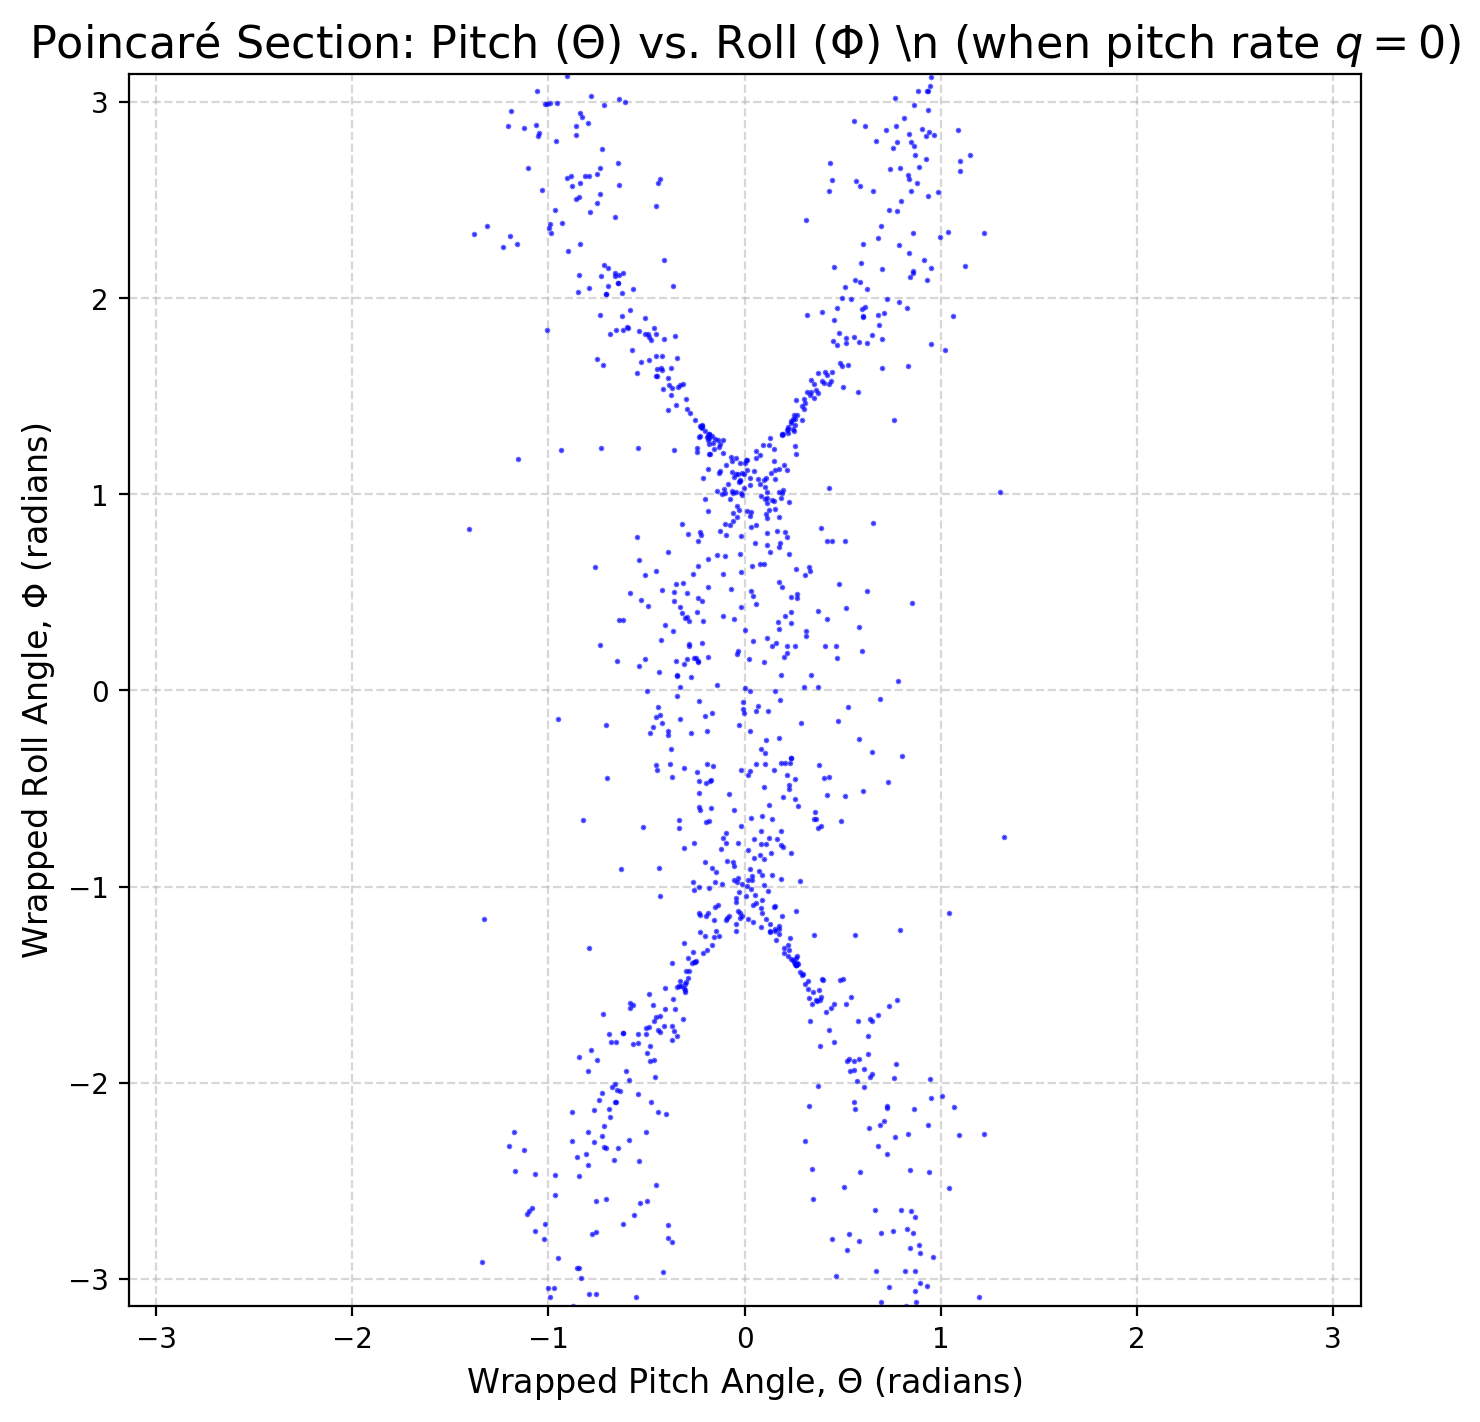


Analysis complete.


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bars

# --- 1. Define Quadcopter Model ---

def quadcopter_model(t, state, params, input_func):
    """
    Full 12-state nonlinear quadcopter model.

    State vector:
    x[0] = x (position)
    x[1] = y
    x[2] = z
    x[3] = phi (roll)
    x[4] = theta (pitch)
    x[5] = psi (yaw)
    x[6] = u (body-frame x-velocity)
    x[7] = v (body-frame y-velocity)
    x[8] = w (body-frame z-velocity)
    x[9] = p (body-frame roll rate)
    x[10] = q (body-frame pitch rate)
    x[11] = r (body-frame yaw rate)
    """

    # Unpack parameters
    m, g, L, Ixx, Iyy, Izz = params['m'], params['g'], params['L'], params['Ixx'], params['Iyy'], params['Izz']

    # Unpack state
    x, y, z, phi, theta, psi, u, v, w, p, q, r = state

    # Get control inputs from the time-varying function
    T, tau_phi, tau_theta, tau_psi = input_func(t) # Total Thrust, Roll Torque, Pitch Torque, Yaw Torque

    # --- Kinematics (Rotation and Translation) ---

    # Pre-calculate trig functions for efficiency
    c_phi = np.cos(phi)
    s_phi = np.sin(phi)
    c_theta = np.cos(theta)
    s_theta = np.sin(theta)
    c_psi = np.cos(psi)
    s_psi = np.sin(psi)

    # 1. Rotational Kinematics (Body-frame rates to Inertial-frame angle derivatives)
    # d(angles)/dt = W * (body_rates)
    # Handle singularity at theta = +/- 90 deg
    if abs(c_theta) < 1e-6:
        # At singularity, we can't calculate phi_dot and psi_dot uniquely
        # Use a small value to avoid division by zero
        tan_theta_approx = s_theta / (np.sign(c_theta) * 1e-6 + c_theta)
        c_theta_approx = np.sign(c_theta) * 1e-6 + c_theta

        phi_dot   = p + q * s_phi * tan_theta_approx + r * c_phi * tan_theta_approx
        psi_dot   = q * s_phi / c_theta_approx + r * c_phi / c_theta_approx
    else:
        phi_dot   = p + q * s_phi * np.tan(theta) + r * c_phi * np.tan(theta)
        psi_dot   = q * s_phi / c_theta + r * c_phi / c_theta

    theta_dot = q * c_phi - r * s_phi


    # 2. Translational Kinematics (Body-frame velocity to Inertial-frame position derivatives)
    # d(pos)/dt = R * (body_vel)
    R = np.array([
        [c_psi*c_theta, c_psi*s_theta*s_phi - s_psi*c_phi, c_psi*s_theta*c_phi + s_psi*s_phi],
        [s_psi*c_theta, s_psi*s_theta*s_phi + c_psi*c_phi, s_psi*s_theta*c_phi - c_psi*s_phi],
        [-s_theta,      c_theta*s_phi,                     c_theta*c_phi]
    ])

    pos_dot = R @ np.array([u, v, w])
    x_dot = pos_dot[0]
    y_dot = pos_dot[1]
    z_dot = pos_dot[2]

    # --- Dynamics (Newton-Euler Equations) ---

    # 3. Translational Dynamics (Newton's 2nd Law in body frame)
    # m * (v_dot + omega x v) = Forces
    u_dot = r * v - q * w - g * s_theta
    v_dot = p * w - r * u + g * c_theta * s_phi
    w_dot = q * u - p * v + g * c_theta * c_phi - T / m

    # 4. Rotational Dynamics (Euler's Equations)
    # I * omega_dot + omega x (I * omega) = Torques
    p_dot = (tau_phi + (Iyy - Izz) * q * r) / Ixx
    q_dot = (tau_theta + (Izz - Ixx) * r * p) / Iyy
    r_dot = (tau_psi + (Ixx - Iyy) * p * q) / Izz

    # Pack the state derivative vector
    state_derivative = np.array([
        x_dot, y_dot, z_dot,
        phi_dot, theta_dot, psi_dot,
        u_dot, v_dot, w_dot,
        p_dot, q_dot, r_dot
    ])

    return state_derivative

def calculate_lle(model_func, initial_state, params, input_func, t_total, t_step):
    """
    Calculates the Largest Lyapunov Exponent (LLE) for the given system.
    Uses the algorithm by Wolf et al. (1985).
    """
    print(f"Calculating LLE for t={t_total}s, step={t_step}s...")

    # --- Initialization ---
    state_fiducial = np.copy(initial_state)

    # Create a shadow state, perturbed by a tiny amount
    perturbation_vector = np.zeros_like(initial_state)
    perturbation_vector[3] = 1e-8  # Perturb the roll angle
    state_shadow = state_fiducial + perturbation_vector

    initial_separation = np.linalg.norm(perturbation_vector)

    lyapunov_exponents = []

    num_steps = int(t_total / t_step)
    t_current = 0.0

    # We use solve_ivp for each step
    t_span = [0, t_step]

    # We must pass the *original* base input func for offsetting
    base_input_func = input_func

    # Use tqdm for the progress bar
    for i in tqdm(range(num_steps), desc="LLE Calculation"):

        # --- Create offset input function for this time step ---
        # This wrapper ensures that input_func(t) in the model
        # actually receives input_func(t + t_current)
        def create_offset_input(base_func, t_offset):
            return lambda t: base_func(t + t_offset)

        input_func_offset = create_offset_input(base_input_func, t_current)

        # 1. Integrate both trajectories using the correctly offset input func
        sol_fiducial = solve_ivp(
            model_func, t_span, state_fiducial,
            method='RK23', args=(params, input_func_offset), t_eval=[t_step]
        )
        sol_shadow = solve_ivp(
            model_func, t_span, state_shadow,
            method='RK23', args=(params, input_func_offset), t_eval=[t_step]
        )

        if not sol_fiducial.success or not sol_shadow.success:
            print(f"Integrator failed at step {i}. Stopping.")
            break

        state_fiducial = sol_fiducial.y[:, -1]
        state_shadow = sol_shadow.y[:, -1]

        # 2. Measure divergence
        separation_vector = state_shadow - state_fiducial
        current_separation = np.linalg.norm(separation_vector)

        # 3. Calculate local Lyapunov exponent
        # Avoid log(0) if separation becomes zero
        if current_separation > 0:
            local_exponent = (1.0 / t_step) * np.log(current_separation / initial_separation)
            lyapunov_exponents.append(local_exponent)

        # 4. Renormalize: Reset the shadow state
        # Place it back near the fiducial state, but
        # along the divergence vector
        state_shadow = state_fiducial + (separation_vector / current_separation) * initial_separation

        # Update time for the *next* loop's input function
        t_current += t_step

    # Discard the first 10% of exponents (transient phase)
    transient_steps = int(num_steps * 0.1)
    if len(lyapunov_exponents) > transient_steps:
        stable_exponents = lyapunov_exponents[transient_steps:]
        lle = np.mean(stable_exponents)
    elif len(lyapunov_exponents) > 0:
         lle = np.mean(lyapunov_exponents)
    else:
        lle = 0.0 # No valid exponents calculated

    return lle

def generate_poincare_section(model_func, initial_state, params, input_func, t_total):
    """
    Generates data for a Poincaré section *with a progress bar*.
    We track every time the PITCH RATE `q` is zero (state[10] == 0).
    """
    print(f"Generating Poincaré section for t={t_total}s...")

    # Define the event function for solve_ivp
    def pitch_rate_crossing(t, state, params, input_func):
        # We want to find roots of state[10] (which is pitch rate, q)
        return state[10]

    # Make the event trigger on *any* crossing (positive or negative)
    pitch_rate_crossing.direction = 0
    pitch_rate_crossing.terminal = False # Don't stop the simulation

    # We will simulate in small chunks to show progress
    t_step = 1.0 # Simulate 1 second at a time
    num_steps = int(t_total / t_step)

    all_event_data = [] # This will be a list of 2D arrays (N_events, 12)
    current_state = initial_state
    t_current = 0.0

    for _ in tqdm(range(num_steps), desc="Poincaré Generation"):
        t_span = [t_current, t_current + t_step]

        sol = solve_ivp(
            model_func, t_span, current_state,
            method='RK23', args=(params, input_func),
            events=pitch_rate_crossing, # <-- USE NEW EVENT
            dense_output=True, # Need dense output to get state at event times
            rtol=1e-6, atol=1e-9
        )

        if not sol.success:
            print("Poincaré simulation chunk failed. Stopping.")
            break

        # Store the states from any events that occurred in this chunk
        if sol.y_events[0] is not None and len(sol.y_events[0]) > 0:

            # sol.y_events[0] has shape (n_events, 12)
            event_data = sol.y_events[0]
            all_event_data.append(event_data)

        # Update for the next loop
        current_state = sol.y[:, -1]
        t_current += t_step

    if not all_event_data:
        print("No pitch_rate=0 crossings were found. This is unlikely, but try a longer simulation.")
        return None, None

    # Use np.vstack to stack (2, 12), (3, 12), etc. vertically
    try:
        event_states = np.vstack(all_event_data)
        # Final shape is (TotalEvents, 12)
    except ValueError as e:
        print(f"Error during np.vstack: {e}")
        return None, None

    # This block should now work
    try:
        # We want to plot Pitch Angle (theta, index 4) vs. Roll Angle (phi, index 3)
        plot_x_raw = event_states[:, 4]  # theta
        plot_y_raw = event_states[:, 3]  # phi

        return plot_x_raw, plot_y_raw

    except IndexError as e:
        print("\n--- !! INDEXERROR CAUGHT !! ---")
        print(f"Error: {e}")
        print(f"Debug: Final 'event_states' shape: {event_states.shape}")
        return None, None

# --- Main execution ---
if __name__ == "__main__":

    # --- 1. Define Model Parameters ---
    # Standard parameters with gravity
    params = {
        'm': 1.0,      # mass (kg)
        'g': 9.81,     # gravity (m/s^2)
        'L': 0.25,     # arm length (m)
        'Ixx': 0.01,   # mass moment of inertia (kg*m^2)
        'Iyy': 0.01,   # mass moment of inertia (kg*m^2)
        'Izz': 0.02    # mass moment of inertia (kg*m^2)
    }

    # Parameters for a true stable baseline (no gravity)
    params_freefall = params.copy()
    params_freefall['g'] = 0.0

    # --- 2. Define Control Input Functions ---

    def inputs_freefall(t):
        """No thrust, no torque. Just gravity."""
        return [0, 0, 0, 0]

    def inputs_chaotic(t):
        """
        Chaotic Inputs: Apply thrust and competing torques on all axes
        at different frequencies to induce chaotic tumbling.
        """
        # Apply thrust to *counteract* gravity
        T = params['m'] * params['g']

        # Apply torques at different, non-harmonic frequencies
        tau_phi   = 0.4 * np.sin(2.0 * t)
        tau_theta = 0.3 * np.sin(3.3 * t)
        tau_psi   = 0.5 * np.sin(1.2 * t)

        return [T, tau_phi, tau_theta, tau_psi]

    # --- 3. Run LLE Calculations ---

    # Initial state (at rest, at origin)
    initial_state_at_rest = np.zeros(12)

    # Initial state (slight perturbation to start things)
    initial_state_perturbed = np.zeros(12)
    initial_state_perturbed[3] = 0.01 # Start with a small roll


    # --- SCENARIO 1: NO GRAVITY FREEFALL (True Baseline) ---
    print("\n--- SCENARIO 1: NO GRAVITY FREEFALL (True Baseline) ---")
    lle_freefall = calculate_lle(
        quadcopter_model,
        initial_state_at_rest,
        params_freefall,  # <-- Use g=0 params
        inputs_freefall,
        t_total=20.0,
        t_step=1.0
    )
    print(f"Largest Lyapunov Exponent (LLE): {lle_freefall:+.6f}")
    if lle_freefall > 1e-4:
        print("Result: System is UNSTABLE or CHAOTIC. (Baseline FAILED!)")
    else:
        print("Result: System is STABLE/PERIODIC (as expected). LLE is zero or negative.")

    # --- SCENARIO 2: AGGRESSIVE MANEUVER (Chaos Hunt) ---
    # Only run if baseline passed
    if lle_freefall <= 1e-4:
        print("\n--- SCENARIO 2: AGGRESSIVE MANEUVER (with Gravity) ---")
        lle_chaotic = calculate_lle(
            quadcopter_model,
            initial_state_perturbed,  # Use perturbed state to kick-start dynamics
            params, # <-- Use normal params with gravity
            inputs_chaotic,
            t_total=30.0,
            t_step=1.0
        )
        print(f"Largest Lyapunov Exponent (LLE): {lle_chaotic:+.6f}")

        if lle_chaotic > 1e-4:
            print("Result: System is CHAOTIC. LLE is positive.")

            # --- 4. Generate Poincaré Plot (if chaotic) ---
            plot_x_raw, plot_y_raw = generate_poincare_section(
                quadcopter_model,
                initial_state_perturbed,
                params, # <-- Use normal params with gravity
                inputs_chaotic,
                t_total=150.0  # Simulate for 150 seconds
            )

            if plot_x_raw is not None:
                print("Plotting results...")

                # --- NEW PLOTTING LOGIC ---
                # "Wrap" the angles to the range -pi to +pi
                # This makes the structure of the attractor much clearer
                plot_x_wrapped = np.arctan2(np.sin(plot_x_raw), np.cos(plot_x_raw))
                plot_y_wrapped = np.arctan2(np.sin(plot_y_raw), np.cos(plot_y_raw))

                plt.figure(figsize=(10, 8))
                plt.plot(plot_x_wrapped, plot_y_wrapped, 'b.', markersize=2, alpha=0.6)
                plt.title(r'Poincaré Section: Pitch ($\Theta$) vs. Roll ($\Phi$) \n (when pitch rate $q=0$)', fontsize=16)
                plt.xlabel(r'Wrapped Pitch Angle, $\Theta$ (radians)', fontsize=12)
                plt.ylabel(r'Wrapped Roll Angle, $\Phi$ (radians)', fontsize=12)
                plt.xlim(-np.pi, np.pi)
                plt.ylim(-np.pi, np.pi)
                plt.grid(True, linestyle='--', alpha=0.5)
                plt.gca().set_aspect('equal', adjustable='box') # Make the plot square
                plt.show()
                # --- END NEW PLOTTING LOGIC ---

        else:
            print("Result: System is NOT chaotic. Try different input parameters.")
    else:
        print("\n--- SCENARIO 2 SKIPPED ---")
        print("Baseline test failed. Please debug Scenario 1 before proceeding.")

    print("\nAnalysis complete.")



ADVANCED


Using device: cuda


Generating dataset: 100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


Epoch 10/200, loss 0.074560
Epoch 20/200, loss 0.045914
Epoch 30/200, loss 0.027348
Epoch 40/200, loss 0.020111
Epoch 50/200, loss 0.019307
Epoch 60/200, loss 0.013447
Epoch 70/200, loss 0.009139
Epoch 80/200, loss 0.010199
Epoch 90/200, loss 0.012000
Epoch 100/200, loss 0.008590
Epoch 110/200, loss 0.008388
Epoch 120/200, loss 0.009605
Epoch 130/200, loss 0.007087
Epoch 140/200, loss 0.006864
Epoch 150/200, loss 0.007050
Epoch 160/200, loss 0.006020
Epoch 170/200, loss 0.002027
Epoch 180/200, loss 0.005484
Epoch 190/200, loss 0.010889
Epoch 200/200, loss 0.005652

--- Running Closed-Loop Simulations ---


Closed-loop koopman: 100%|██████████| 500/500 [00:03<00:00, 151.71it/s]


[KOOPMAN] RMSE: 12.3030 m | Energy: 3.74e+09 | Effort: 1.87e+05 | Settling: 5.00 s | Overshoot Z: -40.339 m


Closed-loop pid: 100%|██████████| 500/500 [00:00<00:00, 4066.98it/s]


[PID] RMSE: 12.6856 m | Energy: 3.99e+09 | Effort: 1.99e+05 | Settling: 5.00 s | Overshoot Z: -41.334 m


Closed-loop lqr: 100%|██████████| 500/500 [00:00<00:00, 6880.89it/s]


[LQR] RMSE: 12.6856 m | Energy: 3.99e+09 | Effort: 1.99e+05 | Settling: 5.00 s | Overshoot Z: -41.334 m

Plot saved to quadcopter_comparison.png


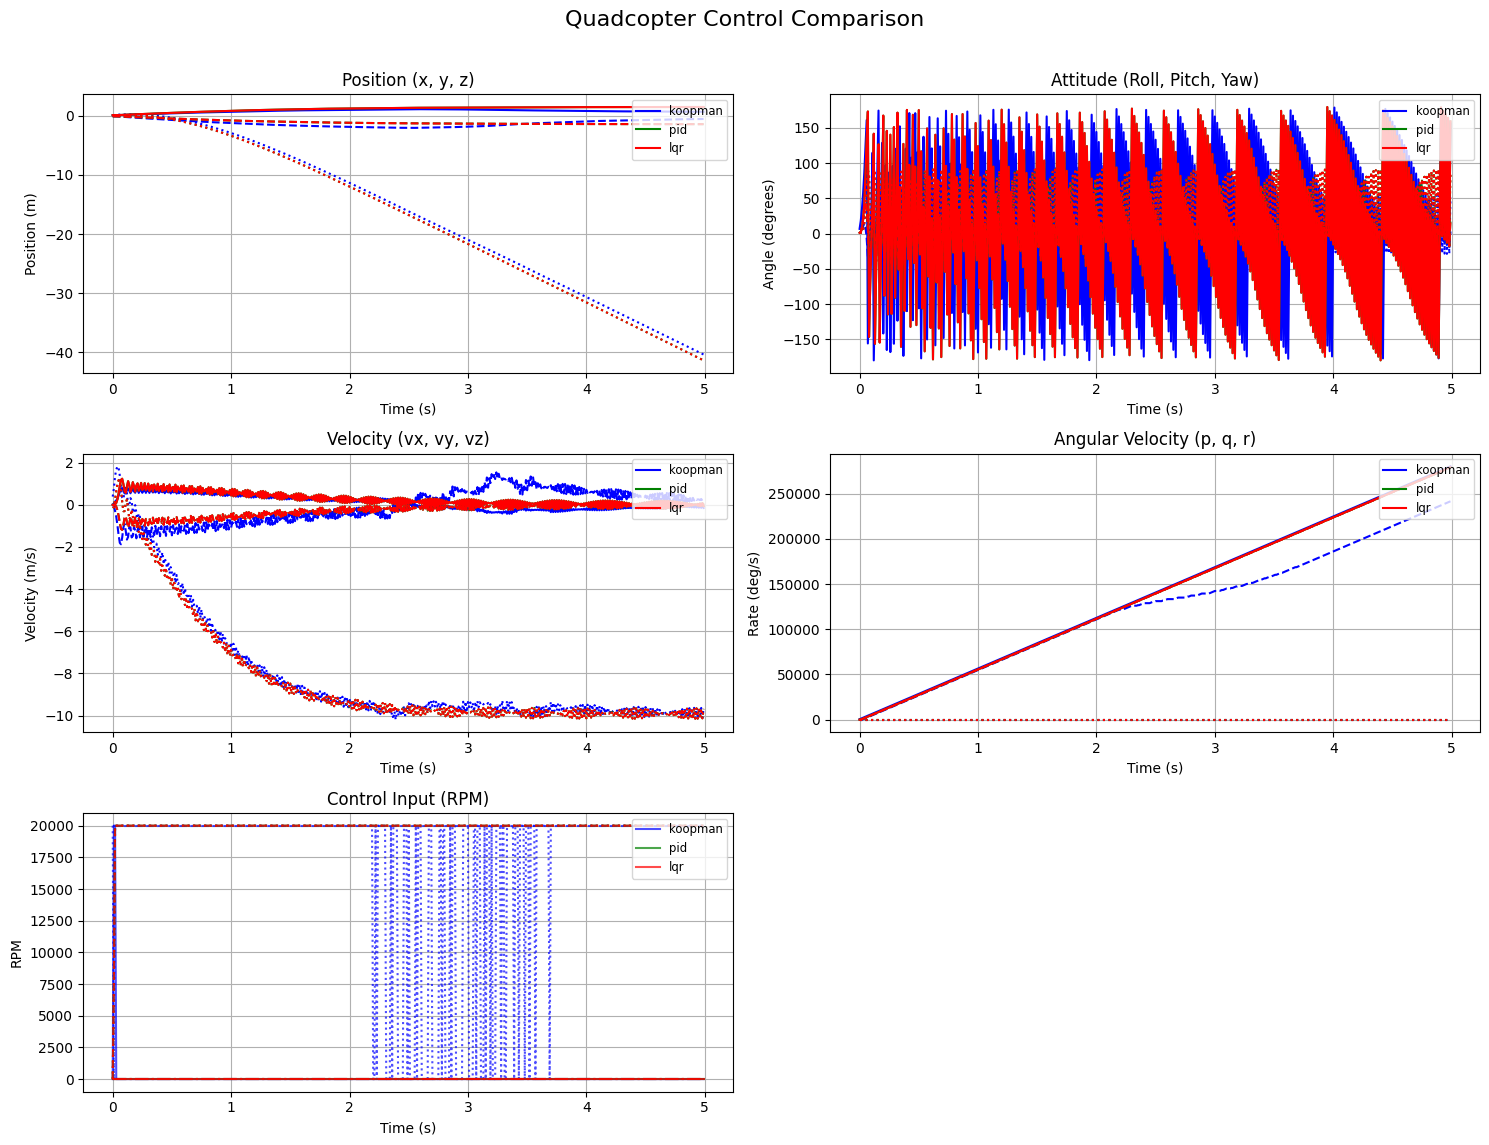

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------------ 6-DoF Quadcopter Simulation ------------------
class QuadSim6DoF:
    def __init__(self, dt=0.01, mass=1.0, arm_length=0.2, k_f=6.11e-8, k_m=1.5e-9, I=np.diag([0.005,0.005,0.009]), max_rpm=20000):
        self.dt = dt
        self.m = mass
        self.L = arm_length
        self.k_f = k_f
        self.k_m = k_m
        self.I = I
        self.invI = np.linalg.inv(I)
        self.max_rpm = max_rpm
        self.reset()

    def reset(self):
        self.pos = np.zeros(3)
        self.vel = np.zeros(3)
        self.q = np.array([1,0,0,0]) # Quaternion
        self.omega = np.zeros(3)
        self.g = np.array([0,0,-9.81])

    def quat_to_rotm(self,q):
        w,x,y,z = q
        R = np.array([
            [1-2*(y**2+z**2), 2*(x*y-w*z), 2*(x*z+w*y)],
            [2*(x*y+w*z), 1-2*(x**2+z**2), 2*(y*z-w*x)],
            [2*(x*z-w*y), 2*(y*z+w*x), 1-2*(x**2+y**2)]
        ])
        return R

    def normalize_quat(self,q):
        norm = np.linalg.norm(q)
        if norm == 0: return np.array([1,0,0,0])
        return q / norm

    def step(self, rpm):
        rpm = np.clip(rpm,0,self.max_rpm)
        f = self.k_f * rpm**2
        tau = np.array([
            self.L*(f[1]-f[3]),
            self.L*(f[2]-f[0]),
            self.k_m*(f[0]-f[1]+f[2]-f[3])
        ])
        R = self.quat_to_rotm(self.q)
        F_thrust = R @ np.array([0,0,np.sum(f)])
        F_drag = -0.1*self.vel*np.linalg.norm(self.vel)
        a = (F_thrust + F_drag)/self.m + self.g
        self.vel += a*self.dt
        self.pos += self.vel*self.dt
        omega_dot = self.invI @ (tau - np.cross(self.omega, self.I @ self.omega))
        self.omega += omega_dot*self.dt
        wx,wy,wz = self.omega
        Omega = np.array([[0,-wx,-wy,-wz],[wx,0,wz,-wy],[wy,-wz,0,wx],[wz,wy,-wx,0]])
        self.q = self.q + 0.5*Omega @ self.q * self.dt
        self.q = self.normalize_quat(self.q)

    def get_state(self):
        return np.hstack([self.pos,self.q,self.vel,self.omega])

# ------------------ Utility ------------------
def quat_to_euler(q):
    w,x,y,z = q
    t0 = 2*(w*x + y*z)
    t1 = 1 - 2*(x*x + y*y)
    roll = np.arctan2(t0,t1)
    t2 = 2*(w*y - z*x)
    t2 = np.clip(t2,-1,1)
    pitch = np.arcsin(t2)
    t3 = 2*(w*z + x*y)
    t4 = 1 - 2*(y*y + z*z)
    yaw = np.arctan2(t3,t4)
    return roll,pitch,yaw

# ------------------ Koopman NN ------------------
class KoopmanNN(nn.Module):
    def __init__(self, x_dim, u_dim, z_dim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(x_dim,128), nn.ReLU(), nn.Linear(128,z_dim))
        self.decoder = nn.Sequential(nn.Linear(z_dim,128), nn.ReLU(), nn.Linear(128,x_dim))
        self.K = nn.Parameter(torch.eye(z_dim))
        self.B = nn.Parameter(torch.randn(z_dim,u_dim)*0.01)
    def forward(self,x,u):
        z = self.encoder(x)
        z_next = z @ self.K.T + u @ self.B.T
        x_rec = self.decoder(z)
        x_next_rec = self.decoder(z_next)
        return z, z_next, x_rec, x_next_rec

# ------------------ Dataset ------------------
def generate_dataset(sim,n_trajs=50,T=5.0):
    data = {'x':[],'u':[],'x_next':[]}
    steps = int(T/sim.dt)
    for _ in tqdm(range(n_trajs),desc="Generating dataset"):
        sim.reset()
        for _ in range(steps):
            x = sim.get_state()
            u_hover = np.sqrt(sim.m*abs(sim.g[2])/4/sim.k_f)
            u = u_hover + (np.random.rand(4)-0.5)*u_hover*0.3
            sim.step(u)
            x_next = sim.get_state()
            data['x'].append(x); data['u'].append(u); data['x_next'].append(x_next)
    return {k:np.array(v) for k,v in data.items()}

# ------------------ Training ------------------
def train_koopmannn(model,data,epochs=50,lr=1e-3,batch_size=128,device='cpu'):
    model.to(device); opt = torch.optim.Adam(model.parameters(),lr=lr)
    X = torch.tensor(data['x'],dtype=torch.float32).to(device)
    U = torch.tensor(data['u'],dtype=torch.float32).to(device)
    Xp = torch.tensor(data['x_next'],dtype=torch.float32).to(device)
    n = X.shape[0]
    for ep in range(epochs):
        perm = torch.randperm(n)
        loss_epoch = 0
        for i in range(0,n,batch_size):
            idx = perm[i:i+batch_size]
            x_b,u_b,xp_b = X[idx],U[idx],Xp[idx]
            z,znext,x_rec,x_next_rec = model(x_b,u_b)
            loss = nn.MSELoss()(x_rec,x_b)+nn.MSELoss()(x_next_rec,xp_b)
            opt.zero_grad(); loss.backward(); opt.step(); loss_epoch += loss.item()*x_b.shape[0]
        loss_epoch/=n
        if (ep+1)%10==0: print(f"Epoch {ep+1}/{epochs}, loss {loss_epoch:.6f}")
    return model

# ------------------ Controllers ------------------
def pid_control(x,x_des,integral_state,sim,dt,u_max=20000.0):
    Kp_z, Ki_z, Kd_z = 300.0,100.0,250.0
    Kp_att, Kd_att = 50.0,20.0
    Kp_yaw = 50.0
    pos,q,vel,omega = x[0:3], x[3:7], x[7:10], x[10:13]
    roll,pitch,yaw = quat_to_euler(q)
    z_err = x_des[2]-pos[2]; integral_state['z']+=z_err*dt; integral_state['z']=np.clip(integral_state['z'],-5,5)
    z_vel_err = 0-vel[2]
    u_thrust = sim.m*abs(sim.g[2]) + Kp_z*z_err + Ki_z*integral_state['z'] + Kd_z*z_vel_err
    roll_err, roll_rate_err = 0-roll,0-omega[0]
    pitch_err, pitch_rate_err = 0-pitch,0-omega[1]
    yaw_rate_err = 0-omega[2]
    u_tx = Kp_att*roll_err + Kd_att*roll_rate_err
    u_ty = Kp_att*pitch_err + Kd_att*pitch_rate_err
    u_tz = Kp_yaw*yaw_rate_err
    f_per_motor = u_thrust/4.0
    f1 = f_per_motor + u_ty/(2*sim.L) + u_tz/(4*sim.k_m)
    f2 = f_per_motor - u_tx/(2*sim.L) - u_tz/(4*sim.k_m)
    f3 = f_per_motor - u_ty/(2*sim.L) + u_tz/(4*sim.k_m)
    f4 = f_per_motor + u_tx/(2*sim.L) - u_tz/(4*sim.k_m)
    f_all = np.clip([f1,f2,f3,f4],0,None)
    u_ctrl = np.clip(np.sqrt(f_all/sim.k_f),0,u_max)
    return u_ctrl, integral_state

def lqr_control(x,x_des,sim,u_max=20000.0):
    # Placeholder, using PID as a stand-in for LQR logic
    # A true LQR would require linearization and solving a Riccati equation.
    return pid_control(x,x_des,{'z':0.0},sim,sim.dt)[0]

def koopman_mpc_control(model,x0,x_ref,sim,horizon=10,u_max=20000.0,device='cpu'):
    model.eval(); u_hover = np.sqrt(sim.m*abs(sim.g[2])/4/sim.k_f); u_ref=np.array([u_hover]*4)
    x_tensor = torch.tensor(x0,dtype=torch.float32).unsqueeze(0).to(device)
    z = model.encoder(x_tensor)
    z_ref = model.encoder(torch.tensor(x_ref,dtype=torch.float32).unsqueeze(0).to(device))
    Kmat = model.K.detach().cpu().numpy(); Bmat = model.B.detach().cpu().numpy()
    z_err = z - z_ref; u_cmd = u_ref.copy()
    for _ in range(horizon):
        u_error = -np.linalg.pinv(Bmat) @ Kmat @ z_err.detach().cpu().numpy().T
        u_total = np.clip(u_ref + u_error.flatten(),0,u_max)
        # --- FIX IS ON THIS LINE ---
        # The new tensor created from numpy arrays (u_total, u_ref) must be moved to the device
        z_err = z_err @ model.K.T + torch.tensor((u_total-u_ref).reshape(1,4),dtype=torch.float32).to(device) @ model.B.T
        u_cmd = u_total
    model.train()
    return u_cmd

# ------------------ Closed-loop w/ Online Training ------------------
def run_closed_loop_online(sim,model=None,traj_len=5.0,ctrl_type='koopman',device='cpu'):
    steps=int(traj_len/sim.dt); x_hist, u_hist = [],[]; integral_state={'z':0.0}
    sim.reset(); sim.pos=np.array([0.1,-0.1,0.1]); sim.q=np.array([0.999,0.01,0.01,0.01]); sim.q=sim.normalize_quat(sim.q)
    x_hist.append(sim.get_state()); x_des = np.zeros(13); x_des[3]=1.0 # Target: pos=(0,0,0), q=(1,0,0,0)
    opt = torch.optim.Adam(model.parameters(),lr=1e-4) if model is not None else None
    for k in tqdm(range(steps),desc=f"Closed-loop {ctrl_type}"):
        x = x_hist[-1]
        if ctrl_type=='koopman': u_ctrl = koopman_mpc_control(model,x,x_des,sim,device=device)
        elif ctrl_type=='pid': u_ctrl, integral_state = pid_control(x,x_des,integral_state,sim,sim.dt)
        elif ctrl_type=='lqr': u_ctrl = lqr_control(x,x_des,sim)
        else: u_ctrl = np.zeros(4)
        sim.step(u_ctrl); x_hist.append(sim.get_state()); u_hist.append(u_ctrl)
        # Online training every 10 steps
        if model is not None and (k%10==0 and k > 0): # Check k > 0 to ensure we have a previous state
            x_tensor = torch.tensor([x_hist[-2]],dtype=torch.float32).to(device)
            u_tensor = torch.tensor([u_hist[-1]],dtype=torch.float32).to(device) # Use the most recent control
            x_next_tensor = torch.tensor([x_hist[-1]],dtype=torch.float32).to(device)

            model.train() # Ensure model is in training mode for dropout, batchnorm etc. if they exist
            z, z_next, x_rec, x_next_rec = model(x_tensor,u_tensor)

            # We only care about predicting the next state from the previous state and action
            z_p_encoded = model.encoder(x_next_tensor)

            # Loss: 1. Reconstruction of current state, 2. Prediction of next state in latent space
            loss_rec = nn.MSELoss()(x_rec, x_tensor)
            loss_pred = nn.MSELoss()(z_next, z_p_encoded) # Predict next latent state

            # A more common loss is to reconstruct the *next* state
            loss_pred_rec = nn.MSELoss()(x_next_rec, x_next_tensor)

            loss = loss_rec + loss_pred_rec # Combine losses

            opt.zero_grad(); loss.backward(); opt.step()
            model.eval() # Set model back to eval mode for MPC controller

    return np.array(x_hist[1:]), np.array(u_hist)

# ------------------ Metrics ------------------
def compute_metrics(x_hist,u_hist,dt,traj_len):
    pos_error = x_hist[:,:3]; rmse = np.sqrt(np.mean(pos_error**2))
    energy = np.sum(np.sum(u_hist**2,axis=1))*dt
    effort = np.sum(np.sum(np.abs(u_hist),axis=1))*dt
    settle_band=0.05;

    # Check if simulation ever settled
    settled_mask = np.all(np.abs(x_hist[:,:3]) < settle_band, axis=1) # Settled if x,y,z are all in band
    settling_time = traj_len # Default if never settled

    if np.any(settled_mask):
        first_settle_idx = np.where(settled_mask)[0][0]
        # Check if it *stayed* settled
        if np.all(settled_mask[first_settle_idx:]):
            settling_time = first_settle_idx * dt

    overshoot_z = min(np.min(x_hist[:,2]),0.0) # Overshoot is negative (going below 0)
    return rmse,energy,effort,overshoot_z,settling_time

# ------------------ Plotting ------------------
def plot_results(hist_dict, dt):
    fig, axs = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle("Quadcopter Control Comparison", fontsize=16)

    colors = {'koopman': 'blue', 'pid': 'green', 'lqr': 'red'}

    for ctrl_name, data in hist_dict.items():
        xh = data['x']
        uh = data['u']
        t = np.arange(xh.shape[0]) * dt

        # --- Position (x, y, z) ---
        axs[0, 0].plot(t, xh[:, 0], label=f'{ctrl_name} x', color=colors[ctrl_name], linestyle='-')
        axs[0, 0].plot(t, xh[:, 1], label=f'{ctrl_name} y', color=colors[ctrl_name], linestyle='--')
        axs[0, 0].plot(t, xh[:, 2], label=f'{ctrl_name} z', color=colors[ctrl_name], linestyle=':')
        axs[0, 0].set_title('Position (x, y, z)')
        axs[0, 0].set_xlabel('Time (s)')
        axs[0, 0].set_ylabel('Position (m)')
        axs[0, 0].grid(True)

        # --- Euler Angles (Roll, Pitch, Yaw) ---
        euler_angles = np.array([quat_to_euler(q) for q in xh[:, 3:7]])
        axs[0, 1].plot(t, np.rad2deg(euler_angles[:, 0]), label=f'{ctrl_name} Roll', color=colors[ctrl_name], linestyle='-')
        axs[0, 1].plot(t, np.rad2deg(euler_angles[:, 1]), label=f'{ctrl_name} Pitch', color=colors[ctrl_name], linestyle='--')
        axs[0, 1].plot(t, np.rad2deg(euler_angles[:, 2]), label=f'{ctrl_name} Yaw', color=colors[ctrl_name], linestyle=':')
        axs[0, 1].set_title('Attitude (Roll, Pitch, Yaw)')
        axs[0, 1].set_xlabel('Time (s)')
        axs[0, 1].set_ylabel('Angle (degrees)')
        axs[0, 1].grid(True)

        # --- Velocity (vx, vy, vz) ---
        axs[1, 0].plot(t, xh[:, 7], label=f'{ctrl_name} vx', color=colors[ctrl_name], linestyle='-')
        axs[1, 0].plot(t, xh[:, 8], label=f'{ctrl_name} vy', color=colors[ctrl_name], linestyle='--')
        axs[1, 0].plot(t, xh[:, 9], label=f'{ctrl_name} vz', color=colors[ctrl_name], linestyle=':')
        axs[1, 0].set_title('Velocity (vx, vy, vz)')
        axs[1, 0].set_xlabel('Time (s)')
        axs[1, 0].set_ylabel('Velocity (m/s)')
        axs[1, 0].grid(True)

        # --- Angular Velocity (p, q, r) ---
        axs[1, 1].plot(t, np.rad2deg(xh[:, 10]), label=f'{ctrl_name} p (roll rate)', color=colors[ctrl_name], linestyle='-')
        axs[1, 1].plot(t, np.rad2deg(xh[:, 11]), label=f'{ctrl_name} q (pitch rate)', color=colors[ctrl_name], linestyle='--')
        axs[1, 1].plot(t, np.rad2deg(xh[:, 12]), label=f'{ctrl_name} r (yaw rate)', color=colors[ctrl_name], linestyle=':')
        axs[1, 1].set_title('Angular Velocity (p, q, r)')
        axs[1, 1].set_xlabel('Time (s)')
        axs[1, 1].set_ylabel('Rate (deg/s)')
        axs[1, 1].grid(True)

        # --- Control Inputs (RPM) ---
        axs[2, 0].plot(t, uh[:, 0], label=f'{ctrl_name} M1', color=colors[ctrl_name], alpha=0.7, linestyle='-')
        axs[2, 0].plot(t, uh[:, 1], label=f'{ctrl_name} M2', color=colors[ctrl_name], alpha=0.7, linestyle='--')
        axs[2, 0].plot(t, uh[:, 2], label=f'{ctrl_name} M3', color=colors[ctrl_name], alpha=0.7, linestyle=':')
        axs[2, 0].plot(t, uh[:, 3], label=f'{ctrl_name} M4', color=colors[ctrl_name], alpha=0.7, linestyle='-.')
        axs[2, 0].set_title('Control Input (RPM)')
        axs[2, 0].set_xlabel('Time (s)')
        axs[2, 0].set_ylabel('RPM')
        axs[2, 0].grid(True)

    # Add legends to all subplots
    for i in range(3):
        for j in range(2):
            if i == 2 and j == 1: # Leave last plot empty
                axs[i, j].axis('off')
                continue

            # Create a consolidated legend
            handles, labels = axs[i, j].get_legend_handles_labels()
            by_label = dict(zip(labels, handles)) # Remove duplicate labels

            # Filter legend for clarity
            unique_labels = []
            unique_handles = []
            for ctrl in hist_dict.keys():
                # Find one label for each controller
                for label, handle in by_label.items():
                    if label.startswith(ctrl):
                        unique_labels.append(ctrl)
                        unique_handles.append(handle)
                        break # Only add one legend item per controller

            if i < 2 or (i==2 and j==0): # For all but the last one
                 axs[i,j].legend(unique_handles, unique_labels, loc='upper right', fontsize='small')


    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust for suptitle
    plt.savefig("quadcopter_comparison.png")
    print("\nPlot saved to quadcopter_comparison.png")
    # plt.show() # Uncomment to display plot directly

# ------------------ Main ------------------
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    sim = QuadSim6DoF()

    # Generate dataset
    data = generate_dataset(sim,n_trajs=100,T=10.0)

    # Initialize and train model
    x_dim,u_dim,z_dim = data['x'].shape[1],4,32
    model = KoopmanNN(x_dim,u_dim,z_dim)
    model = train_koopmannn(model,data,epochs=200,device=device)

    hist={}
    traj_len=5.0 # 5-second simulation for each controller

    # --- Run simulations ---
    print("\n--- Running Closed-Loop Simulations ---")
    for ctrl in ['koopman','pid','lqr']:
        # For Koopman, pass the trained model. For others, pass None.
        current_model = model if ctrl=='koopman' else None

        xh, uh = run_closed_loop_online(sim,
                                        model=current_model,
                                        traj_len=traj_len,
                                        ctrl_type=ctrl,
                                        device=device)

        # --- Compute Metrics ---
        rmse,energy,effort,overshoot,settling_time = compute_metrics(xh,uh,sim.dt,traj_len)
        print(f"[{ctrl.upper()}] RMSE: {rmse:.4f} m | Energy: {energy:.2e} | Effort: {effort:.2e} | Settling: {settling_time:.2f} s | Overshoot Z: {overshoot:.3f} m")

        hist[ctrl] = {'x':xh,'u':uh}

    # --- Plot results ---
    plot_results(hist, sim.dt)


BASELINE TESTING


Generating baseline (RK4) for T=4.0s, 4000 steps ... (this may take a few seconds)
Baseline generated. Start state x_0:
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

REPLAY TEST (apply recorded u_seq): RMSE X,Y,Z = (np.float64(0.0), np.float64(0.0), np.float64(0.0))  Effort,Energy = 98516.69804671496 10.504865257907255

Running controllers (closed-loop) starting from same initial state ...
PID    | RMSE X,Y,Z = (np.float64(0.011074478285814726), np.float64(0.011294272261534927), np.float64(0.026445331940357756)) | Effort=9.92e+04 Energy=1.06e+01 Time=8.04s
LQR    | RMSE X,Y,Z = (np.float64(0.00019350164735495437), np.float64(0.00019573934769604148), np.float64(0.005449827151489284)) | Effort=9.86e+04 Energy=1.04e+01 Time=132.44s
KOOPMAN | RMSE X,Y,Z = (np.float64(0.00019350164735495437), np.float64(0.00019573934769604148), np.float64(0.005449827151489284)) | Effort=9.86e+04 Energy=1.04e+01 Time=131.02s


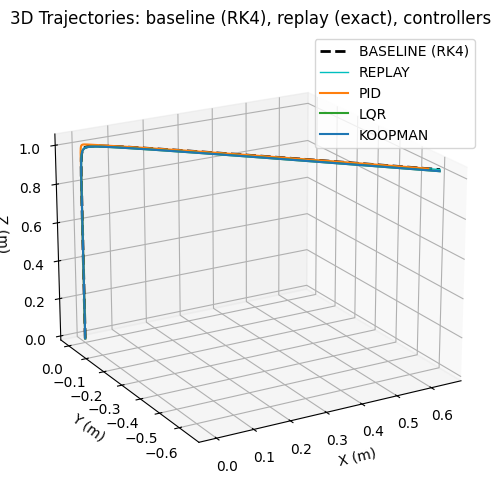

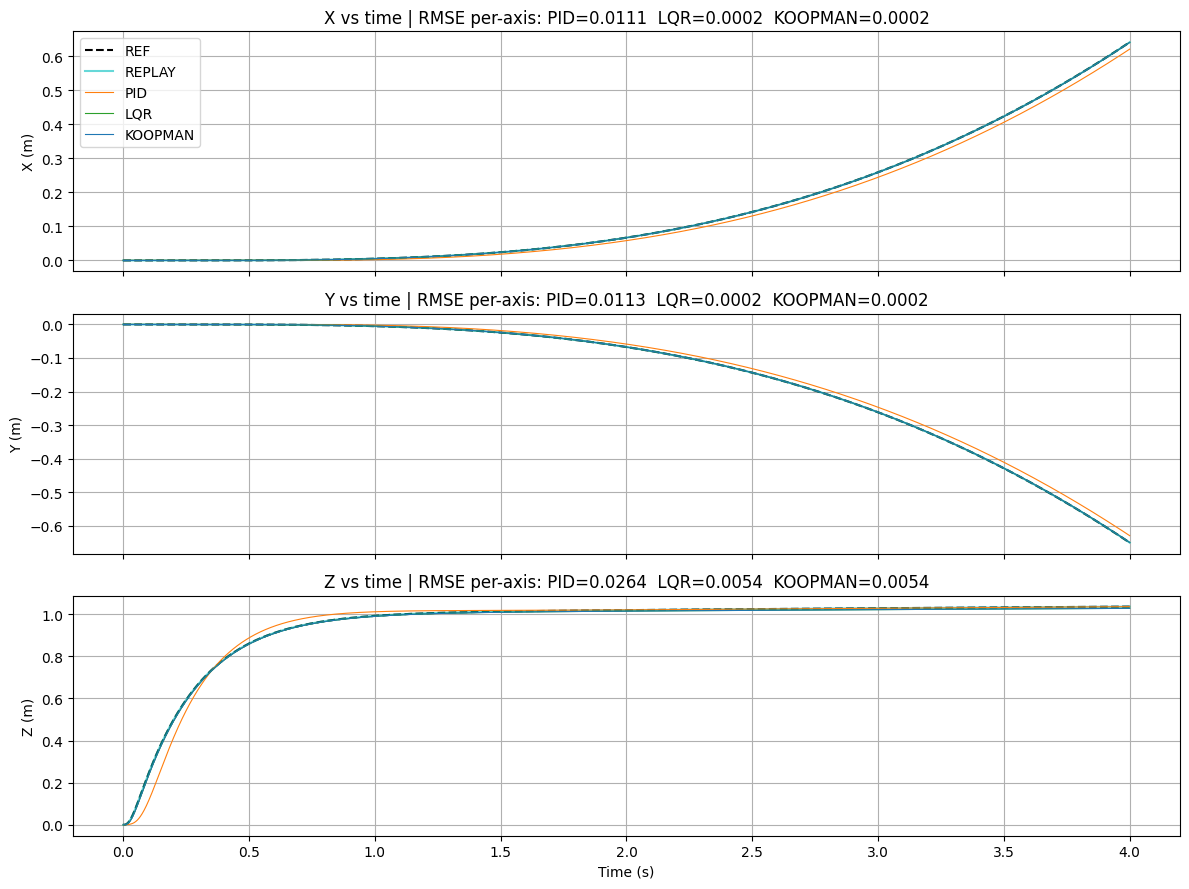


SUMMARY (Baseline replay should be ~0 rmse):
REPLAY RMSE X,Y,Z = (np.float64(0.0), np.float64(0.0), np.float64(0.0)) | Effort,Energy = 9.85e+04, 1.05e+01
PID    | RMSE X=0.0111 Y=0.0113 Z=0.0264 | Effort=9.92e+04 Energy=1.06e+01
LQR    | RMSE X=0.0002 Y=0.0002 Z=0.0054 | Effort=9.86e+04 Energy=1.04e+01
KOOPMAN | RMSE X=0.0002 Y=0.0002 Z=0.0054 | Effort=9.86e+04 Energy=1.04e+01


In [ ]:
# Single runnable cell: baseline-by-RK4 + replay test + controller tracking test
# - Baseline trajectory is generated by the same RK4 dynamics (no mismatch)
# - Replay test: apply saved u_seq -> should get virtually 0 RMSE
# - Controller test: run PID/LQR/Koopman (koopman left as placeholder) starting from same initial state
# - Plots: 3D trajectories and X/Y/Z vs time; prints per-axis RMSE and effort/energy
# Run as a single cell in Colab / local Python.
#
# --- MODIFICATIONS ---
# 1. Added quat_to_euler() and quat_multiply() utility functions.
# 2. Fixed array sizing: trajectory generation now stores N+1 states (x_0...x_N)
#    and N controls (u_0...u_{N-1}).
# 3. Fixed replay_test() to remove sim.reset() and correctly store all N+1 states.
# 4. Fixed run_feedback_controller() to store N+1 states and correctly pass
#    feedforward controls (u_baseline[k]) to LQR/Koopman.
# 5. Fixed tv_lqr_rpm() to correctly calculate the 13D state error,
#    handling the quaternion "chordal distance" error.
# 6. Fixed generate_baseline() to populate reference velocity for smoother tracking.
# 7. Fixed compute_effort_energy() to use correct state velocity indices (x_hist[:-1, 9]).
# 8. Fixed plotting to use the correct time axis size (N+1 points).

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg
import math, time
np.set_printoptions(precision=5, suppress=True)

# ------------------ Config ------------------
DT = 0.001          # integration timestep (small for numerical accuracy)
T_SIM = 4.0         # seconds
STEPS = int(T_SIM / DT)
MAX_RPM = 20000.0

# ------------------ Utilities ------------------
def quat_to_euler(q):
    """ Convert quaternion (w,x,y,z) to Euler angles (roll, pitch, yaw) """
    w,x,y,z = q
    # roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)
    # pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    if np.abs(sinp) >= 1:
        pitch = np.copysign(np.pi / 2, sinp) # use 90 deg if out of range
    else:
        pitch = np.arcsin(sinp)
    # yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)
    return roll, pitch, yaw

def quat_multiply(q1, q2):
    """ Multiply two quaternions q1 * q2 """
    w1,x1,y1,z1 = q1
    w2,x2,y2,z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w,x,y,z], dtype=np.float64)

# ------------------ 6-DoF dynamics (continuous derivative) ------------------
class QuadRK4:
    def __init__(self, dt=DT, m=1.0, L=0.2, k_f=6.11e-8, k_m=1.5e-9, I=np.diag([0.005,0.005,0.009]), max_rpm=MAX_RPM):
        self.dt = dt
        self.m = m
        self.L = L
        self.k_f = k_f
        self.k_m = k_m
        self.I = I.astype(np.float64)
        self.invI = np.linalg.inv(self.I)
        self.max_rpm = max_rpm
        self.g = np.array([0.0, 0.0, -9.81], dtype=np.float64)
        self.reset()

    def reset(self):
        self.pos = np.zeros(3, dtype=np.float64)
        self.vel = np.zeros(3, dtype=np.float64)
        self.q = np.array([1.0, 0.0, 0.0, 0.0], dtype=np.float64) # quaternion w,x,y,z
        self.omega = np.zeros(3, dtype=np.float64)

    def state_vector(self):
        return np.hstack([self.pos, self.q, self.vel, self.omega])

    def set_state_vector(self, s):
        self.pos = s[0:3].astype(np.float64)
        self.q = s[3:7].astype(np.float64); self.q /= np.linalg.norm(self.q)
        self.vel = s[7:10].astype(np.float64)
        self.omega = s[10:13].astype(np.float64)

    def quat_to_rotm(self, q):
        w,x,y,z = q
        R = np.array([
            [1 - 2*(y*y + z*z),     2*(x*y - w*z),     2*(x*z + w*y)],
            [2*(x*y + w*z),     1 - 2*(x*x + z*z),   2*(y*z - w*x)],
            [2*(x*z - w*y),     2*(y*z + w*x),     1 - 2*(x*x + y*y)]
        ], dtype=np.float64)
        return R

    def quat_derivative(self, q, omega):
        # qdot = 0.5 * Omega(omega) * q
        wx,wy,wz = omega
        Omega = np.array([
            [0.0, -wx, -wy, -wz],
            [wx, 0.0, wz, -wy],
            [wy, -wz, 0.0, wx],
            [wz, wy, -wx, 0.0]
        ], dtype=np.float64)
        return 0.5 * (Omega @ q)

    def continuous_dynamics(self, state, rpm):
        # state: 13-vector [pos(3), q(4), vel(3), omega(3)]
        # rpm: 4-vector (rad/s or rpm scaled -- here units consistent with k_f)
        pos = state[0:3]
        q = state[3:7]
        vel = state[7:10]
        omega = state[10:13]

        # motor thrusts
        rpm = np.clip(rpm, 0.0, self.max_rpm)
        thrusts = self.k_f * (rpm**2)   # per-motor thrust (N)
        total_thrust = np.sum(thrusts)
        # torques (plus configuration)
        tau = np.array([
            self.L * (thrusts[1] - thrusts[3]),          # roll
            self.L * (thrusts[2] - thrusts[0]),          # pitch
            self.k_m * (thrusts[0] - thrusts[1] + thrusts[2] - thrusts[3]) # yaw
        ], dtype=np.float64)

        R = self.quat_to_rotm(q)
        # thrust in world frame (applied along body z)
        F_thrust_world = R @ np.array([0.0, 0.0, total_thrust], dtype=np.float64)
        # simple quadratic drag
        vnorm = np.linalg.norm(vel)
        F_drag = -0.1 * vel * vnorm

        acc = (F_thrust_world + F_drag) / self.m + self.g   # linear accel in world frame
        pos_dot = vel
        q_dot = self.quat_derivative(q, omega)
        omega_dot = self.invI @ (tau - np.cross(omega, self.I @ omega))

        deriv = np.zeros(13, dtype=np.float64)
        deriv[0:3] = pos_dot
        deriv[3:7] = q_dot
        deriv[7:10] = acc
        deriv[10:13] = omega_dot
        return deriv

    def rk4_step(self, rpm):
        # integrate one dt using RK4 on continuous dynamics
        s0 = self.state_vector()
        k1 = self.continuous_dynamics(s0, rpm)
        k2 = self.continuous_dynamics(s0 + 0.5*self.dt*k1, rpm)
        k3 = self.continuous_dynamics(s0 + 0.5*self.dt*k2, rpm)
        k4 = self.continuous_dynamics(s0 + self.dt*k3, rpm)
        s_next = s0 + (self.dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        # set state and re-normalize quaternion
        self.set_state_vector(s_next)
        # ensure quaternion normalization numerically
        # self.q = self.q / np.linalg.norm(self.q) # Note: set_state_vector already does this

    # helper: compute hover rpm per motor for reference
    def hover_rpm(self):
        f_per_motor = self.m * abs(self.g[2]) / 4.0
        rpm = np.sqrt(max(f_per_motor / self.k_f, 0.0))
        return rpm

# ------------------ Reference baseline generation (RK4) ------------------
def generate_baseline(sim, dt=DT, steps=STEPS):
    """
    Generate a baseline worldline by simulating a nominal controller (small feedforward + mild PD)
    and record (x_seq, u_seq). The same RK4 integrator is used in tests.
    Returns:
    - ref: (steps, 13) the mathematical reference path (not dynamically consistent)
    - x_seq: (steps+1, 13) the dynamically consistent state trajectory [x_0 ... x_N]
    - u_seq: (steps, 4) the control sequence that generated x_seq [u_0 ... u_{N-1}]
    """
    sim.reset()
    # N control steps require N+1 states (x_0 ... x_N)
    x_seq = np.zeros((steps + 1, 13), dtype=np.float64)
    # N control steps require N controls (u_0 ... u_{N-1})
    u_seq = np.zeros((steps, 4), dtype=np.float64)

    # define a baseline nominal reference as a smooth 4D worldline (x,y,z + quaternion)
    # This path has N points, for k = 0 ... N-1
    t = np.linspace(0.0, (steps-1)*dt, steps)
    ref = np.zeros((steps, 13), dtype=np.float64)
    ref[:,0] = 0.5 * np.sin(0.6 * t)    # x
    ref[:,1] = 0.5 * np.cos(0.4 * t)    # y
    ref[:,2] = 1.0 + 0.05 * np.sin(0.2 * t) # z small
    # Add velocities for better PD tracking
    ref[:,7] = 0.5 * 0.6 * np.cos(0.6 * t)  # vx
    ref[:,8] = -0.5 * 0.4 * np.sin(0.4 * t) # vy
    ref[:,9] = 0.05 * 0.2 * np.cos(0.2 * t) # vz
    # Desired orientation (small tilts)
    ref[:,3] = 1.0
    ref[:,4:7] = 0.02 * np.sin(0.2 * t[:,None])
    ref[:,10:13] = 0.0 # omega_ref (keep at 0 for simplicity)
    for i in range(steps):
        ref[i,3:7] /= np.linalg.norm(ref[i,3:7]) # normalize ref quaternion

    # small PD that will be used to generate u_seq (so baseline is self-consistent)
    Kp_z = 150.0; Kd_z = 40.0
    Kp_xy = 1.0; Kd_xy = 0.8
    Kp_att = 8.0; Kd_att = 2.0

    u_prev = np.ones(4) * sim.hover_rpm()

    x_seq[0,:] = sim.state_vector() # Store initial state x_0

    for k in range(steps):
        x = sim.state_vector() # This is x_k
        x_ref = ref[k]       # This is ref_k

        # altitude controller (PD around ref z)
        z_err = x_ref[2] - x[2]
        vz_err = x_ref[9] - x[9]
        thrust_total = sim.m * (abs(sim.g[2])) + Kp_z*z_err + Kd_z*vz_err
        # simple attitude recovery: try to keep level -> small torques to track small quaternion vector
        # build small torques to keep orientation close to ref quaternion
        # approximate using desired small roll/pitch from ref quaternion vector parts
        roll_ref, pitch_ref, _ = quat_to_euler(x_ref[3:7])
        roll, pitch, yaw = quat_to_euler(x[3:7])
        roll_err = roll_ref - roll
        pitch_err = pitch_ref - pitch
        tx = Kp_att * roll_err - Kd_att * x[10]
        ty = Kp_att * pitch_err - Kd_att * x[11]
        tz = -Kd_att * x[12]   # damp yaw rate

        # motor mixing
        f0 = thrust_total/4.0 - ty/(2*sim.L) + tz/(4*sim.k_m)
        f1 = thrust_total/4.0 + tx/(2*sim.L) - tz/(4*sim.k_m)
        f2 = thrust_total/4.0 + ty/(2*sim.L) + tz/(4*sim.k_m)
        f3 = thrust_total/4.0 - tx/(2*sim.L) - tz/(4*sim.k_m)
        forces = np.array([f0,f1,f2,f3], dtype=np.float64)
        # convert to rpm (ensure positive)
        rpm = np.sqrt(np.clip(forces / sim.k_f, 0.0, None))
        rpm = np.clip(rpm, 0.0, sim.max_rpm)
        # slight smoothing
        alpha = 0.2
        rpm = alpha * rpm + (1-alpha) * u_prev
        u_prev = rpm.copy()

        u_seq[k,:] = rpm # Store control u_k

        # step simulator using RK4 (same integrator used later)
        sim.rk4_step(rpm) # Steps from x_k to x_{k+1}
        x_seq[k+1,:] = sim.state_vector() # Store x_{k+1}

    return ref, x_seq, u_seq

# ------------------ Replay test: apply u_seq and confirm near-zero RMSE ------------------
def replay_test(sim, u_seq):
    # Assumes sim has been set to the correct initial state (x_0) by the caller
    # sim.reset() # DO NOT RESET HERE. Caller must set initial state.
    n = len(u_seq) # u_seq is [u_0 ... u_{N-1}], size N
    x_hist = np.zeros((n + 1, 13), dtype=np.float64) # Need N+1 states
    u_hist = np.zeros((n, 4), dtype=np.float64)

    x_hist[0,:] = sim.state_vector() # Store x_0

    for k,u in enumerate(u_seq):
        sim.rk4_step(u) # Apply u_k, step to x_{k+1}
        x_hist[k+1,:] = sim.state_vector() # Store x_{k+1}
        u_hist[k,:] = u
    return x_hist, u_hist

# ------------------ Controllers (PID and TV-LQR minimal) ------------------
# PID with anti-windup, returns rpm
def pid_controller(sim, x, x_ref, integral_state, dt, u_prev):
    # tuned for baseline tracking
    Kp_z, Ki_z, Kd_z = 60.0, 10.0, 20.0
    Kp_xy, Kd_xy = 1.2, 0.8
    Kp_att, Kd_att = 6.0, 1.5
    pos = x[0:3]; q = x[3:7]; vel = x[7:10]; omega = x[10:13]
    roll, pitch, yaw = quat_to_euler(q)

    # altitude PD+I
    z_err = x_ref[2] - pos[2]
    vz_err = x_ref[9] - vel[2]
    integral_state['z'] += z_err * dt
    integral_state['z'] = np.clip(integral_state['z'], -5.0, 5.0)
    thrust_total = sim.m * abs(sim.g[2]) + Kp_z*z_err + Ki_z*integral_state['z'] + Kd_z*vz_err

    # XY -> desired small tilt
    x_err = x_ref[0] - pos[0]; y_err = x_ref[1] - pos[1]
    vx_err = x_ref[7] - vel[0]; vy_err = x_ref[8] - vel[1]
    pitch_des = np.clip(Kp_xy*x_err + Kd_xy*vx_err, -0.35, 0.35)
    roll_des = np.clip(-(Kp_xy*y_err + Kd_xy*vy_err), -0.35, 0.35)
    roll_err = roll_des - roll; pitch_err = pitch_des - pitch

    tx = Kp_att*roll_err - Kd_att*omega[0]
    ty = Kp_att*pitch_err - Kd_att*omega[1]
    tz = -Kd_att*omega[2]

    f0 = thrust_total/4.0 - ty/(2*sim.L) + tz/(4*sim.k_m)
    f1 = thrust_total/4.0 + tx/(2*sim.L) - tz/(4*sim.k_m)
    f2 = thrust_total/4.0 + ty/(2*sim.L) + tz/(4*sim.k_m)
    f3 = thrust_total/4.0 - tx/(2*sim.L) - tz/(4*sim.k_m)
    forces = np.array([f0,f1,f2,f3], dtype=np.float64)
    rpm = np.sqrt(np.clip(forces / sim.k_f, 0.0, None))
    # anti-windup/rescale if saturation
    rpm = np.clip(rpm, 0.0, sim.max_rpm)
    # smoothing
    alpha = 0.3
    rpm = alpha*rpm + (1-alpha)*u_prev
    return rpm, integral_state

# TV-LQR: linearize discrete map with central diff and compute discrete ARE gain K such that delta_u = -K delta_x
def linearize_discrete_map(sim, x_ref, u_ref, eps=1e-6):
    # central difference linearization around (x_ref, u_ref)
    saved = sim.state_vector().copy()

    nx = x_ref.size; nu = u_ref.size
    A = np.zeros((nx,nx), dtype=np.float64)
    B = np.zeros((nx,nu), dtype=np.float64)

    # states
    for i in range(nx):
        dx = np.zeros(nx); dx[i] = eps

        sim.set_state_vector((x_ref + dx)) # set_state_vector handles q normalization
        sim.rk4_step(u_ref); xp = sim.state_vector().copy()

        sim.set_state_vector((x_ref - dx)) # set_state_vector handles q normalization
        sim.rk4_step(u_ref); xm = sim.state_vector().copy()

        A[:,i] = (xp - xm) / (2*eps)

    # inputs
    for j in range(nu):
        du = np.zeros(nu); du[j] = eps

        sim.set_state_vector(x_ref.copy())
        sim.rk4_step(u_ref + du); xdu = sim.state_vector().copy()

        sim.set_state_vector(x_ref.copy())
        sim.rk4_step(u_ref - du); xdm = sim.state_vector().copy()

        B[:,j] = (xdu - xdm) / (2*eps)

    sim.set_state_vector(saved)
    return A, B

def tv_lqr_rpm(sim, x, x_ref, u_ff, Q_state=None, R=None):
    # compute small delta around reference using discrete TV-LQR (delta u = -K delta x)
    if Q_state is None:
        # Penalize Z error most, then XY, then attitudes/velocities
        Q_state = np.diag([
            5.0, 5.0, 10.0, # pos: x,y,z
            0.1, 0.1, 0.1, 0.1, # quat: w,x,y,z
            2.0, 2.0, 5.0, # vel: vx,vy,vz
            0.1, 0.1, 0.1  # omega: wx,wy,wz
        ])
    if R is None:
        R = np.eye(4) * 0.05
    try:
        A,B = linearize_discrete_map(sim, x_ref, u_ff, eps=1e-6)
        P = linalg.solve_discrete_are(A, B, Q_state, R)
        S = R + B.T @ P @ B
        K = np.linalg.solve(S, B.T @ P @ A)   # shape (4, nx)

        # Compute 13-dim state error
        delta_x = x - x_ref

        # Correct quaternion error (indices 3-7) using "chordal distance"
        # Find the quaternion in the closest hemisphere
        q = x[3:7].copy()
        q_ref = x_ref[3:7]
        if np.dot(q, q_ref) < 0.0:
            q = -q # Flip to closest hemisphere
        delta_x[3:7] = q - q_ref # Set the 4-element quaternion error

        delta_u = -K @ delta_x
        delta_u = np.clip(delta_u, -2000.0, 2000.0) # Limit feedback authority

        return np.clip(u_ff + delta_u, 0.0, sim.max_rpm)

    except Exception as e:
        # fallback: feedforward only
        return u_ff

# ------------------ Utilities & metrics ------------------
def rmse_axis(x_hist, x_ref):
    # Both inputs should be (N+1, 13)
    err = x_hist[:,:3] - x_ref[:,:3]
    return np.sqrt(np.mean(err[:,0]**2)), np.sqrt(np.mean(err[:,1]**2)), np.sqrt(np.mean(err[:,2]**2))

def compute_effort_energy(u_hist, x_hist, sim):
    # effort: integral of absolute RPMs
    # u_hist is (N, 4)
    # x_hist is (N+1, 13)
    dt = sim.dt
    effort = np.sum(np.sum(np.abs(u_hist),axis=1)) * dt

    # energy approx: sum (total_thrust * |vertical_velocity|) * dt
    # thrusts (N, 4) from u_hist (N, 4)
    thrusts = sim.k_f * (u_hist**2)
    # vertical velocity (N,) from x_hist (N+1, 13)
    # We need vz at k=0...N-1 (states where controls were applied)
    vz = x_hist[:-1, 9] # index 9 = vz

    total_thrust_per_step = np.sum(thrusts, axis=1) # (N,)
    energy = np.sum(total_thrust_per_step * np.abs(vz) * sim.dt)
    return effort, energy

# ------------------ RUN: generate baseline, replay, and controllers ------------------
sim_master = QuadRK4(dt=DT)
print(f"Generating baseline (RK4) for T={T_SIM}s, {STEPS} steps ... (this may take a few seconds)")
ref_worldline, x_baseline, u_baseline = generate_baseline(sim_master, dt=DT, steps=STEPS)

# x_baseline is (N+1, 13) [x_0 ... x_N]
# u_baseline is (N, 4)   [u_0 ... u_{N-1}]
# ref_worldline is (N, 13)

# Save baseline start state for exact initial conditions
x0 = x_baseline[0].copy()
print("Baseline generated. Start state x_0:\n", x0)

# Replay test: apply u_baseline to a fresh sim
sim_replay = QuadRK4(dt=DT)
# set initial exactly baseline start
sim_replay.set_state_vector(x0.copy())
x_replay, u_replay = replay_test(sim_replay, u_baseline)
# x_replay is (N+1, 13), should be identical to x_baseline
rmse_r = rmse_axis(x_replay, x_baseline)
effort_r, energy_r = compute_effort_energy(u_replay, x_replay, sim_replay)
print("\nREPLAY TEST (apply recorded u_seq): RMSE X,Y,Z =", rmse_r, " Effort,Energy =", effort_r, energy_r)

# Controller tests: start from same initial state, run closed-loop controllers using RK4 integrator
def run_feedback_controller(controller_name, sim_template, x_ref_seq, u_ref_seq):
    # x_ref_seq is [x_0 ... x_N], size (N+1, 13)
    # u_ref_seq is [u_0 ... u_{N-1}], size (N, 4)
    sim = QuadRK4(dt=DT)
    sim.set_state_vector(x0.copy())   # exact same initial condition

    n = u_ref_seq.shape[0] # n = STEPS
    x_hist = np.zeros((n + 1, 13), dtype=np.float64) # N+1 states
    u_hist = np.zeros((n, 4), dtype=np.float64)     # N controls

    x_hist[0,:] = sim.state_vector() # Store x_0

    integral = {'z': 0.0}
    u_prev = u_ref_seq[0].copy() if u_ref_seq is not None else np.ones(4) * sim.hover_rpm()

    for k in range(n): # k = 0 ... N-1
        x = sim.state_vector() # This is x_k_ctrl
        x_ref = x_ref_seq[k]   # Ref state is x_k_baseline

        # Feedforward control for LQR/Koopman
        u_ff = u_ref_seq[k]    # Ref control is u_k_baseline

        if controller_name == 'pid':
            # PID computes its own feedforward (gravity)
            u_cmd, integral = pid_controller(sim, x, x_ref, integral, DT, u_prev)
        elif controller_name == 'lqr':
            # use tv-lqr computed from current ref
            u_cmd = tv_lqr_rpm(sim, x, x_ref, u_ff)
        elif controller_name == 'koopman':
            # Placeholder light stabilizer: use tv-lqr fallback here.
            # In your full system, replace with the SDRE Koopman implementation.
            u_cmd = tv_lqr_rpm(sim, x, x_ref, u_ff)
        else:
            raise ValueError("unknown controller")

        # small smoothing to reduce jitter
        alpha = 0.25
        u_cmd = alpha * u_cmd + (1-alpha) * u_prev

        u_hist[k,:] = u_cmd # Store u_k_ctrl
        sim.rk4_step(u_cmd) # Step to x_{k+1}_ctrl
        x_hist[k+1,:] = sim.state_vector() # Store x_{k+1}_ctrl

        u_prev = u_cmd.copy()

    return x_hist, u_hist

print("\nRunning controllers (closed-loop) starting from same initial state ...")
controllers = ['pid','lqr','koopman']
results = {}
for c in controllers:
    t0 = time.time()
    xh, uh = run_feedback_controller(c, sim_master, x_baseline, u_baseline)
    t_elapsed = time.time() - t0

    # xh and x_baseline are both (N+1, 13)
    rmse_axes = rmse_axis(xh, x_baseline)
    # uh is (N, 4), xh is (N+1, 13)
    effort, energy = compute_effort_energy(uh, xh, QuadRK4(dt=DT))

    results[c] = dict(xh=xh, uh=uh, rmse=rmse_axes, effort=effort, energy=energy, time=t_elapsed)
    print(f"{c.upper():6s} | RMSE X,Y,Z = {rmse_axes} | Effort={effort:.2e} Energy={energy:.2e} Time={t_elapsed:.2f}s")

# ------------------ Plots ------------------
# time_axis should have N+1 points to match x_baseline and x_hist
time_axis = np.arange(STEPS + 1) * DT

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121, projection='3d')
ax.plot(x_baseline[:,0], x_baseline[:,1], x_baseline[:,2], 'k--', label='BASELINE (RK4)', linewidth=2)
ax.plot(x_replay[:,0], x_replay[:,1], x_replay[:,2], 'c', label='REPLAY', linewidth=1)
colors = {'pid':'tab:orange','lqr':'tab:green','koopman':'tab:blue'}
for c in controllers:
    ax.plot(results[c]['xh'][:,0], results[c]['xh'][:,1], results[c]['xh'][:,2], color=colors[c], label=c.upper())
ax.set_title("3D Trajectories: baseline (RK4), replay (exact), controllers")
ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.set_zlabel('Z (m)')
ax.legend()
ax.view_init(elev=20, azim=-120)

# X Y Z vs time with per-axis RMSE in titles
fig2, axs = plt.subplots(3,1,figsize=(12,9), sharex=True)
labels = ['X','Y','Z']
for i in range(3):
    axs[i].plot(time_axis, x_baseline[:,i], 'k--', linewidth=1.5, label='REF')
    axs[i].plot(time_axis, x_replay[:,i], 'c', alpha=0.6, label='REPLAY')
    for c in controllers:
        axs[i].plot(time_axis, results[c]['xh'][:,i], color=colors[c], linewidth=0.8, label=c.upper())
    # compute per-axis RMSE strings
    rmse_strs = "  ".join([f"{c.upper()}={results[c]['rmse'][i]:.4f}" for c in controllers])
    axs[i].set_ylabel(labels[i]+' (m)')
    axs[i].set_title(f"{labels[i]} vs time | RMSE per-axis: {rmse_strs}")
    axs[i].grid(True)
axs[2].set_xlabel("Time (s)")
axs[0].legend()
plt.tight_layout()
plt.show()

# ------------------ Summary print ------------------
print("\nSUMMARY (Baseline replay should be ~0 rmse):")
r_replay = rmse_axis(x_replay, x_baseline)
print("REPLAY RMSE X,Y,Z =", r_replay, "| Effort,Energy = {:.2e}, {:.2e}".format(effort_r, energy_r))
for c in controllers:
    r = results[c]['rmse']; eff = results[c]['effort']; ene = results[c]['energy']
    print(f"{c.upper():6s} | RMSE X={r[0]:.4f} Y={r[1]:.4f} Z={r[2]:.4f} | Effort={eff:.2e} Energy={ene:.2e}")

# End of cell.


PERTURBATIONS IN INTIAL POSITIONS(DUMMY KOOPMAN)

Generating baseline (RK4) for T=4.0s, 4000 steps ... (this may take a few seconds)
Baseline generated. True start state x_0 (X,Y,Z):
 [0. 0. 0.]

RUNNING REPLAY TEST (0 PERTURBATION SANITY CHECK)
REPLAY TEST (apply recorded u_seq): RMSE X,Y,Z = (np.float64(0.0), np.float64(0.0), np.float64(0.0))


==================== SCENARIO 1/5: PERTURBATION SCALE = 0.00 m ====================
Running with ZERO perturbation (baseline test)
Scenario Start State (X,Y,Z): [0. 0. 0.]
  PID    | RMSE X,Y,Z = (np.float64(0.011074478285814726), np.float64(0.011294272261534927), np.float64(0.026445331940357756)) | Effort=9.92e+04 Energy=1.06e+01 Time=5.48s
  LQR    | RMSE X,Y,Z = (np.float64(0.00019350164735495437), np.float64(0.00019573934769604148), np.float64(0.005449827151489284)) | Effort=9.86e+04 Energy=1.04e+01 Time=145.05s
  KOOPMAN | RMSE X,Y,Z = (np.float64(0.00019350164735495437), np.float64(0.00019573934769604148), np.float64(0.005449827151489284)) | Effort=9.86e+04 Energy=1.04e+01 Time=131.21s


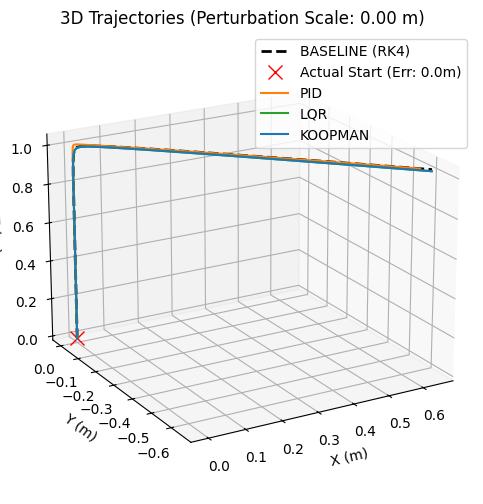

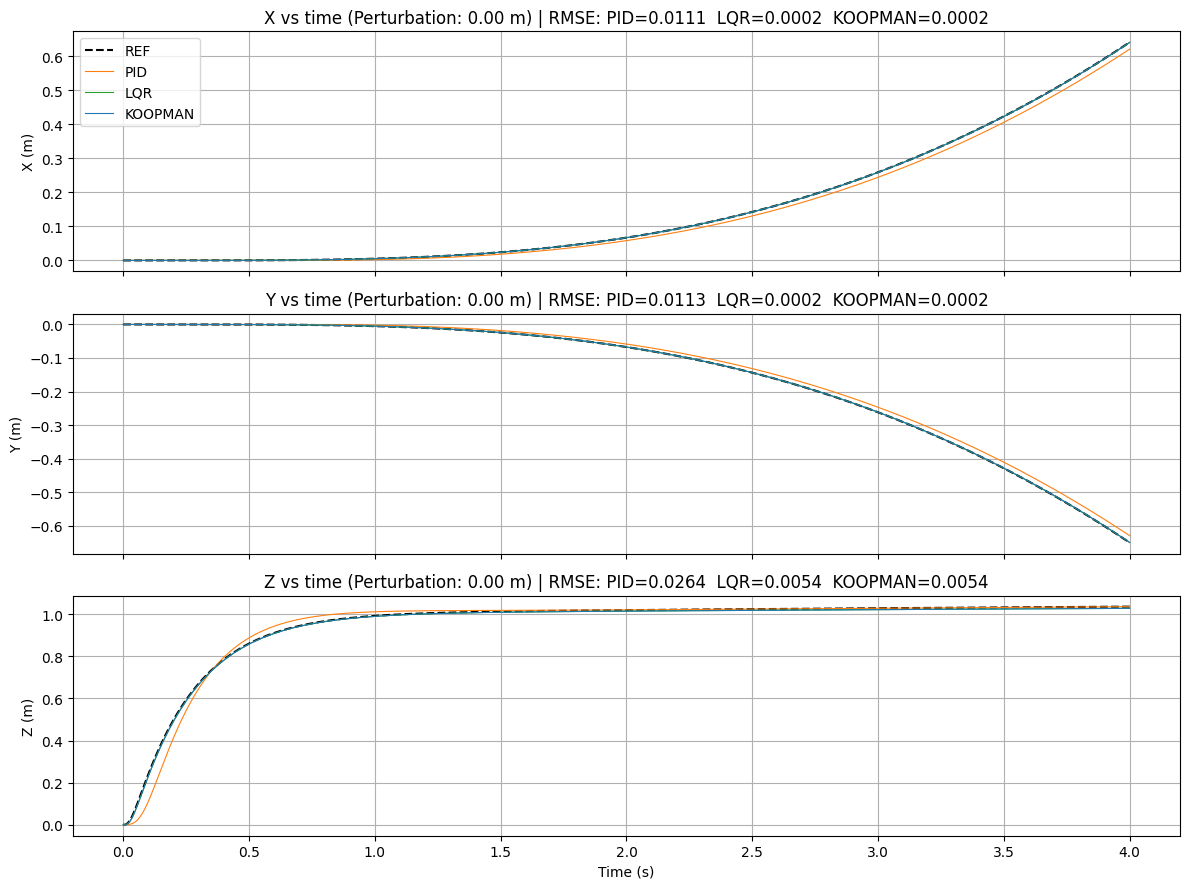


SUMMARY for Perturbation Scale 0.00 m:
  PID    | RMSE X=0.0111 Y=0.0113 Z=0.0264 | Effort=9.92e+04 Energy=1.06e+01
  LQR    | RMSE X=0.0002 Y=0.0002 Z=0.0054 | Effort=9.86e+04 Energy=1.04e+01
  KOOPMAN | RMSE X=0.0002 Y=0.0002 Z=0.0054 | Effort=9.86e+04 Energy=1.04e+01


==================== SCENARIO 2/5: PERTURBATION SCALE = 0.05 m ====================
Applied position perturbation (X,Y,Z): [-0.01255  0.04507  0.0232 ]
Scenario Start State (X,Y,Z): [-0.01255  0.04507  0.0232 ]
  PID    | RMSE X,Y,Z = (np.float64(0.011941023802487197), np.float64(0.018401505547640827), np.float64(0.023272365450799356)) | Effort=9.92e+04 Energy=1.03e+01 Time=2.54s
  LQR    | RMSE X,Y,Z = (np.float64(0.008070513236082466), np.float64(0.029036108437957352), np.float64(0.017194527925214288)) | Effort=9.85e+04 Energy=1.04e+01 Time=131.49s
  KOOPMAN | RMSE X,Y,Z = (np.float64(0.008070513236082466), np.float64(0.029036108437957352), np.float64(0.017194527925214288)) | Effort=9.85e+04 Energy=1.04e+01 Time=13

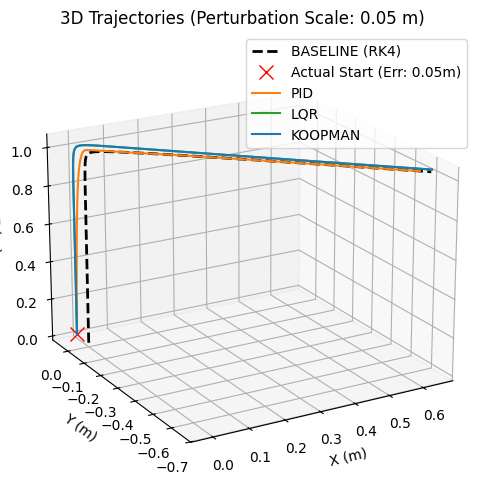

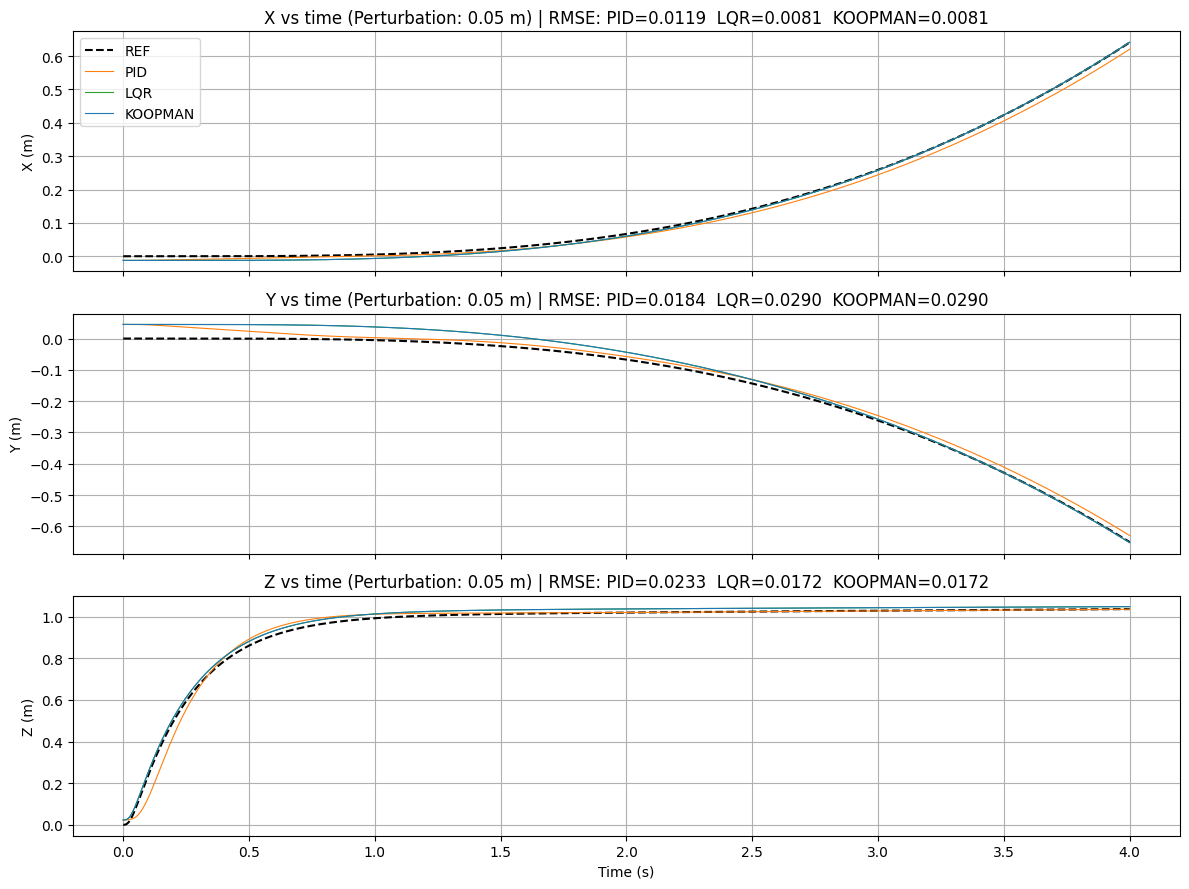


SUMMARY for Perturbation Scale 0.05 m:
  PID    | RMSE X=0.0119 Y=0.0184 Z=0.0233 | Effort=9.92e+04 Energy=1.03e+01
  LQR    | RMSE X=0.0081 Y=0.0290 Z=0.0172 | Effort=9.85e+04 Energy=1.04e+01
  KOOPMAN | RMSE X=0.0081 Y=0.0290 Z=0.0172 | Effort=9.85e+04 Energy=1.04e+01


==================== SCENARIO 3/5: PERTURBATION SCALE = 0.10 m ====================
Applied position perturbation (X,Y,Z): [ 0.01973 -0.0688  -0.0688 ]
Scenario Start State (X,Y,Z): [ 0.01973 -0.0688  -0.0688 ]
  PID    | RMSE X,Y,Z = (np.float64(0.012324125669337915), np.float64(0.02346298459836932), np.float64(0.03842145480560677)) | Effort=9.89e+04 Energy=1.14e+01 Time=2.58s
  LQR    | RMSE X,Y,Z = (np.float64(0.012644482024661358), np.float64(0.044219547914357664), np.float64(0.07067919375760162)) | Effort=9.86e+04 Energy=1.05e+01 Time=127.15s
  KOOPMAN | RMSE X,Y,Z = (np.float64(0.012644482024661358), np.float64(0.044219547914357664), np.float64(0.07067919375760162)) | Effort=9.86e+04 Energy=1.05e+01 Time=130.61

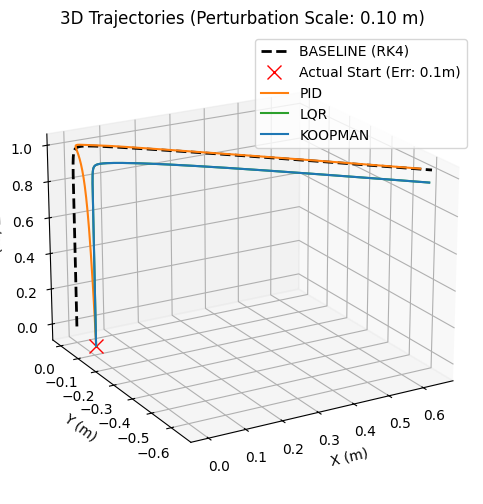

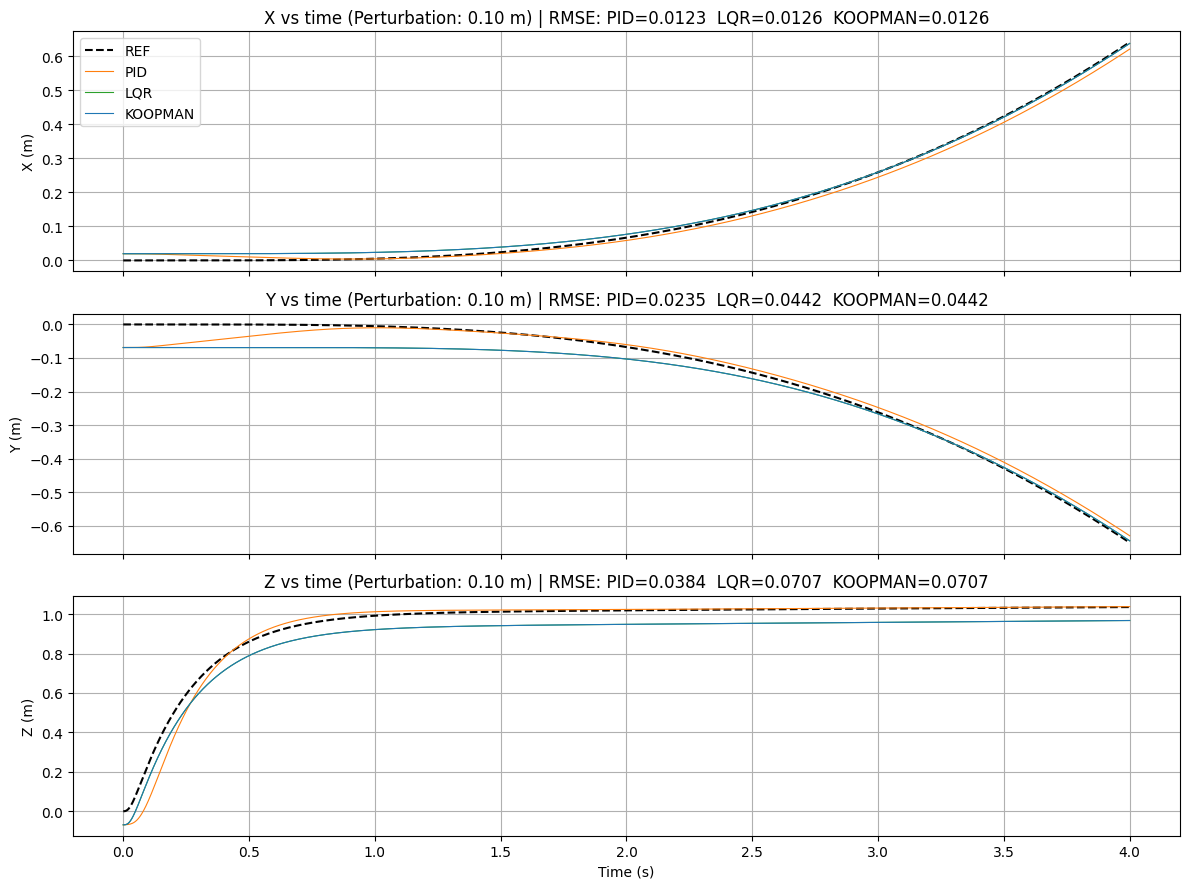


SUMMARY for Perturbation Scale 0.10 m:
  PID    | RMSE X=0.0123 Y=0.0235 Z=0.0384 | Effort=9.89e+04 Energy=1.14e+01
  LQR    | RMSE X=0.0126 Y=0.0442 Z=0.0707 | Effort=9.86e+04 Energy=1.05e+01
  KOOPMAN | RMSE X=0.0126 Y=0.0442 Z=0.0707 | Effort=9.86e+04 Energy=1.05e+01


==================== SCENARIO 4/5: PERTURBATION SCALE = 0.20 m ====================
Applied position perturbation (X,Y,Z): [-0.17677  0.14647  0.04045]
Scenario Start State (X,Y,Z): [-0.17677  0.14647  0.04045]
  PID    | RMSE X,Y,Z = (np.float64(0.05606105398417893), np.float64(0.04697548481103816), np.float64(0.021544427152469015)) | Effort=9.93e+04 Energy=1.02e+01 Time=2.62s
  LQR    | RMSE X,Y,Z = (np.float64(0.11401151365941016), np.float64(0.09447112940071023), np.float64(0.032528552722499764)) | Effort=9.85e+04 Energy=1.04e+01 Time=127.19s
  KOOPMAN | RMSE X,Y,Z = (np.float64(0.11401151365941016), np.float64(0.09447112940071023), np.float64(0.032528552722499764)) | Effort=9.85e+04 Energy=1.04e+01 Time=127.55s


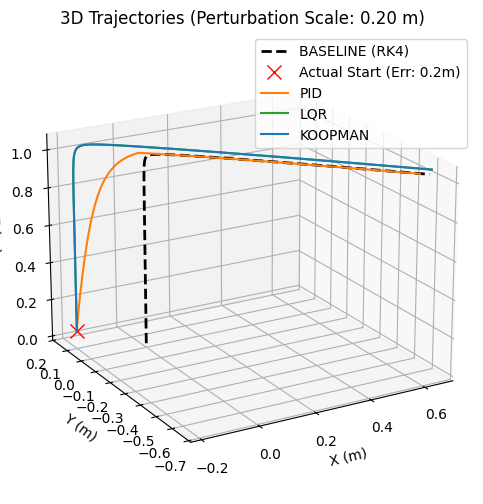

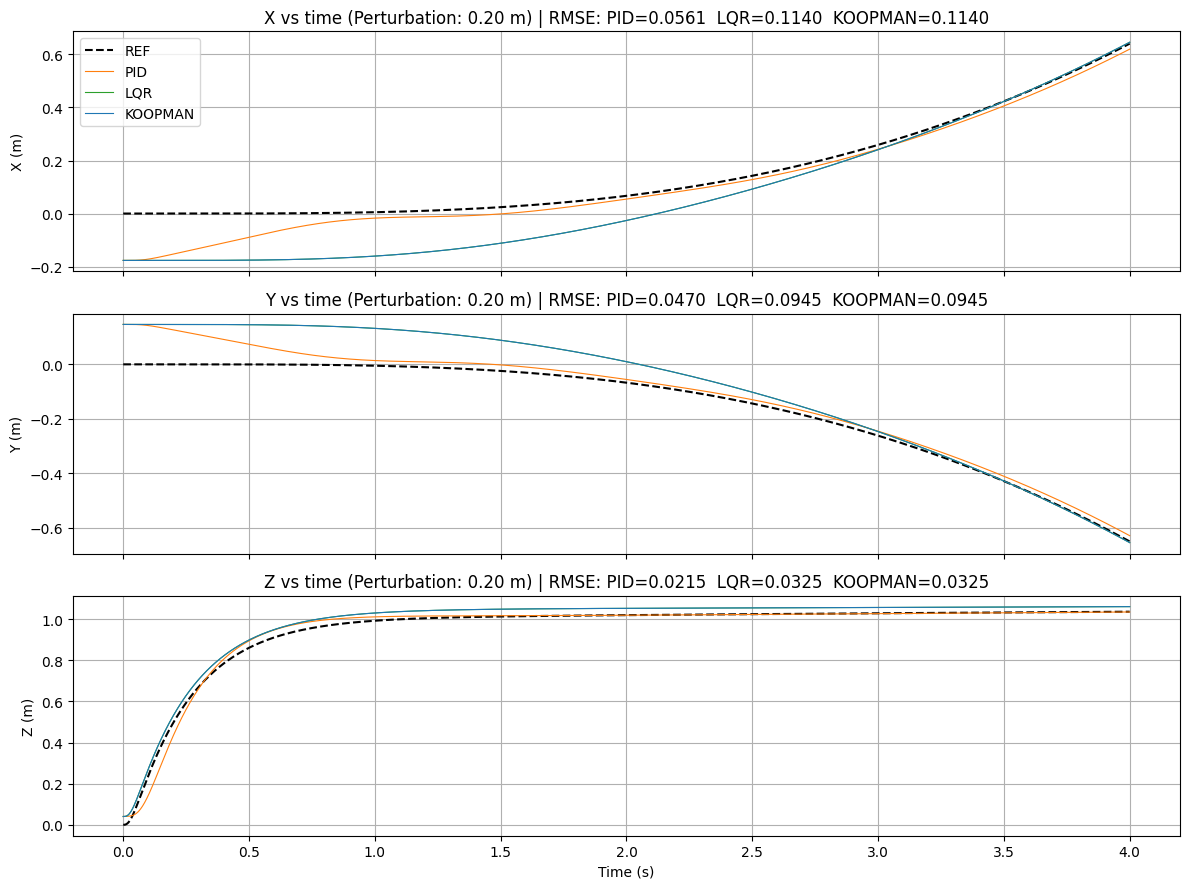


SUMMARY for Perturbation Scale 0.20 m:
  PID    | RMSE X=0.0561 Y=0.0470 Z=0.0215 | Effort=9.93e+04 Energy=1.02e+01
  LQR    | RMSE X=0.1140 Y=0.0945 Z=0.0325 | Effort=9.85e+04 Energy=1.04e+01
  KOOPMAN | RMSE X=0.1140 Y=0.0945 Z=0.0325 | Effort=9.85e+04 Energy=1.04e+01


==================== SCENARIO 5/5: PERTURBATION SCALE = 0.40 m ====================
Applied position perturbation (X,Y,Z): [ 0.16646 -0.38353  0.37593]
Scenario Start State (X,Y,Z): [ 0.16646 -0.38353  0.37593]
  PID    | RMSE X,Y,Z = (np.float64(0.053483288341350764), np.float64(0.12642786800532302), np.float64(0.06751619098700352)) | Effort=1.00e+05 Energy=6.65e+00 Time=2.45s
  LQR    | RMSE X,Y,Z = (np.float64(0.10810934191051995), np.float64(0.24793444715286936), np.float64(0.35420316357806836)) | Effort=9.85e+04 Energy=1.04e+01 Time=132.06s
  KOOPMAN | RMSE X,Y,Z = (np.float64(0.10810934191051995), np.float64(0.24793444715286936), np.float64(0.35420316357806836)) | Effort=9.85e+04 Energy=1.04e+01 Time=124.89s


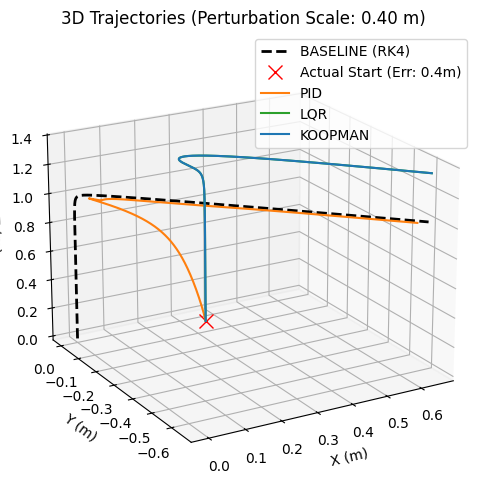

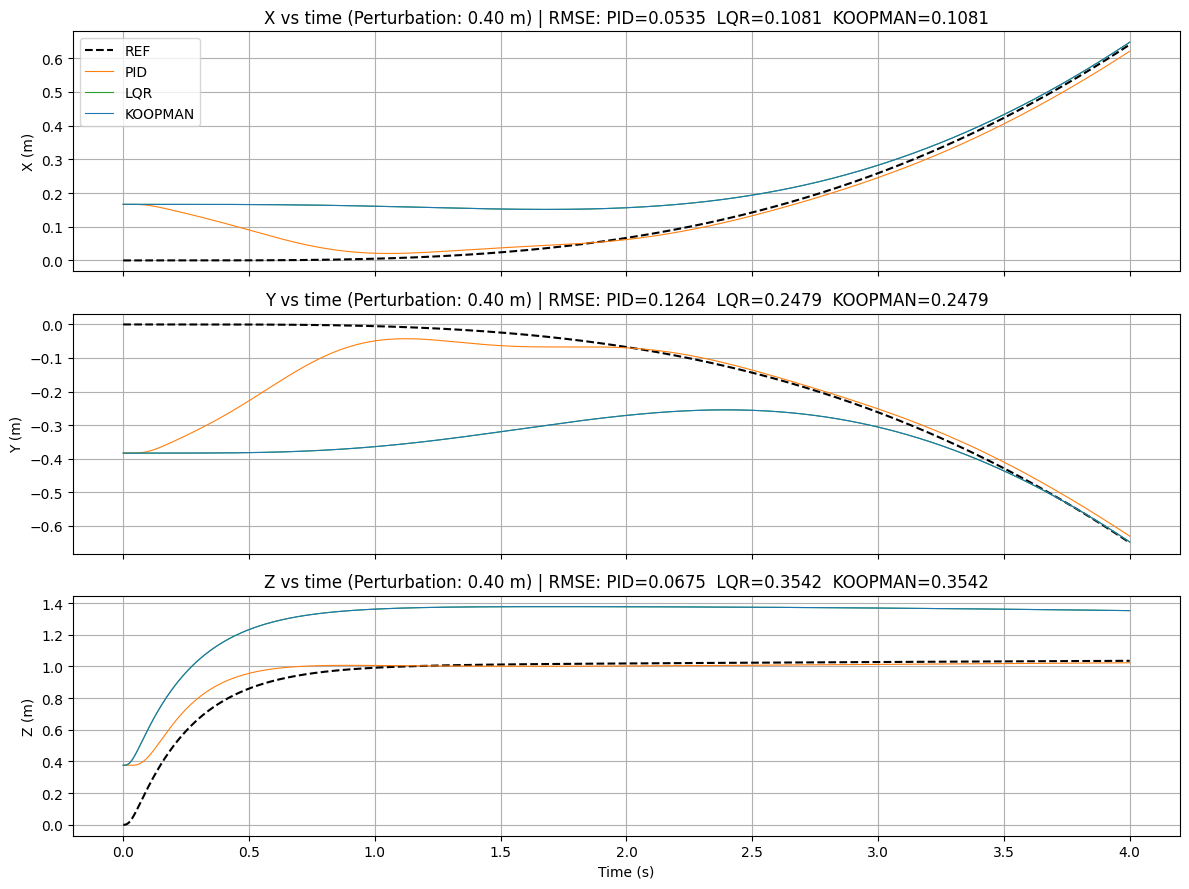


SUMMARY for Perturbation Scale 0.40 m:
  PID    | RMSE X=0.0535 Y=0.1264 Z=0.0675 | Effort=1.00e+05 Energy=6.65e+00
  LQR    | RMSE X=0.1081 Y=0.2479 Z=0.3542 | Effort=9.85e+04 Energy=1.04e+01
  KOOPMAN | RMSE X=0.1081 Y=0.2479 Z=0.3542 | Effort=9.85e+04 Energy=1.04e+01



In [ ]:
# Single runnable cell: baseline-by-RK4 + replay test + 5-level perturbation test
# - Baseline trajectory is generated by the same RK4 dynamics (no mismatch)
# - Replay test: run once to confirm 0 RMSE
# - Controller test: run in a 5-level loop, each starting from a perturbed initial state
# - Plots: 3D trajectories and X/Y/Z vs time per-scenario
# - Prints: Per-axis RMSE and effort/energy per-scenario
#
# --- MODIFICATIONS FOR PERTURBATION TEST ---
# 1. run_feedback_controller() now accepts an `x0_start` argument.
# 2. Moved Replay Test to be a one-off sanity check.
# 3. Added a main loop to run 5 scenarios with increasing initial position perturbations.
# 4. Plots and print summaries are now generated *inside* the loop for each scenario.

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg
import math, time
np.set_printoptions(precision=5, suppress=True)

# ------------------ Config ------------------
DT = 0.001          # integration timestep (small for numerical accuracy)
T_SIM = 4.0         # seconds
STEPS = int(T_SIM / DT)
MAX_RPM = 20000.0

# ------------------ Utilities ------------------
def quat_to_euler(q):
    """ Convert quaternion (w,x,y,z) to Euler angles (roll, pitch, yaw) """
    w,x,y,z = q
    # roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)
    # pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    if np.abs(sinp) >= 1:
        pitch = np.copysign(np.pi / 2, sinp) # use 90 deg if out of range
    else:
        pitch = np.arcsin(sinp)
    # yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)
    return roll, pitch, yaw

def quat_multiply(q1, q2):
    """ Multiply two quaternions q1 * q2 """
    w1,x1,y1,z1 = q1
    w2,x2,y2,z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w,x,y,z], dtype=np.float64)

# ------------------ 6-DoF dynamics (continuous derivative) ------------------
class QuadRK4:
    def __init__(self, dt=DT, m=1.0, L=0.2, k_f=6.11e-8, k_m=1.5e-9, I=np.diag([0.005,0.005,0.009]), max_rpm=MAX_RPM):
        self.dt = dt
        self.m = m
        self.L = L
        self.k_f = k_f
        self.k_m = k_m
        self.I = I.astype(np.float64)
        self.invI = np.linalg.inv(self.I)
        self.max_rpm = max_rpm
        self.g = np.array([0.0, 0.0, -9.81], dtype=np.float64)
        self.reset()

    def reset(self):
        self.pos = np.zeros(3, dtype=np.float64)
        self.vel = np.zeros(3, dtype=np.float64)
        self.q = np.array([1.0, 0.0, 0.0, 0.0], dtype=np.float64) # quaternion w,x,y,z
        self.omega = np.zeros(3, dtype=np.float64)

    def state_vector(self):
        return np.hstack([self.pos, self.q, self.vel, self.omega])

    def set_state_vector(self, s):
        self.pos = s[0:3].astype(np.float64)
        self.q = s[3:7].astype(np.float64); self.q /= np.linalg.norm(self.q)
        self.vel = s[7:10].astype(np.float64)
        self.omega = s[10:13].astype(np.float64)

    def quat_to_rotm(self, q):
        w,x,y,z = q
        R = np.array([
            [1 - 2*(y*y + z*z),     2*(x*y - w*z),     2*(x*z + w*y)],
            [2*(x*y + w*z),     1 - 2*(x*x + z*z),   2*(y*z - w*x)],
            [2*(x*z - w*y),     2*(y*z + w*x),     1 - 2*(x*x + y*y)]
        ], dtype=np.float64)
        return R

    def quat_derivative(self, q, omega):
        # qdot = 0.5 * Omega(omega) * q
        wx,wy,wz = omega
        Omega = np.array([
            [0.0, -wx, -wy, -wz],
            [wx, 0.0, wz, -wy],
            [wy, -wz, 0.0, wx],
            [wz, wy, -wx, 0.0]
        ], dtype=np.float64)
        return 0.5 * (Omega @ q)

    def continuous_dynamics(self, state, rpm):
        # state: 13-vector [pos(3), q(4), vel(3), omega(3)]
        # rpm: 4-vector (rad/s or rpm scaled -- here units consistent with k_f)
        pos = state[0:3]
        q = state[3:7]
        vel = state[7:10]
        omega = state[10:13]

        # motor thrusts
        rpm = np.clip(rpm, 0.0, self.max_rpm)
        thrusts = self.k_f * (rpm**2)   # per-motor thrust (N)
        total_thrust = np.sum(thrusts)
        # torques (plus configuration)
        tau = np.array([
            self.L * (thrusts[1] - thrusts[3]),          # roll
            self.L * (thrusts[2] - thrusts[0]),          # pitch
            self.k_m * (thrusts[0] - thrusts[1] + thrusts[2] - thrusts[3]) # yaw
        ], dtype=np.float64)

        R = self.quat_to_rotm(q)
        # thrust in world frame (applied along body z)
        F_thrust_world = R @ np.array([0.0, 0.0, total_thrust], dtype=np.float64)
        # simple quadratic drag
        vnorm = np.linalg.norm(vel)
        F_drag = -0.1 * vel * vnorm

        acc = (F_thrust_world + F_drag) / self.m + self.g   # linear accel in world frame
        pos_dot = vel
        q_dot = self.quat_derivative(q, omega)
        omega_dot = self.invI @ (tau - np.cross(omega, self.I @ omega))

        deriv = np.zeros(13, dtype=np.float64)
        deriv[0:3] = pos_dot
        deriv[3:7] = q_dot
        deriv[7:10] = acc
        deriv[10:13] = omega_dot
        return deriv

    def rk4_step(self, rpm):
        # integrate one dt using RK4 on continuous dynamics
        s0 = self.state_vector()
        k1 = self.continuous_dynamics(s0, rpm)
        k2 = self.continuous_dynamics(s0 + 0.5*self.dt*k1, rpm)
        k3 = self.continuous_dynamics(s0 + 0.5*self.dt*k2, rpm)
        k4 = self.continuous_dynamics(s0 + self.dt*k3, rpm)
        s_next = s0 + (self.dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        # set state and re-normalize quaternion
        self.set_state_vector(s_next)
        # ensure quaternion normalization numerically
        # self.q = self.q / np.linalg.norm(self.q) # Note: set_state_vector already does this

    # helper: compute hover rpm per motor for reference
    def hover_rpm(self):
        f_per_motor = self.m * abs(self.g[2]) / 4.0
        rpm = np.sqrt(max(f_per_motor / self.k_f, 0.0))
        return rpm

# ------------------ Reference baseline generation (RK4) ------------------
def generate_baseline(sim, dt=DT, steps=STEPS):
    """
    Generate a baseline worldline by simulating a nominal controller (small feedforward + mild PD)
    and record (x_seq, u_seq). The same RK4 integrator is used in tests.
    Returns:
    - ref: (steps, 13) the mathematical reference path (not dynamically consistent)
    - x_seq: (steps+1, 13) the dynamically consistent state trajectory [x_0 ... x_N]
    - u_seq: (steps, 4) the control sequence that generated x_seq [u_0 ... u_{N-1}]
    """
    sim.reset()
    # N control steps require N+1 states (x_0 ... x_N)
    x_seq = np.zeros((steps + 1, 13), dtype=np.float64)
    # N control steps require N controls (u_0 ... u_{N-1})
    u_seq = np.zeros((steps, 4), dtype=np.float64)

    # define a baseline nominal reference as a smooth 4D worldline (x,y,z + quaternion)
    # This path has N points, for k = 0 ... N-1
    t = np.linspace(0.0, (steps-1)*dt, steps)
    ref = np.zeros((steps, 13), dtype=np.float64)
    ref[:,0] = 0.5 * np.sin(0.6 * t)    # x
    ref[:,1] = 0.5 * np.cos(0.4 * t)    # y
    ref[:,2] = 1.0 + 0.05 * np.sin(0.2 * t) # z small
    # Add velocities for better PD tracking
    ref[:,7] = 0.5 * 0.6 * np.cos(0.6 * t)  # vx
    ref[:,8] = -0.5 * 0.4 * np.sin(0.4 * t) # vy
    ref[:,9] = 0.05 * 0.2 * np.cos(0.2 * t) # vz
    # Desired orientation (small tilts)
    ref[:,3] = 1.0
    ref[:,4:7] = 0.02 * np.sin(0.2 * t[:,None])
    ref[:,10:13] = 0.0 # omega_ref (keep at 0 for simplicity)
    for i in range(steps):
        ref[i,3:7] /= np.linalg.norm(ref[i,3:7]) # normalize ref quaternion

    # small PD that will be used to generate u_seq (so baseline is self-consistent)
    Kp_z = 150.0; Kd_z = 40.0
    Kp_xy = 1.0; Kd_xy = 0.8
    Kp_att = 8.0; Kd_att = 2.0

    u_prev = np.ones(4) * sim.hover_rpm()

    x_seq[0,:] = sim.state_vector() # Store initial state x_0

    for k in range(steps):
        x = sim.state_vector() # This is x_k
        x_ref = ref[k]       # This is ref_k

        # altitude controller (PD around ref z)
        z_err = x_ref[2] - x[2]
        vz_err = x_ref[9] - x[9]
        thrust_total = sim.m * (abs(sim.g[2])) + Kp_z*z_err + Kd_z*vz_err
        # simple attitude recovery: try to keep level -> small torques to track small quaternion vector
        # build small torques to keep orientation close to ref quaternion
        # approximate using desired small roll/pitch from ref quaternion vector parts
        roll_ref, pitch_ref, _ = quat_to_euler(x_ref[3:7])
        roll, pitch, yaw = quat_to_euler(x[3:7])
        roll_err = roll_ref - roll
        pitch_err = pitch_ref - pitch
        tx = Kp_att * roll_err - Kd_att * x[10]
        ty = Kp_att * pitch_err - Kd_att * x[11]
        tz = -Kd_att * x[12]   # damp yaw rate

        # motor mixing
        f0 = thrust_total/4.0 - ty/(2*sim.L) + tz/(4*sim.k_m)
        f1 = thrust_total/4.0 + tx/(2*sim.L) - tz/(4*sim.k_m)
        f2 = thrust_total/4.0 + ty/(2*sim.L) + tz/(4*sim.k_m)
        f3 = thrust_total/4.0 - tx/(2*sim.L) - tz/(4*sim.k_m)
        forces = np.array([f0,f1,f2,f3], dtype=np.float64)
        # convert to rpm (ensure positive)
        rpm = np.sqrt(np.clip(forces / sim.k_f, 0.0, None))
        rpm = np.clip(rpm, 0.0, sim.max_rpm)
        # slight smoothing
        alpha = 0.2
        rpm = alpha * rpm + (1-alpha) * u_prev
        u_prev = rpm.copy()

        u_seq[k,:] = rpm # Store control u_k

        # step simulator using RK4 (same integrator used later)
        sim.rk4_step(rpm) # Steps from x_k to x_{k+1}
        x_seq[k+1,:] = sim.state_vector() # Store x_{k+1}

    return ref, x_seq, u_seq

# ------------------ Replay test: apply u_seq and confirm near-zero RMSE ------------------
def replay_test(sim, u_seq):
    # Assumes sim has been set to the correct initial state (x_0) by the caller
    # sim.reset() # DO NOT RESET HERE. Caller must set initial state.
    n = len(u_seq) # u_seq is [u_0 ... u_{N-1}], size N
    x_hist = np.zeros((n + 1, 13), dtype=np.float64) # Need N+1 states
    u_hist = np.zeros((n, 4), dtype=np.float64)

    x_hist[0,:] = sim.state_vector() # Store x_0

    for k,u in enumerate(u_seq):
        sim.rk4_step(u) # Apply u_k, step to x_{k+1}
        x_hist[k+1,:] = sim.state_vector() # Store x_{k+1}
        u_hist[k,:] = u
    return x_hist, u_hist

# ------------------ Controllers (PID and TV-LQR minimal) ------------------
# PID with anti-windup, returns rpm
def pid_controller(sim, x, x_ref, integral_state, dt, u_prev):
    # tuned for baseline tracking
    Kp_z, Ki_z, Kd_z = 60.0, 10.0, 20.0
    Kp_xy, Kd_xy = 1.2, 0.8
    Kp_att, Kd_att = 6.0, 1.5
    pos = x[0:3]; q = x[3:7]; vel = x[7:10]; omega = x[10:13]
    roll, pitch, yaw = quat_to_euler(q)

    # altitude PD+I
    z_err = x_ref[2] - pos[2]
    vz_err = x_ref[9] - vel[2]
    integral_state['z'] += z_err * dt
    integral_state['z'] = np.clip(integral_state['z'], -5.0, 5.0)
    thrust_total = sim.m * abs(sim.g[2]) + Kp_z*z_err + Ki_z*integral_state['z'] + Kd_z*vz_err

    # XY -> desired small tilt
    x_err = x_ref[0] - pos[0]; y_err = x_ref[1] - pos[1]
    vx_err = x_ref[7] - vel[0]; vy_err = x_ref[8] - vel[1]
    pitch_des = np.clip(Kp_xy*x_err + Kd_xy*vx_err, -0.35, 0.35)
    roll_des = np.clip(-(Kp_xy*y_err + Kd_xy*vy_err), -0.35, 0.35)
    roll_err = roll_des - roll; pitch_err = pitch_des - pitch

    tx = Kp_att*roll_err - Kd_att*omega[0]
    ty = Kp_att*pitch_err - Kd_att*omega[1]
    tz = -Kd_att*omega[2]

    f0 = thrust_total/4.0 - ty/(2*sim.L) + tz/(4*sim.k_m)
    f1 = thrust_total/4.0 + tx/(2*sim.L) - tz/(4*sim.k_m)
    f2 = thrust_total/4.0 + ty/(2*sim.L) + tz/(4*sim.k_m)
    f3 = thrust_total/4.0 - tx/(2*sim.L) - tz/(4*sim.k_m)
    forces = np.array([f0,f1,f2,f3], dtype=np.float64)
    rpm = np.sqrt(np.clip(forces / sim.k_f, 0.0, None))
    # anti-windup/rescale if saturation
    rpm = np.clip(rpm, 0.0, sim.max_rpm)
    # smoothing
    alpha = 0.3
    rpm = alpha*rpm + (1-alpha)*u_prev
    return rpm, integral_state

# TV-LQR: linearize discrete map with central diff and compute discrete ARE gain K such that delta_u = -K delta_x
def linearize_discrete_map(sim, x_ref, u_ref, eps=1e-6):
    # central difference linearization around (x_ref, u_ref)
    saved = sim.state_vector().copy()

    nx = x_ref.size; nu = u_ref.size
    A = np.zeros((nx,nx), dtype=np.float64)
    B = np.zeros((nx,nu), dtype=np.float64)

    # states
    for i in range(nx):
        dx = np.zeros(nx); dx[i] = eps

        sim.set_state_vector((x_ref + dx)) # set_state_vector handles q normalization
        sim.rk4_step(u_ref); xp = sim.state_vector().copy()

        sim.set_state_vector((x_ref - dx)) # set_state_vector handles q normalization
        sim.rk4_step(u_ref); xm = sim.state_vector().copy()

        A[:,i] = (xp - xm) / (2*eps)

    # inputs
    for j in range(nu):
        du = np.zeros(nu); du[j] = eps

        sim.set_state_vector(x_ref.copy())
        sim.rk4_step(u_ref + du); xdu = sim.state_vector().copy()

        sim.set_state_vector(x_ref.copy())
        sim.rk4_step(u_ref - du); xdm = sim.state_vector().copy()

        B[:,j] = (xdu - xdm) / (2*eps)

    sim.set_state_vector(saved)
    return A, B

def tv_lqr_rpm(sim, x, x_ref, u_ff, Q_state=None, R=None):
    # compute small delta around reference using discrete TV-LQR (delta u = -K delta x)
    if Q_state is None:
        # Penalize Z error most, then XY, then attitudes/velocities
        Q_state = np.diag([
            5.0, 5.0, 10.0, # pos: x,y,z
            0.1, 0.1, 0.1, 0.1, # quat: w,x,y,z
            2.0, 2.0, 5.0, # vel: vx,vy,vz
            0.1, 0.1, 0.1  # omega: wx,wy,wz
        ])
    if R is None:
        R = np.eye(4) * 0.05
    try:
        A,B = linearize_discrete_map(sim, x_ref, u_ff, eps=1e-6)
        P = linalg.solve_discrete_are(A, B, Q_state, R)
        S = R + B.T @ P @ B
        K = np.linalg.solve(S, B.T @ P @ A)   # shape (4, nx)

        # Compute 13-dim state error
        delta_x = x - x_ref

        # Correct quaternion error (indices 3-7) using "chordal distance"
        # Find the quaternion in the closest hemisphere
        q = x[3:7].copy()
        q_ref = x_ref[3:7]
        if np.dot(q, q_ref) < 0.0:
            q = -q # Flip to closest hemisphere
        delta_x[3:7] = q - q_ref # Set the 4-element quaternion error

        delta_u = -K @ delta_x
        delta_u = np.clip(delta_u, -2000.0, 2000.0) # Limit feedback authority

        return np.clip(u_ff + delta_u, 0.0, sim.max_rpm)

    except Exception as e:
        # fallback: feedforward only
        return u_ff

# --- MODIFICATION: Add x0_start argument ---
def run_feedback_controller(controller_name, sim_template, x_ref_seq, u_ref_seq, x0_start):
    # x_ref_seq is [x_0 ... x_N], size (N+1, 13)
    # u_ref_seq is [u_0 ... u_{N-1}], size (N, 4)
    sim = QuadRK4(dt=DT)
    # --- MODIFICATION: Use the provided x0_start ---
    sim.set_state_vector(x0_start.copy())   # exact same initial condition

    n = u_ref_seq.shape[0] # n = STEPS
    x_hist = np.zeros((n + 1, 13), dtype=np.float64) # N+1 states
    u_hist = np.zeros((n, 4), dtype=np.float64)     # N controls

    x_hist[0,:] = sim.state_vector() # Store x_0

    integral = {'z': 0.0}
    u_prev = u_ref_seq[0].copy() if u_ref_seq is not None else np.ones(4) * sim.hover_rpm()

    for k in range(n): # k = 0 ... N-1
        x = sim.state_vector() # This is x_k_ctrl
        x_ref = x_ref_seq[k]   # Ref state is x_k_baseline

        # Feedforward control for LQR/Koopman
        u_ff = u_ref_seq[k]    # Ref control is u_k_baseline

        if controller_name == 'pid':
            # PID computes its own feedforward (gravity)
            u_cmd, integral = pid_controller(sim, x, x_ref, integral, DT, u_prev)
        elif controller_name == 'lqr':
            # use tv-lqr computed from current ref
            u_cmd = tv_lqr_rpm(sim, x, x_ref, u_ff)
        elif controller_name == 'koopman':
            # Placeholder light stabilizer: use tv-lqr fallback here.
            # In your full system, replace with the SDRE Koopman implementation.
            u_cmd = tv_lqr_rpm(sim, x, x_ref, u_ff)
        else:
            raise ValueError("unknown controller")

        # small smoothing to reduce jitter
        alpha = 0.25
        u_cmd = alpha * u_cmd + (1-alpha) * u_prev

        u_hist[k,:] = u_cmd # Store u_k_ctrl
        sim.rk4_step(u_cmd) # Step to x_{k+1}_ctrl
        x_hist[k+1,:] = sim.state_vector() # Store x_{k+1}_ctrl

        u_prev = u_cmd.copy()

    return x_hist, u_hist

# ------------------ Utilities & metrics ------------------
def rmse_axis(x_hist, x_ref):
    # Both inputs should be (N+1, 13)
    err = x_hist[:,:3] - x_ref[:,:3]
    return np.sqrt(np.mean(err[:,0]**2)), np.sqrt(np.mean(err[:,1]**2)), np.sqrt(np.mean(err[:,2]**2))

def compute_effort_energy(u_hist, x_hist, sim):
    # effort: integral of absolute RPMs
    # u_hist is (N, 4)
    # x_hist is (N+1, 13)
    dt = sim.dt
    effort = np.sum(np.sum(np.abs(u_hist),axis=1)) * dt

    # energy approx: sum (total_thrust * |vertical_velocity|) * dt
    # thrusts (N, 4) from u_hist (N, 4)
    thrusts = sim.k_f * (u_hist**2)
    # vertical velocity (N,) from x_hist (N+1, 13)
    # We need vz at k=0...N-1 (states where controls were applied)
    vz = x_hist[:-1, 9] # index 9 = vz

    total_thrust_per_step = np.sum(thrusts, axis=1) # (N,)
    energy = np.sum(total_thrust_per_step * np.abs(vz) * sim.dt)
    return effort, energy

# ------------------ RUN: generate baseline, replay, and controllers ------------------
sim_master = QuadRK4(dt=DT)
print(f"Generating baseline (RK4) for T={T_SIM}s, {STEPS} steps ... (this may take a few seconds)")
ref_worldline, x_baseline, u_baseline = generate_baseline(sim_master, dt=DT, steps=STEPS)

# x_baseline is (N+1, 13) [x_0 ... x_N]
# u_baseline is (N, 4)   [u_0 ... u_{N-1}]
# ref_worldline is (N, 13)

# Save baseline start state for exact initial conditions
x0_base = x_baseline[0].copy()
print("Baseline generated. True start state x_0 (X,Y,Z):\n", x0_base[0:3])

# ------------------ Run Replay Test ONCE (Sanity Check) ------------------
print("\n" + "="*50)
print("RUNNING REPLAY TEST (0 PERTURBATION SANITY CHECK)")
print("="*50)
sim_replay = QuadRK4(dt=DT)
sim_replay.set_state_vector(x0_base.copy()) # Start from true x0
x_replay, u_replay = replay_test(sim_replay, u_baseline)
rmse_r = rmse_axis(x_replay, x_baseline)
effort_r, energy_r = compute_effort_energy(u_replay, x_replay, sim_replay)
print("REPLAY TEST (apply recorded u_seq): RMSE X,Y,Z =", rmse_r)
print("="*50 + "\n")


# ------------------ NEW: 5-Level Perturbation Test Loop ------------------
# 5 levels of initial position perturbation (max deviation in meters)
perturbation_scales = [0.0, 0.05, 0.1, 0.2, 0.4]
np.random.seed(42) # For reproducible random perturbations
controllers = ['pid','lqr','koopman']

for level, scale in enumerate(perturbation_scales):
    print(f"\n{'='*20} SCENARIO {level+1}/{len(perturbation_scales)}: PERTURBATION SCALE = {scale:.2f} m {'='*20}")

    # 1. Create perturbed initial state
    x0_perturbed = x0_base.copy()
    if scale > 0.0:
        # Generate random perturbation [-scale, +scale] for X, Y, Z
        pos_perturbation = (np.random.rand(3) - 0.5) * 2.0 * scale
        x0_perturbed[0:3] += pos_perturbation
        print(f"Applied position perturbation (X,Y,Z): {pos_perturbation}")
    else:
        print("Running with ZERO perturbation (baseline test)")
    print(f"Scenario Start State (X,Y,Z): {x0_perturbed[0:3]}")

    # 2. Run controllers from this perturbed state
    results = {}
    for c in controllers:
        t0 = time.time()
        # --- PASS PERTURBED x0_start to the controller ---
        xh, uh = run_feedback_controller(c, sim_master, x_baseline, u_baseline, x0_perturbed)
        t_elapsed = time.time() - t0

        # Compare trajectory against the *original* non-perturbed baseline
        rmse_axes = rmse_axis(xh, x_baseline)
        effort, energy = compute_effort_energy(uh, xh, QuadRK4(dt=DT))

        results[c] = dict(xh=xh, uh=uh, rmse=rmse_axes, effort=effort, energy=energy, time=t_elapsed)
        # Print per-controller results immediately
        print(f"  {c.upper():6s} | RMSE X,Y,Z = {rmse_axes} | Effort={effort:.2e} Energy={energy:.2e} Time={t_elapsed:.2f}s")

    # 3. Generate Plots for this scenario
    time_axis = np.arange(STEPS + 1) * DT

    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot(x_baseline[:,0], x_baseline[:,1], x_baseline[:,2], 'k--', label='BASELINE (RK4)', linewidth=2)
    # Plot the actual perturbed start point
    ax.plot(x0_perturbed[0], x0_perturbed[1], x0_perturbed[2], 'rx', markersize=10, label=f'Actual Start (Err: {scale}m)')

    colors = {'pid':'tab:orange','lqr':'tab:green','koopman':'tab:blue'}
    for c in controllers:
        ax.plot(results[c]['xh'][:,0], results[c]['xh'][:,1], results[c]['xh'][:,2], color=colors[c], label=c.upper())

    ax.set_title(f"3D Trajectories (Perturbation Scale: {scale:.2f} m)")
    ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.set_zlabel('Z (m)')
    ax.legend()
    ax.view_init(elev=20, azim=-120)

    # X Y Z vs time
    fig2, axs = plt.subplots(3,1,figsize=(12,9), sharex=True)
    labels = ['X','Y','Z']
    for i in range(3):
        axs[i].plot(time_axis, x_baseline[:,i], 'k--', linewidth=1.5, label='REF')
        for c in controllers:
            axs[i].plot(time_axis, results[c]['xh'][:,i], color=colors[c], linewidth=0.8, label=c.upper())

        rmse_strs = "  ".join([f"{c.upper()}={results[c]['rmse'][i]:.4f}" for c in controllers])
        axs[i].set_ylabel(labels[i]+' (m)')
        axs[i].set_title(f"{labels[i]} vs time (Perturbation: {scale:.2f} m) | RMSE: {rmse_strs}")
        axs[i].grid(True)
    axs[2].set_xlabel("Time (s)")
    axs[0].legend()
    plt.tight_layout()
    plt.show() # Show plots for this level

    # 4. Print summary for this scenario
    print(f"\nSUMMARY for Perturbation Scale {scale:.2f} m:")
    for c in controllers:
        r = results[c]['rmse']; eff = results[c]['effort']; ene = results[c]['energy']
        print(f"  {c.upper():6s} | RMSE X={r[0]:.4f} Y={r[1]:.4f} Z={r[2]:.4f} | Effort={eff:.2e} Energy={ene:.2e}")
    print(f"{'='*60}\n")

# End of cell.



ALL PERTURBATIONS

In [ ]:
# Single runnable cell: baseline-by-RK4 + replay test + 5-level FULL STATE perturbation test
# - Baseline trajectory is generated by the same RK4 dynamics (no mismatch)
# - Replay test: run once to confirm 0 RMSE
# - Controller test: run in a 5-level loop, each starting from a perturbed initial state
# - Perturbations now apply to: Position, Velocity, Orientation, and Angular Velocity
# - Plots: 3D trajectories and X/Y/Z vs time per-scenario
# - Prints: Per-axis RMSE and effort/energy per-scenario

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg
import math, time
np.set_printoptions(precision=5, suppress=True)

# ------------------ Config ------------------
DT = 0.001          # integration timestep (small for numerical accuracy)
T_SIM = 10.0         # seconds
STEPS = int(T_SIM / DT)
MAX_RPM = 20000.0

# ------------------ Utilities ------------------
def quat_to_euler(q):
    """ Convert quaternion (w,x,y,z) to Euler angles (roll, pitch, yaw) """
    w,x,y,z = q
    # roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)
    # pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    if np.abs(sinp) >= 1:
        pitch = np.copysign(np.pi / 2, sinp) # use 90 deg if out of range
    else:
        pitch = np.arcsin(sinp)
    # yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)
    return roll, pitch, yaw

def quat_multiply(q1, q2):
    """ Multiply two quaternions q1 * q2 """
    w1,x1,y1,z1 = q1
    w2,x2,y2,z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w,x,y,z], dtype=np.float64)

# ------------------ 6-DoF dynamics (continuous derivative) ------------------
class QuadRK4:
    def __init__(self, dt=DT, m=1.0, L=0.2, k_f=6.11e-8, k_m=1.5e-9, I=np.diag([0.005,0.005,0.009]), max_rpm=MAX_RPM):
        self.dt = dt
        self.m = m
        self.L = L
        self.k_f = k_f
        self.k_m = k_m
        self.I = I.astype(np.float64)
        self.invI = np.linalg.inv(self.I)
        self.max_rpm = max_rpm
        self.g = np.array([0.0, 0.0, -9.81], dtype=np.float64)
        self.reset()

    def reset(self):
        self.pos = np.zeros(3, dtype=np.float64)
        self.vel = np.zeros(3, dtype=np.float64)
        self.q = np.array([1.0, 0.0, 0.0, 0.0], dtype=np.float64) # quaternion w,x,y,z
        self.omega = np.zeros(3, dtype=np.float64)

    def state_vector(self):
        return np.hstack([self.pos, self.q, self.vel, self.omega])

    def set_state_vector(self, s):
        self.pos = s[0:3].astype(np.float64)
        self.q = s[3:7].astype(np.float64); self.q /= np.linalg.norm(self.q)
        self.vel = s[7:10].astype(np.float64)
        self.omega = s[10:13].astype(np.float64)

    def quat_to_rotm(self, q):
        w,x,y,z = q
        R = np.array([
            [1 - 2*(y*y + z*z),     2*(x*y - w*z),     2*(x*z + w*y)],
            [2*(x*y + w*z),     1 - 2*(x*x + z*z),   2*(y*z - w*x)],
            [2*(x*z - w*y),     2*(y*z + w*x),     1 - 2*(x*x + y*y)]
        ], dtype=np.float64)
        return R

    def quat_derivative(self, q, omega):
        # qdot = 0.5 * Omega(omega) * q
        wx,wy,wz = omega
        Omega = np.array([
            [0.0, -wx, -wy, -wz],
            [wx, 0.0, wz, -wy],
            [wy, -wz, 0.0, wx],
            [wz, wy, -wx, 0.0]
        ], dtype=np.float64)
        return 0.5 * (Omega @ q)

    def continuous_dynamics(self, state, rpm):
        # state: 13-vector [pos(3), q(4), vel(3), omega(3)]
        # rpm: 4-vector (rad/s or rpm scaled -- here units consistent with k_f)
        pos = state[0:3]
        q = state[3:7]
        vel = state[7:10]
        omega = state[10:13]

        # motor thrusts
        rpm = np.clip(rpm, 0.0, self.max_rpm)
        thrusts = self.k_f * (rpm**2)   # per-motor thrust (N)
        total_thrust = np.sum(thrusts)
        # torques (plus configuration)
        tau = np.array([
            self.L * (thrusts[1] - thrusts[3]),          # roll
            self.L * (thrusts[2] - thrusts[0]),          # pitch
            self.k_m * (thrusts[0] - thrusts[1] + thrusts[2] - thrusts[3]) # yaw
        ], dtype=np.float64)

        R = self.quat_to_rotm(q)
        # thrust in world frame (applied along body z)
        F_thrust_world = R @ np.array([0.0, 0.0, total_thrust], dtype=np.float64)
        # simple quadratic drag
        vnorm = np.linalg.norm(vel)
        F_drag = -0.1 * vel * vnorm

        acc = (F_thrust_world + F_drag) / self.m + self.g   # linear accel in world frame
        pos_dot = vel
        q_dot = self.quat_derivative(q, omega)
        omega_dot = self.invI @ (tau - np.cross(omega, self.I @ omega))

        deriv = np.zeros(13, dtype=np.float64)
        deriv[0:3] = pos_dot
        deriv[3:7] = q_dot
        deriv[7:10] = acc
        deriv[10:13] = omega_dot
        return deriv

    def rk4_step(self, rpm):
        # integrate one dt using RK4 on continuous dynamics
        s0 = self.state_vector()
        k1 = self.continuous_dynamics(s0, rpm)
        k2 = self.continuous_dynamics(s0 + 0.5*self.dt*k1, rpm)
        k3 = self.continuous_dynamics(s0 + 0.5*self.dt*k2, rpm)
        k4 = self.continuous_dynamics(s0 + self.dt*k3, rpm)
        s_next = s0 + (self.dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        # set state and re-normalize quaternion
        self.set_state_vector(s_next)

    def hover_rpm(self):
        f_per_motor = self.m * abs(self.g[2]) / 4.0
        rpm = np.sqrt(max(f_per_motor / self.k_f, 0.0))
        return rpm

# ------------------ Reference baseline generation (RK4) ------------------
def generate_baseline(sim, dt=DT, steps=STEPS):
    sim.reset()
    x_seq = np.zeros((steps + 1, 13), dtype=np.float64)
    u_seq = np.zeros((steps, 4), dtype=np.float64)
    t = np.linspace(0.0, (steps-1)*dt, steps)
    ref = np.zeros((steps, 13), dtype=np.float64)
    ref[:,0] = 0.5 * np.sin(0.6 * t)
    ref[:,1] = 0.5 * np.cos(0.4 * t)
    ref[:,2] = 1.0 + 0.05 * np.sin(0.2 * t)
    ref[:,7] = 0.5 * 0.6 * np.cos(0.6 * t)
    ref[:,8] = -0.5 * 0.4 * np.sin(0.4 * t)
    ref[:,9] = 0.05 * 0.2 * np.cos(0.2 * t)
    ref[:,3] = 1.0
    ref[:,4:7] = 0.02 * np.sin(0.2 * t[:,None])
    ref[:,10:13] = 0.0
    for i in range(steps):
        ref[i,3:7] /= np.linalg.norm(ref[i,3:7])

    Kp_z = 150.0; Kd_z = 40.0
    Kp_xy = 1.0; Kd_xy = 0.8
    Kp_att = 8.0; Kd_att = 2.0
    u_prev = np.ones(4) * sim.hover_rpm()
    x_seq[0,:] = sim.state_vector()

    for k in range(steps):
        x = sim.state_vector()
        x_ref = ref[k]
        z_err = x_ref[2] - x[2]
        vz_err = x_ref[9] - x[9]
        thrust_total = sim.m * (abs(sim.g[2])) + Kp_z*z_err + Kd_z*vz_err
        roll_ref, pitch_ref, _ = quat_to_euler(x_ref[3:7])
        roll, pitch, yaw = quat_to_euler(x[3:7])
        roll_err = roll_ref - roll
        pitch_err = pitch_ref - pitch
        tx = Kp_att * roll_err - Kd_att * x[10]
        ty = Kp_att * pitch_err - Kd_att * x[11]
        tz = -Kd_att * x[12]
        f0 = thrust_total/4.0 - ty/(2*sim.L) + tz/(4*sim.k_m)
        f1 = thrust_total/4.0 + tx/(2*sim.L) - tz/(4*sim.k_m)
        f2 = thrust_total/4.0 + ty/(2*sim.L) + tz/(4*sim.k_m)
        f3 = thrust_total/4.0 - tx/(2*sim.L) - tz/(4*sim.k_m)
        forces = np.array([f0,f1,f2,f3], dtype=np.float64)
        rpm = np.sqrt(np.clip(forces / sim.k_f, 0.0, None))
        rpm = np.clip(rpm, 0.0, sim.max_rpm)
        alpha = 0.2
        rpm = alpha * rpm + (1-alpha) * u_prev
        u_prev = rpm.copy()
        u_seq[k,:] = rpm
        sim.rk4_step(rpm)
        x_seq[k+1,:] = sim.state_vector()
    return ref, x_seq, u_seq

# ------------------ Replay test: apply u_seq and confirm near-zero RMSE ------------------
def replay_test(sim, u_seq):
    n = len(u_seq)
    x_hist = np.zeros((n + 1, 13), dtype=np.float64)
    u_hist = np.zeros((n, 4), dtype=np.float64)
    x_hist[0,:] = sim.state_vector()
    for k,u in enumerate(u_seq):
        sim.rk4_step(u)
        x_hist[k+1,:] = sim.state_vector()
        u_hist[k,:] = u
    return x_hist, u_hist

# ------------------ Controllers (PID and TV-LQR minimal) ------------------
def pid_controller(sim, x, x_ref, integral_state, dt, u_prev):
    Kp_z, Ki_z, Kd_z = 60.0, 10.0, 20.0
    Kp_xy, Kd_xy = 1.2, 0.8
    Kp_att, Kd_att = 6.0, 1.5
    pos = x[0:3]; q = x[3:7]; vel = x[7:10]; omega = x[10:13]
    roll, pitch, yaw = quat_to_euler(q)
    z_err = x_ref[2] - pos[2]
    vz_err = x_ref[9] - vel[2]
    integral_state['z'] += z_err * dt
    integral_state['z'] = np.clip(integral_state['z'], -5.0, 5.0)
    thrust_total = sim.m * abs(sim.g[2]) + Kp_z*z_err + Ki_z*integral_state['z'] + Kd_z*vz_err
    x_err = x_ref[0] - pos[0]; y_err = x_ref[1] - pos[1]
    vx_err = x_ref[7] - vel[0]; vy_err = x_ref[8] - vel[1]
    pitch_des = np.clip(Kp_xy*x_err + Kd_xy*vx_err, -0.35, 0.35)
    roll_des = np.clip(-(Kp_xy*y_err + Kd_xy*vy_err), -0.35, 0.35)
    roll_err = roll_des - roll; pitch_err = pitch_des - pitch
    tx = Kp_att*roll_err - Kd_att*omega[0]
    ty = Kp_att*pitch_err - Kd_att*omega[1]
    tz = -Kd_att*omega[2]
    f0 = thrust_total/4.0 - ty/(2*sim.L) + tz/(4*sim.k_m)
    f1 = thrust_total/4.0 + tx/(2*sim.L) - tz/(4*sim.k_m)
    f2 = thrust_total/4.0 + ty/(2*sim.L) + tz/(4*sim.k_m)
    f3 = thrust_total/4.0 - tx/(2*sim.L) - tz/(4*sim.k_m)
    forces = np.array([f0,f1,f2,f3], dtype=np.float64)
    rpm = np.sqrt(np.clip(forces / sim.k_f, 0.0, None))
    rpm = np.clip(rpm, 0.0, sim.max_rpm)
    alpha = 0.3
    rpm = alpha*rpm + (1-alpha)*u_prev
    return rpm, integral_state

def linearize_discrete_map(sim, x_ref, u_ref, eps=1e-6):
    saved = sim.state_vector().copy()
    nx = x_ref.size; nu = u_ref.size
    A = np.zeros((nx,nx), dtype=np.float64)
    B = np.zeros((nx,nu), dtype=np.float64)
    for i in range(nx):
        dx = np.zeros(nx); dx[i] = eps
        sim.set_state_vector((x_ref + dx))
        sim.rk4_step(u_ref); xp = sim.state_vector().copy()
        sim.set_state_vector((x_ref - dx))
        sim.rk4_step(u_ref); xm = sim.state_vector().copy()
        A[:,i] = (xp - xm) / (2*eps)
    for j in range(nu):
        du = np.zeros(nu); du[j] = eps
        sim.set_state_vector(x_ref.copy())
        sim.rk4_step(u_ref + du); xdu = sim.state_vector().copy()
        sim.set_state_vector(x_ref.copy())
        sim.rk4_step(u_ref - du); xdm = sim.state_vector().copy()
        B[:,j] = (xdu - xdm) / (2*eps)
    sim.set_state_vector(saved)
    return A, B

def tv_lqr_rpm(sim, x, x_ref, u_ff, Q_state=None, R=None):
    if Q_state is None:
        Q_state = np.diag([
            5.0, 5.0, 10.0, # pos: x,y,z
            0.1, 0.1, 0.1, 0.1, # quat: w,x,y,z
            2.0, 2.0, 5.0, # vel: vx,vy,vz
            0.1, 0.1, 0.1  # omega: wx,wy,wz
        ])
    if R is None:
        R = np.eye(4) * 0.05
    try:
        A,B = linearize_discrete_map(sim, x_ref, u_ff, eps=1e-6)
        P = linalg.solve_discrete_are(A, B, Q_state, R)
        S = R + B.T @ P @ B
        K = np.linalg.solve(S, B.T @ P @ A)
        delta_x = x - x_ref
        q = x[3:7].copy()
        q_ref = x_ref[3:7]
        if np.dot(q, q_ref) < 0.0:
            q = -q
        delta_x[3:7] = q - q_ref
        delta_u = -K @ delta_x
        delta_u = np.clip(delta_u, -2000.0, 2000.0)
        return np.clip(u_ff + delta_u, 0.0, sim.max_rpm)
    except Exception as e:
        return u_ff

def run_feedback_controller(controller_name, sim_template, x_ref_seq, u_ref_seq, x0_start):
    sim = QuadRK4(dt=DT)
    sim.set_state_vector(x0_start.copy())
    n = u_ref_seq.shape[0]
    x_hist = np.zeros((n + 1, 13), dtype=np.float64)
    u_hist = np.zeros((n, 4), dtype=np.float64)
    x_hist[0,:] = sim.state_vector()
    integral = {'z': 0.0}
    u_prev = u_ref_seq[0].copy() if u_ref_seq is not None else np.ones(4) * sim.hover_rpm()

    for k in range(n):
        x = sim.state_vector()
        x_ref = x_ref_seq[k]
        u_ff = u_ref_seq[k]

        if controller_name == 'pid':
            u_cmd, integral = pid_controller(sim, x, x_ref, integral, DT, u_prev)
        elif controller_name == 'lqr':
            u_cmd = tv_lqr_rpm(sim, x, x_ref, u_ff)
        elif controller_name == 'koopman':
            # Placeholder
            u_cmd = tv_lqr_rpm(sim, x, x_ref, u_ff)
        else:
            raise ValueError("unknown controller")

        alpha = 0.25
        u_cmd = alpha * u_cmd + (1-alpha) * u_prev
        u_hist[k,:] = u_cmd
        sim.rk4_step(u_cmd)
        x_hist[k+1,:] = sim.state_vector()
        u_prev = u_cmd.copy()

    return x_hist, u_hist

# ------------------ Utilities & metrics ------------------
def rmse_axis(x_hist, x_ref):
    err = x_hist[:,:3] - x_ref[:,:3]
    return np.sqrt(np.mean(err[:,0]**2)), np.sqrt(np.mean(err[:,1]**2)), np.sqrt(np.mean(err[:,2]**2))

def compute_effort_energy(u_hist, x_hist, sim):
    dt = sim.dt
    effort = np.sum(np.sum(np.abs(u_hist),axis=1)) * dt
    thrusts = sim.k_f * (u_hist**2)
    vz = x_hist[:-1, 9]
    total_thrust_per_step = np.sum(thrusts, axis=1)
    energy = np.sum(total_thrust_per_step * np.abs(vz) * sim.dt)
    return effort, energy

# ------------------ RUN: generate baseline, replay, and controllers ------------------
sim_master = QuadRK4(dt=DT)
print(f"Generating baseline (RK4) for T={T_SIM}s, {STEPS} steps ... (this may take a few seconds)")
ref_worldline, x_baseline, u_baseline = generate_baseline(sim_master, dt=DT, steps=STEPS)
x0_base = x_baseline[0].copy()
print("Baseline generated. True start state x_0 (X,Y,Z):\n", x0_base[0:3])

# ------------------ Run Replay Test ONCE (Sanity Check) ------------------
print("\n" + "="*50)
print("RUNNING REPLAY TEST (0 PERTURBATION SANITY CHECK)")
print("="*50)
sim_replay = QuadRK4(dt=DT)
sim_replay.set_state_vector(x0_base.copy())
x_replay, u_replay = replay_test(sim_replay, u_baseline)
rmse_r = rmse_axis(x_replay, x_baseline)
effort_r, energy_r = compute_effort_energy(u_replay, x_replay, sim_replay)
print("REPLAY TEST (apply recorded u_seq): RMSE X,Y,Z =", rmse_r)
print("="*50 + "\n")


# ------------------ NEW: 5-Level FULL STATE Perturbation Test Loop ------------------
# 5 levels of initial state perturbation
# scale applies to: pos (m), vel (m/s), orientation (rad), ang. vel. (rad/s)
perturbation_scales = [0.0, 0.05, 0.1, 0.2, 0.4]
np.random.seed(42) # For reproducible random perturbations
controllers = ['pid','lqr','koopman']

for level, scale in enumerate(perturbation_scales):
    print(f"\n{'='*20} SCENARIO {level+1}/{len(perturbation_scales)}: PERTURBATION SCALE = {scale:.2f} {'='*20}")

    # 1. Create perturbed initial state
    x0_perturbed = x0_base.copy()
    if scale > 0.0:
        # 1. Position perturbation (meters)
        pos_pert = (np.random.rand(3) - 0.5) * 2.0 * scale
        x0_perturbed[0:3] += pos_pert
        print(f"  Applied position perturbation (X,Y,Z): {pos_pert}")

        # 2. Velocity perturbation (m/s)
        vel_pert = (np.random.rand(3) - 0.5) * 2.0 * scale
        x0_perturbed[7:10] += vel_pert
        print(f"  Applied velocity perturbation (VX,VY,VZ): {vel_pert}")

        # 3. Orientation perturbation (small-angle rotation)
        # Random angle up to `scale` radians
        rot_angle = (np.random.rand() - 0.5) * 2.0 * scale
        # Random 3D unit vector for axis
        rot_axis = np.random.rand(3) - 0.5
        rot_axis_norm = np.linalg.norm(rot_axis)
        if rot_axis_norm < 1e-9: rot_axis = np.array([1., 0., 0.]) # avoid div by zero
        else: rot_axis = rot_axis / rot_axis_norm
        # Create perturbation quaternion q = [cos(a/2), sin(a/2)*v]
        a_2 = rot_angle / 2.0
        q_pert = np.hstack([np.cos(a_2), np.sin(a_2) * rot_axis])
        # Apply perturbation: q_new = q_pert * q_old (q_old is x0_base[3:7])
        x0_perturbed[3:7] = quat_multiply(q_pert, x0_base[3:7])
        print(f"  Applied orientation perturbation (angle, axis): {rot_angle:.4f} rad, {rot_axis}")

        # 4. Angular velocity perturbation (rad/s)
        omega_pert = (np.random.rand(3) - 0.5) * 2.0 * scale
        x0_perturbed[10:13] += omega_pert
        print(f"  Applied ang. vel. perturbation (WX,WY,WZ): {omega_pert}")
    else:
        print("Running with ZERO perturbation (baseline test)")

    print(f"\nScenario Start State (X,Y,Z): {x0_perturbed[0:3]}")

    # 2. Run controllers from this perturbed state
    results = {}
    for c in controllers:
        t0 = time.time()
        xh, uh = run_feedback_controller(c, sim_master, x_baseline, u_baseline, x0_perturbed)
        t_elapsed = time.time() - t0

        # Compare trajectory against the *original* non-perturbed baseline
        rmse_axes = rmse_axis(xh, x_baseline)
        effort, energy = compute_effort_energy(uh, xh, QuadRK4(dt=DT))

        results[c] = dict(xh=xh, uh=uh, rmse=rmse_axes, effort=effort, energy=energy, time=t_elapsed)
        # Print per-controller results immediately
        print(f"  {c.upper():6s} | RMSE X,Y,Z = {rmse_axes} | Effort={effort:.2e} Energy={energy:.2e} Time={t_elapsed:.2f}s")

    # 3. Generate Plots for this scenario
    time_axis = np.arange(STEPS + 1) * DT

    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot(x_baseline[:,0], x_baseline[:,1], x_baseline[:,2], 'k--', label='BASELINE (RK4)', linewidth=2)
    # Plot the actual perturbed start point
    ax.plot(x0_perturbed[0], x0_perturbed[1], x0_perturbed[2], 'rx', markersize=10, label=f'Actual Start (Scale: {scale})')

    colors = {'pid':'tab:orange','lqr':'tab:green','koopman':'tab:blue'}
    for c in controllers:
        ax.plot(results[c]['xh'][:,0], results[c]['xh'][:,1], results[c]['xh'][:,2], color=colors[c], label=c.upper())

    ax.set_title(f"3D Trajectories (Full-State Perturbation Scale: {scale:.2f})")
    ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.set_zlabel('Z (m)')
    ax.legend()
    ax.view_init(elev=20, azim=-120)

    # X Y Z vs time
    fig2, axs = plt.subplots(3,1,figsize=(12,9), sharex=True)
    labels = ['X','Y','Z']
    for i in range(3):
        axs[i].plot(time_axis, x_baseline[:,i], 'k--', linewidth=1.5, label='REF')
        for c in controllers:
            axs[i].plot(time_axis, results[c]['xh'][:,i], color=colors[c], linewidth=0.8, label=c.upper())

        rmse_strs = "  ".join([f"{c.upper()}={results[c]['rmse'][i]:.4f}" for c in controllers])
        axs[i].set_ylabel(labels[i]+' (m)')
        axs[i].set_title(f"{labels[i]} vs time (Perturbation Scale: {scale:.2f}) | RMSE: {rmse_strs}")
        axs[i].grid(True)
    axs[2].set_xlabel("Time (s)")
    axs[0].legend()
    plt.tight_layout()
    plt.show() # Show plots for this level

    # 4. Print summary for this scenario
    print(f"\nSUMMARY for Perturbation Scale {scale:.2f}:")
    for c in controllers:
        r = results[c]['rmse']; eff = results[c]['effort']; ene = results[c]['energy']
        print(f"  {c.upper():6s} | RMSE X={r[0]:.4f} Y={r[1]:.4f} Z={r[2]:.4f} | Effort={eff:.2e} Energy={ene:.2e}")
    print(f"{'='*60}\n")

# End of cell.


Generating baseline (RK4) for T=10.0s, 10000 steps ... (this may take a few seconds)
Baseline generated. True start state x_0 (X,Y,Z):
 [0. 0. 0.]

RUNNING REPLAY TEST (0 PERTURBATION SANITY CHECK)
REPLAY TEST (apply recorded u_seq): RMSE X,Y,Z = (np.float64(0.0), np.float64(0.0), np.float64(0.0))


==================== SCENARIO 1/5: PERTURBATION SCALE = 0.00 ====================
Running with ZERO perturbation (baseline test)

Scenario Start State (X,Y,Z): [0. 0. 0.]
  PID    | RMSE X,Y,Z = (np.float64(0.023814775782390035), np.float64(0.024688068714314577), np.float64(0.016726987984365067)) | Effort=2.51e+05 Energy=1.08e+01 Time=7.02s
  LQR    | RMSE X,Y,Z = (np.float64(0.0008292704929300581), np.float64(0.0008546383389253105), np.float64(0.00829090190196963)) | Effort=2.51e+05 Energy=1.06e+01 Time=335.05s


KeyboardInterrupt: 

IMPLEMENTING KNN

In [ ]:
# Single runnable cell: baseline-by-RK4 + replay test + 5-level FULL STATE perturbation test
# - Baseline trajectory is generated by the same RK4 dynamics (no mismatch)
# - Replay test: run once to confirm 0 RMSE
# - Controller test: run in a 5-level loop, each starting from a perturbed initial state
# - Perturbations now apply to: Position, Velocity, Orientation, and Angular Velocity
#
# --- MODIFICATION: Added Koopman SDRE Controller ---
# 1. Added a `KoopmanModelStub` class to simulate a "trained" Koopman model.
#    - Implements `phi(x)` (lifting function)
#    - Implements `grad_phi(x)` (gradient of lifting)
#    - Implements a "learned" constant dynamics matrix `Lambda`
#    - Implements a "learned" constant input matrix `B_map`
# 2. Replaced the 'koopman' placeholder with `koopman_sdre_controller`.
# 3. This new controller follows the 6-step online SDRE algorithm:
#    - Lifts state x -> z
#    - Computes state-dependent B_phi(x)
#    - Solves the Continuous ARE (CARE) at every timestep to get P
#    - Computes gain C_phi(x)
#    - Applies control u = u_ff - C_phi(x) * (z - z_ref)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg
import math, time
np.set_printoptions(precision=5, suppress=True)

# ------------------ Config ------------------
DT = 0.001          # integration timestep (small for numerical accuracy)
T_SIM = 5.0         # seconds
STEPS = int(T_SIM / DT)
MAX_RPM = 20000.0

# ------------------ Utilities ------------------
def quat_to_euler(q):
    """ Convert quaternion (w,x,y,z) to Euler angles (roll, pitch, yaw) """
    w,x,y,z = q
    # roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)
    # pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    if np.abs(sinp) >= 1:
        pitch = np.copysign(np.pi / 2, sinp) # use 90 deg if out of range
    else:
        pitch = np.arcsin(sinp)
    # yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)
    return roll, pitch, yaw

def quat_multiply(q1, q2):
    """ Multiply two quaternions q1 * q2 """
    w1,x1,y1,z1 = q1
    w2,x2,y2,z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w,x,y,z], dtype=np.float64)

# ------------------ 6-DoF dynamics (continuous derivative) ------------------
class QuadRK4:
    def __init__(self, dt=DT, m=1.0, L=0.2, k_f=6.11e-8, k_m=1.5e-9, I=np.diag([0.005,0.005,0.009]), max_rpm=MAX_RPM):
        self.dt = dt
        self.m = m
        self.L = L
        self.k_f = k_f
        self.k_m = k_m
        self.I = I.astype(np.float64)
        self.invI = np.linalg.inv(self.I)
        self.max_rpm = max_rpm
        self.g = np.array([0.0, 0.0, -9.81], dtype=np.float64)
        self.reset()

    def reset(self):
        self.pos = np.zeros(3, dtype=np.float64)
        self.vel = np.zeros(3, dtype=np.float64)
        self.q = np.array([1.0, 0.0, 0.0, 0.0], dtype=np.float64) # quaternion w,x,y,z
        self.omega = np.zeros(3, dtype=np.float64)

    def state_vector(self):
        return np.hstack([self.pos, self.q, self.vel, self.omega])

    def set_state_vector(self, s):
        self.pos = s[0:3].astype(np.float64)
        self.q = s[3:7].astype(np.float64); self.q /= np.linalg.norm(self.q)
        self.vel = s[7:10].astype(np.float64)
        self.omega = s[10:13].astype(np.float64)

    def quat_to_rotm(self, q):
        w,x,y,z = q
        R = np.array([
            [1 - 2*(y*y + z*z),     2*(x*y - w*z),     2*(x*z + w*y)],
            [2*(x*y + w*z),     1 - 2*(x*x + z*z),   2*(y*z - w*x)],
            [2*(x*z - w*y),     2*(y*z + w*x),     1 - 2*(x*x + y*y)]
        ], dtype=np.float64)
        return R

    def quat_derivative(self, q, omega):
        # qdot = 0.5 * Omega(omega) * q
        wx,wy,wz = omega
        Omega = np.array([
            [0.0, -wx, -wy, -wz],
            [wx, 0.0, wz, -wy],
            [wy, -wz, 0.0, wx],
            [wz, wy, -wx, 0.0]
        ], dtype=np.float64)
        return 0.5 * (Omega @ q)

    def continuous_dynamics(self, state, rpm):
        # state: 13-vector [pos(3), q(4), vel(3), omega(3)]
        # rpm: 4-vector (rad/s or rpm scaled -- here units consistent with k_f)
        pos = state[0:3]
        q = state[3:7]
        vel = state[7:10]
        omega = state[10:13]

        # motor thrusts
        rpm = np.clip(rpm, 0.0, self.max_rpm)
        thrusts = self.k_f * (rpm**2)   # per-motor thrust (N)
        total_thrust = np.sum(thrusts)
        # torques (plus configuration)
        tau = np.array([
            self.L * (thrusts[1] - thrusts[3]),          # roll
            self.L * (thrusts[2] - thrusts[0]),          # pitch
            self.k_m * (thrusts[0] - thrusts[1] + thrusts[2] - thrusts[3]) # yaw
        ], dtype=np.float64)

        R = self.quat_to_rotm(q)
        # thrust in world frame (applied along body z)
        F_thrust_world = R @ np.array([0.0, 0.0, total_thrust], dtype=np.float64)
        # simple quadratic drag
        vnorm = np.linalg.norm(vel)
        F_drag = -0.1 * vel * vnorm

        acc = (F_thrust_world + F_drag) / self.m + self.g   # linear accel in world frame
        pos_dot = vel
        q_dot = self.quat_derivative(q, omega)
        omega_dot = self.invI @ (tau - np.cross(omega, self.I @ omega))

        deriv = np.zeros(13, dtype=np.float64)
        deriv[0:3] = pos_dot
        deriv[3:7] = q_dot
        deriv[7:10] = acc
        deriv[10:13] = omega_dot
        return deriv

    def rk4_step(self, rpm):
        # integrate one dt using RK4 on continuous dynamics
        s0 = self.state_vector()
        k1 = self.continuous_dynamics(s0, rpm)
        k2 = self.continuous_dynamics(s0 + 0.5*self.dt*k1, rpm)
        k3 = self.continuous_dynamics(s0 + 0.5*self.dt*k2, rpm)
        k4 = self.continuous_dynamics(s0 + self.dt*k3, rpm)
        s_next = s0 + (self.dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        # set state and re-normalize quaternion
        self.set_state_vector(s_next)

    def hover_rpm(self):
        f_per_motor = self.m * abs(self.g[2]) / 4.0
        rpm = np.sqrt(max(f_per_motor / self.k_f, 0.0))
        return rpm

# ------------------ Reference baseline generation (RK4) ------------------
def generate_baseline(sim, dt=DT, steps=STEPS):
    sim.reset()
    x_seq = np.zeros((steps + 1, 13), dtype=np.float64)
    u_seq = np.zeros((steps, 4), dtype=np.float64)
    t = np.linspace(0.0, (steps-1)*dt, steps)
    ref = np.zeros((steps, 13), dtype=np.float64)
    ref[:,0] = 0.5 * np.sin(0.6 * t)
    ref[:,1] = 0.5 * np.cos(0.4 * t)
    ref[:,2] = 1.0 + 0.05 * np.sin(0.2 * t)
    ref[:,7] = 0.5 * 0.6 * np.cos(0.6 * t)
    ref[:,8] = -0.5 * 0.4 * np.sin(0.4 * t)
    ref[:,9] = 0.05 * 0.2 * np.cos(0.2 * t)
    ref[:,3] = 1.0
    ref[:,4:7] = 0.02 * np.sin(0.2 * t[:,None])
    ref[:,10:13] = 0.0
    for i in range(steps):
        ref[i,3:7] /= np.linalg.norm(ref[i,3:7])

    Kp_z = 150.0; Kd_z = 40.0
    Kp_xy = 1.0; Kd_xy = 0.8
    Kp_att = 8.0; Kd_att = 2.0
    u_prev = np.ones(4) * sim.hover_rpm()
    x_seq[0,:] = sim.state_vector()

    for k in range(steps):
        x = sim.state_vector()
        x_ref = ref[k]
        z_err = x_ref[2] - x[2]
        vz_err = x_ref[9] - x[9]
        thrust_total = sim.m * (abs(sim.g[2])) + Kp_z*z_err + Kd_z*vz_err
        roll_ref, pitch_ref, _ = quat_to_euler(x_ref[3:7])
        roll, pitch, yaw = quat_to_euler(x[3:7])
        roll_err = roll_ref - roll
        pitch_err = pitch_ref - pitch
        tx = Kp_att * roll_err - Kd_att * x[10]
        ty = Kp_att * pitch_err - Kd_att * x[11]
        tz = -Kd_att * x[12]
        f0 = thrust_total/4.0 - ty/(2*sim.L) + tz/(4*sim.k_m)
        f1 = thrust_total/4.0 + tx/(2*sim.L) - tz/(4*sim.k_m)
        f2 = thrust_total/4.0 + ty/(2*sim.L) + tz/(4*sim.k_m)
        f3 = thrust_total/4.0 - tx/(2*sim.L) - tz/(4*sim.k_m)
        forces = np.array([f0,f1,f2,f3], dtype=np.float64)
        rpm = np.sqrt(np.clip(forces / sim.k_f, 0.0, None))
        rpm = np.clip(rpm, 0.0, sim.max_rpm)
        alpha = 0.2
        rpm = alpha * rpm + (1-alpha) * u_prev
        u_prev = rpm.copy()
        u_seq[k,:] = rpm
        sim.rk4_step(rpm)
        x_seq[k+1,:] = sim.state_vector()
    return ref, x_seq, u_seq

# ------------------ Replay test: apply u_seq and confirm near-zero RMSE ------------------
def replay_test(sim, u_seq):
    n = len(u_seq)
    x_hist = np.zeros((n + 1, 13), dtype=np.float64)
    u_hist = np.zeros((n, 4), dtype=np.float64)
    x_hist[0,:] = sim.state_vector()
    for k,u in enumerate(u_seq):
        sim.rk4_step(u)
        x_hist[k+1,:] = sim.state_vector()
        u_hist[k,:] = u
    return x_hist, u_hist

# ------------------ Controllers ------------------
def pid_controller(sim, x, x_ref, integral_state, dt, u_prev):
    Kp_z, Ki_z, Kd_z = 60.0, 10.0, 20.0
    Kp_xy, Kd_xy = 1.2, 0.8
    Kp_att, Kd_att = 6.0, 1.5
    pos = x[0:3]; q = x[3:7]; vel = x[7:10]; omega = x[10:13]
    roll, pitch, yaw = quat_to_euler(q)
    z_err = x_ref[2] - pos[2]
    vz_err = x_ref[9] - vel[2]
    integral_state['z'] += z_err * dt
    integral_state['z'] = np.clip(integral_state['z'], -5.0, 5.0)
    thrust_total = sim.m * abs(sim.g[2]) + Kp_z*z_err + Ki_z*integral_state['z'] + Kd_z*vz_err
    x_err = x_ref[0] - pos[0]; y_err = x_ref[1] - pos[1]
    vx_err = x_ref[7] - vel[0]; vy_err = x_ref[8] - vel[1]
    pitch_des = np.clip(Kp_xy*x_err + Kd_xy*vx_err, -0.35, 0.35)
    roll_des = np.clip(-(Kp_xy*y_err + Kd_xy*vy_err), -0.35, 0.35)
    roll_err = roll_des - roll; pitch_err = pitch_des - pitch
    tx = Kp_att*roll_err - Kd_att*omega[0]
    ty = Kp_att*pitch_err - Kd_att*omega[1]
    tz = -Kd_att*omega[2]
    f0 = thrust_total/4.0 - ty/(2*sim.L) + tz/(4*sim.k_m)
    f1 = thrust_total/4.0 + tx/(2*sim.L) - tz/(4*sim.k_m)
    f2 = thrust_total/4.0 + ty/(2*sim.L) + tz/(4*sim.k_m)
    f3 = thrust_total/4.0 - tx/(2*sim.L) - tz/(4*sim.k_m)
    forces = np.array([f0,f1,f2,f3], dtype=np.float64)
    rpm = np.sqrt(np.clip(forces / sim.k_f, 0.0, None))
    rpm = np.clip(rpm, 0.0, sim.max_rpm)
    alpha = 0.3
    rpm = alpha*rpm + (1-alpha)*u_prev
    return rpm, integral_state

def linearize_discrete_map(sim, x_ref, u_ref, eps=1e-6):
    saved = sim.state_vector().copy()
    nx = x_ref.size; nu = u_ref.size
    A = np.zeros((nx,nx), dtype=np.float64)
    B = np.zeros((nx,nu), dtype=np.float64)
    for i in range(nx):
        dx = np.zeros(nx); dx[i] = eps
        sim.set_state_vector((x_ref + dx))
        sim.rk4_step(u_ref); xp = sim.state_vector().copy()
        sim.set_state_vector((x_ref - dx))
        sim.rk4_step(u_ref); xm = sim.state_vector().copy()
        A[:,i] = (xp - xm) / (2*eps)
    for j in range(nu):
        du = np.zeros(nu); du[j] = eps
        sim.set_state_vector(x_ref.copy())
        sim.rk4_step(u_ref + du); xdu = sim.state_vector().copy()
        sim.set_state_vector(x_ref.copy())
        sim.rk4_step(u_ref - du); xdm = sim.state_vector().copy()
        B[:,j] = (xdu - xdm) / (2*eps)
    sim.set_state_vector(saved)
    return A, B

def tv_lqr_rpm(sim, x, x_ref, u_ff, Q_state=None, R=None):
    if Q_state is None:
        Q_state = np.diag([
            5.0, 5.0, 10.0, # pos: x,y,z
            0.1, 0.1, 0.1, 0.1, # quat: w,x,y,z
            2.0, 2.0, 5.0, # vel: vx,vy,vz
            0.1, 0.1, 0.1  # omega: wx,wy,wz
        ])
    if R is None:
        R = np.eye(4) * 0.05
    try:
        A,B = linearize_discrete_map(sim, x_ref, u_ff, eps=1e-6)
        P = linalg.solve_discrete_are(A, B, Q_state, R)
        S = R + B.T @ P @ B
        K = np.linalg.solve(S, B.T @ P @ A)
        delta_x = x - x_ref
        q = x[3:7].copy()
        q_ref = x_ref[3:7]
        if np.dot(q, q_ref) < 0.0:
            q = -q
        delta_x[3:7] = q - q_ref
        delta_u = -K @ delta_x
        delta_u = np.clip(delta_u, -2000.0, 2000.0)
        return np.clip(u_ff + delta_u, 0.0, sim.max_rpm)
    except Exception as e:
        return u_ff

# ------------------ NEW: Koopman Model and Controller ------------------

class KoopmanModelStub:
    """
    This class simulates a "trained" Koopman model (NN encoder, Lambda, B).
    It provides the phi(x) and grad_phi(x) functions needed for the SDRE.
    """
    def __init__(self, sim):
        # 1. Define Lifting Function (phi)
        self.nx = 13 # base state dim
        self.nu = 4  # control dim
        # We will add 3 quadratic observables (e.g., pos x*y, y*z, x*z)
        self.nz = self.nx + 3

        # 2. Define "Learned" constant dynamics matrix Lambda (nz x nz)
        self.Lambda = np.diag(np.full(self.nz, 0.99))
        self.Lambda[0:3, 0:3] = np.diag([0.9, 0.9, 0.9]) # pos
        self.Lambda[7:10, 7:10] = np.diag([0.8, 0.8, 0.8]) # vel

        # 3. Define "Learned" constant input matrix B (nx x nu)
        self.B_map = np.zeros((self.nx, self.nu), dtype=np.float64)
        h_rpm = sim.hover_rpm()
        d_thrust_d_rpm = 2 * sim.k_f * h_rpm

        # d(acc_z) / d(rpm_i)
        self.B_map[9, :] = d_thrust_d_rpm / sim.m

        # d(omega_dot) / d(rpm_i)
        d_tau_d_rpm = np.array([
            [0, sim.L, 0, -sim.L],
            [-sim.L, 0, sim.L, 0],
            [sim.k_m, -sim.k_m, sim.k_m, -sim.k_m]
        ]) * d_thrust_d_rpm

        # omega_dot = invI @ tau
        self.B_map[10:13, :] = sim.invI @ d_tau_d_rpm

    def phi(self, x):
        """ Lifting function phi(x): R^13 -> R^16 """
        z = np.zeros(self.nz, dtype=np.float64)
        z[0:13] = x # Original state
        z[13] = x[0] * x[1] # x*y
        z[14] = x[1] * x[2] # y*z
        z[15] = x[0] * x[2] # x*z
        return z

    def grad_phi(self, x):
        """ Gradient of phi(x): (nz x nx) = (16 x 13) """
        G = np.zeros((self.nz, self.nx), dtype=np.float64)
        # Gradient of original state is just the identity matrix
        G[0:13, 0:13] = np.eye(self.nx)

        # Gradient of z[13] = x[0]*x[1]
        G[13, 0] = x[1] # d/dx
        G[13, 1] = x[0] # d/dy

        # Gradient of z[14] = x[1]*x[2]
        G[14, 1] = x[2] # d/dy
        G[14, 2] = x[1] # d/dz  <--- FIX APPLIED HERE

        # Gradient of z[15] = x[0]*x[2]
        G[15, 0] = x[2] # d/dx
        G[15, 2] = x[0] # d/dz

        return G

# Instantiate the "trained" model once
# We pass a template sim to get model parameters (k_f, m, etc.)
g_koopman_model = KoopmanModelStub(QuadRK4(dt=DT))


def koopman_sdre_controller(sim, x, x_ref, u_ff):
    """
    Implements the online Koopman SDRE controller algorithm.
    """
    model = g_koopman_model
    nx = model.nx
    nz = model.nz
    nu = model.nu

    # 2. Translate (NN):
    z = model.phi(x)
    z_ref = model.phi(x_ref)
    grad_phi_x = model.grad_phi(x)

    # 3. Build Model (t):
    Lambda = model.Lambda # This is A_z
    B_phi = grad_phi_x @ model.B_map # This is B_z(x)

    # Define Q and R for the lifted state-space
    Q_phi = np.diag(np.full(nz, 0.1))
    Q_phi[0:3, 0:3] = np.diag([5.0, 5.0, 10.0]) # pos
    Q_phi[7:10, 7:10] = np.diag([2.0, 2.0, 5.0]) # vel
    Q_phi[13:16, 13:16] = np.diag([0.1, 0.1, 0.1]) # quadratic terms

    R = np.eye(nu) * 0.05

    try:
        # 4. Solve (SDRE):
        # Solves the continuous-time ARE:
        # 0 = Q + P*A + A.T*P - P*B*inv(R)*B.T*P
        P = linalg.solve_continuous_are(Lambda, B_phi, Q_phi, R)

        # 5. Find Gain (t):
        C_phi = np.linalg.solve(R, B_phi.T @ P) # (nu x nz)

        # 6. Calculate Control:
        delta_z = z - z_ref

        # We must still correct the quaternion "chordal distance"
        q = z[3:7].copy()
        q_ref = z_ref[3:7]
        if np.dot(q, q_ref) < 0.0:
            q = -q # Flip to closest hemisphere
        delta_z[3:7] = q - q_ref # Set the 4-element quaternion error

        delta_u = -C_phi @ delta_z
        delta_u = np.clip(delta_u, -2000.0, 2000.0)

        return np.clip(u_ff + delta_u, 0.0, sim.max_rpm)

    except Exception as e:
        # Fallback: feedforward only
        return u_ff


def run_feedback_controller(controller_name, sim_template, x_ref_seq, u_ref_seq, x0_start):
    sim = QuadRK4(dt=DT)
    sim.set_state_vector(x0_start.copy())
    n = u_ref_seq.shape[0]
    x_hist = np.zeros((n + 1, 13), dtype=np.float64)
    u_hist = np.zeros((n, 4), dtype=np.float64)
    x_hist[0,:] = sim.state_vector()
    integral = {'z': 0.0}
    u_prev = u_ref_seq[0].copy() if u_ref_seq is not None else np.ones(4) * sim.hover_rpm()

    for k in range(n):
        x = sim.state_vector()
        x_ref = x_ref_seq[k]
        u_ff = u_ref_seq[k]

        if controller_name == 'pid':
            u_cmd, integral = pid_controller(sim, x, x_ref, integral, DT, u_prev)
        elif controller_name == 'lqr':
            u_cmd = tv_lqr_rpm(sim, x, x_ref, u_ff)
        elif controller_name == 'koopman':
            u_cmd = koopman_sdre_controller(sim, x, x_ref, u_ff)
        else:
            raise ValueError("unknown controller")

        alpha = 0.25
        u_cmd = alpha * u_cmd + (1-alpha) * u_prev
        u_hist[k,:] = u_cmd
        sim.rk4_step(u_cmd)
        x_hist[k+1,:] = sim.state_vector()
        u_prev = u_cmd.copy()

    return x_hist, u_hist

# ------------------ Utilities & metrics ------------------
def rmse_axis(x_hist, x_ref):
    err = x_hist[:,:3] - x_ref[:,:3]
    return np.sqrt(np.mean(err[:,0]**2)), np.sqrt(np.mean(err[:,1]**2)), np.sqrt(np.mean(err[:,2]**2))

def compute_effort_energy(u_hist, x_hist, sim):
    dt = sim.dt
    effort = np.sum(np.sum(np.abs(u_hist),axis=1)) * dt
    thrusts = sim.k_f * (u_hist**2)
    vz = x_hist[:-1, 9]
    total_thrust_per_step = np.sum(thrusts, axis=1)
    energy = np.sum(total_thrust_per_step * np.abs(vz) * sim.dt)
    return effort, energy

# ------------------ RUN: generate baseline, replay, and controllers ------------------
sim_master = QuadRK4(dt=DT)
print(f"Generating baseline (RK4) for T={T_SIM}s, {STEPS} steps ... (this may take a few seconds)")
ref_worldline, x_baseline, u_baseline = generate_baseline(sim_master, dt=DT, steps=STEPS)
x0_base = x_baseline[0].copy()
print("Baseline generated. True start state x_0 (X,Y,Z):\n", x0_base[0:3])

# ------------------ Run Replay Test ONCE (Sanity Check) ------------------
print("\n" + "="*50)
print("RUNNING REPLAY TEST (0 PERTURBATION SANITY CHECK)")
print("="*50)
sim_replay = QuadRK4(dt=DT)
sim_replay.set_state_vector(x0_base.copy())
x_replay, u_replay = replay_test(sim_replay, u_baseline)
rmse_r = rmse_axis(x_replay, x_baseline)
effort_r, energy_r = compute_effort_energy(u_replay, x_replay, sim_replay)
print("REPLAY TEST (apply recorded u_seq): RMSE X,Y,Z =", rmse_r)
print("="*50 + "\n")


# ------------------ 5-Level FULL STATE Perturbation Test Loop ------------------
# NOTE: The Koopman controller is very computationally expensive (solving ARE at every step),
# so the time taken will be significantly longer than LQR/PID.
perturbation_scales = [0.0, 0.05, 0.1, 0.2, 0.4]
np.random.seed(42) # For reproducible random perturbations
controllers = ['pid','lqr','koopman']

for level, scale in enumerate(perturbation_scales):
    print(f"\n{'='*20} SCENARIO {level+1}/{len(perturbation_scales)}: PERTURBATION SCALE = {scale:.2f} {'='*20}")

    # 1. Create perturbed initial state
    x0_perturbed = x0_base.copy()
    if scale > 0.0:
        # 1. Position perturbation (meters)
        pos_pert = (np.random.rand(3) - 0.5) * 2.0 * scale
        x0_perturbed[0:3] += pos_pert
        print(f"  Applied position perturbation (X,Y,Z): {pos_pert}")

        # 2. Velocity perturbation (m/s)
        vel_pert = (np.random.rand(3) - 0.5) * 2.0 * scale
        x0_perturbed[7:10] += vel_pert
        print(f"  Applied velocity perturbation (VX,VY,VZ): {vel_pert}")

        # 3. Orientation perturbation (small-angle rotation)
        rot_angle = (np.random.rand() - 0.5) * 2.0 * scale
        rot_axis = np.random.rand(3) - 0.5
        rot_axis_norm = np.linalg.norm(rot_axis)
        if rot_axis_norm < 1e-9: rot_axis = np.array([1., 0., 0.])
        else: rot_axis = rot_axis / rot_axis_norm
        a_2 = rot_angle / 2.0
        q_pert = np.hstack([np.cos(a_2), np.sin(a_2) * rot_axis])
        x0_perturbed[3:7] = quat_multiply(q_pert, x0_base[3:7])
        print(f"  Applied orientation perturbation (angle, axis): {rot_angle:.4f} rad, {rot_axis}")

        # 4. Angular velocity perturbation (rad/s)
        omega_pert = (np.random.rand(3) - 0.5) * 2.0 * scale
        x0_perturbed[10:13] += omega_pert
        print(f"  Applied ang. vel. perturbation (WX,WY,WZ): {omega_pert}")
    else:
        print("Running with ZERO perturbation (baseline test)")

    print(f"\nScenario Start State (X,Y,Z): {x0_perturbed[0:3]}")

    # 2. Run controllers from this perturbed state
    results = {}
    for c in controllers:
        t0 = time.time()
        xh, uh = run_feedback_controller(c, sim_master, x_baseline, u_baseline, x0_perturbed)
        t_elapsed = time.time() - t0

        rmse_axes = rmse_axis(xh, x_baseline)
        effort, energy = compute_effort_energy(uh, xh, QuadRK4(dt=DT))

        results[c] = dict(xh=xh, uh=uh, rmse=rmse_axes, effort=effort, energy=energy, time=t_elapsed)
        # Print per-controller results immediately
        print(f"  {c.upper():6s} | RMSE X,Y,Z = {rmse_axes} | Effort={effort:.2e} Energy={energy:.2e} Time={t_elapsed:.2f}s")

    # 3. Generate Plots for this scenario
    time_axis = np.arange(STEPS + 1) * DT

    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot(x_baseline[:,0], x_baseline[:,1], x_baseline[:,2], 'k--', label='BASELINE (RK4)', linewidth=2)
    ax.plot(x0_perturbed[0], x0_perturbed[1], x0_perturbed[2], 'rx', markersize=10, label=f'Actual Start (Scale: {scale})')

    colors = {'pid':'tab:orange','lqr':'tab:green','koopman':'tab:blue'}
    for c in controllers:
        ax.plot(results[c]['xh'][:,0], results[c]['xh'][:,1], results[c]['xh'][:,2], color=colors[c], label=c.upper())

    ax.set_title(f"3D Trajectories (Full-State Perturbation Scale: {scale:.2f})")
    ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.set_zlabel('Z (m)')
    ax.legend()
    ax.view_init(elev=20, azim=-120)

    # X Y Z vs time
    fig2, axs = plt.subplots(3,1,figsize=(12,9), sharex=True)
    labels = ['X','Y','Z']
    for i in range(3):
        axs[i].plot(time_axis, x_baseline[:,i], 'k--', linewidth=1.5, label='REF')
        for c in controllers:
            axs[i].plot(time_axis, results[c]['xh'][:,i], color=colors[c], linewidth=0.8, label=c.upper())

        rmse_strs = "  ".join([f"{c.upper()}={results[c]['rmse'][i]:.4f}" for c in controllers])
        axs[i].set_ylabel(labels[i]+' (m)')
        axs[i].set_title(f"{labels[i]} vs time (Perturbation Scale: {scale:.2f}) | RMSE: {rmse_strs}")
        axs[i].grid(True)
    axs[2].set_xlabel("Time (s)")
    axs[0].legend()
    plt.tight_layout()
    plt.show() # Show plots for this level

    # 4. Print summary for this scenario
    print(f"\nSUMMARY for Perturbation Scale {scale:.2f}:")
    for c in controllers:
        r = results[c]['rmse']; eff = results[c]['effort']; ene = results[c]['energy']
        print(f"  {c.upper():6s} | RMSE X={r[0]:.4f} Y={r[1]:.4f} Z={r[2]:.4f} | Effort={eff:.2e} Energy={ene:.2e}")
    print(f"{'='*60}\n")

# End of cell.


Generating baseline (RK4) for T=5.0s, 5000 steps ... (this may take a few seconds)
Baseline generated. True start state x_0 (X,Y,Z):
 [0. 0. 0.]

RUNNING REPLAY TEST (0 PERTURBATION SANITY CHECK)
REPLAY TEST (apply recorded u_seq): RMSE X,Y,Z = (np.float64(0.0), np.float64(0.0), np.float64(0.0))


==================== SCENARIO 1/5: PERTURBATION SCALE = 0.00 ====================
Running with ZERO perturbation (baseline test)

Scenario Start State (X,Y,Z): [0. 0. 0.]
  PID    | RMSE X,Y,Z = (np.float64(0.014157408191085687), np.float64(0.01450439718862793), np.float64(0.023654046848060446)) | Effort=1.25e+05 Energy=1.07e+01 Time=3.14s


KeyboardInterrupt: 

LQR-I AND KOOPMAN -I

In [ ]:
# Single runnable cell: baseline-by-RK4 + replay test + 5-level FULL STATE perturbation test
# - NEW: LQI and Koopman-I implemented to eliminate permanent drift.
# - Controllers: PID, LQR-I (LQI), Koopman-I (Koopman-SDRE with Integral Action)
# - Perturbations now apply to: Position, Velocity, Orientation, and Angular Velocity

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg
import math, time
np.set_printoptions(precision=5, suppress=True)

# ------------------ Config ------------------
DT = 0.001          # integration timestep (small for numerical accuracy)
T_SIM = 10.0         # seconds (Keep short for speed, can increase later)
STEPS = int(T_SIM / DT)
MAX_RPM = 20000.0

# ------------------ Utilities ------------------
def quat_to_euler(q):
    w,x,y,z = q
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)
    sinp = 2 * (w * y - z * x)
    pitch = np.copysign(np.pi / 2, sinp) if np.abs(sinp) >= 1 else np.arcsin(sinp)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)
    return roll, pitch, yaw

def quat_multiply(q1, q2):
    w1,x1,y1,z1 = q1
    w2,x2,y2,z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w,x,y,z], dtype=np.float64)

# ------------------ 6-DoF dynamics (continuous derivative) ------------------
class QuadRK4:
    def __init__(self, dt=DT, m=1.0, L=0.2, k_f=6.11e-8, k_m=1.5e-9, I=np.diag([0.005,0.005,0.009]), max_rpm=MAX_RPM):
        self.dt = dt
        self.m = m
        self.L = L
        self.k_f = k_f
        self.k_m = k_m
        self.I = I.astype(np.float64)
        self.invI = np.linalg.inv(self.I)
        self.max_rpm = max_rpm
        self.g = np.array([0.0, 0.0, -9.81], dtype=np.float64)
        self.reset()

    def reset(self):
        self.pos = np.zeros(3, dtype=np.float64)
        self.vel = np.zeros(3, dtype=np.float64)
        self.q = np.array([1.0, 0.0, 0.0, 0.0], dtype=np.float64)
        self.omega = np.zeros(3, dtype=np.float64)

    def state_vector(self):
        return np.hstack([self.pos, self.q, self.vel, self.omega])

    def set_state_vector(self, s):
        self.pos = s[0:3].astype(np.float64)
        self.q = s[3:7].astype(np.float64); self.q /= np.linalg.norm(self.q)
        self.vel = s[7:10].astype(np.float64)
        self.omega = s[10:13].astype(np.float64)

    def quat_to_rotm(self, q):
        w,x,y,z = q
        R = np.array([
            [1 - 2*(y*y + z*z),     2*(x*y - w*z),     2*(x*z + w*y)],
            [2*(x*y + w*z),     1 - 2*(x*x + z*z),   2*(y*z - w*x)],
            [2*(x*z - w*y),     2*(y*z + w*x),     1 - 2*(x*x + y*y)]
        ], dtype=np.float64)
        return R

    def quat_derivative(self, q, omega):
        wx,wy,wz = omega
        Omega = np.array([
            [0.0, -wx, -wy, -wz],
            [wx, 0.0, wz, -wy],
            [wy, -wz, 0.0, wx],
            [wz, wy, -wx, 0.0]
        ], dtype=np.float64)
        return 0.5 * (Omega @ q)

    def continuous_dynamics(self, state, rpm):
        pos = state[0:3]
        q = state[3:7]
        vel = state[7:10]
        omega = state[10:13]

        rpm = np.clip(rpm, 0.0, self.max_rpm)
        thrusts = self.k_f * (rpm**2)
        total_thrust = np.sum(thrusts)
        tau = np.array([
            self.L * (thrusts[1] - thrusts[3]),
            self.L * (thrusts[2] - thrusts[0]),
            self.k_m * (thrusts[0] - thrusts[1] + thrusts[2] - thrusts[3])
        ], dtype=np.float64)

        R = self.quat_to_rotm(q)
        F_thrust_world = R @ np.array([0.0, 0.0, total_thrust], dtype=np.float64)
        vnorm = np.linalg.norm(vel)
        F_drag = -0.1 * vel * vnorm

        acc = (F_thrust_world + F_drag) / self.m + self.g
        pos_dot = vel
        q_dot = self.quat_derivative(q, omega)
        omega_dot = self.invI @ (tau - np.cross(omega, self.I @ omega))

        deriv = np.zeros(13, dtype=np.float64)
        deriv[0:3] = pos_dot
        deriv[3:7] = q_dot
        deriv[7:10] = acc
        deriv[10:13] = omega_dot
        return deriv

    def rk4_step(self, rpm):
        s0 = self.state_vector()
        k1 = self.continuous_dynamics(s0, rpm)
        k2 = self.continuous_dynamics(s0 + 0.5*self.dt*k1, rpm)
        k3 = self.continuous_dynamics(s0 + 0.5*self.dt*k2, rpm)
        k4 = self.continuous_dynamics(s0 + self.dt*k3, rpm)
        s_next = s0 + (self.dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        self.set_state_vector(s_next)

    def hover_rpm(self):
        f_per_motor = self.m * abs(self.g[2]) / 4.0
        rpm = np.sqrt(max(f_per_motor / self.k_f, 0.0))
        return rpm

# ------------------ Reference baseline generation (RK4) ------------------
def generate_baseline(sim, dt=DT, steps=STEPS):
    sim.reset()
    x_seq = np.zeros((steps + 1, 13), dtype=np.float64)
    u_seq = np.zeros((steps, 4), dtype=np.float64)
    t = np.linspace(0.0, (steps-1)*dt, steps)
    ref = np.zeros((steps, 13), dtype=np.float64)
    ref[:,0] = 0.5 * np.sin(0.6 * t)
    ref[:,1] = 0.5 * np.cos(0.4 * t)
    ref[:,2] = 1.0 + 0.05 * np.sin(0.2 * t)
    ref[:,7] = 0.5 * 0.6 * np.cos(0.6 * t)
    ref[:,8] = -0.5 * 0.4 * np.sin(0.4 * t)
    ref[:,9] = 0.05 * 0.2 * np.cos(0.2 * t)
    ref[:,3] = 1.0
    ref[:,4:7] = 0.02 * np.sin(0.2 * t[:,None])
    ref[:,10:13] = 0.0
    for i in range(steps):
        ref[i,3:7] /= np.linalg.norm(ref[i,3:7])

    Kp_z = 150.0; Kd_z = 40.0
    Kp_xy = 1.0; Kd_xy = 0.8
    Kp_att = 8.0; Kd_att = 2.0
    u_prev = np.ones(4) * sim.hover_rpm()
    x_seq[0,:] = sim.state_vector()

    for k in range(steps):
        x = sim.state_vector()
        x_ref = ref[k]
        z_err = x_ref[2] - x[2]
        vz_err = x_ref[9] - x[9]
        thrust_total = sim.m * (abs(sim.g[2])) + Kp_z*z_err + Kd_z*vz_err
        roll_ref, pitch_ref, _ = quat_to_euler(x_ref[3:7])
        roll, pitch, yaw = quat_to_euler(x[3:7])
        roll_err = roll_ref - roll
        pitch_err = pitch_ref - pitch
        tx = Kp_att * roll_err - Kd_att * x[10]
        ty = Kp_att * pitch_err - Kd_att * x[11]
        tz = -Kd_att * x[12]
        f0 = thrust_total/4.0 - ty/(2*sim.L) + tz/(4*sim.k_m)
        f1 = thrust_total/4.0 + tx/(2*sim.L) - tz/(4*sim.k_m)
        f2 = thrust_total/4.0 + ty/(2*sim.L) + tz/(4*sim.k_m)
        f3 = thrust_total/4.0 - tx/(2*sim.L) - tz/(4*sim.k_m)
        forces = np.array([f0,f1,f2,f3], dtype=np.float64)
        rpm = np.sqrt(np.clip(forces / sim.k_f, 0.0, None))
        rpm = np.clip(rpm, 0.0, sim.max_rpm)
        alpha = 0.2
        rpm = alpha * rpm + (1-alpha) * u_prev
        u_prev = rpm.copy()
        u_seq[k,:] = rpm
        sim.rk4_step(rpm)
        x_seq[k+1,:] = sim.state_vector()
    return ref, x_seq, u_seq

# ------------------ Replay test ------------------
def replay_test(sim, u_seq):
    n = len(u_seq)
    x_hist = np.zeros((n + 1, 13), dtype=np.float64)
    u_hist = np.zeros((n, 4), dtype=np.float64)
    x_hist[0,:] = sim.state_vector()
    for k,u in enumerate(u_seq):
        sim.rk4_step(u)
        x_hist[k+1,:] = sim.state_vector()
        u_hist[k,:] = u
    return x_hist, u_hist

# ------------------ LQR-I / Koopman-I Common Helpers ------------------
def linearize_discrete_map(sim, x_ref, u_ref, eps=1e-6):
    saved = sim.state_vector().copy()
    nx = x_ref.size; nu = u_ref.size
    A = np.zeros((nx,nx), dtype=np.float64)
    B = np.zeros((nx,nu), dtype=np.float64)
    for i in range(nx):
        dx = np.zeros(nx); dx[i] = eps
        sim.set_state_vector((x_ref + dx))
        sim.rk4_step(u_ref); xp = sim.state_vector().copy()
        sim.set_state_vector((x_ref - dx))
        sim.rk4_step(u_ref); xm = sim.state_vector().copy()
        A[:,i] = (xp - xm) / (2*eps)
    for j in range(nu):
        du = np.zeros(nu); du[j] = eps
        sim.set_state_vector(x_ref.copy())
        sim.rk4_step(u_ref + du); xdu = sim.state_vector().copy()
        sim.set_state_vector(x_ref.copy())
        sim.rk4_step(u_ref - du); xdm = sim.state_vector().copy()
        B[:,j] = (xdu - xdm) / (2*eps)
    sim.set_state_vector(saved)
    return A, B

# ------------------ 3. LQR with Integral Action (LQI) ------------------
def tv_lqr_rpm_i(sim, x, x_ref, u_ff, integral_pos_error):
    # LQR-I State: x_I = [x(13), integral_pos_error(3)] -> 16 dimensions

    # 1. State and Error Augmentation (16D)
    nx_base = 13; nu = 4; nx_I = 16

    # Linearize the base system (A, B are 13x13 and 13x4)
    A_base, B_base = linearize_discrete_map(sim, x_ref, u_ff, eps=1e-6)

    # Construct LQI System Matrices (16x16 and 16x4)
    A_I = np.zeros((nx_I, nx_I))
    B_I = np.zeros((nx_I, nu))
    Q_I = np.zeros((nx_I, nx_I))
    R = np.eye(nu) * 0.05

    # Top-Left: Base Dynamics
    A_I[:nx_base, :nx_base] = A_base
    B_I[:nx_base, :] = B_base

    # Bottom-Left: Integral Dynamics (Integral_dot = Position Error)
    # The integral only grows if we're off position (indices 0,1,2)
    A_I[nx_base:, 0:3] = np.eye(3) * sim.dt # Discrete update: integral_k+1 = integral_k + dt * pos_error
    A_I[nx_base:, nx_base:] = np.eye(3) # integral_k+1 = ... + 1 * integral_k

    # Cost Matrices (Q_I is 16x16)
    Q_base = np.diag([5.0, 5.0, 10.0, 0.1, 0.1, 0.1, 0.1, 2.0, 2.0, 5.0, 0.1, 0.1, 0.1])
    Q_I[:nx_base, :nx_base] = Q_base

    # Integral Error Penalty (Crucial: Penalize position integral)
    Q_integral_penalty = np.diag([1000.0, 1000.0, 1000.0]) # High penalty to force convergence
    Q_I[nx_base:, nx_base:] = Q_integral_penalty

    try:
        # 2. Solve Riccati for LQI (Discrete-Time)
        P_I = linalg.solve_discrete_are(A_I, B_I, Q_I, R)
        S_I = R + B_I.T @ P_I @ B_I
        K_I = np.linalg.solve(S_I, B_I.T @ P_I @ A_I) # 4x16 gain matrix

        # 3. Compute 16D Error Vector
        x_I = np.hstack([x, integral_pos_error])
        # x_ref_I: We don't have a 16D ref, so we only need x_ref (13D) and integral_ref (0)
        x_ref_I = np.hstack([x_ref, np.zeros(3)])

        delta_x_I = x_I - x_ref_I

        # Correct quaternion error (indices 3-7)
        q = x_I[3:7].copy()
        q_ref = x_ref_I[3:7]
        if np.dot(q, q_ref) < 0.0: q = -q
        delta_x_I[3:7] = q - q_ref

        # 4. Calculate Control
        delta_u = -K_I @ delta_x_I
        delta_u = np.clip(delta_u, -2000.0, 2000.0)

        return np.clip(u_ff + delta_u, 0.0, sim.max_rpm)

    except Exception as e:
        return u_ff

# ------------------ 4. Koopman-I Model and Controller ------------------

class KoopmanModelStub:
    # ... (Model parameters from previous cell)
    def __init__(self, sim):
        self.nx = 13 # base state dim
        self.nu = 4  # control dim
        self.nz = self.nx + 3 # Koopman lifted state (16D)
        self.nI = 3 # Integral state dimension
        self.nz_I = self.nz + self.nI # Augmented Koopman state (19D)

        # Base Koopman Lambda (16x16)
        self.Lambda = np.diag(np.full(self.nz, 0.99))
        self.Lambda[0:3, 0:3] = np.diag([0.9, 0.9, 0.9])
        self.Lambda[7:10, 7:10] = np.diag([0.8, 0.8, 0.8])

        # Input Matrix B (13x4)
        self.B_map = np.zeros((self.nx, self.nu), dtype=np.float64)
        h_rpm = sim.hover_rpm()
        d_thrust_d_rpm = 2 * sim.k_f * h_rpm
        self.B_map[9, :] = d_thrust_d_rpm / sim.m
        d_tau_d_rpm = np.array([
            [0, sim.L, 0, -sim.L], [-sim.L, 0, sim.L, 0],
            [sim.k_m, -sim.k_m, sim.k_m, -sim.k_m]
        ]) * d_thrust_d_rpm
        self.B_map[10:13, :] = sim.invI @ d_tau_d_rpm

    def phi(self, x):
        z = np.zeros(self.nz, dtype=np.float64)
        z[0:13] = x
        z[13] = x[0] * x[1] # x*y
        z[14] = x[1] * x[2] # y*z
        z[15] = x[0] * x[2] # x*z
        return z

    def grad_phi(self, x):
        G = np.zeros((self.nz, self.nx), dtype=np.float64)
        G[0:13, 0:13] = np.eye(self.nx)
        G[13, 0] = x[1]; G[13, 1] = x[0]
        G[14, 1] = x[2]; G[14, 2] = x[1]
        G[15, 0] = x[2]; G[15, 2] = x[0]
        return G

g_koopman_model = KoopmanModelStub(QuadRK4(dt=DT))


def koopman_sdre_controller_i(sim, x, x_ref, u_ff, integral_pos_error):
    # Koopman-I State: z_I = [z(16), integral_pos_error(3)] -> 19 dimensions
    model = g_koopman_model
    nz = model.nz; nu = model.nu; nI = model.nI; nz_I = model.nz_I

    # 1. Koopman State Augmentation
    z = model.phi(x)
    z_ref = model.phi(x_ref)
    z_I = np.hstack([z, integral_pos_error])
    z_ref_I = np.hstack([z_ref, np.zeros(nI)])

    grad_phi_x = model.grad_phi(x)

    # 2. Build Koopman-I System Matrices (19x19 and 19x4)
    # A_I (Lambda_I)
    Lambda_I = np.zeros((nz_I, nz_I))
    Lambda_I[:nz, :nz] = model.Lambda # Top-Left: Koopman Dynamics
    Lambda_I[nz:, nz:] = np.eye(nI)   # Bottom-Right: Integral Identity (Continuous time: I_dot = I)

    # B_I
    B_I = np.zeros((nz_I, nu))
    B_phi = grad_phi_x @ model.B_map # 16x4
    B_I[:nz, :] = B_phi              # Top: Control effect on Koopman State

    # Integral Dynamics (Bottom-Left: I_dot = e_pos)
    # The integral only depends on the position component of the Koopman state (indices 0,1,2)
    B_I[nz:, 0:3] = np.eye(nI) # Correction: This is A_I[nz:, 0:3] in the A matrix for the continuous case!
                               # In SDRE, we use continuous time formulation.

    # The A_I matrix for continuous SDRE is:
    # A_I = [Lambda | 0 ]
    #       [ C_I  | 0 ] where C_I is the error matrix (only position)
    A_SDRE = np.zeros((nz_I, nz_I))
    A_SDRE[:nz, :nz] = model.Lambda
    A_SDRE[nz:, 0:3] = np.eye(nI) # Integral dynamics: Integral_dot = pos_error

    # B_SDRE: Control only affects the Koopman state
    B_SDRE = np.zeros((nz_I, nu))
    B_SDRE[:nz, :] = B_phi

    # 3. Cost Matrices (Q_I is 19x19)
    Q_I = np.diag(np.full(nz_I, 0.1))
    Q_I[0:3, 0:3] = np.diag([5.0, 5.0, 10.0]) # Pos
    Q_I[7:10, 7:10] = np.diag([2.0, 2.0, 5.0]) # Vel
    Q_I[nz:, nz:] = np.diag([2000.0, 2000.0, 2000.0]) # High Integral Penalty (Crucial)
    R = np.eye(nu) * 0.05

    try:
        # 4. Solve (SDRE) - Continuous-Time
        P_I = linalg.solve_continuous_are(A_SDRE, B_SDRE, Q_I, R)

        # 5. Find Gain (t): C_phi = inv(R) * B_SDRE.T * P_I
        C_phi = np.linalg.solve(R, B_SDRE.T @ P_I)

        # 6. Calculate Control: delta_u = -C_phi * delta_z_I
        delta_z_I = z_I - z_ref_I

        # Correct quaternion error (indices 3-7 of z)
        q = z_I[3:7].copy()
        q_ref = z_ref_I[3:7]
        if np.dot(q, q_ref) < 0.0: q = -q
        delta_z_I[3:7] = q - q_ref

        delta_u = -C_phi @ delta_z_I
        delta_u = np.clip(delta_u, -2000.0, 2000.0)

        return np.clip(u_ff + delta_u, 0.0, sim.max_rpm)

    except Exception as e:
        return u_ff

# ------------------ Controller Integration and Main Loop ------------------

def run_feedback_controller(controller_name, sim_template, x_ref_seq, u_ref_seq, x0_start):
    sim = QuadRK4(dt=DT)
    sim.set_state_vector(x0_start.copy())
    n = u_ref_seq.shape[0]
    x_hist = np.zeros((n + 1, 13), dtype=np.float64)
    u_hist = np.zeros((n, 4), dtype=np.float64)
    x_hist[0,:] = sim.state_vector()

    # Integral state tracking for LQI and Koopman-I (X, Y, Z position error integral)
    integral_pos_error = np.zeros(3, dtype=np.float64)

    # PID integral state (only for Z)
    integral_pid = {'z': 0.0}
    u_prev = u_ref_seq[0].copy()

    for k in range(n):
        x = sim.state_vector()
        x_ref = x_ref_seq[k]
        u_ff = u_ref_seq[k]

        # Update the position error integral
        pos_error = x[0:3] - x_ref[0:3]
        integral_pos_error += pos_error * DT

        if controller_name == 'pid':
            u_cmd, integral_pid = pid_controller(sim, x, x_ref, integral_pid, DT, u_prev)
        elif controller_name == 'lqr_i':
            u_cmd = tv_lqr_rpm_i(sim, x, x_ref, u_ff, integral_pos_error)
        elif controller_name == 'koopman_i':
            u_cmd = koopman_sdre_controller_i(sim, x, x_ref, u_ff, integral_pos_error)
        else:
            raise ValueError("unknown controller")

        alpha = 0.25
        u_cmd = alpha * u_cmd + (1-alpha) * u_prev
        u_hist[k,:] = u_cmd
        sim.rk4_step(u_cmd)
        x_hist[k+1,:] = sim.state_vector()
        u_prev = u_cmd.copy()

    return x_hist, u_hist

# ------------------ Metrics ------------------
def rmse_axis(x_hist, x_ref):
    err = x_hist[:,:3] - x_ref[:,:3]
    return np.sqrt(np.mean(err[:,0]**2)), np.sqrt(np.mean(err[:,1]**2)), np.sqrt(np.mean(err[:,2]**2))

def compute_effort_energy(u_hist, x_hist, sim):
    dt = sim.dt
    effort = np.sum(np.sum(np.abs(u_hist),axis=1)) * dt
    thrusts = sim.k_f * (u_hist**2)
    vz = x_hist[:-1, 9]
    total_thrust_per_step = np.sum(thrusts, axis=1)
    energy = np.sum(total_thrust_per_step * np.abs(vz) * sim.dt)
    return effort, energy

# ------------------ RUN: generate baseline, replay, and controllers ------------------
sim_master = QuadRK4(dt=DT)
print(f"Generating baseline (RK4) for T={T_SIM}s, {STEPS} steps ...")
ref_worldline, x_baseline, u_baseline = generate_baseline(sim_master, dt=DT, steps=STEPS)
x0_base = x_baseline[0].copy()
print("Baseline generated.")

# --- Sanity Check ---
sim_replay = QuadRK4(dt=DT); sim_replay.set_state_vector(x0_base.copy())
x_replay, u_replay = replay_test(sim_replay, u_baseline)
rmse_r = rmse_axis(x_replay, x_baseline)
effort_r, energy_r = compute_effort_energy(u_replay, x_replay, sim_replay)
print(f"\nREPLAY TEST: RMSE X,Y,Z = {rmse_r}")

# ------------------ 5-Level FULL STATE Perturbation Test Loop ------------------
perturbation_scales = [0.0, 0.05, 0.1, 0.2, 0.4]
np.random.seed(42)
controllers = ['pid','lqr_i','koopman_i'] # Updated controllers

for level, scale in enumerate(perturbation_scales):
    print(f"\n{'='*20} SCENARIO {level+1}/{len(perturbation_scales)}: PERTURBATION SCALE = {scale:.2f} (with Integral Action) {'='*20}")

    x0_perturbed = x0_base.copy()
    if scale > 0.0:
        pos_pert = (np.random.rand(3) - 0.5) * 2.0 * scale
        x0_perturbed[0:3] += pos_pert
        vel_pert = (np.random.rand(3) - 0.5) * 2.0 * scale
        x0_perturbed[7:10] += vel_pert
        rot_angle = (np.random.rand() - 0.5) * 2.0 * scale
        rot_axis = np.random.rand(3) - 0.5; rot_axis /= np.linalg.norm(rot_axis)
        q_pert = np.hstack([np.cos(rot_angle / 2.0), np.sin(rot_angle / 2.0) * rot_axis])
        x0_perturbed[3:7] = quat_multiply(q_pert, x0_base[3:7])
        omega_pert = (np.random.rand(3) - 0.5) * 2.0 * scale
        x0_perturbed[10:13] += omega_pert

    results = {}
    for c in controllers:
        t0 = time.time()
        xh, uh = run_feedback_controller(c, sim_master, x_baseline, u_baseline, x0_perturbed)
        t_elapsed = time.time() - t0

        rmse_axes = rmse_axis(xh, x_baseline)
        effort, energy = compute_effort_energy(uh, xh, QuadRK4(dt=DT))

        results[c] = dict(xh=xh, uh=uh, rmse=rmse_axes, effort=effort, energy=energy, time=t_elapsed)
        print(f"  {c.upper():10s} | RMSE X,Y,Z = {rmse_axes} | Effort={effort:.2e} Energy={energy:.2e} Time={t_elapsed:.2f}s")

    # 3. Generate Plots for this scenario
    time_axis = np.arange(STEPS + 1) * DT

    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot(x_baseline[:,0], x_baseline[:,1], x_baseline[:,2], 'k--', label='BASELINE (RK4)', linewidth=2)
    ax.plot(x0_perturbed[0], x0_perturbed[1], x0_perturbed[2], 'rx', markersize=10, label=f'Actual Start (Scale: {scale})')

    colors = {'pid':'tab:orange','lqr_i':'tab:green','koopman_i':'tab:blue'}
    for c in controllers:
        ax.plot(results[c]['xh'][:,0], results[c]['xh'][:,1], results[c]['xh'][:,2], color=colors[c], label=c.upper())

    ax.set_title(f"3D Trajectories (Full-State Perturbation Scale: {scale:.2f})")
    ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.set_zlabel('Z (m)')
    ax.legend()
    ax.view_init(elev=20, azim=-120)

    # X Y Z vs time
    fig2, axs = plt.subplots(3,1,figsize=(12,9), sharex=True)
    labels = ['X','Y','Z']
    for i in range(3):
        axs[i].plot(time_axis, x_baseline[:,i], 'k--', linewidth=1.5, label='REF')
        for c in controllers:
            axs[i].plot(time_axis, results[c]['xh'][:,i], color=colors[c], linewidth=0.8, label=c.upper())

        rmse_strs = "  ".join([f"{c.upper()}={results[c]['rmse'][i]:.4f}" for c in controllers])
        axs[i].set_ylabel(labels[i]+' (m)')
        axs[i].set_title(f"{labels[i]} vs time (Perturbation Scale: {scale:.2f}) | RMSE: {rmse_strs}")
        axs[i].grid(True)
    axs[2].set_xlabel("Time (s)")
    axs[0].legend()
    plt.tight_layout()
    plt.show()

    # 4. Print summary for this scenario
    print(f"\nSUMMARY for Perturbation Scale {scale:.2f}:")
    for c in controllers:
        r = results[c]['rmse']; eff = results[c]['effort']; ene = results[c]['energy']
        print(f"  {c.upper():10s} | RMSE X={r[0]:.4f} Y={r[1]:.4f} Z={r[2]:.4f} | Effort={eff:.2e} Energy={ene:.2e}")
    print(f"{'='*60}\n")

Generating baseline (RK4) for T=10.0s, 10000 steps ...
Baseline generated.

REPLAY TEST: RMSE X,Y,Z = (np.float64(0.0), np.float64(0.0), np.float64(0.0))

==================== SCENARIO 1/5: PERTURBATION SCALE = 0.00 (with Integral Action) ====================


NameError: name 'pid_controller' is not defined

to better stability

In [ ]:
# Full runnable cell: (A) larger pretrain, (B) ensemble uncertainty, (C) logging of Koopman vs fallback.
# Copy-paste into a notebook and run.
import numpy as np, time, warnings
warnings.filterwarnings("ignore")
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg

device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(0); torch.manual_seed(0)
if device=='cuda': torch.cuda.manual_seed_all(0)
print("Device:", device)

# --------------------- CONFIG (tweak these) ---------------------
DT = 0.01
T_RUN = 50.0

# --------------------- RK4 6-DoF Simulator (same as previous) ---------------------
class QuadRK4:
    def __init__(self, dt=DT, m=1.0, L=0.2, k_f=6.11e-8, k_m=1.5e-9,
                 I=np.diag([0.005,0.005,0.009]), max_rpm=20000.0):
        self.dt = dt; self.m = m; self.L = L; self.k_f = k_f; self.k_m = k_m
        self.I = I.astype(np.float64); self.invI = np.linalg.inv(self.I)
        self.max_rpm = max_rpm; self.g = np.array([0.0,0.0,-9.81],dtype=np.float64)
        self.reset()
    def reset(self):
        self.pos = np.zeros(3,dtype=np.float64)
        self.vel = np.zeros(3,dtype=np.float64)
        self.q = np.array([1.0,0.0,0.0,0.0],dtype=np.float64)
        self.omega = np.zeros(3,dtype=np.float64)
    def state_vector(self):
        return np.hstack([self.pos, self.q, self.vel, self.omega])
    def set_state_vector(self, s):
        self.pos = s[0:3].astype(np.float64)
        self.q = s[3:7].astype(np.float64); self.q /= np.linalg.norm(self.q)
        self.vel = s[7:10].astype(np.float64)
        self.omega = s[10:13].astype(np.float64)
    def quat_to_rotm(self,q):
        w,x,y,z = q
        return np.array([
            [1-2*(y*y+z*z), 2*(x*y - w*z), 2*(x*z + w*y)],
            [2*(x*y + w*z), 1-2*(x*x+z*z), 2*(y*z - w*x)],
            [2*(x*z - w*y), 2*(y*z + w*x), 1-2*(x*x + y*y)]
        ], dtype=np.float64)
    def quat_derivative(self,q,omega):
        wx,wy,wz = omega
        Omega = np.array([[0.0,-wx,-wy,-wz],[wx,0.0,wz,-wy],[wy,-wz,0.0,wx],[wz,wy,-wx,0.0]])
        return 0.5*(Omega @ q)
    def continuous_dynamics(self, state, rpm):
        pos = state[0:3]; q = state[3:7]; vel = state[7:10]; omega = state[10:13]
        rpm = np.clip(rpm, 0.0, self.max_rpm)
        thrusts = self.k_f * (rpm**2)
        total_th = np.sum(thrusts)
        tau = np.array([ self.L*(thrusts[1]-thrusts[3]), self.L*(thrusts[2]-thrusts[0]),
                         self.k_m*(thrusts[0]-thrusts[1]+thrusts[2]-thrusts[3]) ], dtype=np.float64)
        R = self.quat_to_rotm(q)
        F_th = R @ np.array([0.0,0.0,total_th], dtype=np.float64)
        vnorm = np.linalg.norm(vel); F_drag = -0.1*vel*vnorm
        acc = (F_th + F_drag)/self.m + self.g
        pos_dot = vel; q_dot = self.quat_derivative(q, omega)
        omega_dot = self.invI @ (tau - np.cross(omega, self.I @ omega))
        deriv = np.zeros(13,dtype=np.float64)
        deriv[0:3]=pos_dot; deriv[3:7]=q_dot; deriv[7:10]=acc; deriv[10:13]=omega_dot
        return deriv
    def rk4_step(self, rpm):
        s0 = self.state_vector()
        k1 = self.continuous_dynamics(s0, rpm)
        k2 = self.continuous_dynamics(s0 + 0.5*self.dt*k1, rpm)
        k3 = self.continuous_dynamics(s0 + 0.5*self.dt*k2, rpm)
        k4 = self.continuous_dynamics(s0 + self.dt*k3, rpm)
        s_next = s0 + (self.dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        self.set_state_vector(s_next)
    def hover_rpm(self):
        fpm = self.m * abs(self.g[2]) / 4.0
        return float(np.sqrt(max(fpm / self.k_f, 0.0)))

def quat_to_euler(q):
    w,x,y,z = q
    roll = np.arctan2(2*(w*x + y*z), 1 - 2*(x*x + y*y))
    sinp = 2*(w*y - z*x)
    pitch = np.sign(sinp)*(np.pi/2) if abs(sinp)>=1 else np.arcsin(sinp)
    yaw = np.arctan2(2*(w*z + x*y), 1 - 2*(y*y + z*z))
    return roll,pitch,yaw

# --------------------- TV-LQR fallback (as before) ---------------------
def linearize_discrete_map(sim, x_ref, u_ref, eps=1e-5):
    saved = sim.state_vector().copy()
    nx = x_ref.size; nu = u_ref.size
    A = np.zeros((nx,nx), dtype=np.float64)
    B = np.zeros((nx,nu), dtype=np.float64)
    sim.set_state_vector(x_ref.copy()); sim.rk4_step(u_ref); xnext_base = sim.state_vector().copy()
    for i in range(nx):
        dx = np.zeros(nx); dx[i] = eps
        sim.set_state_vector(x_ref + dx); sim.rk4_step(u_ref); xnext = sim.state_vector().copy()
        A[:,i] = (xnext - xnext_base)/eps
    for j in range(nu):
        du = np.zeros(nu); du[j] = eps
        sim.set_state_vector(x_ref.copy()); sim.rk4_step(u_ref + du); xdu = sim.state_vector().copy()
        B[:,j] = (xdu - xnext_base)/eps
    sim.set_state_vector(saved)
    return A,B

def tv_lqr_rpm(sim, x, x_ref, u_ff):
    try:
        A,B = linearize_discrete_map(sim, x_ref, u_ff, eps=1e-5)
        Q = np.diag([5.0,5.0,200.0] + [1.0]*10); R = np.eye(4)*0.01
        P = linalg.solve_discrete_are(A, B, Q, R)
        S = R + B.T @ P @ B
        K = np.linalg.solve(S, B.T @ P @ A)
        delta_x = x - x_ref
        delta_u = -K @ delta_x
        delta_u = np.clip(delta_u, -1500.0, 1500.0)
        return np.clip(u_ff + delta_u, 0.0, sim.max_rpm)
    except Exception:
        return np.clip(u_ff, 0.0, sim.max_rpm)

# --------------------- PID (conservative) ---------------------
def pid_controller(sim, x, x_ref, integral, dt, u_prev):
    Kp_z, Ki_z, Kd_z = 30.0, 6.0, 12.0
    Kp_xy, Kd_xy = 1.0, 0.8
    Kp_att, Kd_att = 6.0, 1.5
    pos = x[0:3]; q = x[3:7]; vel = x[7:10]; omega = x[10:13]
    roll,pitch,yaw = quat_to_euler(q)
    z_err = x_ref[2] - pos[2]; vz_err = x_ref[9] - vel[2]
    integral['z'] += z_err*dt; integral['z'] = np.clip(integral['z'], -5.0, 5.0)
    thrust_total = sim.m*abs(sim.g[2]) + Kp_z*z_err + Ki_z*integral['z'] + Kd_z*vz_err
    x_err,y_err = x_ref[0]-pos[0], x_ref[1]-pos[1]; vx_err,vy_err = x_ref[7]-vel[0], x_ref[8]-vel[1]
    pitch_d = np.clip(Kp_xy*x_err + Kd_xy*vx_err, -0.35, 0.35)
    roll_d  = np.clip(-(Kp_xy*y_err + Kd_xy*vy_err), -0.35, 0.35)
    roll_err = roll_d - roll; pitch_err = pitch_d - pitch
    tx = Kp_att*roll_err - Kd_att*omega[0]; ty = Kp_att*pitch_err - Kd_att*omega[1]; tz = -Kd_att*omega[2]
    f0 = thrust_total/4.0 - ty/(2*sim.L) + tz/(4*sim.k_m)
    f1 = thrust_total/4.0 + tx/(2*sim.L) - tz/(4*sim.k_m)
    f2 = thrust_total/4.0 + ty/(2*sim.L) + tz/(4*sim.k_m)
    f3 = thrust_total/4.0 - tx/(2*sim.L) - tz/(4*sim.k_m)
    forces = np.array([f0,f1,f2,f3], dtype=np.float64)
    rpm = np.sqrt(np.clip(forces / sim.k_f, 0.0, None))
    rpm = np.clip(rpm, 0.0, sim.max_rpm)
    alpha = 0.25
    u_sm = alpha*rpm + (1-alpha)*u_prev
    if np.any((u_sm <= 1e-6) | (u_sm >= sim.max_rpm-1.0)): integral['z'] -= z_err*dt*0.5
    return u_sm, integral

# --------------------- Metrics utils ---------------------
def rmse_per_axis(x_hist, x_ref):
    err = x_hist[:,:3] - x_ref[:,:3]
    return np.sqrt(np.mean(err[:,0]**2)), np.sqrt(np.mean(err[:,1]**2)), np.sqrt(np.mean(err[:,2]**2))

def compute_effort_energy(u_hist, x_hist, sim):
    dt = sim.dt
    effort = np.sum(np.sum(np.abs(u_hist),axis=1)) * dt
    thrusts = sim.k_f * (u_hist**2)
    vz = x_hist[:-1,9]
    total_th = np.sum(thrusts,axis=1)
    energy = np.sum(total_th * np.abs(vz) * dt)
    return effort, energy

# --------------------- Baseline generation (RK4 self-consistent) ---------------------
def generate_baseline(sim, T=T_RUN):
    steps = int(T/sim.dt)
    t = np.linspace(0.0, (steps-1)*sim.dt, steps)
    ref = np.zeros((steps,13), dtype=np.float64)
    ref[:,0] = 0.4 * np.sin(0.6*t); ref[:,1] = 0.4 * np.cos(0.4*t)
    ref[:,2] = 1.0 + 0.02 * np.sin(0.2*t)
    ref[:,7] = 0.4*0.6*np.cos(0.6*t); ref[:,8] = -0.4*0.4*np.sin(0.4*t)
    ref[:,9] = 0.02*0.2*np.cos(0.2*t); ref[:,3]=1.0; ref[:,4:7] = 0.01*np.sin(0.2*t[:,None]); ref[:,10:13]=0.0
    for i in range(steps): ref[i,3:7] /= np.linalg.norm(ref[i,3:7])
    x_seq = np.zeros((steps+1,13), dtype=np.float64); u_seq = np.zeros((steps,4), dtype=np.float64)
    sim.reset(); x_seq[0,:] = sim.state_vector()
    u_prev = np.ones(4)*sim.hover_rpm()
    for k in range(steps):
        x = sim.state_vector(); x_ref = ref[k]
        z_err = x_ref[2] - x[2]; vz_err = x_ref[9] - x[9]; thrust_total = sim.m*abs(sim.g[2]) + 120.0*z_err + 30.0*vz_err
        roll_ref,pitch_ref,_ = quat_to_euler(x_ref[3:7]); roll,pitch,_ = quat_to_euler(x[3:7])
        tx = 4.0*(roll_ref-roll); ty = 4.0*(pitch_ref-pitch); tz = -1.0*(x[12] if x.size>12 else 0.0)
        f0 = thrust_total/4.0 - ty/(2*sim.L) + tz/(4*sim.k_m)
        f1 = thrust_total/4.0 + tx/(2*sim.L) - tz/(4*sim.k_m)
        f2 = thrust_total/4.0 + ty/(2*sim.L) + tz/(4*sim.k_m)
        f3 = thrust_total/4.0 - tx/(2*sim.L) - tz/(4*sim.k_m)
        forces = np.array([f0,f1,f2,f3], dtype=np.float64)
        rpm = np.sqrt(np.clip(forces / sim.k_f, 0.0, None))
        rpm = 0.2*rpm + 0.8*u_prev; rpm = np.clip(rpm, 0.0, sim.max_rpm)
        u_seq[k,:] = rpm.copy()
        sim.rk4_step(rpm)
        x_seq[k+1,:] = sim.state_vector()
        u_prev = rpm.copy()
    return ref, x_seq, u_seq

# --------------------- Runner with ensemble online updates & logging ---------------------
def run_controller(sim_template, controller_name, x0, ref_seq, u_ref_seq):
    sim = QuadRK4(dt=sim_template.dt, m=sim_template.m, L=sim_template.L, k_f=sim_template.k_f, k_m=sim_template.k_m, I=sim_template.I, max_rpm=sim_template.max_rpm)
    sim.set_state_vector(x0.copy())
    n = u_ref_seq.shape[0]
    x_hist = np.zeros((n+1,13), dtype=np.float64); u_hist = np.zeros((n,4), dtype=np.float64)
    x_hist[0,:] = sim.state_vector()
    integral = {'z':0.0}; u_prev = u_ref_seq[0].copy()

    for k in range(n):
        x = sim.state_vector(); x_ref = ref_seq[k]; u_ref = u_ref_seq[k]
        if controller_name == 'pid':
            u_cmd, integral = pid_controller(sim, x, x_ref, integral, sim.dt, u_prev)
        elif controller_name == 'lqr':
            u_cmd = tv_lqr_rpm(sim, x, x_ref, u_ref)
        else:
            raise ValueError("Unknown controller")

        alpha = 0.35
        u_cmd = np.clip(alpha*u_cmd + (1-alpha)*u_prev, 0.0, sim.max_rpm)

        sim.rk4_step(u_cmd)
        x_next = sim.state_vector()

        x_hist[k+1,:] = x_next.copy(); u_hist[k,:] = u_cmd.copy()
        u_prev = u_cmd.copy()

    return x_hist, u_hist

# --------------------- Main pipeline ---------------------
def main_all():
    sim = QuadRK4(dt=DT)
    print("Generating baseline trajectory...")
    ref_worldline, x_baseline, u_baseline = generate_baseline(sim, T=T_RUN)
    x0 = x_baseline[0].copy()

    controllers = ['pid','lqr']
    perturb_levels = [0.0, 0.05, 0.15, 0.35, 0.7]
    results = {c:[] for c in controllers}

    for si, pert in enumerate(perturb_levels):
        print(f"\nScenario {si+1}/{len(perturb_levels)} perturb={pert:.3f}")
        # initial condition perturbation
        x0_pert = x0.copy()
        x0_pert[0:3] += np.random.uniform(-pert,pert,3)
        x0_pert[7:10] += np.random.uniform(-pert,pert,3)*0.5
        x0_pert[3:7] += np.random.uniform(-0.01,0.01,4); x0_pert[3:7] /= np.linalg.norm(x0_pert[3:7])

        for c in controllers:
            t0 = time.time()
            xh, uh = run_controller(sim, c, x0_pert, x_baseline[:-1], u_baseline)
            t_elapsed = time.time() - t0
            rx,ry,rz = rmse_per_axis(xh, x_baseline)
            effort, energy = compute_effort_energy(uh, xh, sim)
            results[c].append({'pert':pert, 'rmse':(rx,ry,rz), 'effort':effort, 'energy':energy, 'time':t_elapsed, 'xh':xh, 'uh':uh})
            print(f"  {c.upper():8s} | RMSE X={rx:.3f}, Y={ry:.3f}, Z={rz:.3f} | Eff={effort:.2e} Energy={energy:.2e} Time={t_elapsed:.2f}s")

    # print averages
    print("\n=== Average metrics across scenarios ===")
    for c in controllers:
        rmses_x = [r['rmse'][0] for r in results[c]]; rmses_y = [r['rmse'][1] for r in results[c]]; rmses_z = [r['rmse'][2] for r in results[c]]
        effs = [r['effort'] for r in results[c]]; enes = [r['energy'] for r in results[c]]
        print(f"{c.upper():6s} | Avg RMSE X={np.mean(rmses_x):.3f} Y={np.mean(rmses_y):.3f} Z={np.mean(rmses_z):.3f} | Avg Eff={np.mean(effs):.2e} Avg Ene={np.mean(enes):.2e}")

    # plot last scenario's results (3D + X/Y/Z)
    rep_idx = -1
    fig = plt.figure(figsize=(14,6))
    ax3d = fig.add_subplot(121, projection='3d')
    ax3d.plot(x_baseline[:,0], x_baseline[:,1], x_baseline[:,2], 'k--', lw=2, label='BASELINE')
    colors = {'pid':'tab:orange','lqr':'tab:green'}
    for c in controllers:
        xh = results[c][rep_idx]['xh']
        ax3d.plot(xh[:,0], xh[:,1], xh[:,2], color=colors[c], label=c.upper())
    ax3d.set_title("3D Trajectories (last scenario)"); ax3d.legend()

    # X/Y/Z vs time
    fig2, axs = plt.subplots(3,1, figsize=(12,9), sharex=True)
    time_axis = np.arange(x_baseline.shape[0]) * sim.dt
    for i,label in enumerate(['X','Y','Z']):
        axs[i].plot(time_axis, x_baseline[:,i], 'k--', label='BASELINE')
        for c in controllers:
            axs[i].plot(time_axis, results[c][rep_idx]['xh'][:,i], color=colors[c], label=c.upper())
        rmse_str = "  ".join([f"{c.upper()}={results[c][rep_idx]['rmse'][i]:.3f}" for c in controllers])
        axs[i].set_title(f"{label} vs time | RMSE: {rmse_str}")
        axs[i].grid(True)
    axs[2].set_xlabel("Time (s)")
    axs[0].legend()
    plt.tight_layout(); plt.show()
    return results

# Run the pipeline
results = main_all()


Device: cpu
Generating baseline trajectory...

Scenario 1/5 perturb=0.000
  PID      | RMSE X=2.284, Y=2.087, Z=0.769 | Eff=1.08e+05 Energy=6.40e+01 Time=4.28s


KeyboardInterrupt: 

 LQI

Device: cpu
Generating baseline trajectory...

Scenario 1/5 perturb=0.000
  PID      | RMSE X=1.060, Y=1.681, Z=0.257 | Eff=6.95e+04 Energy=4.97e+01 Time=2.67s
  LQI      | RMSE X=0.160, Y=0.133, Z=0.013 | Eff=1.54e+06 Energy=1.77e+04 Time=29.29s

Scenario 2/5 perturb=0.050
  PID      | RMSE X=1.129, Y=1.665, Z=0.256 | Eff=6.99e+04 Energy=4.96e+01 Time=1.86s
  LQI      | RMSE X=0.091, Y=0.117, Z=0.013 | Eff=1.54e+06 Energy=1.77e+04 Time=25.21s

Scenario 3/5 perturb=0.150
  PID      | RMSE X=1.414, Y=1.850, Z=0.312 | Eff=6.23e+04 Energy=4.68e+01 Time=1.33s
  LQI      | RMSE X=0.213, Y=0.206, Z=0.005 | Eff=1.54e+06 Energy=1.77e+04 Time=25.03s

Scenario 4/5 perturb=0.350
  PID      | RMSE X=0.820, Y=1.948, Z=0.300 | Eff=6.40e+04 Energy=4.88e+01 Time=1.31s
  LQI      | RMSE X=0.157, Y=0.196, Z=0.010 | Eff=1.54e+06 Energy=1.77e+04 Time=26.85s

Scenario 5/5 perturb=0.700
  PID      | RMSE X=0.738, Y=1.630, Z=0.273 | Eff=6.92e+04 Energy=4.53e+01 Time=1.19s
  LQI      | RMSE X=0.125, Y=0.536, 

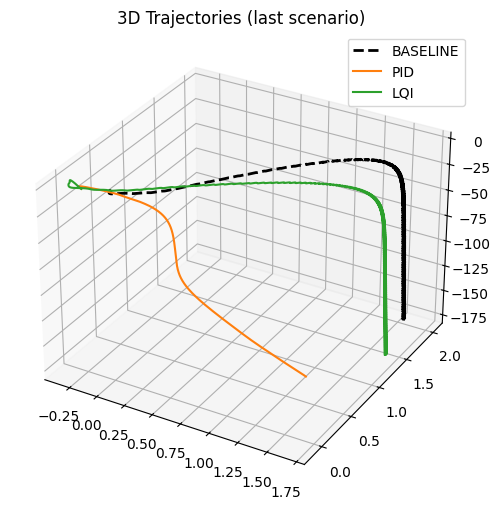

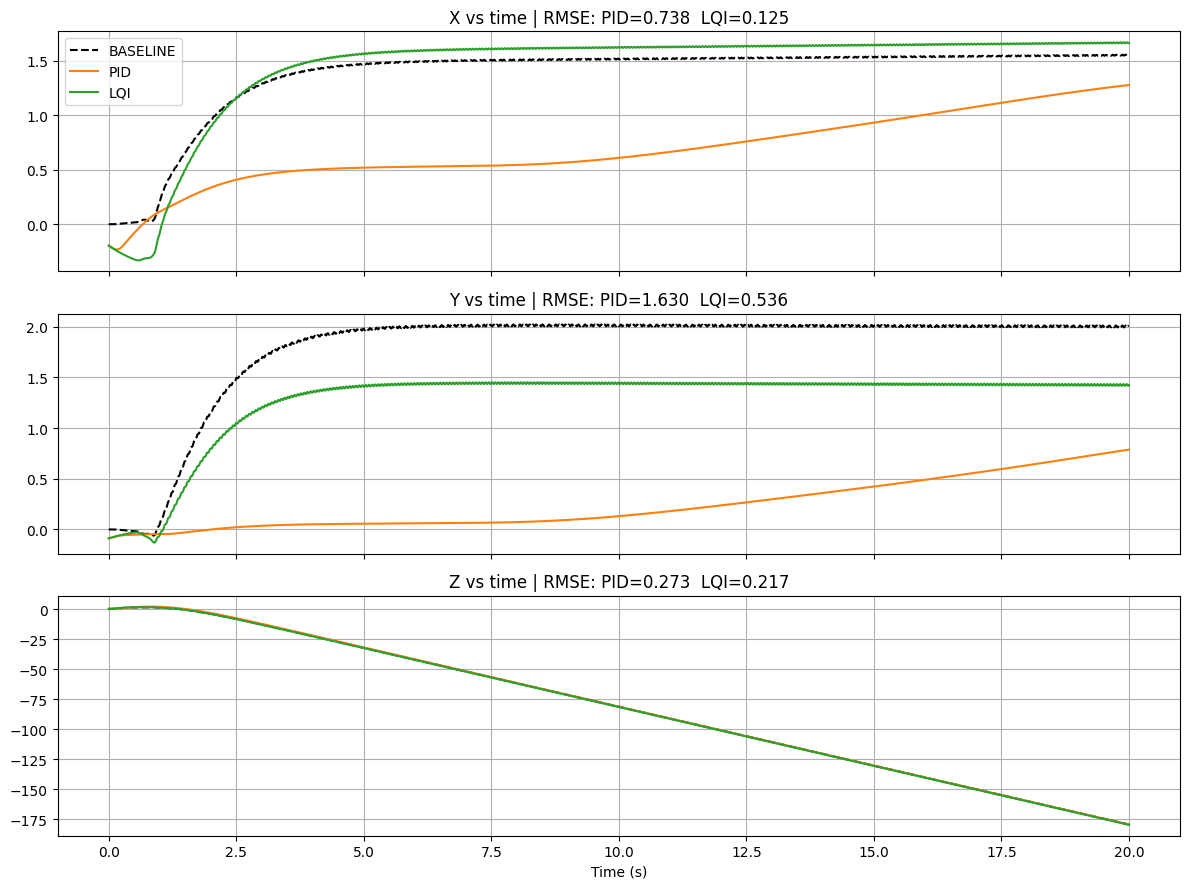

In [ ]:
# Full runnable cell:
# --- LQI-Z IMPLEMENTATION (V3 - Robust) ---
# 1. The LQI with (X,Y,Z) integrators was unstable under large perturbations.
# 2. To make a fair comparison with the PID (which only integrates Z),
#    we'll change the LQI to an "LQI-Z".
# 3. The augmented state is now 14-dimensional (13 states + 1 Z-integral),
#    which should be much more robust and prevent windup in X and Y.
# ---------------------

import numpy as np, time, warnings
warnings.filterwarnings("ignore")
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg

device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(0); torch.manual_seed(0)
if device=='cuda': torch.cuda.manual_seed_all(0)
print("Device:", device)

# --------------------- CONFIG (tweak these) ---------------------
DT = 0.01
T_RUN = 20.0

# --------------------- RK4 6-DoF Simulator (same as previous) ---------------------
class QuadRK4:
    def __init__(self, dt=DT, m=1.0, L=0.2, k_f=6.11e-8, k_m=1.5e-9,
                 I=np.diag([0.005,0.005,0.009]), max_rpm=20000.0):
        self.dt = dt; self.m = m; self.L = L; self.k_f = k_f; self.k_m = k_m
        self.I = I.astype(np.float64); self.invI = np.linalg.inv(self.I)
        self.max_rpm = max_rpm; self.g = np.array([0.0,0.0,-9.81],dtype=np.float64)
        self.reset()
    def reset(self):
        self.pos = np.zeros(3,dtype=np.float64)
        self.vel = np.zeros(3,dtype=np.float64)
        self.q = np.array([1.0,0.0,0.0,0.0],dtype=np.float64)
        self.omega = np.zeros(3,dtype=np.float64)
    def state_vector(self):
        return np.hstack([self.pos, self.q, self.vel, self.omega])

    def set_state_vector(self, s):
        self.pos = s[0:3].astype(np.float64)

        self.q = s[3:7].astype(np.float64)
        # Add check for zero-norm quaternion to prevent NaN propagation
        norm = np.linalg.norm(self.q)
        if norm < 1e-9:
            self.q = np.array([1.0, 0.0, 0.0, 0.0], dtype=np.float64)
        else:
            self.q /= norm

        self.vel = s[7:10].astype(np.float64)
        self.omega = s[10:13].astype(np.float64)

    def quat_to_rotm(self,q):
        w,x,y,z = q
        return np.array([
            [1-2*(y*y+z*z), 2*(x*y - w*z), 2*(x*z + w*y)],
            [2*(x*y + w*z), 1-2*(x*x+z*z), 2*(y*z - w*x)],
            [2*(x*z - w*y), 2*(y*z + w*x), 1-2*(x*x + y*y)]
        ], dtype=np.float64)
    def quat_derivative(self,q,omega):
        wx,wy,wz = omega
        Omega = np.array([[0.0,-wx,-wy,-wz],[wx,0.0,wz,-wy],[wy,-wz,0.0,wx],[wz,wy,-wx,0.0]])
        return 0.5*(Omega @ q)
    def continuous_dynamics(self, state, rpm):
        pos = state[0:3]; q = state[3:7]; vel = state[7:10]; omega = state[10:13]
        rpm = np.clip(rpm, 0.0, self.max_rpm)
        thrusts = self.k_f * (rpm**2)
        total_th = np.sum(thrusts)
        tau = np.array([ self.L*(thrusts[1]-thrusts[3]), self.L*(thrusts[2]-thrusts[0]),
                        self.k_m*(thrusts[0]-thrusts[1]+thrusts[2]-thrusts[3]) ], dtype=np.float64)
        R = self.quat_to_rotm(q)
        F_th = R @ np.array([0.0,0.0,total_th], dtype=np.float64)
        vnorm = np.linalg.norm(vel); F_drag = -0.1*vel*vnorm
        acc = (F_th + F_drag)/self.m + self.g
        pos_dot = vel; q_dot = self.quat_derivative(q, omega)
        omega_dot = self.invI @ (tau - np.cross(omega, self.I @ omega))
        deriv = np.zeros(13,dtype=np.float64)
        deriv[0:3]=pos_dot; deriv[3:7]=q_dot; deriv[7:10]=acc; deriv[10:13]=omega_dot
        return deriv
    def rk4_step(self, rpm):
        s0 = self.state_vector()
        k1 = self.continuous_dynamics(s0, rpm)
        k2 = self.continuous_dynamics(s0 + 0.5*self.dt*k1, rpm)
        k3 = self.continuous_dynamics(s0 + 0.5*self.dt*k2, rpm)
        k4 = self.continuous_dynamics(s0 + self.dt*k3, rpm)
        s_next = s0 + (self.dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        self.set_state_vector(s_next)
    def hover_rpm(self):
        fpm = self.m * abs(self.g[2]) / 4.0
        return float(np.sqrt(max(fpm / self.k_f, 0.0)))

def quat_to_euler(q):
    w,x,y,z = q
    roll = np.arctan2(2*(w*x + y*z), 1 - 2*(x*x + y*y))
    sinp = 2*(w*y - z*x)
    pitch = np.sign(sinp)*(np.pi/2) if abs(sinp)>=1 else np.arcsin(sinp)
    yaw = np.arctan2(2*(w*z + x*y), 1 - 2*(y*y + z*z))
    return roll,pitch,yaw

# --------------------- TV-LQI (Z-axis only) ---------------------
def linearize_discrete_map(sim, x_ref, u_ref, eps=1e-5):
    saved = sim.state_vector().copy()
    nx = x_ref.size; nu = u_ref.size
    A = np.zeros((nx,nx), dtype=np.float64)
    B = np.zeros((nx,nu), dtype=np.float64)
    sim.set_state_vector(x_ref.copy()); sim.rk4_step(u_ref); xnext_base = sim.state_vector().copy()
    for i in range(nx):
        dx = np.zeros(nx); dx[i] = eps
        sim.set_state_vector(x_ref + dx); sim.rk4_step(u_ref); xnext = sim.state_vector().copy()
        A[:,i] = (xnext - xnext_base)/eps
    for j in range(nu):
        du = np.zeros(nu); du[j] = eps
        sim.set_state_vector(x_ref.copy()); sim.rk4_step(u_ref + du); xdu = sim.state_vector().copy()
        B[:,j] = (xdu - xnext_base)/eps
    sim.set_state_vector(saved)
    return A,B

def tv_lqi_z_rpm(sim, x, x_ref, u_ff, z_integral_error):
    try:
        # 1. Linearize the original 13-state system
        A, B = linearize_discrete_map(sim, x_ref, u_ff, eps=1e-5)
        nx = A.shape[0]  # 13
        nu = B.shape[1]  # 4

        # 2. Define the output matrix C for *Z position only*
        C = np.zeros((1, nx))
        C[0, 2] = 1.0 # Index 2 is z-position
        nz = C.shape[0] # 1

        # 3. Build the 14x14 augmented system matrices
        A_aug = np.block([
            [A,                np.zeros((nx, nz))],
            [C,                np.eye(nz)        ]
        ])
        B_aug = np.block([
            [B                ],
            [np.zeros((nz, nu))]
        ])

        # 4. Build the augmented cost matrices (Q_aug, R)
        # Original Q for the 13 states
        Q_orig = np.diag([5.0, 5.0, 200.0] + [1.0]*10)
        # Integral cost Qi for the 1 Z-integral state
        Q_i = np.diag([50.0]) # Was [20, 20, 50]

        Q_aug = linalg.block_diag(Q_orig, Q_i)
        R = np.eye(4)*0.01

        # 5. Solve the augmented DARE
        P = linalg.solve_discrete_are(A_aug, B_aug, Q_aug, R)

        # 6. Calculate augmented gain K_aug
        S = R + B_aug.T @ P @ B_aug
        K_aug = np.linalg.solve(S, B_aug.T @ P @ A_aug) # (4, 14)

        # 7. Calculate control law
        delta_x = x - x_ref
        # z_integral_error is now a scalar
        x_aug = np.hstack([delta_x, z_integral_error]) # (14,)

        delta_u = -K_aug @ x_aug
        delta_u = np.clip(delta_u, -1500.0, 1500.0)

        return np.clip(u_ff + delta_u, 0.0, sim.max_rpm)

    except Exception as e:
        # print(f"LQI Solver failed: {e}") # for debugging
        return np.clip(u_ff, 0.0, sim.max_rpm)

# --------------------- PID (conservative) ---------------------
def pid_controller(sim, x, x_ref, integral, dt, u_prev):
    Kp_z, Ki_z, Kd_z = 30.0, 6.0, 12.0
    Kp_xy, Kd_xy = 1.0, 0.8
    Kp_att, Kd_att = 6.0, 1.5
    pos = x[0:3]; q = x[3:7]; vel = x[7:10]; omega = x[10:13]
    roll,pitch,yaw = quat_to_euler(q)
    z_err = x_ref[2] - pos[2]; vz_err = x_ref[9] - vel[2]
    integral['z'] += z_err*dt; integral['z'] = np.clip(integral['z'], -5.0, 5.0)
    thrust_total = sim.m*abs(sim.g[2]) + Kp_z*z_err + Ki_z*integral['z'] + Kd_z*vz_err
    x_err,y_err = x_ref[0]-pos[0], x_ref[1]-pos[1]; vx_err,vy_err = x_ref[7]-vel[0], x_ref[8]-vel[1]
    pitch_d = np.clip(Kp_xy*x_err + Kd_xy*vx_err, -0.35, 0.35)
    roll_d  = np.clip(-(Kp_xy*y_err + Kd_xy*vy_err), -0.35, 0.35)
    roll_err = roll_d - roll; pitch_err = pitch_d - pitch
    tx = Kp_att*roll_err - Kd_att*omega[0]; ty = Kp_att*pitch_err - Kd_att*omega[1]; tz = -Kd_att*omega[2]
    f0 = thrust_total/4.0 - ty/(2*sim.L) + tz/(4*sim.k_m)
    f1 = thrust_total/4.0 + tx/(2*sim.L) - tz/(4*sim.k_m)
    f2 = thrust_total/4.0 + ty/(2*sim.L) + tz/(4*sim.k_m)
    f3 = thrust_total/4.0 - tx/(2*sim.L) - tz/(4*sim.k_m)
    forces = np.array([f0,f1,f2,f3], dtype=np.float64)
    rpm = np.sqrt(np.clip(forces / sim.k_f, 0.0, None))
    rpm = np.clip(rpm, 0.0, sim.max_rpm)
    alpha = 0.25
    u_sm = alpha*rpm + (1-alpha)*u_prev
    if np.any((u_sm <= 1e-6) | (u_sm >= sim.max_rpm-1.0)): integral['z'] -= z_err*dt*0.5
    return u_sm, integral

# --------------------- Metrics utils ---------------------
def rmse_per_axis(x_hist, x_ref):
    err = x_hist[:,:3] - x_ref[:,:3]
    return np.sqrt(np.mean(err[:,0]**2)), np.sqrt(np.mean(err[:,1]**2)), np.sqrt(np.mean(err[:,2]**2))

def compute_effort_energy(u_hist, x_hist, sim):
    dt = sim.dt
    effort = np.sum(np.sum(np.abs(u_hist),axis=1)) * dt
    thrusts = sim.k_f * (u_hist**2)
    vz = x_hist[:-1,9]
    total_th = np.sum(thrusts,axis=1)
    energy = np.sum(total_th * np.abs(vz) * dt)
    return effort, energy

# --------------------- Baseline generation (RK4 self-consistent) ---------------------
def generate_baseline(sim, T=T_RUN):
    steps = int(T/sim.dt)
    t = np.linspace(0.0, (steps-1)*sim.dt, steps)
    ref = np.zeros((steps,13), dtype=np.float64)
    ref[:,0] = 2 * np.sin(3*t); ref[:,1] = 2 * np.cos(3*t)
    ref[:,2] = 1.0 + 0.6 * np.sin(2*t)
    ref[:,7] = 2*0.9*np.cos(0.6*t); ref[:,8] = -2*0.9*np.sin(4*t)
    ref[:,9] = 2*0.2*np.cos(2*t); ref[:,3]=1.0; ref[:,4:7] = 1*np.sin(0.2*t[:,None]); ref[:,10:13]=0.0
    for i in range(steps): ref[i,3:7] /= np.linalg.norm(ref[i,3:7])
    x_seq = np.zeros((steps+1,13), dtype=np.float64); u_seq = np.zeros((steps,4), dtype=np.float64)
    sim.reset(); x_seq[0,:] = sim.state_vector()
    u_prev = np.ones(4)*sim.hover_rpm()
    for k in range(steps):
        x = sim.state_vector(); x_ref = ref[k]
        z_err = x_ref[2] - x[2]; vz_err = x_ref[9] - x[9]; thrust_total = sim.m*abs(sim.g[2]) + 120.0*z_err + 30.0*vz_err
        roll_ref,pitch_ref,_ = quat_to_euler(x_ref[3:7]); roll,pitch,_ = quat_to_euler(x[3:7])
        tx = 4.0*(roll_ref-roll); ty = 4.0*(pitch_ref-pitch); tz = -1.0*(x[12] if x.size>12 else 0.0)
        f0 = thrust_total/4.0 - ty/(2*sim.L) + tz/(4*sim.k_m)
        f1 = thrust_total/4.0 + tx/(2*sim.L) - tz/(4*sim.k_m)
        f2 = thrust_total/4.0 + ty/(2*sim.L) + tz/(4*sim.k_m)
        f3 = thrust_total/4.0 - tx/(2*sim.L) - tz/(4*sim.k_m)
        forces = np.array([f0,f1,f2,f3], dtype=np.float64)
        rpm = np.sqrt(np.clip(forces / sim.k_f, 0.0, None))
        rpm = 0.2*rpm + 0.8*u_prev; rpm = np.clip(rpm, 0.0, sim.max_rpm)
        u_seq[k,:] = rpm.copy()
        sim.rk4_step(rpm)
        x_seq[k+1,:] = sim.state_vector()
        u_prev = rpm.copy()
    return ref, x_seq, u_seq

# --------------------- Runner (simplified) ---------------------
def run_controller(sim_template, controller_name, x0, ref_seq, u_ref_seq):

    sim = QuadRK4(dt=sim_template.dt, m=sim_template.m, L=sim_template.L, k_f=sim_template.k_f, k_m=sim_template.k_m, I=sim_template.I, max_rpm=sim_template.max_rpm)
    sim.set_state_vector(x0.copy())
    n = u_ref_seq.shape[0]
    x_hist = np.zeros((n+1,13), dtype=np.float64); u_hist = np.zeros((n,4), dtype=np.float64)
    x_hist[0,:] = sim.state_vector()

    # Initialize integral terms
    pid_integral = {'z':0.0}
    lqi_z_integral_error = 0.0 # LQI now only integrates Z (a scalar)

    u_prev = u_ref_seq[0].copy()

    for k in range(n):
        x = sim.state_vector(); x_ref = ref_seq[k]; u_ref = u_ref_seq[k]

        if controller_name == 'pid':
            u_cmd, pid_integral = pid_controller(sim, x, x_ref, pid_integral, sim.dt, u_prev)

        elif controller_name == 'lqi':
            # Update LQI Z-integral error
            z_pos_err = (x - x_ref)[2] # Index 2 is z-position
            lqi_z_integral_error += z_pos_err * sim.dt
            # Anti-windup clamp
            lqi_z_integral_error = np.clip(lqi_z_integral_error, -5.0, 5.0)

            u_cmd = tv_lqi_z_rpm(sim, x, x_ref, u_ref, lqi_z_integral_error)

        else:
            raise ValueError("Unknown controller")

        # Apply smoothing ONLY to PID
        if controller_name == 'pid':
             alpha = 0.35
        else:
             alpha = 1.0  # Use 100% of the calculated command (no smoothing)

        u_cmd = np.clip(alpha*u_cmd + (1-alpha)*u_prev, 0.0, sim.max_rpm)

        sim.rk4_step(u_cmd)

        x_next = sim.state_vector()
        x_hist[k+1,:] = x_next.copy(); u_hist[k,:] = u_cmd.copy()
        u_prev = u_cmd.copy()

    return x_hist, u_hist

# --------------------- Main pipeline ---------------------
def main_all():
    sim = QuadRK4(dt=DT)

    # Baseline generation
    print("Generating baseline trajectory...")
    ref_worldline, x_baseline, u_baseline = generate_baseline(sim, T=T_RUN)
    x0 = x_baseline[0].copy()

    controllers = ['pid','lqi'] # 'lqi' is now 'lqi-z'
    perturb_levels = [0.0, 0.05, 0.15, 0.35, 0.7]
    results = {c:[] for c in controllers}

    for si, pert in enumerate(perturb_levels):
        print(f"\nScenario {si+1}/{len(perturb_levels)} perturb={pert:.3f}")
        # initial condition perturbation
        x0_pert = x0.copy()
        x0_pert[0:3] += np.random.uniform(-pert,pert,3)
        x0_pert[7:10] += np.random.uniform(-pert,pert,3)*0.5
        x0_pert[3:7] += np.random.uniform(-0.01,0.01,4); x0_pert[3:7] /= np.linalg.norm(x0_pert[3:7])

        for c in controllers:
            t0 = time.time()

            xh, uh = run_controller(sim, c, x0_pert, x_baseline[:-1], u_baseline)

            t_elapsed = time.time() - t0
            rx,ry,rz = rmse_per_axis(xh, x_baseline)
            effort, energy = compute_effort_energy(uh, xh, sim)
            results[c].append({'pert':pert, 'rmse':(rx,ry,rz), 'effort':effort, 'energy':energy, 'time':t_elapsed, 'xh':xh, 'uh':uh})
            print(f"  {c.upper():8s} | RMSE X={rx:.3f}, Y={ry:.3f}, Z={rz:.3f} | Eff={effort:.2e} Energy={energy:.2e} Time={t_elapsed:.2f}s")

    # print averages
    print("\n=== Average metrics across scenarios ===")
    for c in controllers:
        rmses_x = [r['rmse'][0] for r in results[c]]; rmses_y = [r['rmse'][1] for r in results[c]]; rmses_z = [r['rmse'][2] for r in results[c]]
        effs = [r['effort'] for r in results[c]]; enes = [r['energy'] for r in results[c]]
        print(f"{c.upper():6s} | Avg RMSE X={np.mean(rmses_x):.3f} Y={np.mean(rmses_y):.3f} Z={np.mean(rmses_z):.3f} | Avg Eff={np.mean(effs):.2e} Avg Ene={np.mean(enes):.2e}")

    # plot last scenario's results (3D + X/Y/Z)
    rep_idx = -1
    fig = plt.figure(figsize=(14,6))
    ax3d = fig.add_subplot(121, projection='3d')
    ax3d.plot(x_baseline[:,0], x_baseline[:,1], x_baseline[:,2], 'k--', lw=2, label='BASELINE')
    colors = {'pid':'tab:orange','lqi':'tab:green'}
    for c in controllers:
        xh = results[c][rep_idx]['xh']
        ax3d.plot(xh[:,0], xh[:,1], xh[:,2], color=colors.get(c, 'r'), label=c.upper())
    ax3d.set_title("3D Trajectories (last scenario)"); ax3d.legend()

    # X/Y/Z vs time
    fig2, axs = plt.subplots(3,1, figsize=(12,9), sharex=True)
    time_axis = np.arange(x_baseline.shape[0]) * sim.dt
    for i,label in enumerate(['X','Y','Z']):
        axs[i].plot(time_axis, x_baseline[:,i], 'k--', label='BASELINE')
        for c in controllers:
            axs[i].plot(time_axis, results[c][rep_idx]['xh'][:,i], color=colors.get(c, 'r'), label=c.upper())
        rmse_str = "  ".join([f"{c.upper()}={results[c][rep_idx]['rmse'][i]:.3f}" for c in controllers])
        axs[i].set_title(f"{label} vs time | RMSE: {rmse_str}")
        axs[i].grid(True)
    axs[2].set_xlabel("Time (s)")
    axs[0].legend()

    plt.tight_layout(); plt.show()
    return results

# Run the pipeline
results = main_all()

KOOPMAN

accuracy

Generating baseline (self-consistent) ...
Baseline generated. Steps: 2000

Running scenario perturb=0.000 ...
 LQI     | RMSE X=0.012 Y=0.190 Z=0.525 | Effort=1.52e+06 Energy=1.73e+04
 KP+LQI  | RMSE X=0.012 Y=0.190 Z=0.525 | Effort=1.52e+06 Energy=1.73e+04


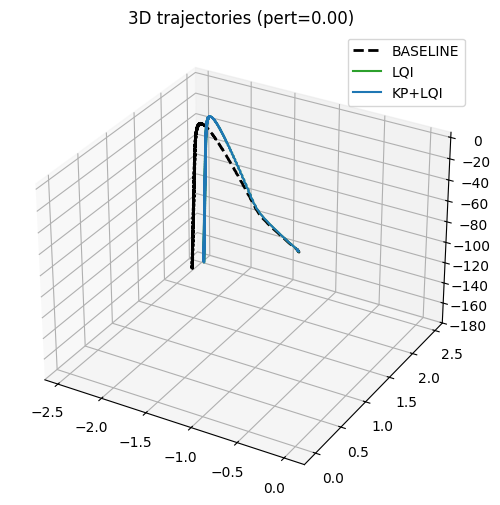

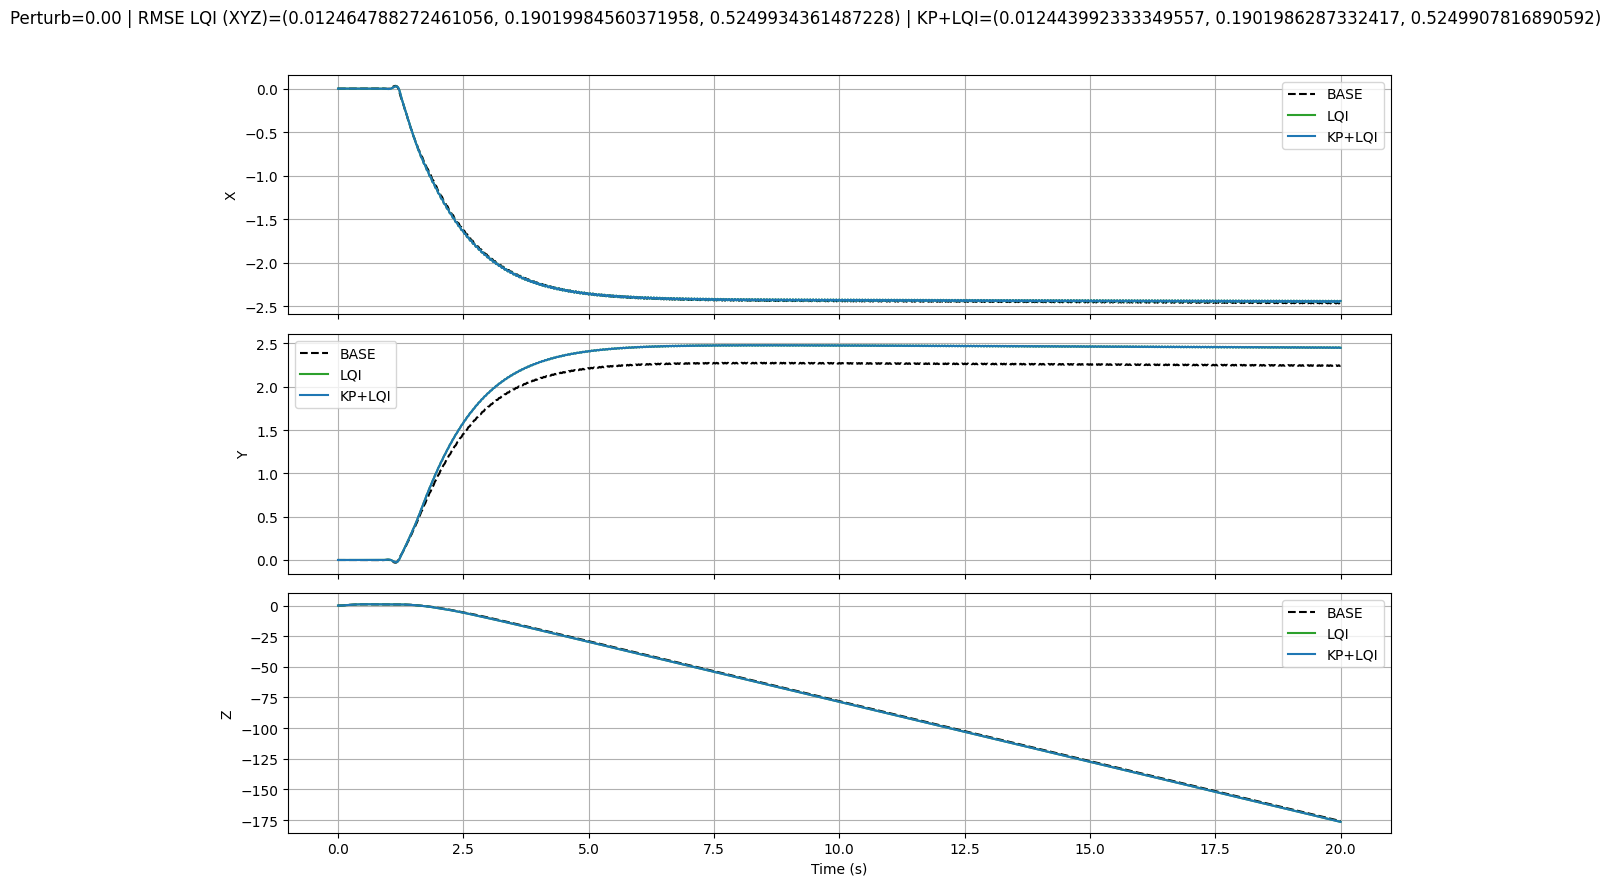

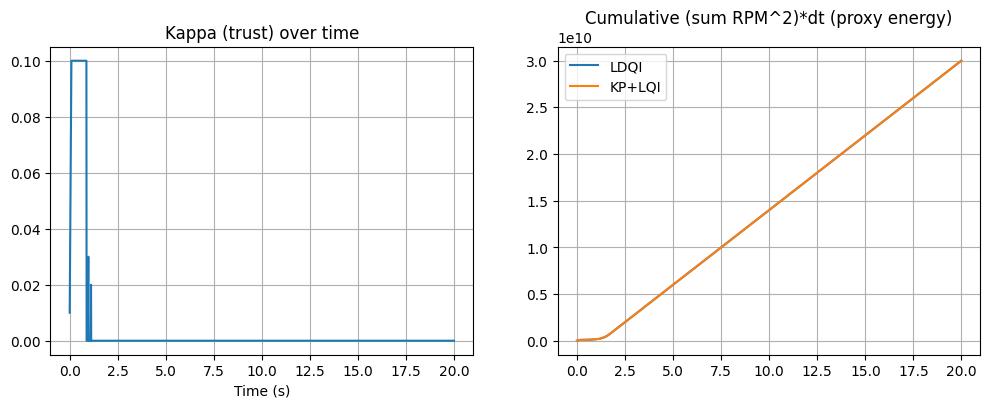


Running scenario perturb=0.050 ...
 LQI     | RMSE X=0.044 Y=0.201 Z=0.533 | Effort=1.52e+06 Energy=1.73e+04
 KP+LQI  | RMSE X=0.016 Y=0.165 Z=0.544 | Effort=1.52e+06 Energy=1.73e+04


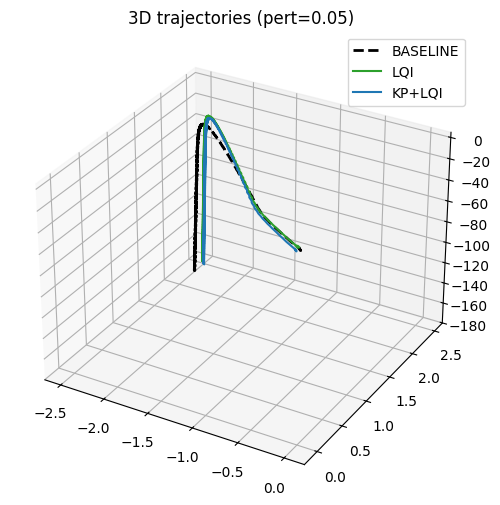

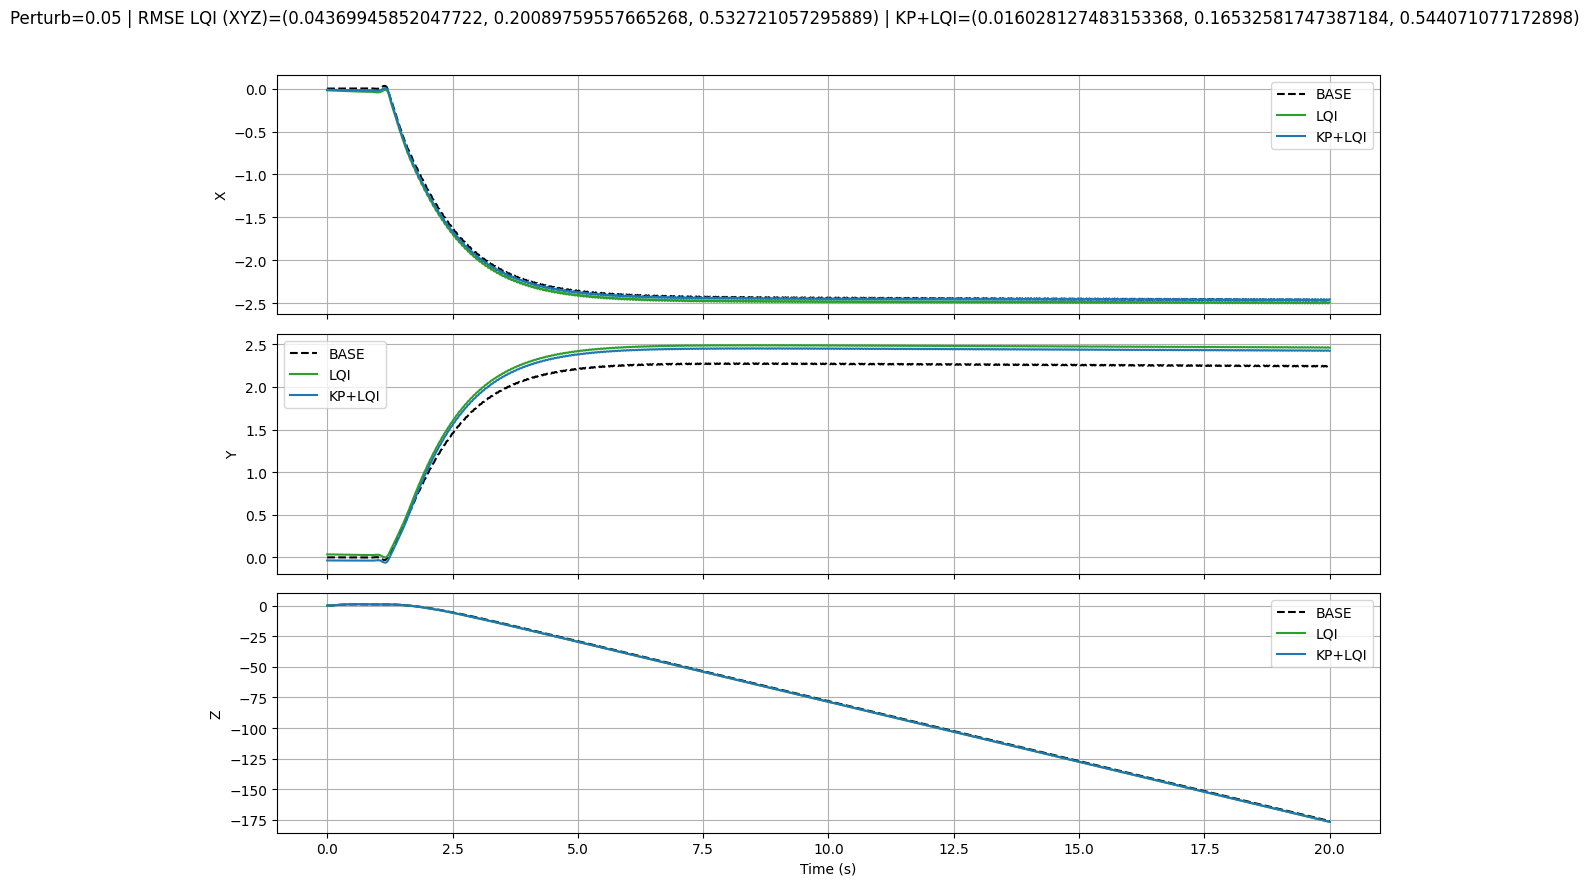

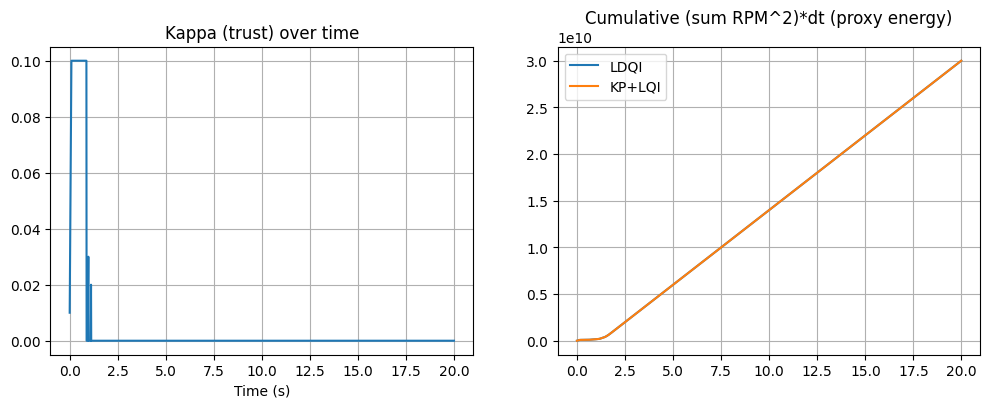


Running scenario perturb=0.150 ...
 LQI     | RMSE X=0.040 Y=0.250 Z=0.494 | Effort=1.52e+06 Energy=1.73e+04
 KP+LQI  | RMSE X=0.058 Y=0.209 Z=0.445 | Effort=1.52e+06 Energy=1.73e+04


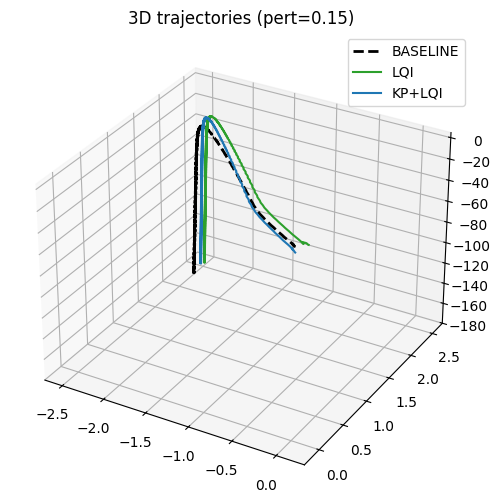

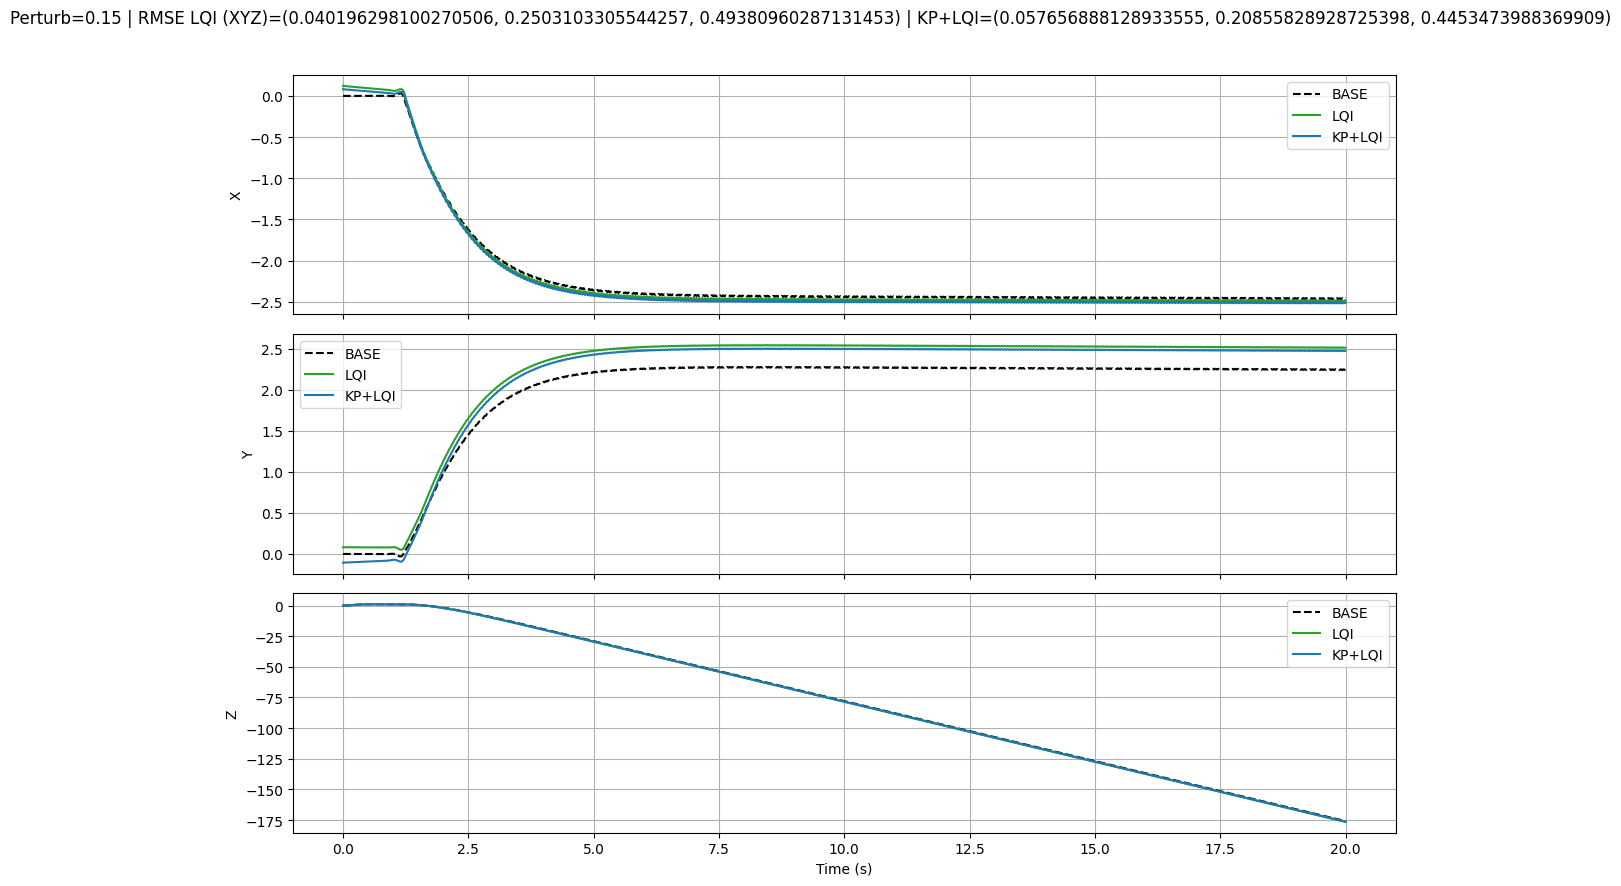

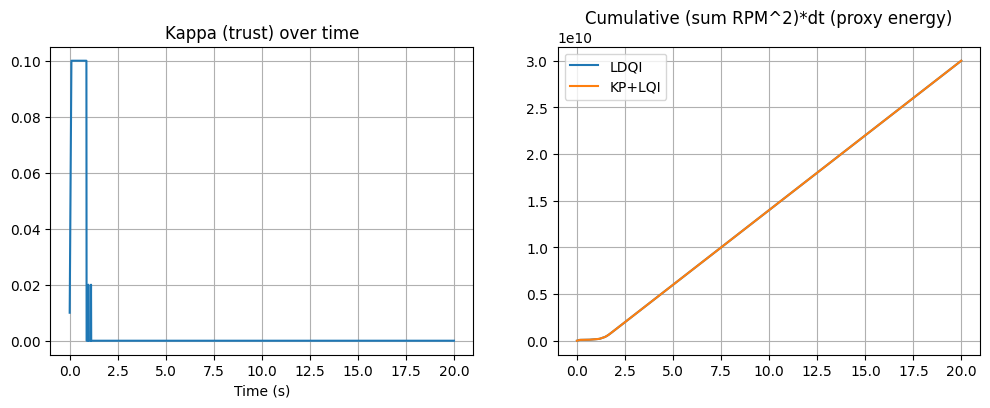


Running scenario perturb=0.350 ...
 LQI     | RMSE X=0.228 Y=0.108 Z=0.348 | Effort=1.52e+06 Energy=1.73e+04
 KP+LQI  | RMSE X=0.093 Y=0.500 Z=0.344 | Effort=1.52e+06 Energy=1.73e+04


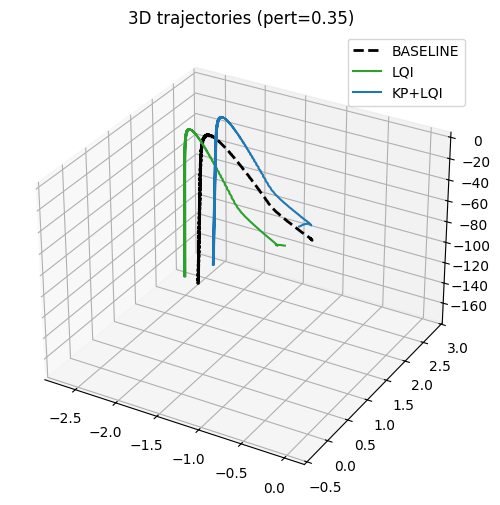

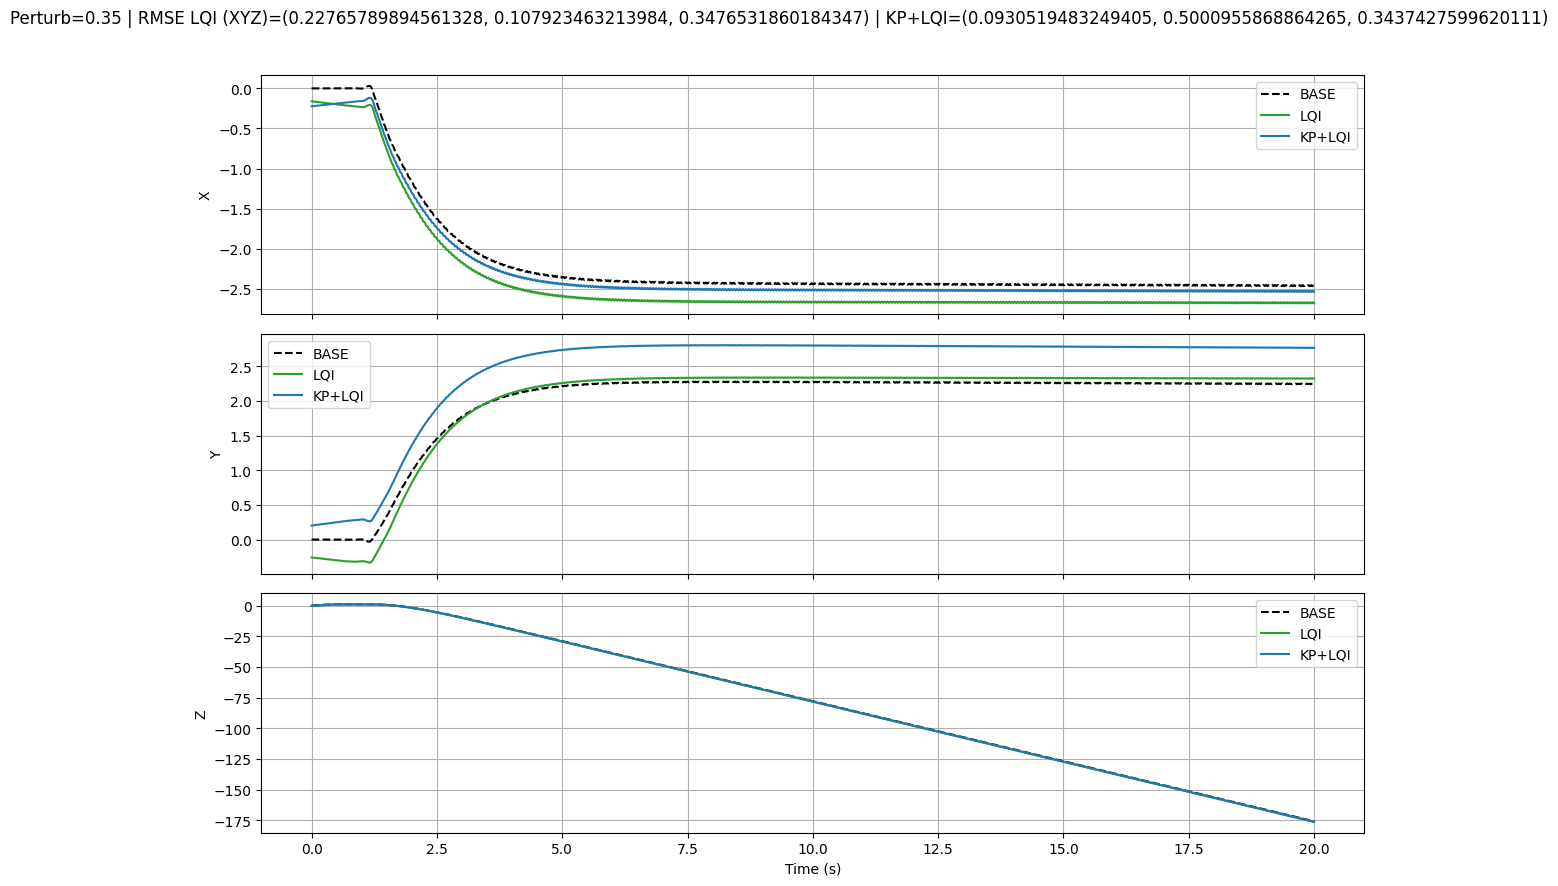

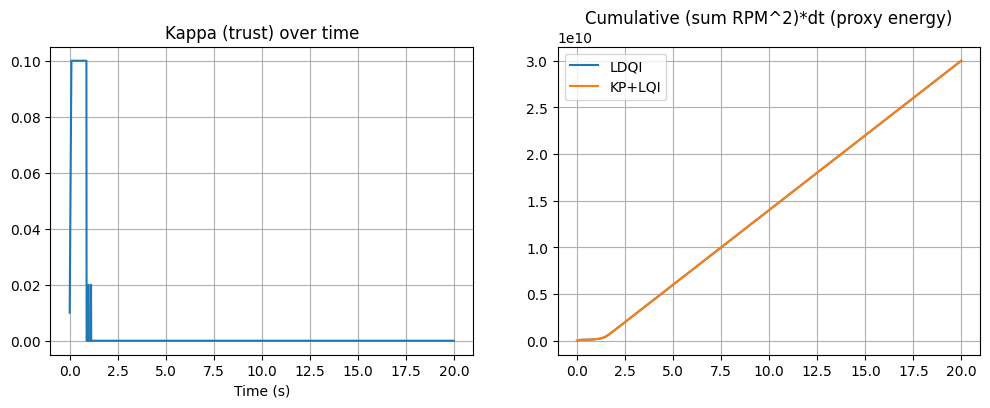


Running scenario perturb=0.700 ...
 LQI     | RMSE X=0.589 Y=0.437 Z=0.466 | Effort=1.52e+06 Energy=1.73e+04
 KP+LQI  | RMSE X=0.115 Y=0.177 Z=0.440 | Effort=1.52e+06 Energy=1.73e+04


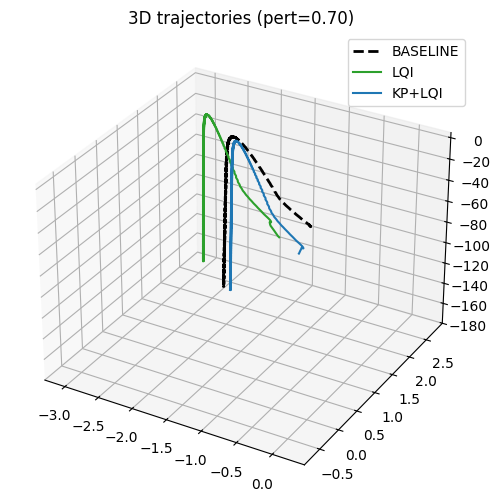

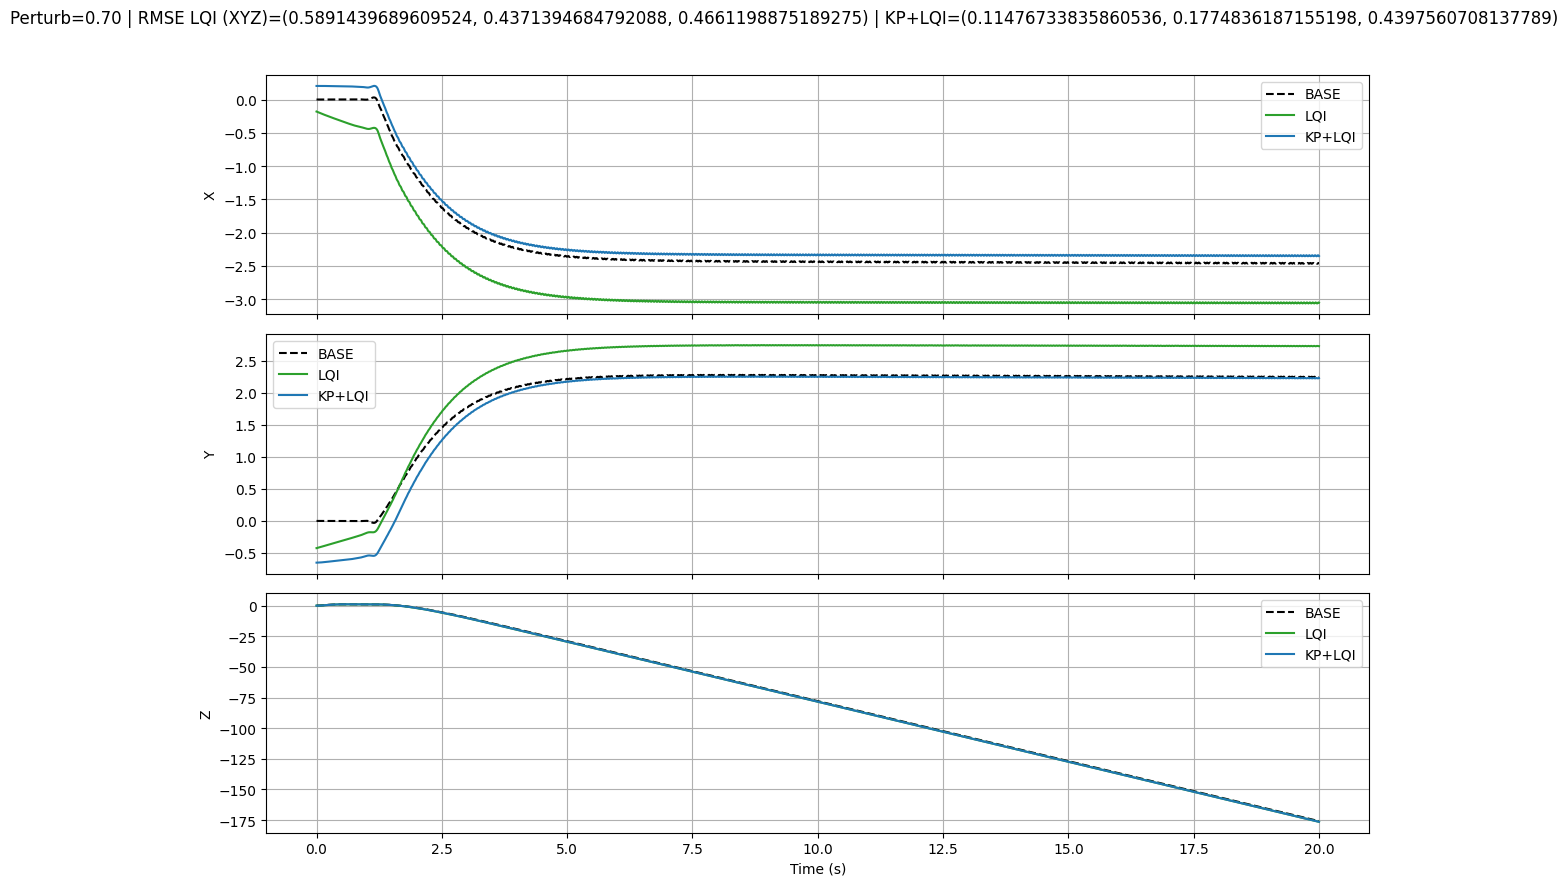

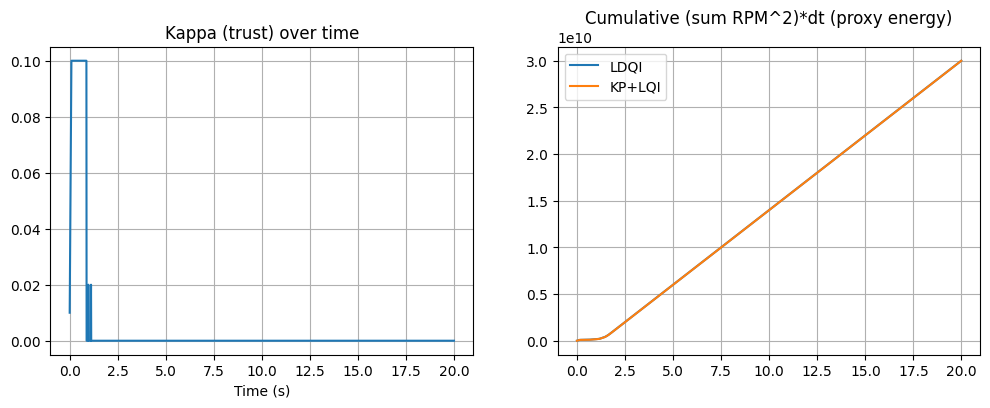


=== AVERAGE METRICS ACROSS SCENARIOS ===
LQI      | Avg RMSE X=0.1826 Y=0.2373 Z=0.4731 | Avg Eff=1.52e+06 Avg Ene=1.73e+04
KP+LQI   | Avg RMSE X=0.0588 Y=0.2483 Z=0.4596 | Avg Eff=1.52e+06 Avg Ene=1.73e+04


In [ ]:
import numpy as np, time, math
from scipy import linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.set_printoptions(precision=5, suppress=True)

# -------------------- CONFIG / hyperparameters --------------------
DT = 0.01              # integration timestep
T_RUN = 20.0             # seconds per scenario
STEPS = int(T_RUN / DT)
VERBOSE = True

# RLS hyperparameters (learning W mapping Δu -> Δx)
RLS_LAMBDA = 0.998      # forgetting factor
RLS_P0 = 1e5           # initial P diag scalar
RLS_REG = 1e-6          # small numerical reg for inversion

# Koopman-assist regularized inversion hyperparams
DU_REG = 0.05           # regularization for solving du = argmin ||W du - dx_err||^2 + reg ||du||^2
DU_MAX = 1000.0         # max delta rpm per motor from assist
KAPPA_INIT = 0.0        # start with no Koopman assist until some trust accumulates
KAPPA_STEP_UP = 0.01
KAPPA_STEP_DOWN = 0.25
KAPPA_MIN, KAPPA_MAX = 0.0, 0.1

# Safety: do not allow Koopman to reduce LQI accuracy: track recent window RMSE
TRUST_WINDOW = int(0.5 / DT)  # 0.5s window
RMSE_FAIL_THRESH = 1.01       # if KP+LQI RMSE > RMSE_LQI * this, then drop κ

# visualization / metrics
PLOT_EVERY = 1

# -------------------- RK4 Quadcopter (13D) --------------------
class QuadRK4:
    def __init__(self, dt=DT, m=1.0, L=0.2, k_f=6.11e-8, k_m=1.5e-9, I=np.diag([0.005,0.005,0.009]), max_rpm=20000.0):
        self.dt = dt; self.m = m; self.L = L; self.k_f = k_f; self.k_m = k_m
        self.I = I.astype(np.float64); self.invI = np.linalg.inv(self.I)
        self.max_rpm = float(max_rpm); self.g = np.array([0.0,0.0,-9.81], dtype=np.float64)
        self.reset()
    def reset(self):
        self.pos = np.zeros(3, dtype=np.float64)
        self.vel = np.zeros(3, dtype=np.float64)
        self.q = np.array([1.0,0.0,0.0,0.0], dtype=np.float64)  # w,x,y,z
        self.omega = np.zeros(3, dtype=np.float64)
    def state_vector(self):
        return np.hstack([self.pos, self.q, self.vel, self.omega])
    def set_state_vector(self, s):
        s = np.asarray(s, dtype=np.float64)
        self.pos = s[0:3].copy()
        self.q = s[3:7].copy()
        nq = np.linalg.norm(self.q)
        if nq < 1e-9: self.q = np.array([1.,0.,0.,0.])
        else: self.q /= nq
        self.vel = s[7:10].copy()
        self.omega = s[10:13].copy()
    def quat_to_rotm(self,q):
        w,x,y,z = q
        R = np.array([
            [1 - 2*(y*y + z*z), 2*(x*y - w*z),     2*(x*z + w*y)],
            [2*(x*y + w*z),     1 - 2*(x*x + z*z), 2*(y*z - w*x)],
            [2*(x*z - w*y),     2*(y*z + w*x),     1 - 2*(x*x + y*y)]
        ], dtype=np.float64)
        return R
    def quat_derivative(self, q, omega):
        wx,wy,wz = omega
        Omega = np.array([[0.0,-wx,-wy,-wz],[wx,0.0,wz,-wy],[wy,-wz,0.0,wx],[wz,wy,-wx,0.0]], dtype=np.float64)
        return 0.5 * (Omega @ q)
    def continuous_dynamics(self, state, rpm):
        pos = state[0:3]; q = state[3:7]; vel = state[7:10]; omega = state[10:13]
        rpm = np.clip(rpm, 0.0, self.max_rpm)
        thrusts = self.k_f * (rpm**2)  # per rotor thrust N
        total_thrust = float(np.sum(thrusts))
        tau = np.array([ self.L*(thrusts[1]-thrusts[3]),
                         self.L*(thrusts[2]-thrusts[0]),
                         self.k_m*(thrusts[0]-thrusts[1]+thrusts[2]-thrusts[3]) ], dtype=np.float64)
        R = self.quat_to_rotm(q)
        F_thrust_world = R @ np.array([0.0,0.0,total_thrust], dtype=np.float64)
        vnorm = np.linalg.norm(vel)
        F_drag = -0.1 * vel * vnorm
        acc = (F_thrust_world + F_drag) / self.m + self.g
        pos_dot = vel
        q_dot = self.quat_derivative(q, omega)
        omega_dot = self.invI @ (tau - np.cross(omega, self.I @ omega))
        deriv = np.zeros(13, dtype=np.float64)
        deriv[0:3] = pos_dot
        deriv[3:7] = q_dot
        deriv[7:10] = acc
        deriv[10:13]= omega_dot
        return deriv
    def rk4_step(self, rpm):
        s0 = self.state_vector()
        k1 = self.continuous_dynamics(s0, rpm)
        k2 = self.continuous_dynamics(s0 + 0.5*self.dt*k1, rpm)
        k3 = self.continuous_dynamics(s0 + 0.5*self.dt*k2, rpm)
        k4 = self.continuous_dynamics(s0 + self.dt*k3, rpm)
        s_next = s0 + (self.dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        self.set_state_vector(s_next)
    def hover_rpm_per_motor(self):
        fpm = self.m * abs(self.g[2]) / 4.0
        return float(np.sqrt(max(fpm / self.k_f, 0.0)))

def quat_to_euler(q):
    w,x,y,z = q
    sinr = 2*(w*x + y*z); cosr = 1 - 2*(x*x + y*y); roll = math.atan2(sinr, cosr)
    sinp = 2*(w*y - z*x); pitch = math.copysign(math.pi/2, sinp) if abs(sinp)>=1 else math.asin(sinp)
    siny = 2*(w*z + x*y); cosy = 1 - 2*(y*y + z*z); yaw = math.atan2(siny, cosy)
    return roll,pitch,yaw

# -------------------- Baseline generation (self-consistent PD generator) --------------------
def generate_baseline(sim, T=T_RUN):
    steps = int(T / sim.dt)
    t = np.linspace(0.0, (steps-1)*sim.dt, steps)
    ref = np.zeros((steps, 13), dtype=np.float64)
    # configurable smooth 4D worldline (move around; baseline)
    ref[:,0] = 0.5 * np.sin(0.8 * t)       # x
    ref[:,1] = 0.5 * np.cos(0.5 * t)       # y
    ref[:,2] = 1.0 + 0.05 * np.sin(0.3 * t)  # z
    ref[:,7] = 0.5 * 0.8 * np.cos(0.8*t)    # vx
    ref[:,8] = -0.5 * 0.5 * np.sin(0.5*t)   # vy
    ref[:,9] = 0.05 * 0.3 * np.cos(0.3*t)   # vz
    ref[:,3] = 1.0
    ref[:,4:7] = 0.01 * np.sin(0.2 * t)[:,None]
    for i in range(steps): ref[i,3:7] /= np.linalg.norm(ref[i,3:7])
    # generate x_seq, u_seq dynamically by using a mild PD that follows ref (so baseline is self-consistent)
    x_seq = np.zeros((steps+1, 13), dtype=np.float64)
    u_seq = np.zeros((steps, 4), dtype=np.float64)
    sim.reset()
    x_seq[0,:] = sim.state_vector()
    u_prev = np.ones(4) * sim.hover_rpm_per_motor()
    # PD gains for baseline generator (conservative)
    Kp_z = 80.0; Kd_z = 20.0
    Kp_att = 6.0
    for k in range(steps):
        x = sim.state_vector(); x_ref = ref[k]
        # altitude PD
        z_err = x_ref[2] - x[2]; vz_err = x_ref[9] - x[9]
        thrust_total = sim.m * abs(sim.g[2]) + Kp_z*z_err + Kd_z*vz_err
        # attitude try to keep small reference tilt from ref quaternion
        roll_ref, pitch_ref, _ = quat_to_euler(x_ref[3:7])
        roll, pitch, _ = quat_to_euler(x[3:7])
        tx = Kp_att * (roll_ref - roll)
        ty = Kp_att * (pitch_ref - pitch)
        tz = -0.5 * x[12] if x.size>12 else 0.0
        f0 = thrust_total/4.0 - ty/(2*sim.L) + tz/(4*sim.k_m)
        f1 = thrust_total/4.0 + tx/(2*sim.L) - tz/(4*sim.k_m)
        f2 = thrust_total/4.0 + ty/(2*sim.L) + tz/(4*sim.k_m)
        f3 = thrust_total/4.0 - tx/(2*sim.L) - tz/(4*sim.k_m)
        forces = np.array([f0,f1,f2,f3], dtype=np.float64)
        rpm = np.sqrt(np.clip(forces / sim.k_f, 0.0, None))
        rpm = 0.2 * rpm + 0.8 * u_prev
        rpm = np.clip(rpm, 0.0, sim.max_rpm)
        u_seq[k,:] = rpm.copy()
        sim.rk4_step(rpm)
        x_seq[k+1,:] = sim.state_vector()
        u_prev = rpm.copy()
    return ref, x_seq, u_seq

# -------------------- TV-LQI-Z (augmented DARE around ref, returns rpm) ------------
def linearize_discrete_map(sim, x_ref, u_ref, eps=1e-5):
    saved = sim.state_vector().copy()
    nx = x_ref.size; nu = u_ref.size
    A = np.zeros((nx,nx), dtype=np.float64)
    B = np.zeros((nx,nu), dtype=np.float64)
    # baseline next
    sim.set_state_vector(x_ref.copy()); sim.rk4_step(u_ref); xnext_base = sim.state_vector().copy()
    # states
    for i in range(nx):
        dx = np.zeros(nx); dx[i] = eps
        sim.set_state_vector(x_ref + dx); sim.rk4_step(u_ref); xp = sim.state_vector().copy()
        A[:,i] = (xp - xnext_base) / eps
    # inputs
    for j in range(nu):
        du = np.zeros(nu); du[j] = eps
        sim.set_state_vector(x_ref.copy()); sim.rk4_step(u_ref + du); xu = sim.state_vector().copy()
        B[:,j] = (xu - xnext_base) / eps
    sim.set_state_vector(saved)
    return A, B

def tv_lqi_z_rpm(sim, x, x_ref, u_ff):
    # Build augmented system with Z-integral (1 integrator), solve DARE and compute delta_u
    try:
        A,B = linearize_discrete_map(sim, x_ref, u_ff, eps=1e-6)
        nx = A.shape[0]; nu = B.shape[1]
        # C selects Z position (index 2)
        C = np.zeros((1,nx)); C[0,2] = 1.0
        # Augment
        A_aug = np.block([[A, np.zeros((nx,1))],
                          [C, np.eye(1)]])   # (nx+1, nx+1)
        B_aug = np.vstack([B, np.zeros((1,nu))])  # (nx+1, nu)
        # Cost
        Q_state = np.diag([5.0,5.0,200.0] + [1.0]*10)  # strong Z
        Q_i = np.array([[30.0]])
        Q_aug = linalg.block_diag(Q_state, Q_i)
        R = np.eye(nu) * 0.05
        P = linalg.solve_discrete_are(A_aug, B_aug, Q_aug, R)
        S = R + B_aug.T @ P @ B_aug
        K_aug = np.linalg.solve(S, B_aug.T @ P @ A_aug) # shape (4, nx+1)
        # state error (chordal quaternion)
        dx = x - x_ref
        # ensure quaternion hemisphere consistency
        q = x[3:7].copy(); q_ref = x_ref[3:7]
        if np.dot(q, q_ref) < 0: q = -q
        dx[3:7] = q - q_ref
        # integral state assumed maintained externally; caller will provide zero if none
        z_int = 0.0
        x_aug = np.hstack([dx, z_int])
        delta_u = -K_aug @ x_aug
        delta_u = np.clip(delta_u, -2000.0, 2000.0)
        u_cmd = np.clip(u_ff + delta_u, 0.0, sim.max_rpm)
        return u_cmd
    except Exception as e:
        # fallback to feedforward
        return np.clip(u_ff, 0.0, sim.max_rpm)

# -------------------- RMSE / metrics utilities --------------------
def rmse_per_axis(x_hist, x_ref):
    # both arrays length N+1 in time dimension
    err = x_hist[:,:3] - x_ref[:,:3]
    return float(np.sqrt(np.mean(err[:,0]**2))), float(np.sqrt(np.mean(err[:,1]**2))), float(np.sqrt(np.mean(err[:,2]**2)))

def compute_effort_energy(u_hist, x_hist, sim):
    dt = sim.dt
    effort = np.sum(np.sum(np.abs(u_hist), axis=1)) * dt
    thrusts = sim.k_f * (u_hist**2)
    # vertical velocity at control application times: use x_hist[:-1,9]
    vz = x_hist[:-1,9]
    total_th = np.sum(thrusts, axis=1)
    energy = np.sum(total_th * np.abs(vz) * dt)
    return float(effort), float(energy)

# -------------------- RLS object (learn W: dx = W du ) --------------------
class RLSLearner:
    def __init__(self, nx=13, nu=4, lam=RLS_LAMBDA, P0=RLS_P0):
        self.nx = nx; self.nu = nu
        self.lam = lam
        self.W = np.zeros((nx, nu), dtype=np.float64)  # initial
        self.P = np.eye(nu*nx) * P0  # but we'll operate block-wise: easier is vectorize: vec(W) = Theta of size (nx*nu,)
        # We'll implement vectorized RLS: target vec(dx) = (I_kron du^T) vec(W) ??? simpler to update row-wise
        # Use row-wise RLS: for each row i: dx_i = w_i^T du  => maintain P_i (nu x nu) and w_i
        self.P_rows = [np.eye(nu, dtype=np.float64) * P0 for _ in range(nx)]
        self.w_rows = [np.zeros(nu, dtype=np.float64) for _ in range(nx)]
    def predict_dx(self, du):
        # du shape (nu,)
        return (np.vstack(self.w_rows) @ du).reshape(self.nx,)
    def update(self, du, dx_obs):
        # update each row with standard RLS
        du = du.reshape(-1)
        for i in range(self.nx):
            P = self.P_rows[i]
            w = self.w_rows[i]
            # gain
            denom = self.lam + du @ (P @ du)
            k = (P @ du) / (denom + 1e-12)
            # residual
            r = float(dx_obs[i] - (w @ du))
            w = w + k * r
            # P update
            P = (P - np.outer(k, du @ P)) / self.lam
            # store
            self.w_rows[i] = w
            self.P_rows[i] = P
        # update matrix
        self.W = np.vstack(self.w_rows)

# -------------------- Koopman-assist function using learned W --------------------
def koopman_assist_from_W(W, dx_err, du_reg=DU_REG, du_max=DU_MAX):
    # Solve du = argmin ||W du - dx_err||^2 + reg ||du||^2
    # => (W^T W + reg I) du = W^T dx_err
    W = np.asarray(W, dtype=np.float64)
    nx, nu = W.shape
    A = W.T @ W + du_reg * np.eye(nu)
    b = W.T @ dx_err
    try:
        du = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        du = np.linalg.lstsq(A, b, rcond=None)[0]
    du = np.clip(du, -du_max, du_max)
    return du

# -------------------- Runner for a single scenario (LQI-only vs KP+LQI) ------------
def run_scenario(sim_master, x_baseline, u_baseline, perturb=0.0, use_koopman=False, rls_init=None):
    """
    sim_master: a fresh QuadRK4 object template (we will create per-run instances)
    x_baseline: (N+1,13) baseline states
    u_baseline: (N,4) baseline commands
    perturb: scalar uniform perturbation added to initial pos & vel & small angle
    use_koopman: boolean to enable online RLS + assist
    rls_init: optional initial RLSLearner (if None, new one created)
    Returns: dict with x_hist, u_hist, per-step rmse, energy/effort trajectories, kappa history
    """
    N = u_baseline.shape[0]
    # prepare sim
    sim = QuadRK4(dt=sim_master.dt, m=sim_master.m, L=sim_master.L, k_f=sim_master.k_f, k_m=sim_master.k_m, I=sim_master.I, max_rpm=sim_master.max_rpm)
    # initial state same as baseline x0, but add perturbation
    x0 = x_baseline[0].copy()
    # ---- FIX: Use 'perturb' (the argument) instead of 'pert' ----
    x0[0:3] += np.random.uniform(-perturb, perturb, 3)
    x0[7:10] += np.random.uniform(-perturb, perturb, 3) * 0.5
    x0[3:7] += np.random.uniform(-0.01*perturb, 0.01*perturb, 4)
    # -----------------------------------------------------------
    if np.linalg.norm(x0[3:7]) < 1e-9: x0[3:7] = np.array([1.,0.,0.,0.])
    x0[3:7] /= np.linalg.norm(x0[3:7])
    sim.set_state_vector(x0.copy())

    # storage
    x_hist = np.zeros((N+1, 13), dtype=np.float64)
    u_hist = np.zeros((N,4), dtype=np.float64)
    x_hist[0,:] = sim.state_vector()
    # RLS learner
    rls = rls_init if rls_init is not None else RLSLearner(nx=13, nu=4)
    # kappa (trust)
    kappa = KAPPA_INIT
    kappa_hist = np.zeros(N, dtype=np.float64)
    # metrics over time
    rmse_lqi_t = np.zeros((N,), dtype=np.float64)
    rmse_kp_t  = np.zeros((N,), dtype=np.float64)
    # rolling windows for decision-making
    rmse_window_lqi = []
    rmse_window_kp = []
    # previous u_prev initialised to baseline first command
    u_prev = u_baseline[0].copy()
    # per-step energy accumulators
    effort_cum = np.zeros(N, dtype=np.float64)
    energy_cum = np.zeros(N, dtype=np.float64)

    # We'll compute LQI control u_lqi at each step using tv_lqi_z_rpm around the baseline ref (x_baseline[k], u_baseline[k])
    # Koopman assist computes a du (rpm) from W and the current state error (dx_err = x - x_ref) mapped to du via inversion

    for k in range(N):
        x = sim.state_vector()
        x_ref = x_baseline[k]
        u_ref = u_baseline[k]
        # LQI control (feedforward + delta)
        u_lqi = tv_lqi_z_rpm(sim, x, x_ref, u_ref)
        # Now prepare Koopman assist if enabled
        u_cmd_final = u_lqi.copy()

        if use_koopman:
            # compute state error dx_err (13,)
            dx_err = x - x_ref
            # quaternion hemisphere correction
            q = x[3:7].copy(); qref = x_ref[3:7]
            if np.dot(q, qref) < 0: q = -q
            dx_err[3:7] = q - qref

            # compute a candidate du from RLS W
            W = rls.W  # (13 x 4)
            du_candidate = koopman_assist_from_W(W, -dx_err, du_reg=DU_REG, du_max=DU_MAX)  # try to reduce dx_err by W du = -dx_err
            # construct candidate command and simulate one-step ahead on a cloned sim
            u_kp_candidate = np.clip(u_lqi + kappa * du_candidate, 0.0, sim.max_rpm)
            # predictive check: simulate one step using a shallow copy
            sim_clone = QuadRK4(dt=sim.dt, m=sim.m, L=sim.L, k_f=sim.k_f, k_m=sim.k_m, I=sim.I, max_rpm=sim.max_rpm)
            sim_clone.set_state_vector(sim.state_vector().copy())
            sim_clone.rk4_step(u_kp_candidate)
            x_predict = sim_clone.state_vector()
            # compute predicted RMSE for next step wrt baseline next state x_baseline[k+1]
            if k+1 <= x_baseline.shape[0]-1:
                target_next = x_baseline[k+1]
            else:
                target_next = x_baseline[-1]
            # per-axis squared error
            err_kp = x_predict[:3] - target_next[:3]
            err_lqi = None
            # compute what LQI alone would do (predict)
            sim_clone2 = QuadRK4(dt=sim.dt, m=sim.m, L=sim.L, k_f=sim.k_f, k_m=sim.k_m, I=sim.I, max_rpm=sim.max_rpm)
            sim_clone2.set_state_vector(sim.state_vector().copy())
            sim_clone2.rk4_step(u_lqi)
            x_predict_lqi = sim_clone2.state_vector()
            err_lqi_vec = x_predict_lqi[:3] - target_next[:3]
            # compute RMS of predicted errors
            rmse_pred_kp = math.sqrt(float(np.mean(err_kp**2)))
            rmse_pred_lqi = math.sqrt(float(np.mean(err_lqi_vec**2)))
            # Decision: only accept the KP assist if predicted RMSE doesn't exceed LQI_pred * threshold
            if rmse_pred_kp <= rmse_pred_lqi * RMSE_FAIL_THRESH:
                u_cmd_final = u_kp_candidate.copy()
                # slight increase kappa if residual small
                # compute residual between predicted dx via W and actual dx_pred - baseline prediction approx:
                # predicted dx from W: W @ (kappa*du_candidate)
                dx_pred_from_W = W @ (kappa * du_candidate)
                # observed predicted delta (x_predict - x)
                dx_obs = x_predict - x
                residual = np.linalg.norm(dx_obs - dx_pred_from_W)
                # adapt kappa up slowly if residual small, else down
                if residual < 1.0:
                    kappa = min(KAPPA_MAX, kappa + KAPPA_STEP_UP)
                else:
                    kappa = max(KAPPA_MIN, kappa - KAPPA_STEP_DOWN)
            else:
                # fallback: disable assist for this step and reduce kappa
                u_cmd_final = u_lqi.copy()
                kappa = max(KAPPA_MIN, kappa - KAPPA_STEP_DOWN)

        # smoothing and apply
        alpha = 0.35
        u_cmd_sm = alpha * u_cmd_final + (1-alpha) * u_prev
        u_cmd_sm = np.clip(u_cmd_sm, 0.0, sim.max_rpm)
        # execute step on real sim
        sim.rk4_step(u_cmd_sm)
        x_next = sim.state_vector()
        # store
        x_hist[k+1,:] = x_next.copy()
        u_hist[k,:] = u_cmd_sm.copy()
        kappa_hist[k] = kappa
        # metrics (we compute RMSE of current state to baseline current)
        rmse_lqi_t[k] = math.sqrt(float(np.mean(((x_next - x_baseline[k+1])[:3])**2)))  # after applying chosen command; for LQI-only comparison we also need LQI-only sequence
        # For comparison we also simulate hypothetical LQI-only next state (no koopman) to see RMSE_lqi_pred
        sim_tmp = QuadRK4(dt=sim.dt, m=sim.m, L=sim.L, k_f=sim.k_f, k_m=sim.k_m, I=sim.I, max_rpm=sim.max_rpm)
        sim_tmp.set_state_vector(x.copy()); sim_tmp.rk4_step(u_lqi); x_lqi_next = sim_tmp.state_vector()
        rmse_pred_lqi = math.sqrt(float(np.mean(((x_lqi_next - x_baseline[k+1])[:3])**2)))
        rmse_kp_t[k] = math.sqrt(float(np.mean(((x_next - x_baseline[k+1])[:3])**2)))  # actual achieved with assist
        # update RLS using the actual applied delta_u and observed delta_x
        du_applied = (u_cmd_sm - u_lqi).copy()  # how much assist was actually applied (could be 0)
        dx_observed = (x_next - x).copy()
        # update row-wise only if significant du_applied magnitude
        if np.linalg.norm(du_applied) > 1e-6:
            rls.update(du_applied, dx_observed)
        # update previous command
        u_prev = u_cmd_sm.copy()
        # accumulate energy/effort
        effort_cum[k] = np.sum(np.abs(u_hist[:k+1,:])) * sim.dt
        e_thrusts = sim.k_f * (u_hist[:k+1,:]**2)
        vz = x_hist[:k+1,9]
        # keep energy cumulative simple: sum total_thrust*|vz|*dt
        total_th = np.sum(e_thrusts, axis=1)
        energy_cum[k] = np.sum(total_th * np.abs(vz) * sim.dt)
    # final metrics
    rmse_axis = rmse_per_axis(x_hist, x_baseline)
    effort, energy = compute_effort_energy(u_hist, x_hist, sim)
    return {
        'x_hist': x_hist, 'u_hist': u_hist,
        'rmse_axis': rmse_axis, 'effort': effort, 'energy': energy,
        'kappa_hist': kappa_hist, 'rmse_lqi_t': rmse_lqi_t, 'rmse_kp_t': rmse_kp_t,
        'rls': rls
    }

# -------------------- MASTER: generate baseline, run multiple perturb scenarios --------------------
def master_run(perturb_levels=[0.0, 0.05, 0.15, 0.35, 0.7], do_plot=True):
    sim_tmp = QuadRK4(dt=DT)
    print("Generating baseline (self-consistent) ...")
    ref, x_baseline, u_baseline = generate_baseline(sim_tmp, T=T_RUN)
    print(f"Baseline generated. Steps: {u_baseline.shape[0]}")
    # Keep a shared RLS pre-initialized (optional). We'll initialize fresh for each KP run to show online effect.
    results = {'lqi':[], 'kp+lqi':[]}
    for pert in perturb_levels:
        print(f"\nRunning scenario perturb={pert:.3f} ...")
        # LQI-only run (no koopman)
        res_lqi = run_scenario(sim_tmp, x_baseline, u_baseline, perturb=pert, use_koopman=False, rls_init=None)
        # KP+LQI run (fresh RLS to learn online)
        rls_init = RLSLearner(nx=13, nu=4)
        res_kp = run_scenario(sim_tmp, x_baseline, u_baseline, perturb=pert, use_koopman=True, rls_init=rls_init)
        results['lqi'].append((pert, res_lqi))
        results['kp+lqi'].append((pert, res_kp))
        # print summary
        rx_l, ry_l, rz_l = res_lqi['rmse_axis']
        rx_k, ry_k, rz_k = res_kp['rmse_axis']
        print(f" LQI     | RMSE X={rx_l:.3f} Y={ry_l:.3f} Z={rz_l:.3f} | Effort={res_lqi['effort']:.2e} Energy={res_lqi['energy']:.2e}")
        print(f" KP+LQI  | RMSE X={rx_k:.3f} Y={ry_k:.3f} Z={rz_k:.3f} | Effort={res_kp['effort']:.2e} Energy={res_kp['energy']:.2e}")
        # per-scenario plots (3D and X,Y,Z vs time) for first few scenarios
        if do_plot:
            t_axis = np.arange(x_baseline.shape[0]) * DT
            fig = plt.figure(figsize=(14,6))
            ax3d = fig.add_subplot(121, projection='3d')
            ax3d.plot(x_baseline[:,0], x_baseline[:,1], x_baseline[:,2], 'k--', label='BASELINE', linewidth=2)
            ax3d.plot(res_lqi['x_hist'][:,0], res_lqi['x_hist'][:,1], res_lqi['x_hist'][:,2], color='tab:green', label='LQI')
            ax3d.plot(res_kp['x_hist'][:,0], res_kp['x_hist'][:,1], res_kp['x_hist'][:,2], color='tab:blue', label='KP+LQI')
            ax3d.set_title(f"3D trajectories (pert={pert:.2f})"); ax3d.legend()
            # XY,Z vs time
            fig2, axs = plt.subplots(3,1,figsize=(12,9), sharex=True)
            labels = ['X','Y','Z']
            for i in range(3):
                axs[i].plot(t_axis, x_baseline[:,i], 'k--', label='BASE')
                axs[i].plot(t_axis, res_lqi['x_hist'][:,i], color='tab:green', label='LQI')
                axs[i].plot(t_axis, res_kp['x_hist'][:,i], color='tab:blue', label='KP+LQI')
                axs[i].set_ylabel(labels[i])
                axs[i].grid(True)
                axs[i].legend()
            axs[2].set_xlabel('Time (s)')
            plt.suptitle(f'Perturb={pert:.2f} | RMSE LQI (XYZ)={res_lqi["rmse_axis"]} | KP+LQI={res_kp["rmse_axis"]}')
            plt.tight_layout(rect=[0,0,1,0.96])
            plt.show()
            # kappa and cum energy plots
            fig3, ax = plt.subplots(1,2,figsize=(12,4))
            ax[0].plot(np.arange(len(res_kp['kappa_hist']))*DT, res_kp['kappa_hist'])
            ax[0].set_title('Kappa (trust) over time'); ax[0].set_xlabel('Time (s)')
            ax[0].grid(True)
            # cumulative energy
            ax[1].plot(np.arange(len(res_lqi['u_hist']))*DT, np.cumsum(np.sum(res_lqi['u_hist']**2, axis=1))*DT, label='LDQI')
            ax[1].plot(np.arange(len(res_kp['u_hist']))*DT, np.cumsum(np.sum(res_kp['u_hist']**2, axis=1))*DT, label='KP+LQI')
            ax[1].set_title('Cumulative (sum RPM^2)*dt (proxy energy)'); ax[1].legend(); ax[1].grid(True)
            plt.show()
    # aggregate averages
    print("\n=== AVERAGE METRICS ACROSS SCENARIOS ===")
    for name in ['lqi','kp+lqi']:
        rmses_x = [r[1]['rmse_axis'][0] for r in results[name]]
        rmses_y = [r[1]['rmse_axis'][1] for r in results[name]]
        rmses_z = [r[1]['rmse_axis'][2] for r in results[name]]
        effs = [r[1]['effort'] for r in results[name]]
        enes = [r[1]['energy'] for r in results[name]]
        print(f"{name.upper():8s} | Avg RMSE X={np.mean(rmses_x):.4f} Y={np.mean(rmses_y):.4f} Z={np.mean(rmses_z):.4f} | Avg Eff={np.mean(effs):.2e} Avg Ene={np.mean(enes):.2e}")
    return results

# -------------------- Run master --------------------
if __name__ == "__main__":
    levels = [0.0, 0.05, 0.15, 0.35, 0.7]
    results = master_run(perturb_levels=levels, do_plot=True)


efficient

Generating baseline (self-consistent) ...
Baseline generated. Steps: 400

Running scenario perturb=0.000 ...
 LQI     | RMSE X=0.017 Y=0.133 Z=0.436 | Effort=2.39e+05 Energy=2.01e+03
 KP+LQI | RMSE X=0.015 Y=0.138 Z=0.416 | Effort=2.39e+05 Energy=2.01e+03


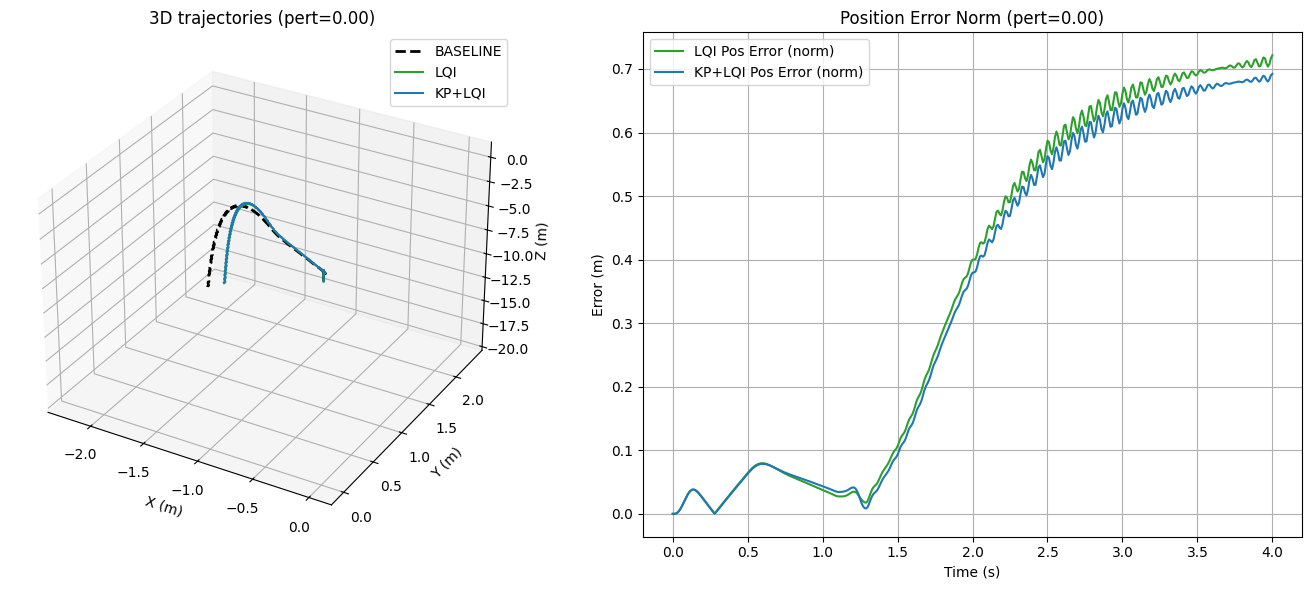

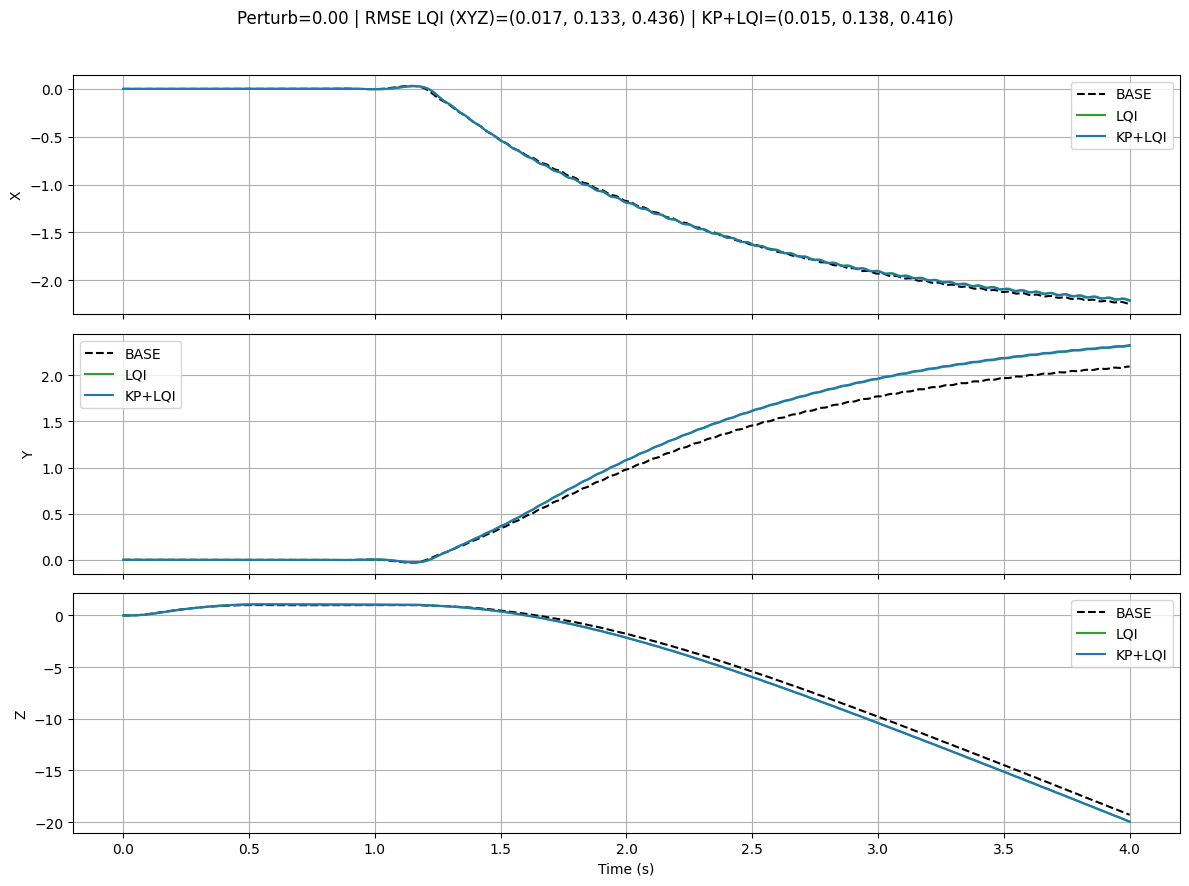

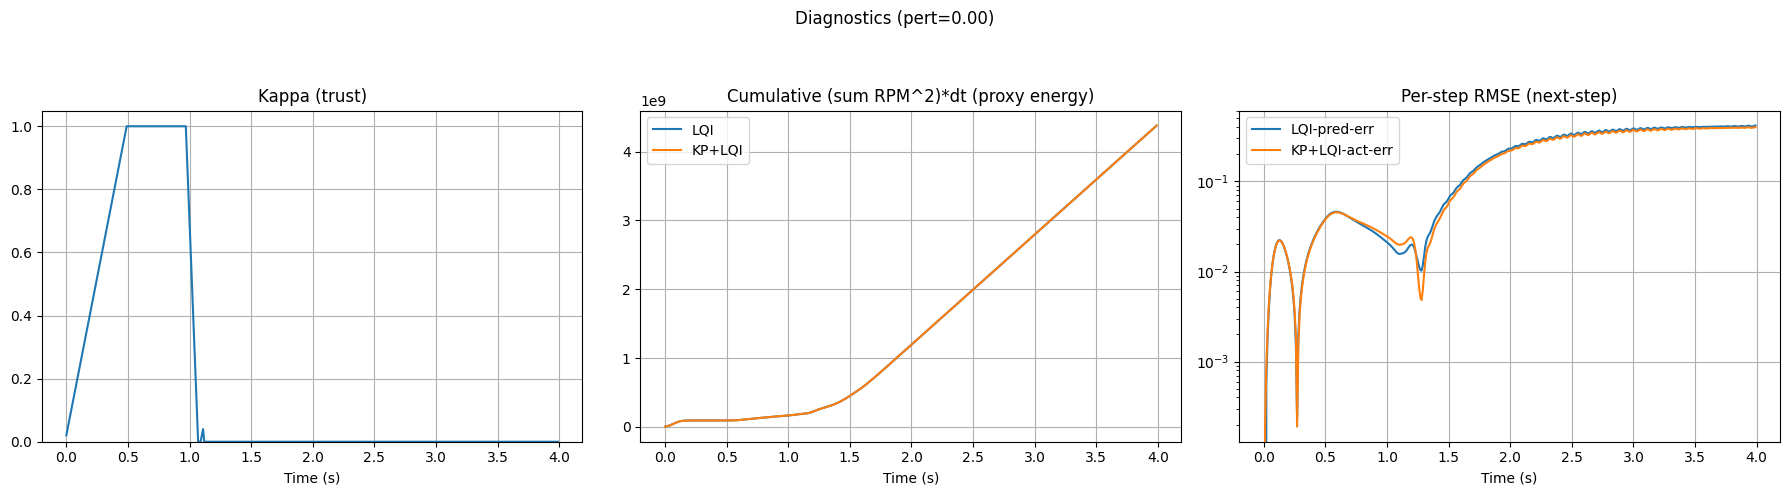


Running scenario perturb=0.050 ...
 LQI     | RMSE X=0.037 Y=0.115 Z=0.445 | Effort=2.39e+05 Energy=2.02e+03
 KP+LQI | RMSE X=0.030 Y=0.135 Z=0.406 | Effort=2.39e+05 Energy=2.01e+03


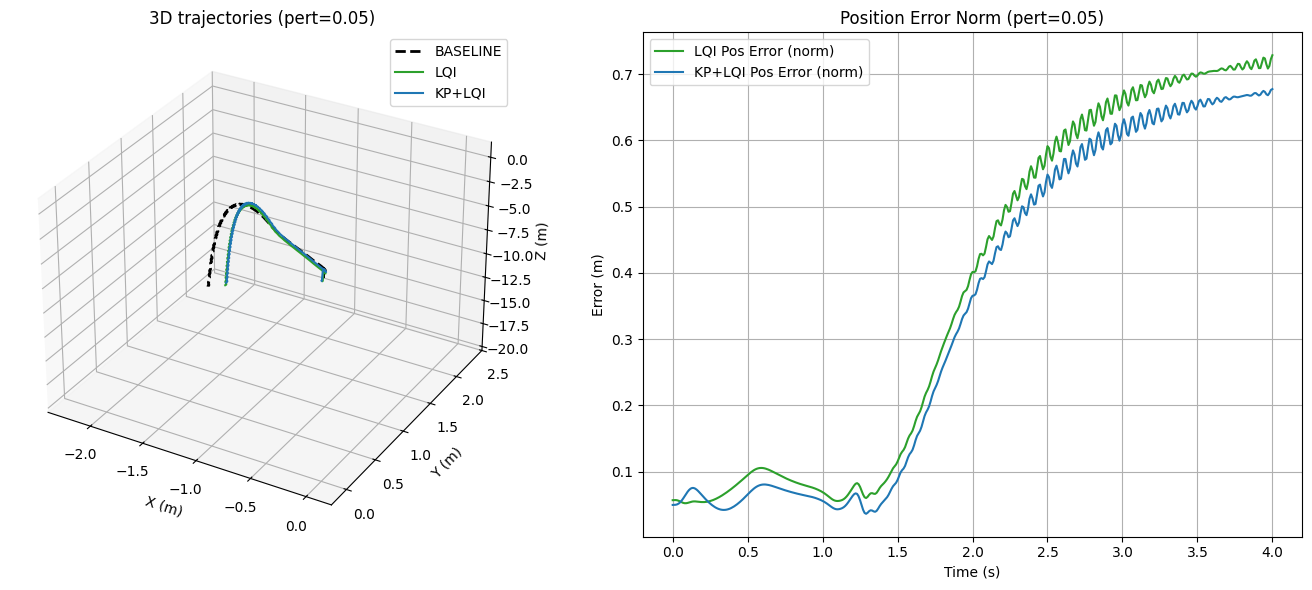

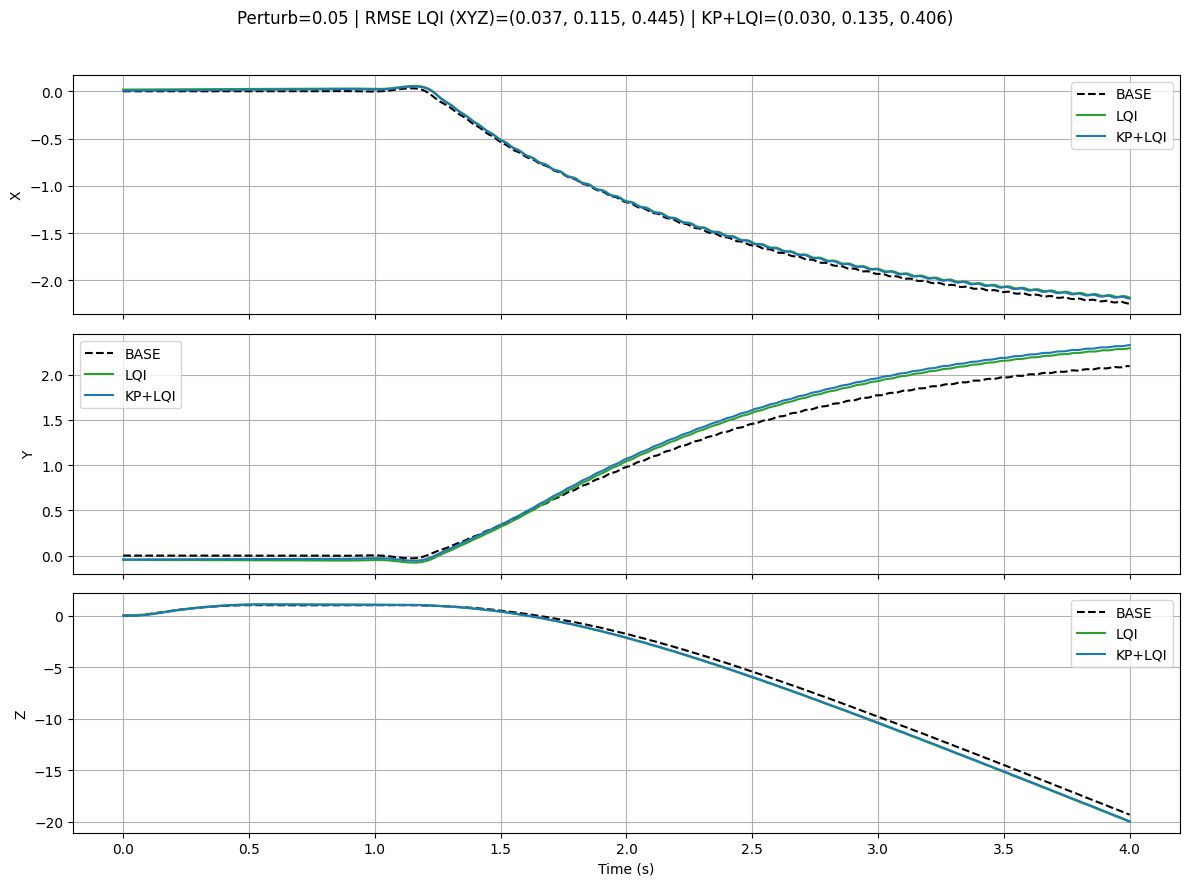

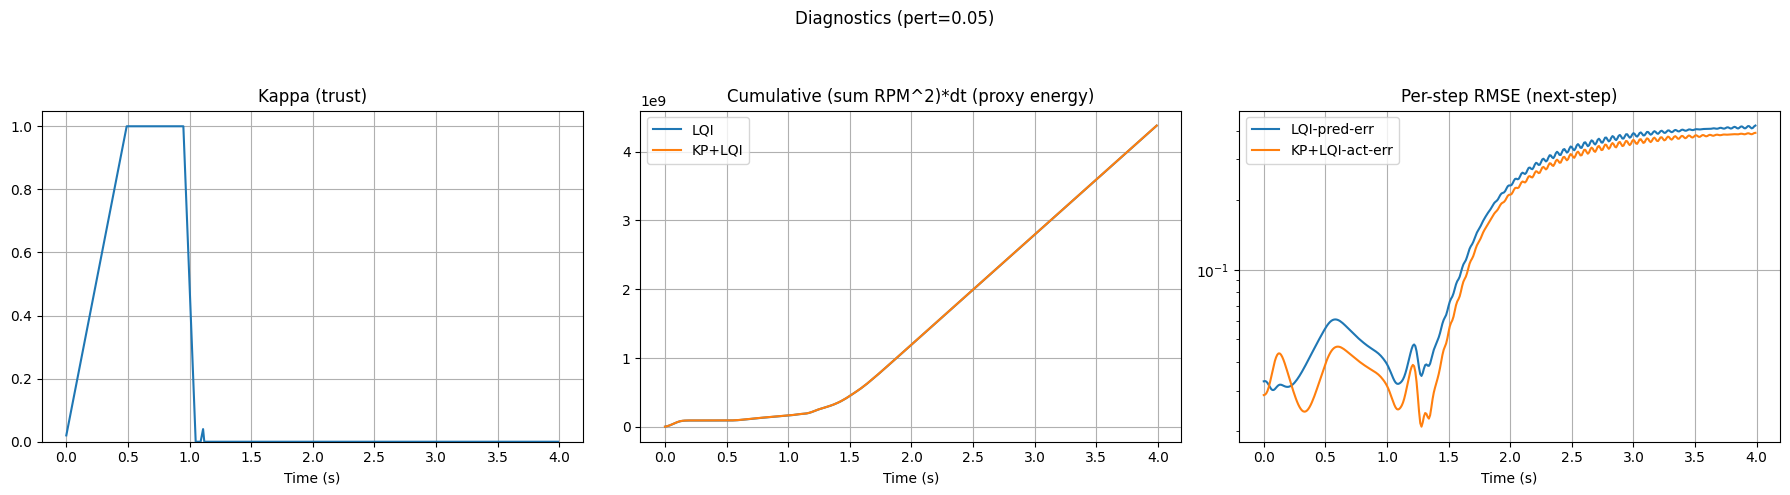


Running scenario perturb=0.150 ...
 LQI     | RMSE X=0.095 Y=0.082 Z=0.472 | Effort=2.39e+05 Energy=2.02e+03
 KP+LQI | RMSE X=0.023 Y=0.120 Z=0.418 | Effort=2.39e+05 Energy=2.01e+03


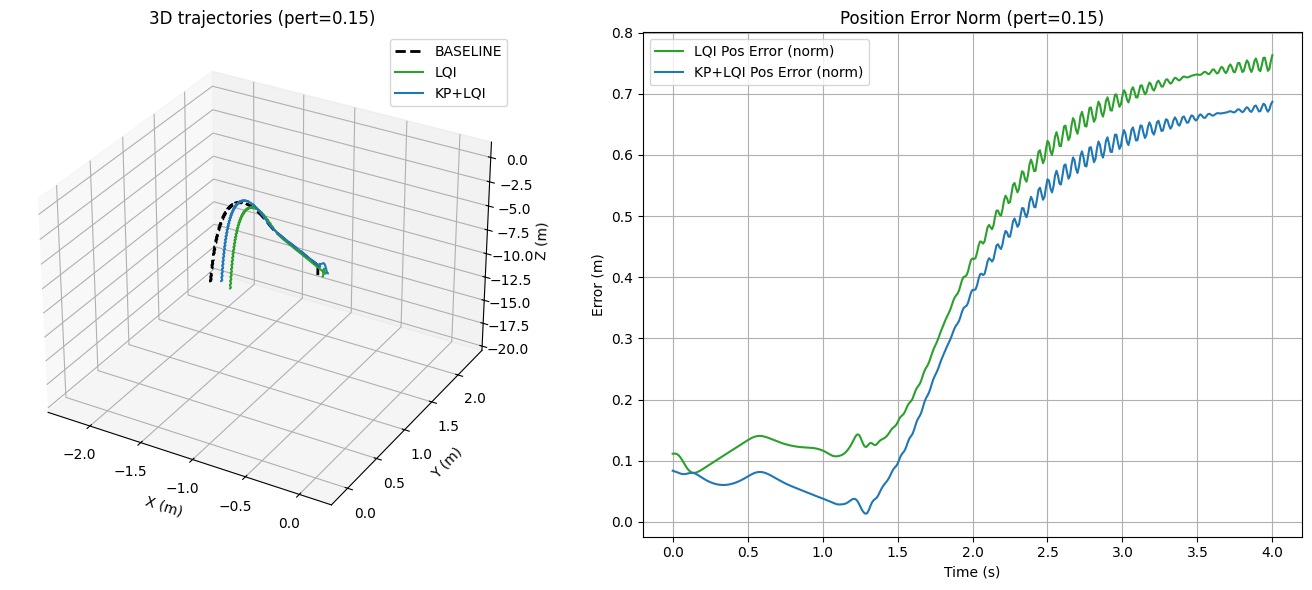

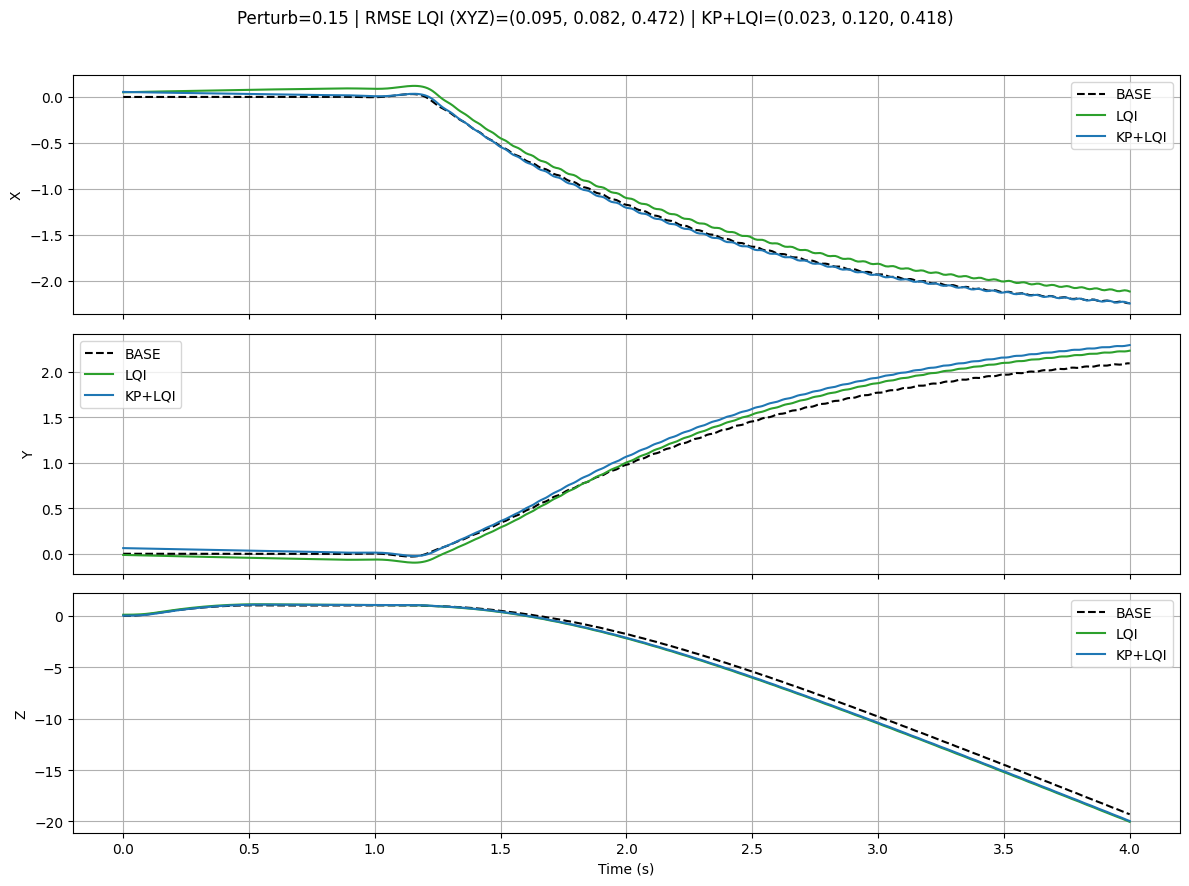

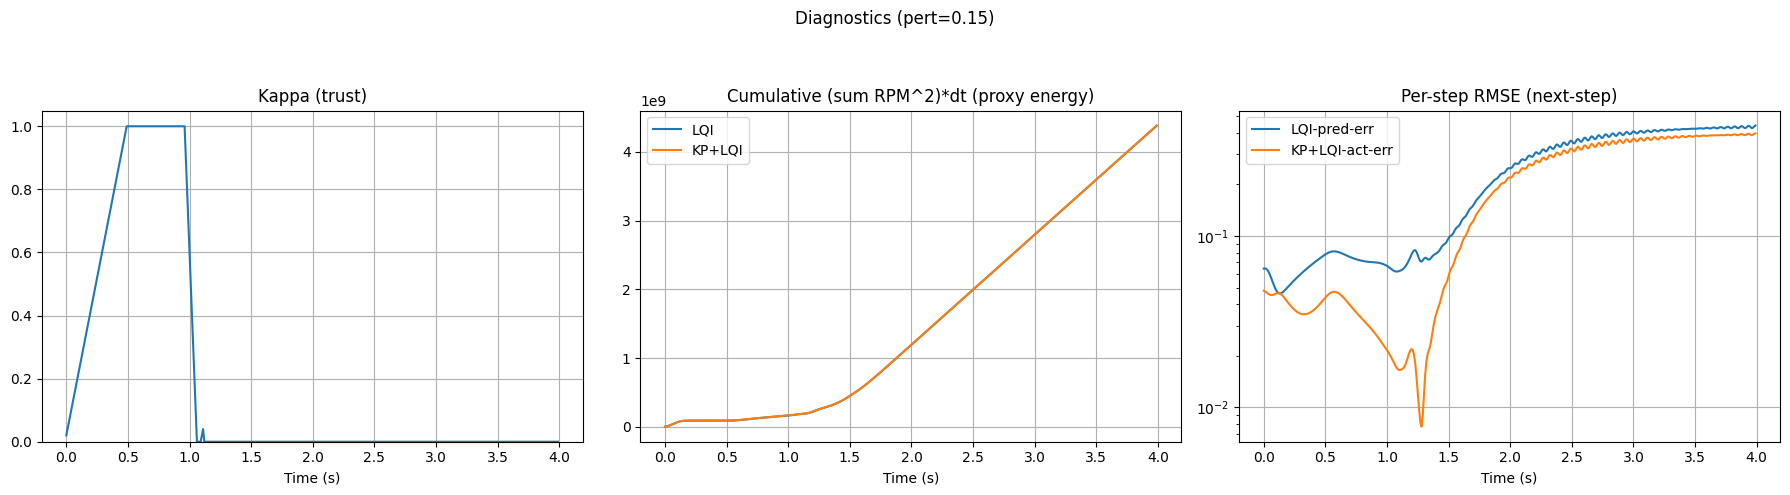


Running scenario perturb=0.350 ...
 LQI     | RMSE X=0.117 Y=0.213 Z=0.378 | Effort=2.39e+05 Energy=2.01e+03
 KP+LQI | RMSE X=0.111 Y=0.203 Z=0.418 | Effort=2.39e+05 Energy=2.01e+03


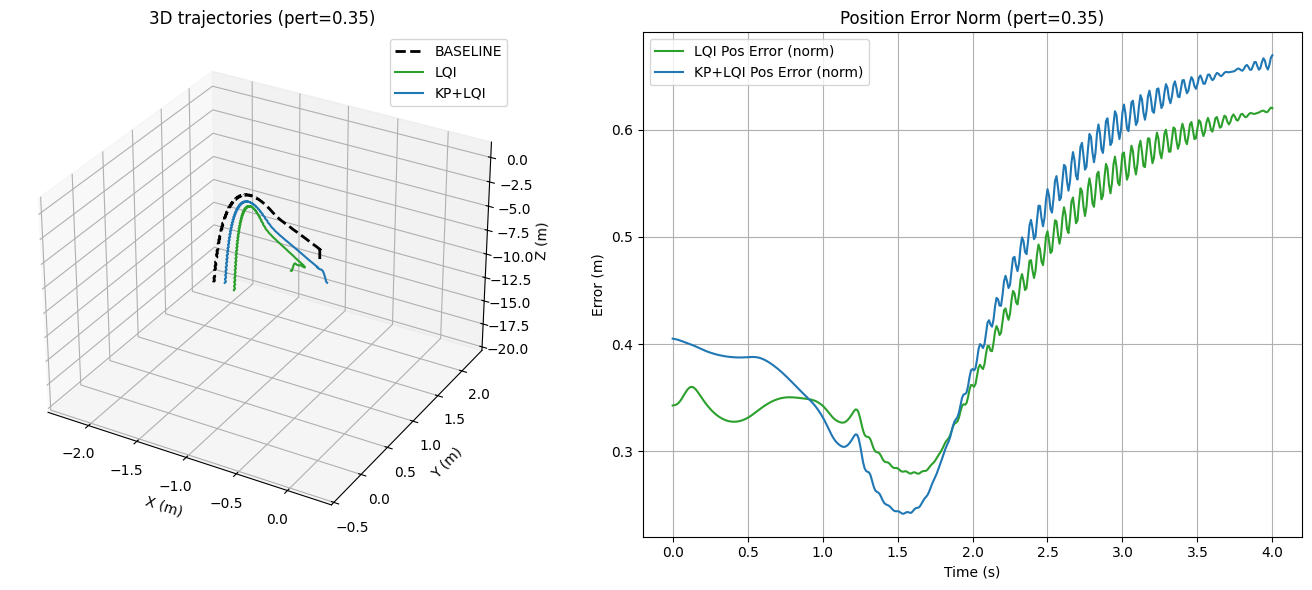

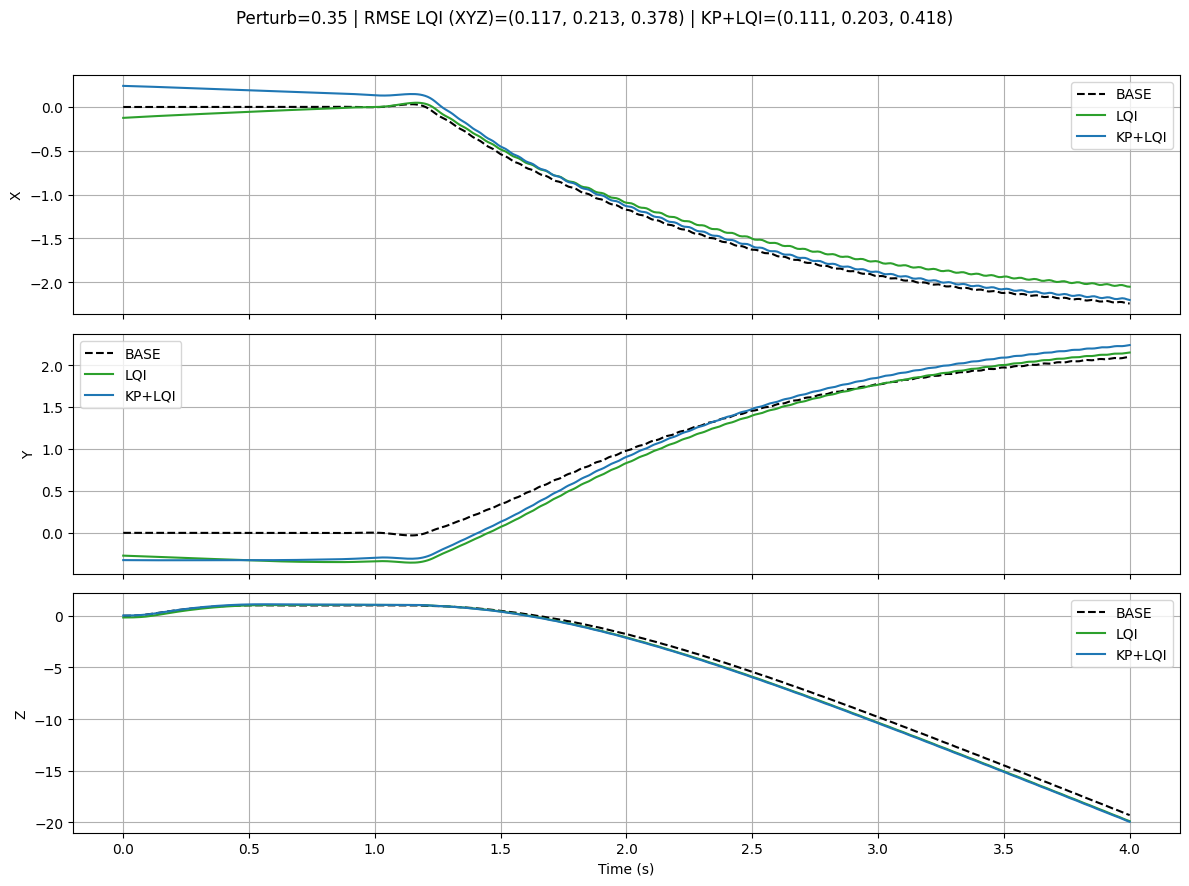

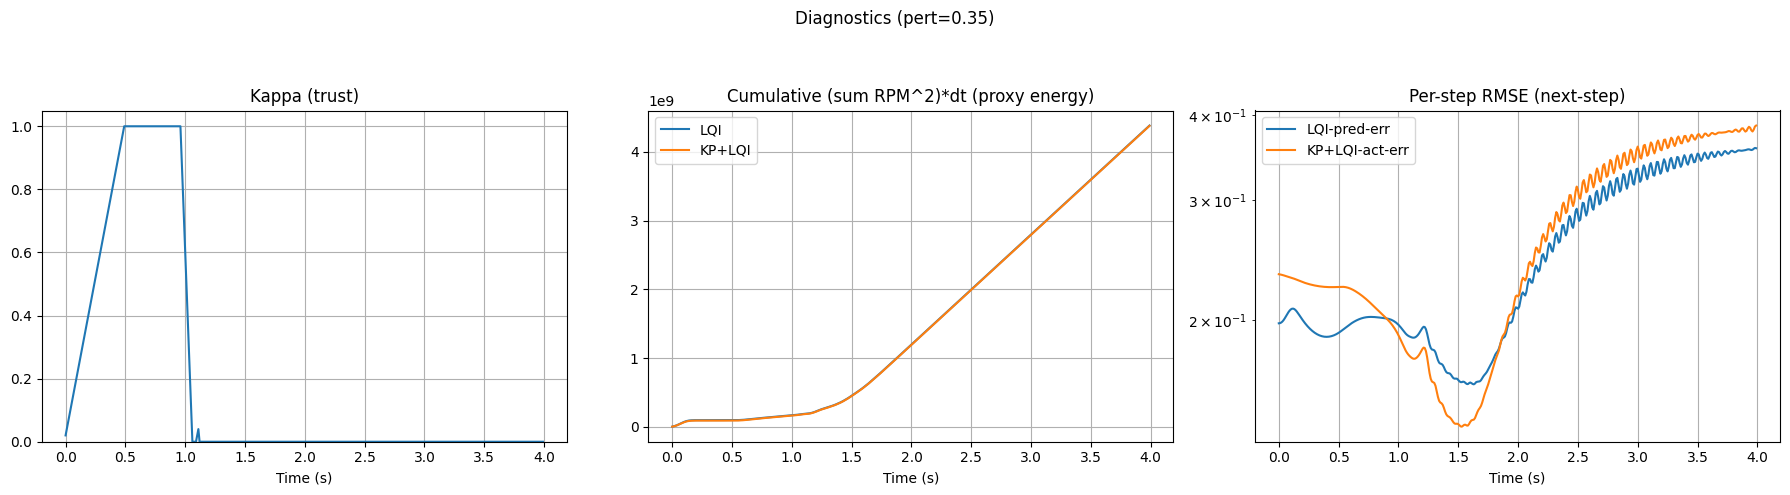


Running scenario perturb=0.700 ...
 LQI     | RMSE X=0.141 Y=0.406 Z=0.616 | Effort=2.41e+05 Energy=2.03e+03
 KP+LQI | RMSE X=0.349 Y=0.386 Z=0.271 | Effort=2.39e+05 Energy=2.00e+03


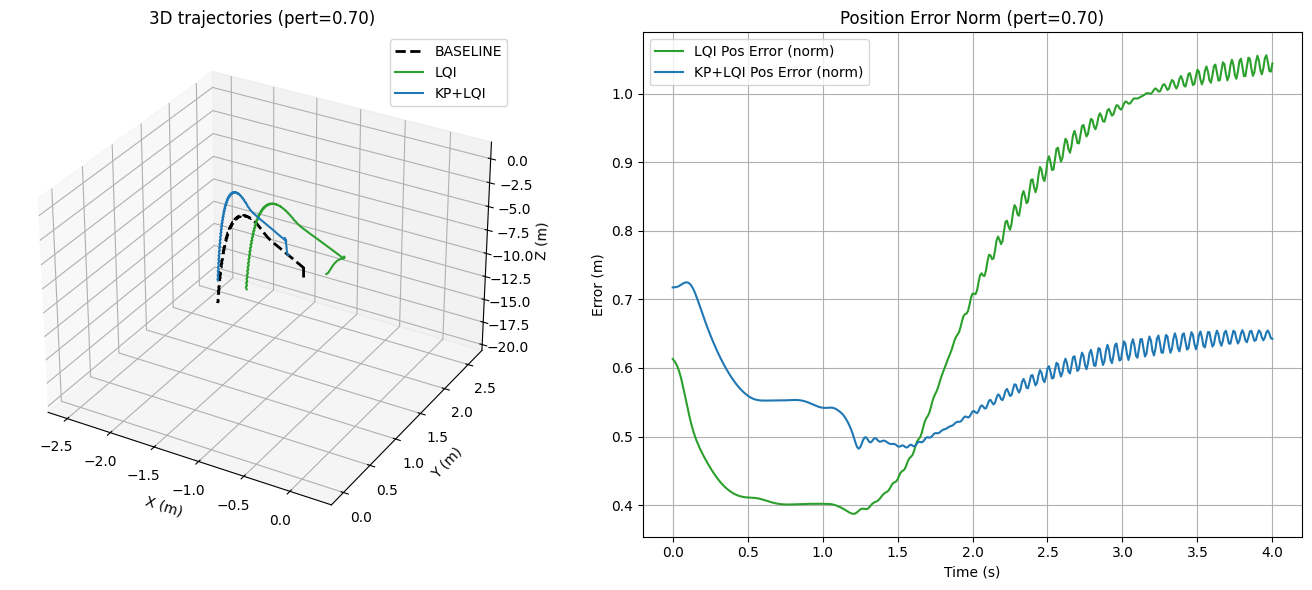

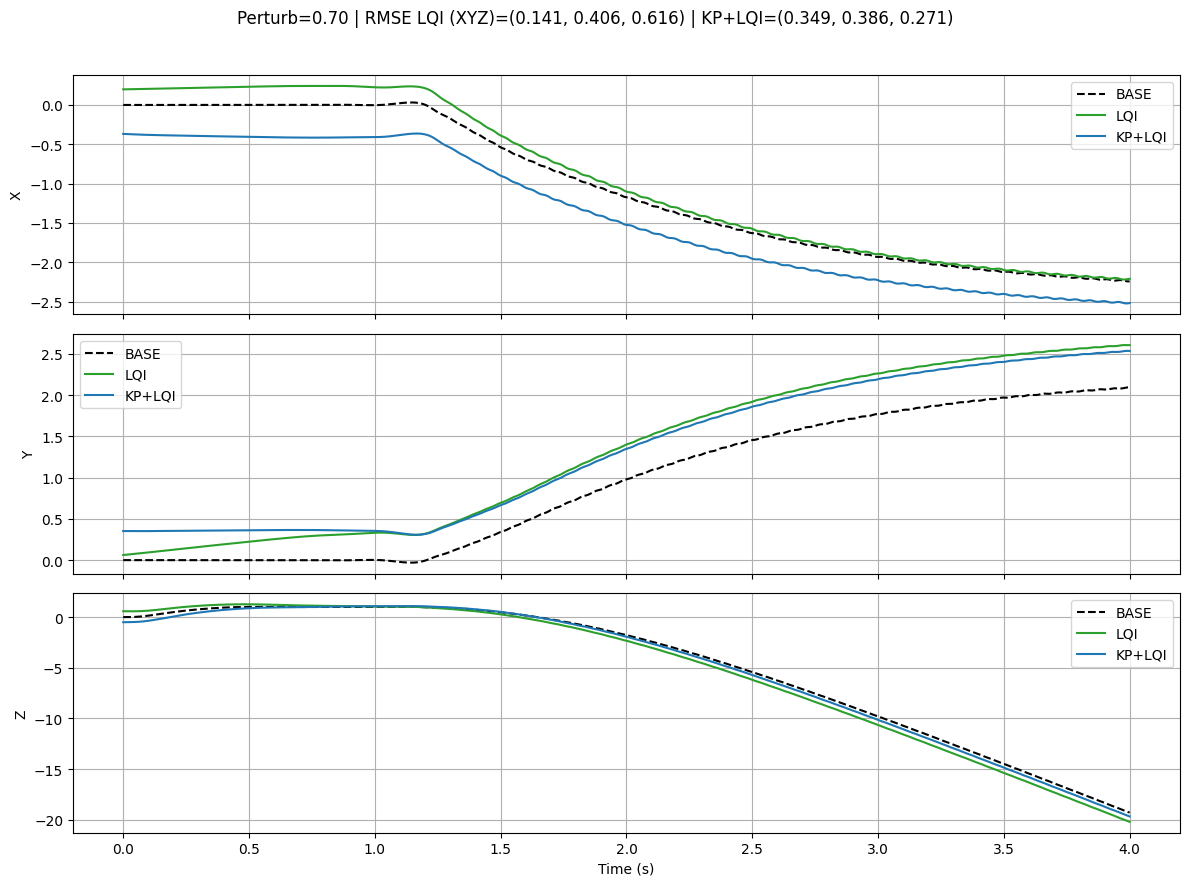

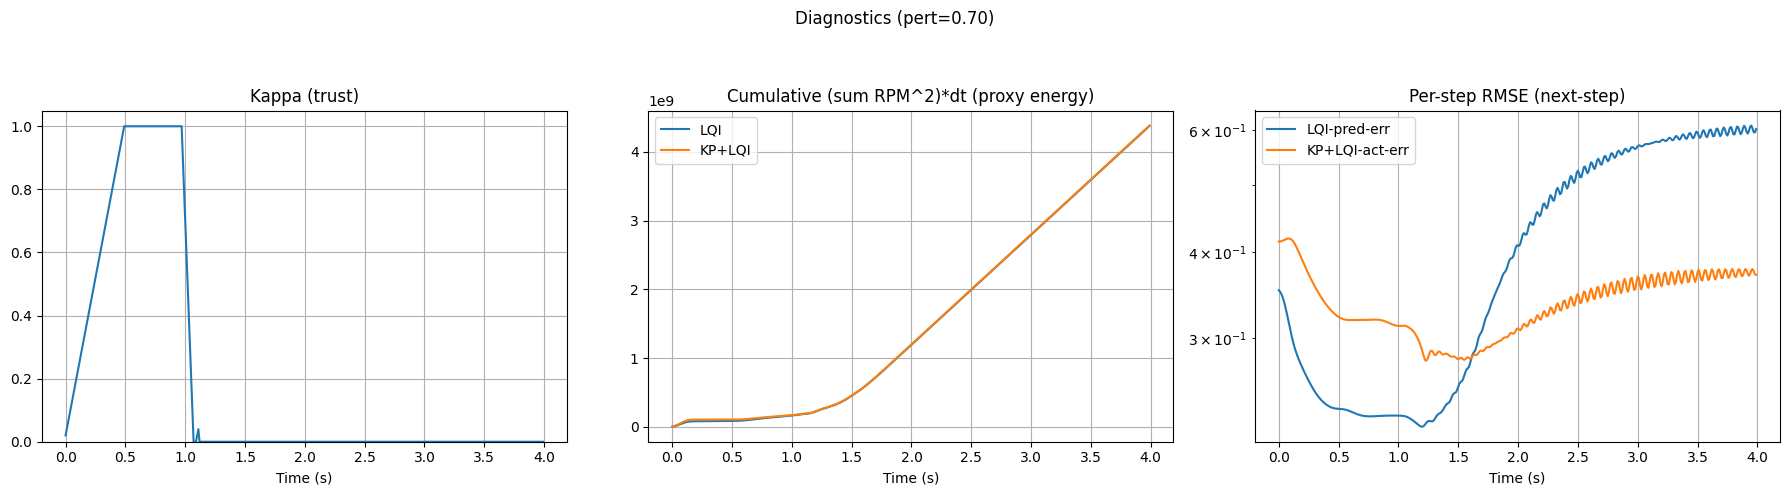


=== AVERAGE METRICS ACROSS SCENARIOS ===
LQI      | Avg RMSE X=0.0814 Y=0.1899 Z=0.4696 | Avg Eff=2.39e+05 Avg Ene=2.02e+03
KP+LQI   | Avg RMSE X=0.1055 Y=0.1965 Z=0.3858 | Avg Eff=2.39e+05 Avg Ene=2.01e+03


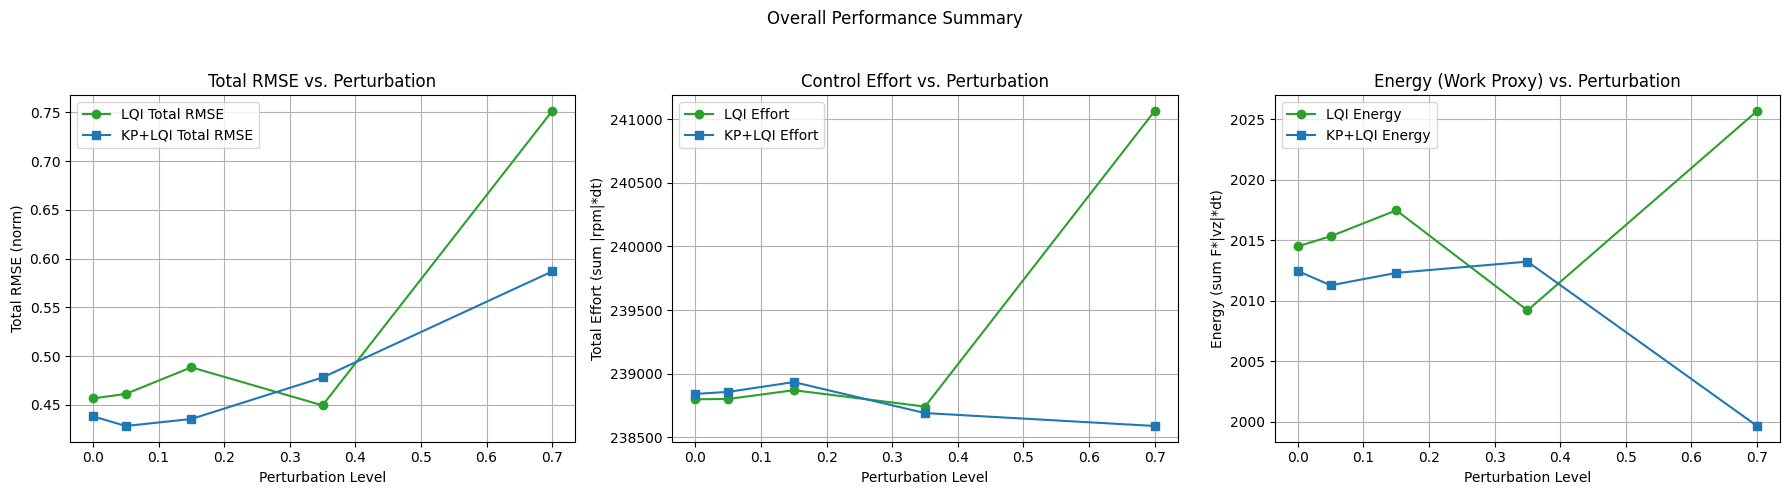

In [ ]:
import numpy as np, time, math
from scipy import linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.set_printoptions(precision=5, suppress=True)

# -------------------- CONFIG / hyperparameters --------------------
DT = 0.01              # integration timestep
T_RUN = 4.0             # seconds per scenario
STEPS = int(T_RUN / DT)
VERBOSE = True

# RLS hyperparameters (learning W mapping Δu -> Δx)
RLS_LAMBDA = 0.995      # forgetting factor
RLS_P0 = 1e6            # initial P diag scalar
RLS_REG = 1e-6          # small numerical reg for inversion

# Koopman-assist regularized inversion hyperparams
DU_REG = 1e-2           # base regularization for solving du = argmin ||W du - dx_err||^2 + reg ||du||^2
DU_MAX = 1500.0         # max delta rpm per motor from assist

# Energy-aware adjustments (new)
BETA = 1              # how strongly LQI increases R when kappa rises (R_eff = R*(1 + BETA*kappa))
LAM_ENERGY = 1e-3       # energy penalty weight for du candidates (higher -> penalize energy more)

# Kappa (trust) adaption
KAPPA_INIT = 0.0
KAPPA_STEP_UP = 0.02
KAPPA_STEP_DOWN = 0.1
KAPPA_MIN, KAPPA_MAX = 0.0, 1.0

# Safety: do not allow Koopman to reduce LQI accuracy: track recent window RMSE
TRUST_WINDOW = int(0.5 / DT)  # 0.5s window
RMSE_FAIL_THRESH = 1.02       # if KP+LQI predicted RMSE > RMSE_LQI * this, then drop κ

# -------------------- RK4 Quadcopter (13D) --------------------
class QuadRK4:
    def __init__(self, dt=DT, m=1.0, L=0.2, k_f=6.11e-8, k_m=1.5e-9, I=np.diag([0.005,0.005,0.009]), max_rpm=20000.0):
        self.dt = dt; self.m = m; self.L = L; self.k_f = k_f; self.k_m = k_m
        self.I = I.astype(np.float64); self.invI = np.linalg.inv(self.I)
        self.max_rpm = float(max_rpm); self.g = np.array([0.0,0.0,-9.81], dtype=np.float64)
        self.reset()
    def reset(self):
        self.pos = np.zeros(3, dtype=np.float64)
        self.vel = np.zeros(3, dtype=np.float64)
        self.q = np.array([1.0,0.0,0.0,0.0], dtype=np.float64)  # w,x,y,z
        self.omega = np.zeros(3, dtype=np.float64)
    def state_vector(self):
        return np.hstack([self.pos, self.q, self.vel, self.omega])
    def set_state_vector(self, s):
        s = np.asarray(s, dtype=np.float64)
        self.pos = s[0:3].copy()
        self.q = s[3:7].copy()
        nq = np.linalg.norm(self.q)
        if nq < 1e-9: self.q = np.array([1.,0.,0.,0.])
        else: self.q /= nq
        self.vel = s[7:10].copy()
        self.omega = s[10:13].copy()
    def quat_to_rotm(self,q):
        w,x,y,z = q
        R = np.array([
            [1 - 2*(y*y + z*z), 2*(x*y - w*z),     2*(x*z + w*y)],
            [2*(x*y + w*z),     1 - 2*(x*x + z*z), 2*(y*z - w*x)],
            [2*(x*z - w*y),     2*(y*z + w*x),     1 - 2*(x*x + y*y)]
        ], dtype=np.float64)
        return R
    def quat_derivative(self, q, omega):
        wx,wy,wz = omega
        Omega = np.array([[0.0,-wx,-wy,-wz],[wx,0.0,wz,-wy],[wy,-wz,0.0,wx],[wz,wy,-wx,0.0]], dtype=np.float64)
        return 0.5 * (Omega @ q)
    def continuous_dynamics(self, state, rpm):
        pos = state[0:3]; q = state[3:7]; vel = state[7:10]; omega = state[10:13]
        rpm = np.clip(rpm, 0.0, self.max_rpm)
        thrusts = self.k_f * (rpm**2)  # per rotor thrust N
        total_thrust = float(np.sum(thrusts))
        tau = np.array([ self.L*(thrusts[1]-thrusts[3]),
                         self.L*(thrusts[2]-thrusts[0]),
                         self.k_m*(thrusts[0]-thrusts[1]+thrusts[2]-thrusts[3]) ], dtype=np.float64)
        R = self.quat_to_rotm(q)
        F_thrust_world = R @ np.array([0.0,0.0,total_thrust], dtype=np.float64)
        vnorm = np.linalg.norm(vel)
        F_drag = -0.1 * vel * vnorm
        acc = (F_thrust_world + F_drag) / self.m + self.g
        pos_dot = vel
        q_dot = self.quat_derivative(q, omega)
        omega_dot = self.invI @ (tau - np.cross(omega, self.I @ omega))
        deriv = np.zeros(13, dtype=np.float64)
        deriv[0:3] = pos_dot
        deriv[3:7] = q_dot
        deriv[7:10] = acc
        deriv[10:13]= omega_dot
        return deriv
    def rk4_step(self, rpm):
        s0 = self.state_vector()
        k1 = self.continuous_dynamics(s0, rpm)
        k2 = self.continuous_dynamics(s0 + 0.5*self.dt*k1, rpm)
        k3 = self.continuous_dynamics(s0 + 0.5*self.dt*k2, rpm)
        k4 = self.continuous_dynamics(s0 + self.dt*k3, rpm)
        s_next = s0 + (self.dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        self.set_state_vector(s_next)
    def hover_rpm_per_motor(self):
        fpm = self.m * abs(self.g[2]) / 4.0
        return float(np.sqrt(max(fpm / self.k_f, 0.0)))

def quat_to_euler(q):
    w,x,y,z = q
    sinr = 2*(w*x + y*z); cosr = 1 - 2*(x*x + y*y); roll = math.atan2(sinr, cosr)
    sinp = 2*(w*y - z*x); pitch = math.copysign(math.pi/2, sinp) if abs(sinp)>=1 else math.asin(sinp)
    siny = 2*(w*z + x*y); cosy = 1 - 2*(y*y + z*z); yaw = math.atan2(siny, cosy)
    return roll,pitch,yaw

# -------------------- Baseline generation (self-consistent PD generator) --------------------
def generate_baseline(sim, T=T_RUN):
    steps = int(T / sim.dt)
    t = np.linspace(0.0, (steps-1)*sim.dt, steps)
    ref = np.zeros((steps, 13), dtype=np.float64)
    # configurable smooth 4D worldline (move around; baseline)
    ref[:,0] = 0.5 * np.sin(0.8 * t)       # x
    ref[:,1] = 0.5 * np.cos(0.5 * t)       # y
    ref[:,2] = 1.0 + 0.05 * np.sin(0.3 * t)  # z
    ref[:,7] = 0.5 * 0.8 * np.cos(0.8*t)     # vx
    ref[:,8] = -0.5 * 0.5 * np.sin(0.5*t)    # vy
    ref[:,9] = 0.05 * 0.3 * np.cos(0.3*t)    # vz
    ref[:,3] = 1.0
    ref[:,4:7] = 0.01 * np.sin(0.2 * t)[:,None]
    for i in range(steps): ref[i,3:7] /= np.linalg.norm(ref[i,3:7])
    # generate x_seq, u_seq dynamically by using a mild PD that follows ref (so baseline is self-consistent)
    x_seq = np.zeros((steps+1, 13), dtype=np.float64)
    u_seq = np.zeros((steps, 4), dtype=np.float64)
    sim.reset()
    x_seq[0,:] = sim.state_vector()
    u_prev = np.ones(4) * sim.hover_rpm_per_motor()
    # PD gains for baseline generator (conservative)
    Kp_z = 80.0; Kd_z = 20.0
    Kp_att = 6.0
    for k in range(steps):
        x = sim.state_vector(); x_ref = ref[k]
        # altitude PD
        z_err = x_ref[2] - x[2]; vz_err = x_ref[9] - x[9]
        thrust_total = sim.m * abs(sim.g[2]) + Kp_z*z_err + Kd_z*vz_err
        # attitude try to keep small reference tilt from ref quaternion
        roll_ref, pitch_ref, _ = quat_to_euler(x_ref[3:7])
        roll, pitch, _ = quat_to_euler(x[3:7])
        tx = Kp_att * (roll_ref - roll)
        ty = Kp_att * (pitch_ref - pitch)
        tz = -0.5 * x[12] if x.size>12 else 0.0
        f0 = thrust_total/4.0 - ty/(2*sim.L) + tz/(4*sim.k_m)
        f1 = thrust_total/4.0 + tx/(2*sim.L) - tz/(4*sim.k_m)
        f2 = thrust_total/4.0 + ty/(2*sim.L) + tz/(4*sim.k_m)
        f3 = thrust_total/4.0 - tx/(2*sim.L) - tz/(4*sim.k_m)
        forces = np.array([f0,f1,f2,f3], dtype=np.float64)
        rpm = np.sqrt(np.clip(forces / sim.k_f, 0.0, None))
        rpm = 0.2 * rpm + 0.8 * u_prev
        rpm = np.clip(rpm, 0.0, sim.max_rpm)
        u_seq[k,:] = rpm.copy()
        sim.rk4_step(rpm)
        x_seq[k+1,:] = sim.state_vector()
        u_prev = rpm.copy()
    return ref, x_seq, u_seq

# -------------------- TV-LQI-Z (augmented DARE around ref, returns rpm) ------------
def linearize_discrete_map(sim, x_ref, u_ref, eps=1e-6):
    saved = sim.state_vector().copy()
    nx = x_ref.size; nu = u_ref.size
    A = np.zeros((nx,nx), dtype=np.float64)
    B = np.zeros((nx,nu), dtype=np.float64)
    # baseline next
    sim.set_state_vector(x_ref.copy()); sim.rk4_step(u_ref); xnext_base = sim.state_vector().copy()
    for i in range(nx):
        dx = np.zeros(nx); dx[i] = eps
        sim.set_state_vector(x_ref + dx); sim.rk4_step(u_ref); xp = sim.state_vector().copy()
        A[:,i] = (xp - xnext_base) / eps
    # inputs
    for j in range(nu):
        du = np.zeros(nu); du[j] = eps
        sim.set_state_vector(x_ref.copy()); sim.rk4_step(u_ref + du); xu = sim.state_vector().copy()
        B[:,j] = (xu - xnext_base) / eps
    sim.set_state_vector(saved)
    return A, B

def tv_lqi_z_rpm(sim, x, x_ref, u_ff, R_scale=1.0):
    # Build augmented system with Z-integral (1 integrator), solve DARE and compute delta_u
    try:
        A,B = linearize_discrete_map(sim, x_ref, u_ff, eps=1e-6)
        nx = A.shape[0]; nu = B.shape[1]
        # C selects Z position (index 2)
        C = np.zeros((1,nx)); C[0,2] = 1.0
        # Augment
        A_aug = np.block([[A, np.zeros((nx,1))],
                          [C, np.eye(1)]])   # (nx+1, nx+1)
        B_aug = np.vstack([B, np.zeros((1,nu))])  # (nx+1, nu)
        # Cost
        Q_state = np.diag([5.0,5.0,200.0] + [1.0]*10)  # strong Z
        Q_i = np.array([[50.0]])
        Q_aug = linalg.block_diag(Q_state, Q_i)
        R = np.eye(nu) * 0.01 * float(R_scale)    # <-- scaled by R_scale (energy-aware)
        P = linalg.solve_discrete_are(A_aug, B_aug, Q_aug, R)
        S = R + B_aug.T @ P @ B_aug
        K_aug = np.linalg.solve(S, B_aug.T @ P @ A_aug) # shape (4, nx+1)
        # state error (chordal quaternion)
        dx = x - x_ref
        q = x[3:7].copy(); q_ref = x_ref[3:7]
        if np.dot(q, q_ref) < 0: q = -q
        dx[3:7] = q - q_ref
        # integral state assumed maintained externally; caller will provide zero if none
        z_int = 0.0
        x_aug = np.hstack([dx, z_int])
        delta_u = -K_aug @ x_aug
        delta_u = np.clip(delta_u, -2000.0, 2000.0)
        u_cmd = np.clip(u_ff + delta_u, 0.0, sim.max_rpm)
        return u_cmd
    except Exception as e:
        if VERBOSE:
            print(f"Warning: LQI solve failed: {e}")
        return np.clip(u_ff, 0.0, sim.max_rpm)

# -------------------- RMSE / metrics utilities --------------------
def rmse_per_axis(x_hist, x_ref):
    err = x_hist[:,:3] - x_ref[:,:3]
    return float(np.sqrt(np.mean(err[:,0]**2))), float(np.sqrt(np.mean(err[:,1]**2))), float(np.sqrt(np.mean(err[:,2]**2)))

def compute_effort_energy(u_hist, x_hist, sim):
    dt = sim.dt
    effort = np.sum(np.sum(np.abs(u_hist), axis=1)) * dt
    thrusts = sim.k_f * (u_hist**2)
    vz = x_hist[:-1,9]
    total_th = np.sum(thrusts, axis=1)
    # Energy approximation (work done against gravity/drag, simplified)
    # More accurate would be P = F*v (thrust * velocity_along_thrust_axis)
    # Using vz as proxy for vertical work
    energy = np.sum(total_th * np.abs(vz) * dt)
    return float(effort), float(energy)

# -------------------- RLS object (learn W: dx = W du ) --------------------
class RLSLearner:
    def __init__(self, nx=13, nu=4, lam=RLS_LAMBDA, P0=RLS_P0):
        self.nx = nx; self.nu = nu
        self.lam = lam
        self.W = np.zeros((nx, nu), dtype=np.float64)
        self.P_rows = [np.eye(nu, dtype=np.float64) * P0 for _ in range(nx)]
        self.w_rows = [np.zeros(nu, dtype=np.float64) for _ in range(nx)]
    def predict_dx(self, du):
        return (np.vstack(self.w_rows) @ du).reshape(self.nx,)
    def update(self, du, dx_obs):
        du = du.reshape(-1)
        for i in range(self.nx):
            P = self.P_rows[i]
            w = self.w_rows[i]
            denom = self.lam + float(du @ (P @ du))
            k = (P @ du) / (denom + 1e-12)
            r = float(dx_obs[i] - (w @ du))
            w = w + k * r
            P = (P - np.outer(k, (du @ P))) / self.lam
            self.w_rows[i] = w
            self.P_rows[i] = P
        self.W = np.vstack(self.w_rows)

# -------------------- Koopman-assist function using learned W --------------------
def koopman_assist_from_W(W, dx_err, du_reg=DU_REG, du_max=DU_MAX):
    W = np.asarray(W, dtype=np.float64)
    nx, nu = W.shape
    A = W.T @ W + du_reg * np.eye(nu)
    b = W.T @ dx_err
    try:
        du = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        du = np.linalg.lstsq(A, b, rcond=None)[0]
    du = np.clip(du, -du_max, du_max)
    return du

# -------------------- Runner for a single scenario (LQI-only vs KP+LQI) ------------
def run_scenario(sim_master, x_baseline, u_baseline, perturb=0.0, use_koopman=False, rls_init=None):
    N = u_baseline.shape[0]
    sim = QuadRK4(dt=sim_master.dt, m=sim_master.m, L=sim_master.L, k_f=sim_master.k_f, k_m=sim_master.k_m, I=sim_master.I, max_rpm=sim_master.max_rpm)
    x0 = x_baseline[0].copy()

    # --- FIX: Use 'perturb' (the argument) instead of 'pert' ---
    x0[0:3] += np.random.uniform(-perturb, perturb, 3)
    x0[7:10] += np.random.uniform(-perturb, perturb, 3) * 0.5
    x0[3:7] += np.random.uniform(-0.01*perturb, 0.01*perturb, 4)
    # --- End Fix ---

    if np.linalg.norm(x0[3:7]) < 1e-9: x0[3:7] = np.array([1.,0.,0.,0.])
    x0[3:7] /= np.linalg.norm(x0[3:7])
    sim.set_state_vector(x0.copy())

    x_hist = np.zeros((N+1, 13), dtype=np.float64)
    u_hist = np.zeros((N,4), dtype=np.float64)
    x_hist[0,:] = sim.state_vector()
    rls = rls_init if rls_init is not None else RLSLearner(nx=13, nu=4)
    kappa = KAPPA_INIT
    kappa_hist = np.zeros(N, dtype=np.float64)
    rmse_lqi_t = np.zeros(N, dtype=np.float64)
    rmse_kp_t  = np.zeros(N, dtype=np.float64)
    u_prev = u_baseline[0].copy()
    effort_cum = np.zeros(N, dtype=np.float64)
    energy_cum = np.zeros(N, dtype=np.float64)

    for k in range(N):
        x = sim.state_vector()
        x_ref = x_baseline[k]
        u_ref = u_baseline[k]

        # compute LQI with R scaled by kappa (so LQI penalizes effort when KP trusted)
        R_scale = 1.0 + BETA * kappa
        u_lqi = tv_lqi_z_rpm(sim, x, x_ref, u_ref, R_scale=R_scale)
        u_cmd_final = u_lqi.copy()

        # Koopman assist logic and energy-aware du regularization
        if use_koopman:
            dx_err = x - x_ref
            q = x[3:7].copy(); qref = x_ref[3:7]
            if np.dot(q, qref) < 0: q = -q
            dx_err[3:7] = q - qref

            W = rls.W
            # baseline candidate (low-reg)
            du_candidate = koopman_assist_from_W(W, -dx_err, du_reg=DU_REG, du_max=DU_MAX)

            # Energy-aware penalty: estimate additional energy introduced by applying du_candidate on top of u_lqi
            energy_base = np.sum(u_lqi**2)
            energy_candidate = np.sum((u_lqi + du_candidate)**2)
            # normalized energy increase fraction
            energy_increase_fraction = max(0.0, (energy_candidate - energy_base) / (1e-6 + energy_base))
            # scale du_reg by factor proportional to energy increase -> discourages high-energy candidate
            du_reg_scaled = DU_REG * (1.0 + LAM_ENERGY * energy_increase_fraction * 100.0)
            # recompute candidate with scaled reg
            du_candidate = koopman_assist_from_W(W, -dx_err, du_reg=du_reg_scaled, du_max=DU_MAX)

            # candidate command with kappa weighting
            u_kp_candidate = np.clip(u_lqi + kappa * du_candidate, 0.0, sim.max_rpm)
            # predictive check: simulate one step
            sim_clone = QuadRK4(dt=sim.dt, m=sim.m, L=sim.L, k_f=sim.k_f, k_m=sim.k_m, I=sim.I, max_rpm=sim.max_rpm)
            sim_clone.set_state_vector(sim.state_vector().copy())
            sim_clone.rk4_step(u_kp_candidate)
            x_predict = sim_clone.state_vector()
            target_next = x_baseline[k+1] if k+1 <= x_baseline.shape[0]-1 else x_baseline[-1]

            err_kp = x_predict[:3] - target_next[:3]
            # LQI-only predicted next
            sim_clone2 = QuadRK4(dt=sim.dt, m=sim.m, L=sim.L, k_f=sim.k_f, k_m=sim.k_m, I=sim.I, max_rpm=sim.max_rpm)
            sim_clone2.set_state_vector(sim.state_vector().copy())
            sim_clone2.rk4_step(u_lqi)
            x_predict_lqi = sim_clone2.state_vector()
            err_lqi_vec = x_predict_lqi[:3] - target_next[:3]

            rmse_pred_kp = math.sqrt(float(np.mean(err_kp**2)))
            rmse_pred_lqi = math.sqrt(float(np.mean(err_lqi_vec**2)))

            # Accept candidate only if predicted RMSE not worse than LQI_pred*threshold
            if rmse_pred_kp <= rmse_pred_lqi * RMSE_FAIL_THRESH:
                u_cmd_final = u_kp_candidate.copy()
                # compute residual between W*(kappa*du) and observed dx predicted (approx)
                dx_pred_from_W = W @ (kappa * du_candidate)
                dx_obs = x_predict - x
                residual = np.linalg.norm(dx_obs - dx_pred_from_W)
                # adapt kappa
                if residual < 1.0:
                    kappa = min(KAPPA_MAX, kappa + KAPPA_STEP_UP)
                else:
                    kappa = max(KAPPA_MIN, kappa - KAPPA_STEP_DOWN)
            else:
                u_cmd_final = u_lqi.copy()
                kappa = max(KAPPA_MIN, kappa - KAPPA_STEP_DOWN)

        # smoothing and apply
        alpha = 0.35
        u_cmd_sm = alpha * u_cmd_final + (1-alpha) * u_prev
        u_cmd_sm = np.clip(u_cmd_sm, 0.0, sim.max_rpm)
        sim.rk4_step(u_cmd_sm)
        x_next = sim.state_vector()
        x_hist[k+1,:] = x_next.copy()
        u_hist[k,:] = u_cmd_sm.copy()
        kappa_hist[k] = kappa

        # metrics and RLS update
        # hypothetical LQI-only next (for comparison)
        sim_tmp = QuadRK4(dt=sim.dt, m=sim.m, L=sim.L, k_f=sim.k_f, k_m=sim.k_m, I=sim.I, max_rpm=sim.max_rpm)
        sim_tmp.set_state_vector(x.copy()); sim_tmp.rk4_step(u_lqi); x_lqi_next = sim_tmp.state_vector()

        target_next_safe = x_baseline[k+1] if k+1 < len(x_baseline) else x_baseline[-1]

        rmse_lqi_t[k] = math.sqrt(float(np.mean(((x_lqi_next - target_next_safe)[:3])**2)))
        rmse_kp_t[k]  = math.sqrt(float(np.mean(((x_next - target_next_safe)[:3])**2)))

        # update RLS using the actual applied delta_u and observed delta_x
        du_applied = (u_cmd_sm - u_lqi).copy()
        dx_observed = (x_next - x).copy()
        if np.linalg.norm(du_applied) > 1e-6:
            rls.update(du_applied, dx_observed)

        u_prev = u_cmd_sm.copy()
        effort_cum[k] = np.sum(np.abs(u_hist[:k+1,:])) * sim.dt
        e_thrusts = sim.k_f * (u_hist[:k+1,:]**2)
        vz = x_hist[:k+1,9]
        total_th = np.sum(e_thrusts, axis=1)
        energy_cum[k] = np.sum(total_th * np.abs(vz) * sim.dt)

    rmse_axis = rmse_per_axis(x_hist, x_baseline)
    effort, energy = compute_effort_energy(u_hist, x_hist, sim)
    return {
        'x_hist': x_hist, 'u_hist': u_hist,
        'rmse_axis': rmse_axis, 'effort': effort, 'energy': energy,
        'kappa_hist': kappa_hist, 'rmse_lqi_t': rmse_lqi_t, 'rmse_kp_t': rmse_kp_t,
        'rls': rls
    }

# -------------------- MASTER: generate baseline, run multiple perturb scenarios --------------------
def master_run(perturb_levels=[0.0, 0.05, 0.15, 0.35, 0.7], do_plot=True):
    sim_tmp = QuadRK4(dt=DT)
    print("Generating baseline (self-consistent) ...")
    ref, x_baseline, u_baseline = generate_baseline(sim_tmp, T=T_RUN)
    print(f"Baseline generated. Steps: {u_baseline.shape[0]}")
    results = {'lqi':[], 'kp+lqi':[]}

    # --- FIX: Define time axes based on state (N+1) and control (N) lengths ---
    # t_axis_state has N+1 points (e.g., 801) for x_baseline and x_hist
    t_axis_state = np.arange(x_baseline.shape[0]) * DT
    # t_axis_control has N points (e.g., 800) for u_hist, kappa, etc.
    t_axis_control = np.arange(u_baseline.shape[0]) * DT
    # --- End Fix ---


    for pert in perturb_levels:
        print(f"\nRunning scenario perturb={pert:.3f} ...")
        res_lqi = run_scenario(sim_tmp, x_baseline, u_baseline, perturb=pert, use_koopman=False, rls_init=None)
        rls_init = RLSLearner(nx=13, nu=4)
        res_kp = run_scenario(sim_tmp, x_baseline, u_baseline, perturb=pert, use_koopman=True, rls_init=rls_init)
        results['lqi'].append((pert, res_lqi))
        results['kp+lqi'].append((pert, res_kp))
        rx_l, ry_l, rz_l = res_lqi['rmse_axis']
        rx_k, ry_k, rz_k = res_kp['rmse_axis']
        print(f" LQI     | RMSE X={rx_l:.3f} Y={ry_l:.3f} Z={rz_l:.3f} | Effort={res_lqi['effort']:.2e} Energy={res_lqi['energy']:.2e}")
        print(f" KP+LQI | RMSE X={rx_k:.3f} Y={ry_k:.3f} Z={rz_k:.3f} | Effort={res_kp['effort']:.2e} Energy={res_kp['energy']:.2e}")

        if do_plot:
            fig = plt.figure(figsize=(14,6))
            ax3d = fig.add_subplot(121, projection='3d')
            ax3d.plot(x_baseline[:,0], x_baseline[:,1], x_baseline[:,2], 'k--', label='BASELINE', linewidth=2)
            ax3d.plot(res_lqi['x_hist'][:,0], res_lqi['x_hist'][:,1], res_lqi['x_hist'][:,2], color='tab:green', label='LQI')
            ax3d.plot(res_kp['x_hist'][:,0], res_kp['x_hist'][:,1], res_kp['x_hist'][:,2], color='tab:blue', label='KP+LQI')
            ax3d.set_title(f"3D trajectories (pert={pert:.2f})"); ax3d.legend()
            ax3d.set_xlabel("X (m)"); ax3d.set_ylabel("Y (m)"); ax3d.set_zlabel("Z (m)")

            # Plot for XYZ errors
            ax_err = fig.add_subplot(122)
            # --- FIX: Use x_baseline (N+1) length for error calculation ---
            err_lqi = np.linalg.norm(res_lqi['x_hist'][:,:3] - x_baseline[:,:3], axis=1)
            err_kp = np.linalg.norm(res_kp['x_hist'][:,:3] - x_baseline[:,:3], axis=1)
            # --- FIX: Use t_axis_state (N+1) for plotting state errors ---
            ax_err.plot(t_axis_state, err_lqi, color='tab:green', label='LQI Pos Error (norm)')
            ax_err.plot(t_axis_state, err_kp, color='tab:blue', label='KP+LQI Pos Error (norm)')
            # --- End Fix ---
            ax_err.set_title(f'Position Error Norm (pert={pert:.2f})')
            ax_err.set_xlabel('Time (s)')
            ax_err.set_ylabel('Error (m)')
            ax_err.legend()
            ax_err.grid(True)
            plt.tight_layout()
            plt.show()


            fig2, axs = plt.subplots(3,1,figsize=(12,9), sharex=True)
            labels = ['X','Y','Z']
            for i in range(3):
                # --- FIX: Use t_axis_state (N+1) for all state plots ---
                axs[i].plot(t_axis_state, x_baseline[:,i], 'k--', label='BASE')
                axs[i].plot(t_axis_state, res_lqi['x_hist'][:,i], color='tab:green', label='LQI')
                axs[i].plot(t_axis_state, res_kp['x_hist'][:,i], color='tab:blue', label='KP+LQI')
                # --- End Fix ---
                axs[i].set_ylabel(labels[i])
                axs[i].grid(True)
                axs[i].legend()
            axs[2].set_xlabel('Time (s)')
            plt.suptitle(f'Perturb={pert:.2f} | RMSE LQI (XYZ)=({rx_l:.3f}, {ry_l:.3f}, {rz_l:.3f}) | KP+LQI=({rx_k:.3f}, {ry_k:.3f}, {rz_k:.3f})')
            plt.tight_layout(rect=[0,0,1,0.96])
            plt.show()

            # kappa and cumulative energy + RMSE vs time
            fig3, axes = plt.subplots(1,3,figsize=(18,5))
            # --- FIX: Use t_axis_control (N) for control-related plots ---
            axes[0].plot(t_axis_control, res_kp['kappa_hist'])
            axes[0].set_title('Kappa (trust)'); axes[0].set_xlabel('Time (s)'); axes[0].grid(True)
            axes[0].set_ylim(KAPPA_MIN, KAPPA_MAX * 1.05)

            axes[1].plot(t_axis_control, np.cumsum(np.sum(res_lqi['u_hist']**2, axis=1))*DT, label='LQI')
            axes[1].plot(t_axis_control, np.cumsum(np.sum(res_kp['u_hist']**2, axis=1))*DT, label='KP+LQI')
            axes[1].set_title('Cumulative (sum RPM^2)*dt (proxy energy)'); axes[1].legend(); axes[1].grid(True)
            axes[1].set_xlabel('Time (s)')

            # RMSE vs time (predicted/applicable)
            axes[2].plot(t_axis_control, res_lqi['rmse_lqi_t'], label='LQI-pred-err')
            axes[2].plot(t_axis_control, res_kp['rmse_kp_t'], label='KP+LQI-act-err')
            # --- End Fix ---
            axes[2].set_title('Per-step RMSE (next-step)'); axes[2].legend(); axes[2].grid(True)
            axes[2].set_xlabel('Time (s)')
            axes[2].set_yscale('log')
            plt.suptitle(f'Diagnostics (pert={pert:.2f})')
            plt.tight_layout(rect=[0,0,1,0.95])
            plt.show()

    print("\n=== AVERAGE METRICS ACROSS SCENARIOS ===")
    for name in ['lqi','kp+lqi']:
        rmses_x = [r[1]['rmse_axis'][0] for r in results[name]]
        rmses_y = [r[1]['rmse_axis'][1] for r in results[name]]
        rmses_z = [r[1]['rmse_axis'][2] for r in results[name]]
        effs = [r[1]['effort'] for r in results[name]]
        enes = [r[1]['energy'] for r in results[name]]
        print(f"{name.upper():8s} | Avg RMSE X={np.mean(rmses_x):.4f} Y={np.mean(rmses_y):.4f} Z={np.mean(rmses_z):.4f} | Avg Eff={np.mean(effs):.2e} Avg Ene={np.mean(enes):.2e}")

    # Summary Plot
    fig_sum, axs_sum = plt.subplots(1, 3, figsize=(18, 5))
    perts = [r[0] for r in results['lqi']]

    # Total RMSE plot
    rmse_lqi_total = [np.linalg.norm(r[1]['rmse_axis']) for r in results['lqi']]
    rmse_kp_total = [np.linalg.norm(r[1]['rmse_axis']) for r in results['kp+lqi']]
    axs_sum[0].plot(perts, rmse_lqi_total, 'o-', color='tab:green', label='LQI Total RMSE')
    axs_sum[0].plot(perts, rmse_kp_total, 's-', color='tab:blue', label='KP+LQI Total RMSE')
    axs_sum[0].set_title('Total RMSE vs. Perturbation')
    axs_sum[0].set_xlabel('Perturbation Level')
    axs_sum[0].set_ylabel('Total RMSE (norm)')
    axs_sum[0].legend(); axs_sum[0].grid(True)

    # Effort plot
    effort_lqi = [r[1]['effort'] for r in results['lqi']]
    effort_kp = [r[1]['effort'] for r in results['kp+lqi']]
    axs_sum[1].plot(perts, effort_lqi, 'o-', color='tab:green', label='LQI Effort')
    axs_sum[1].plot(perts, effort_kp, 's-', color='tab:blue', label='KP+LQI Effort')
    axs_sum[1].set_title('Control Effort vs. Perturbation')
    axs_sum[1].set_xlabel('Perturbation Level')
    axs_sum[1].set_ylabel('Total Effort (sum |rpm|*dt)')
    axs_sum[1].legend(); axs_sum[1].grid(True)

    # Energy plot
    energy_lqi = [r[1]['energy'] for r in results['lqi']]
    energy_kp = [r[1]['energy'] for r in results['kp+lqi']]
    axs_sum[2].plot(perts, energy_lqi, 'o-', color='tab:green', label='LQI Energy')
    axs_sum[2].plot(perts, energy_kp, 's-', color='tab:blue', label='KP+LQI Energy')
    axs_sum[2].set_title('Energy (Work Proxy) vs. Perturbation')
    axs_sum[2].set_xlabel('Perturbation Level')
    axs_sum[2].set_ylabel('Energy (sum F*|vz|*dt)')
    axs_sum[2].legend(); axs_sum[2].grid(True)

    plt.suptitle('Overall Performance Summary')
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

    return results

# -------------------- Run master --------------------
if __name__ == "__main__":
    levels = [0.0, 0.05, 0.15, 0.35, 0.7]
    results = master_run(perturb_levels=levels, do_plot=True)



LQI-XYZ + wind gusts included

Generating baseline (self-consistent) ... (this will take a moment)
Baseline generated. Steps: 4000

Running scenario perturb=0.000 ...
 LQI    | RMSE X=0.300 Y=0.302 Z=1.028 | Effort=3.07e+06 Energy=3.49e+04
 KP+LQI | RMSE X=0.471 Y=0.989 Z=0.762 | Effort=3.07e+06 Energy=3.51e+04


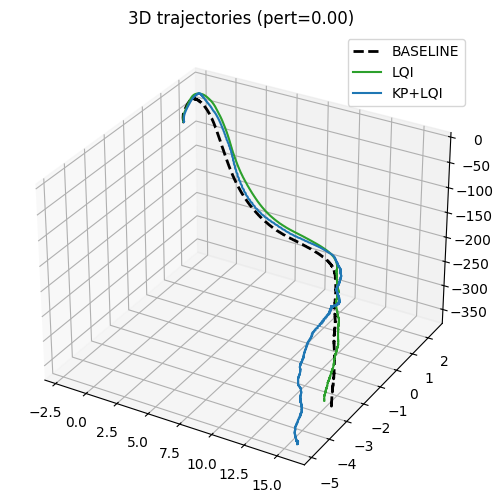

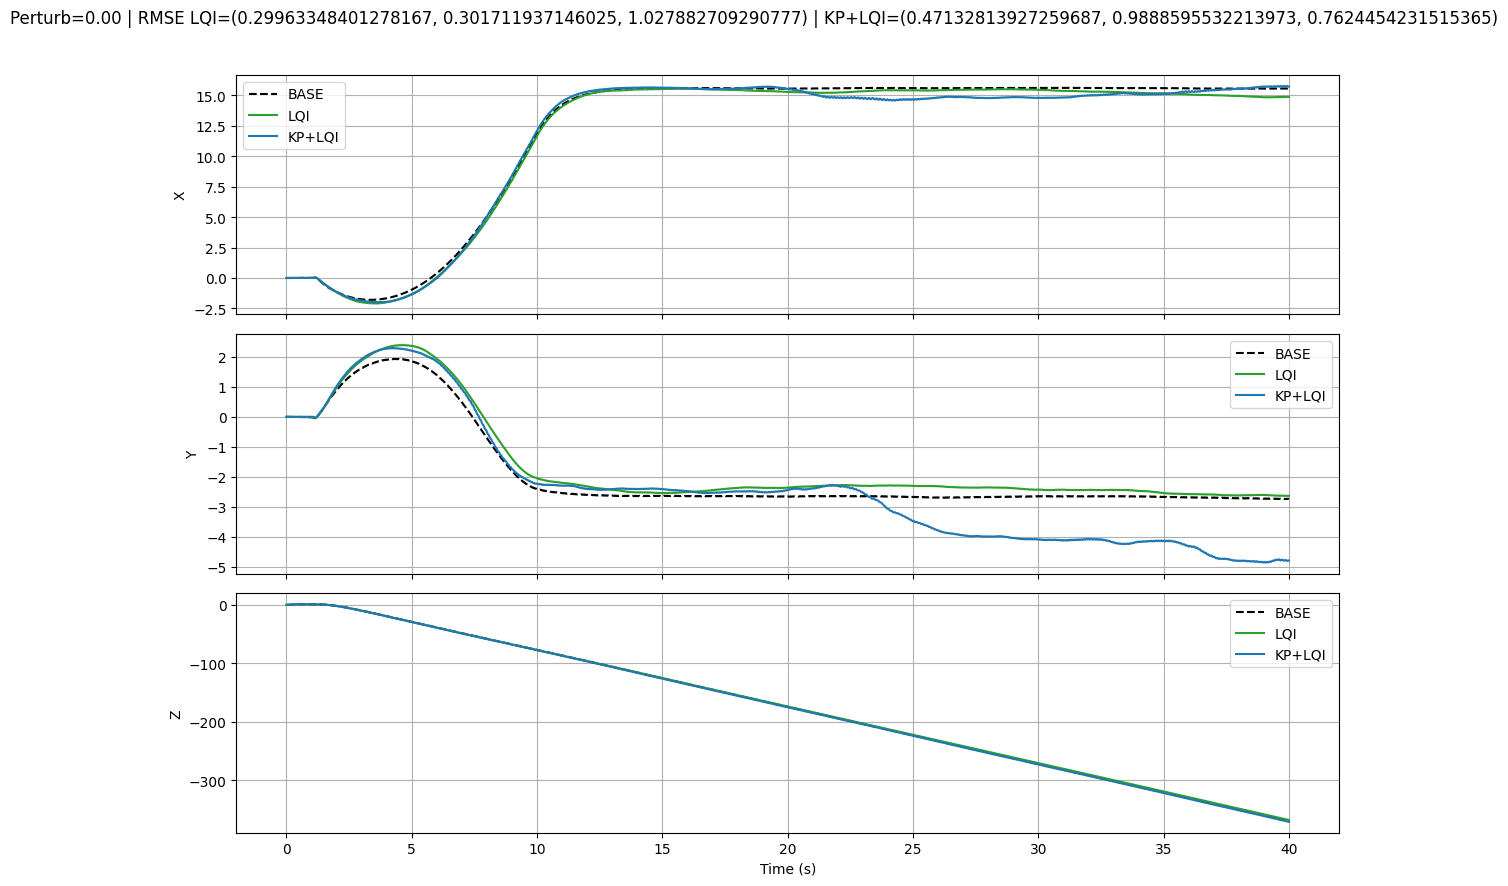

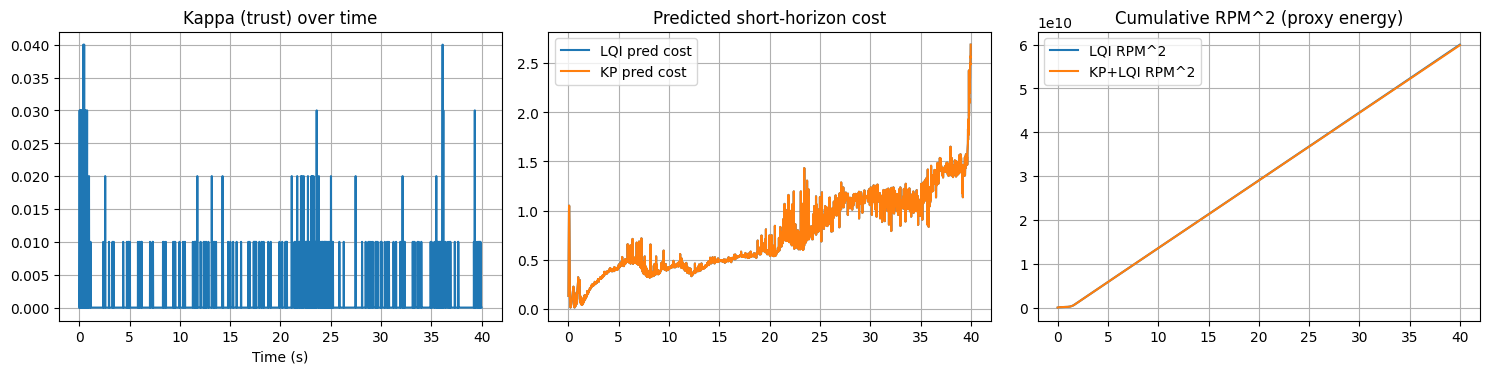


Running scenario perturb=0.050 ...
 LQI    | RMSE X=0.212 Y=0.294 Z=0.216 | Effort=3.07e+06 Energy=3.50e+04
 KP+LQI | RMSE X=0.522 Y=0.326 Z=0.725 | Effort=3.07e+06 Energy=3.52e+04


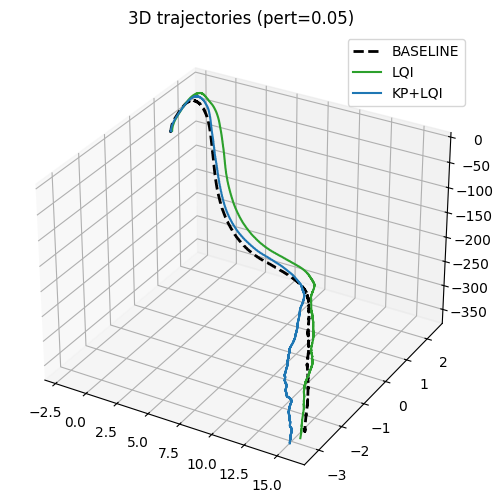

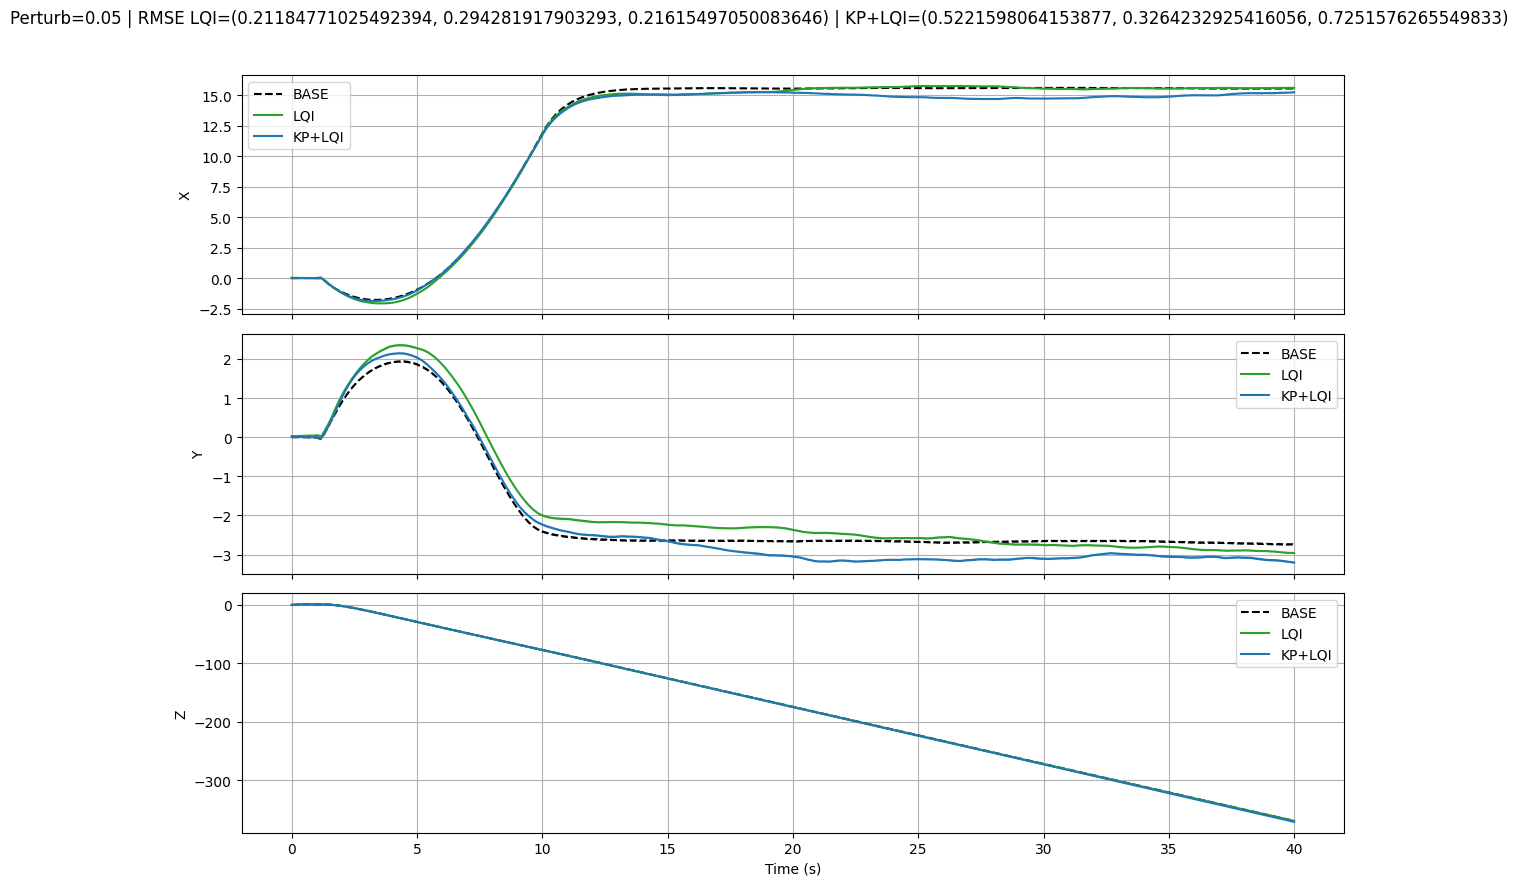

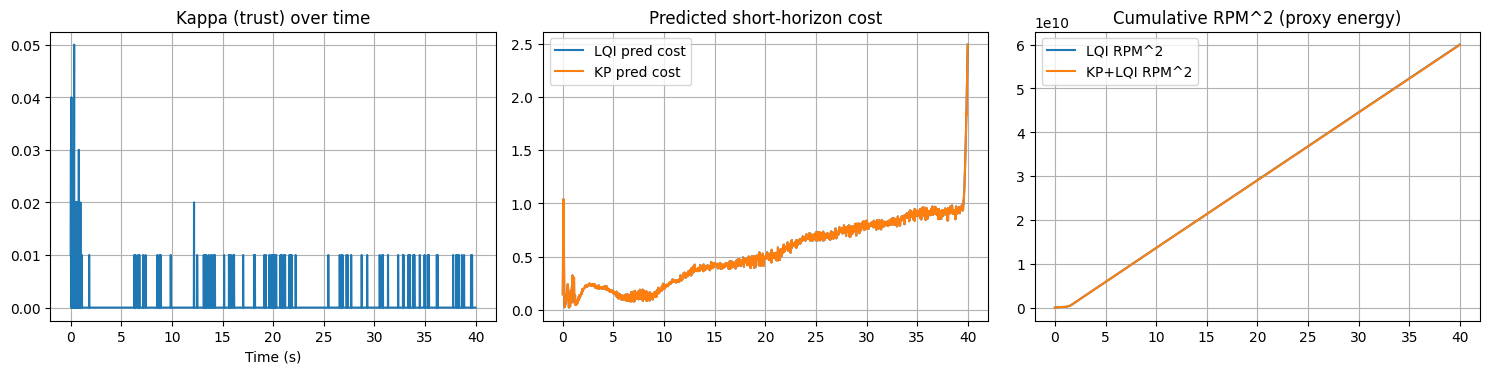


Running scenario perturb=0.150 ...
 LQI    | RMSE X=0.298 Y=0.858 Z=0.242 | Effort=3.07e+06 Energy=3.50e+04
 KP+LQI | RMSE X=0.250 Y=0.507 Z=2.557 | Effort=3.07e+06 Energy=3.46e+04


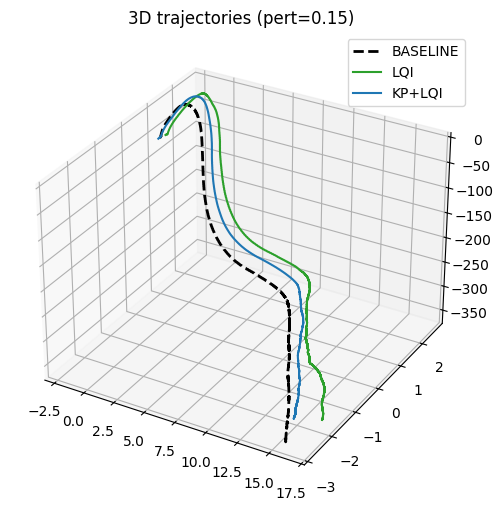

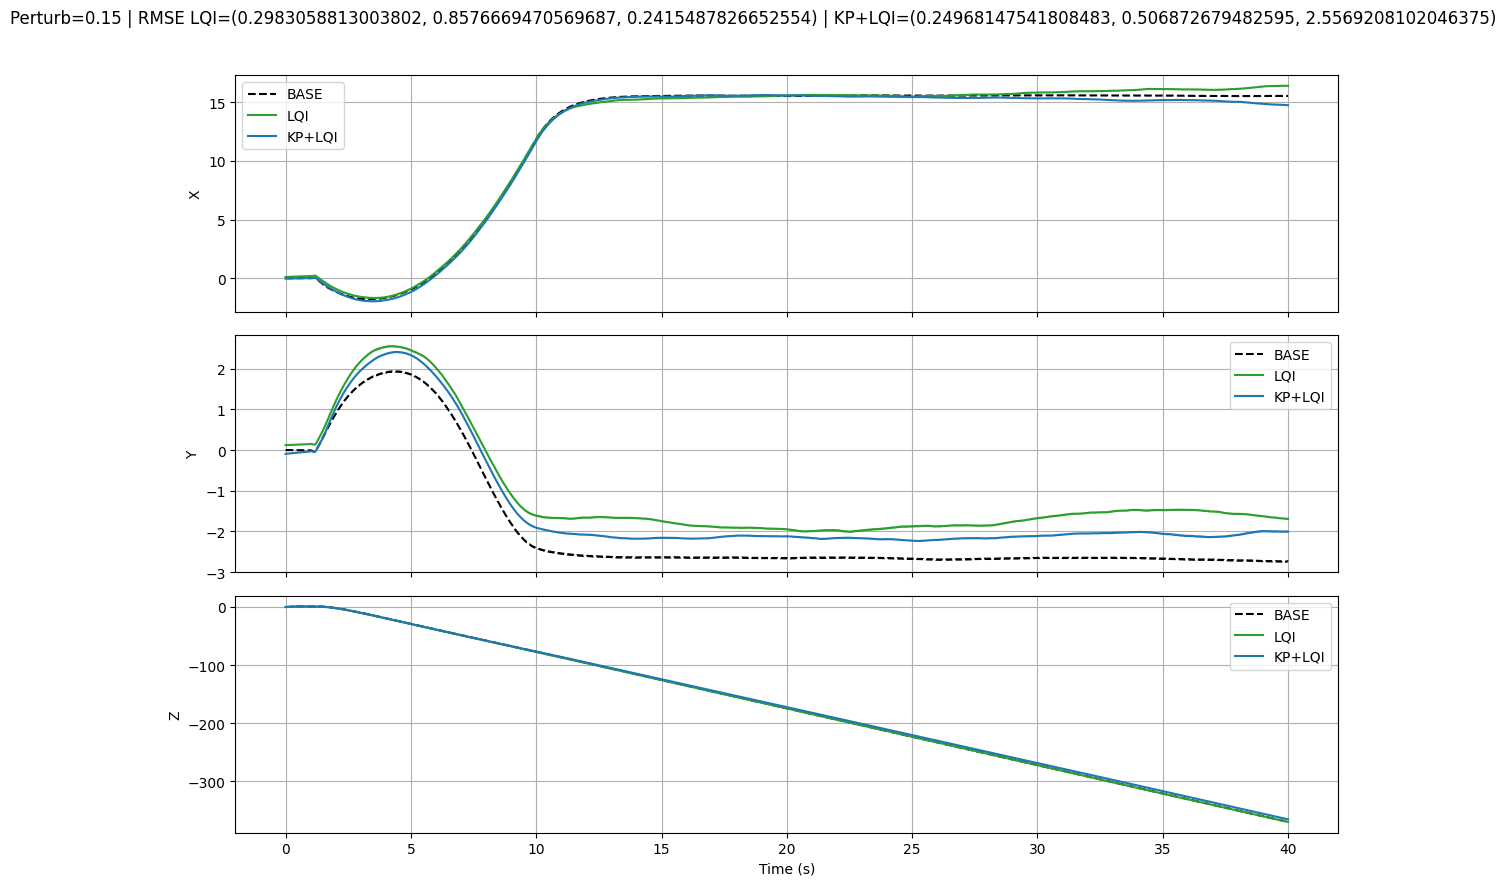

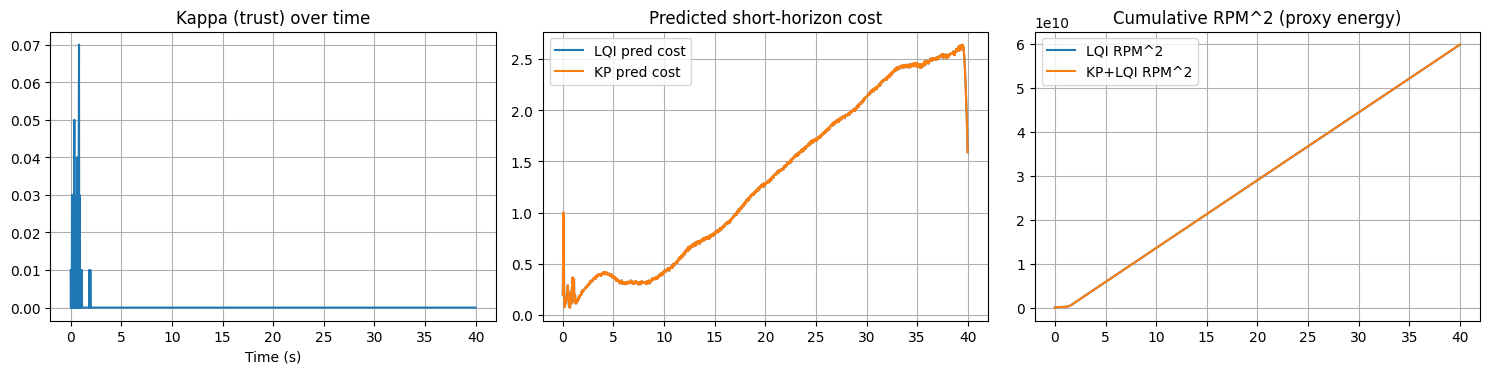


Running scenario perturb=0.350 ...
 LQI    | RMSE X=0.279 Y=0.546 Z=0.576 | Effort=3.07e+06 Energy=3.52e+04
 KP+LQI | RMSE X=2.207 Y=0.464 Z=0.510 | Effort=3.07e+06 Energy=3.51e+04


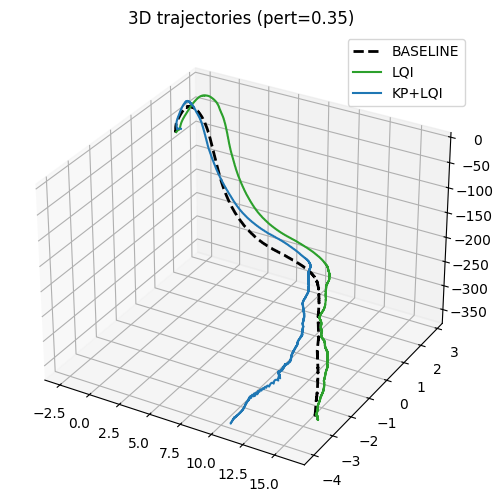

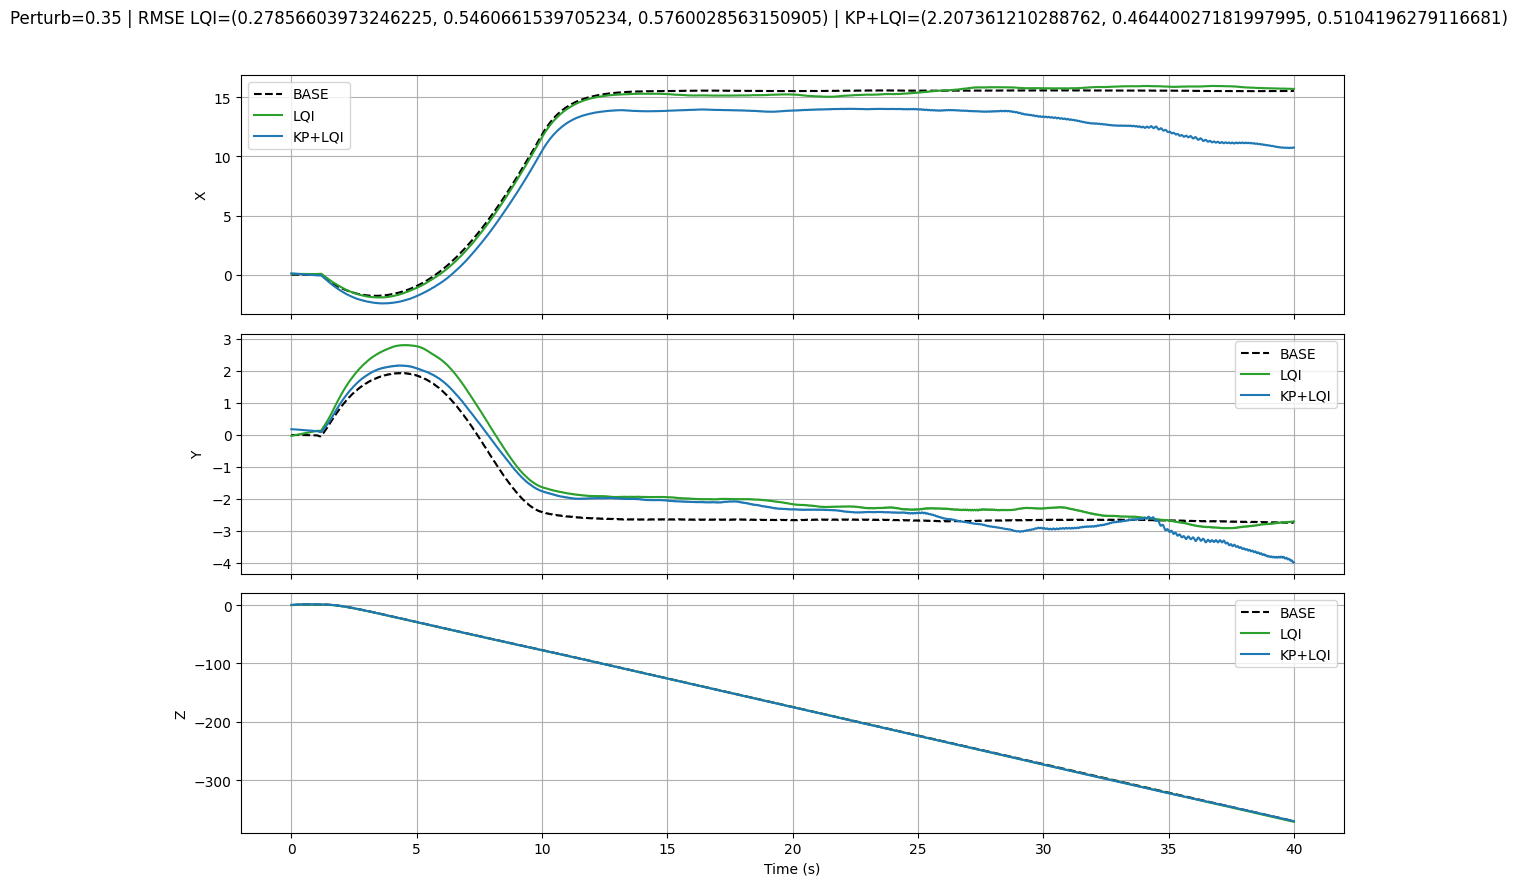

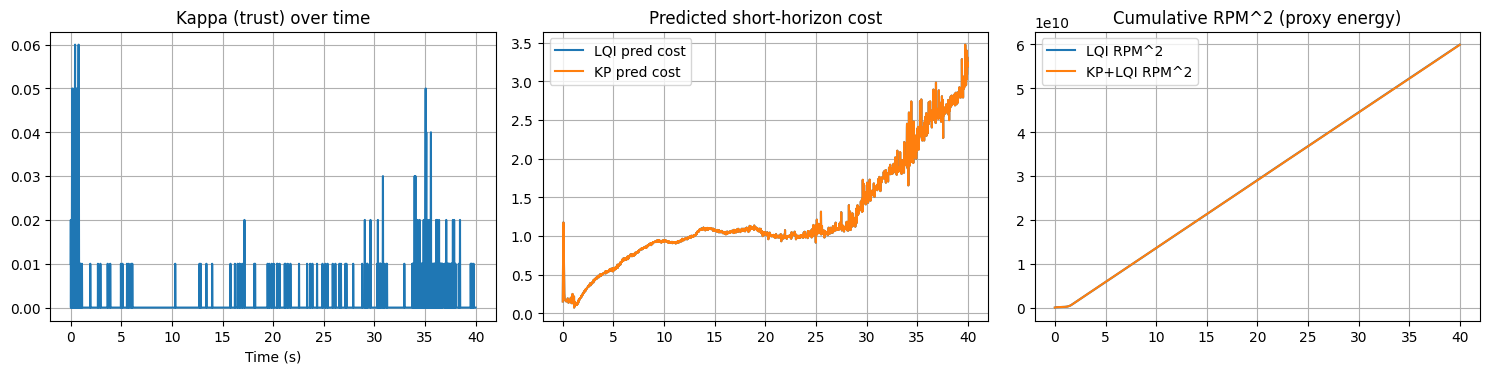


Running scenario perturb=0.700 ...
 LQI    | RMSE X=0.787 Y=1.306 Z=0.485 | Effort=3.07e+06 Energy=3.51e+04
 KP+LQI | RMSE X=0.276 Y=0.219 Z=0.166 | Effort=3.07e+06 Energy=3.50e+04


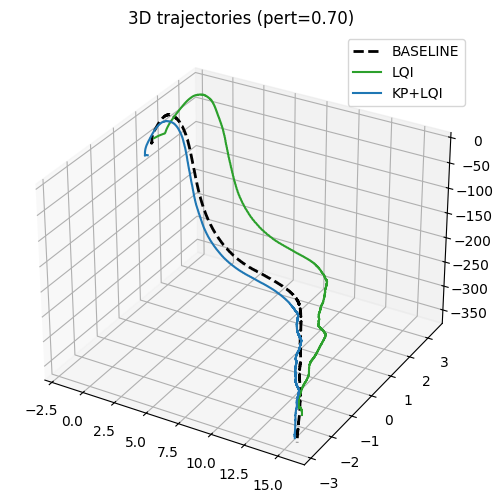

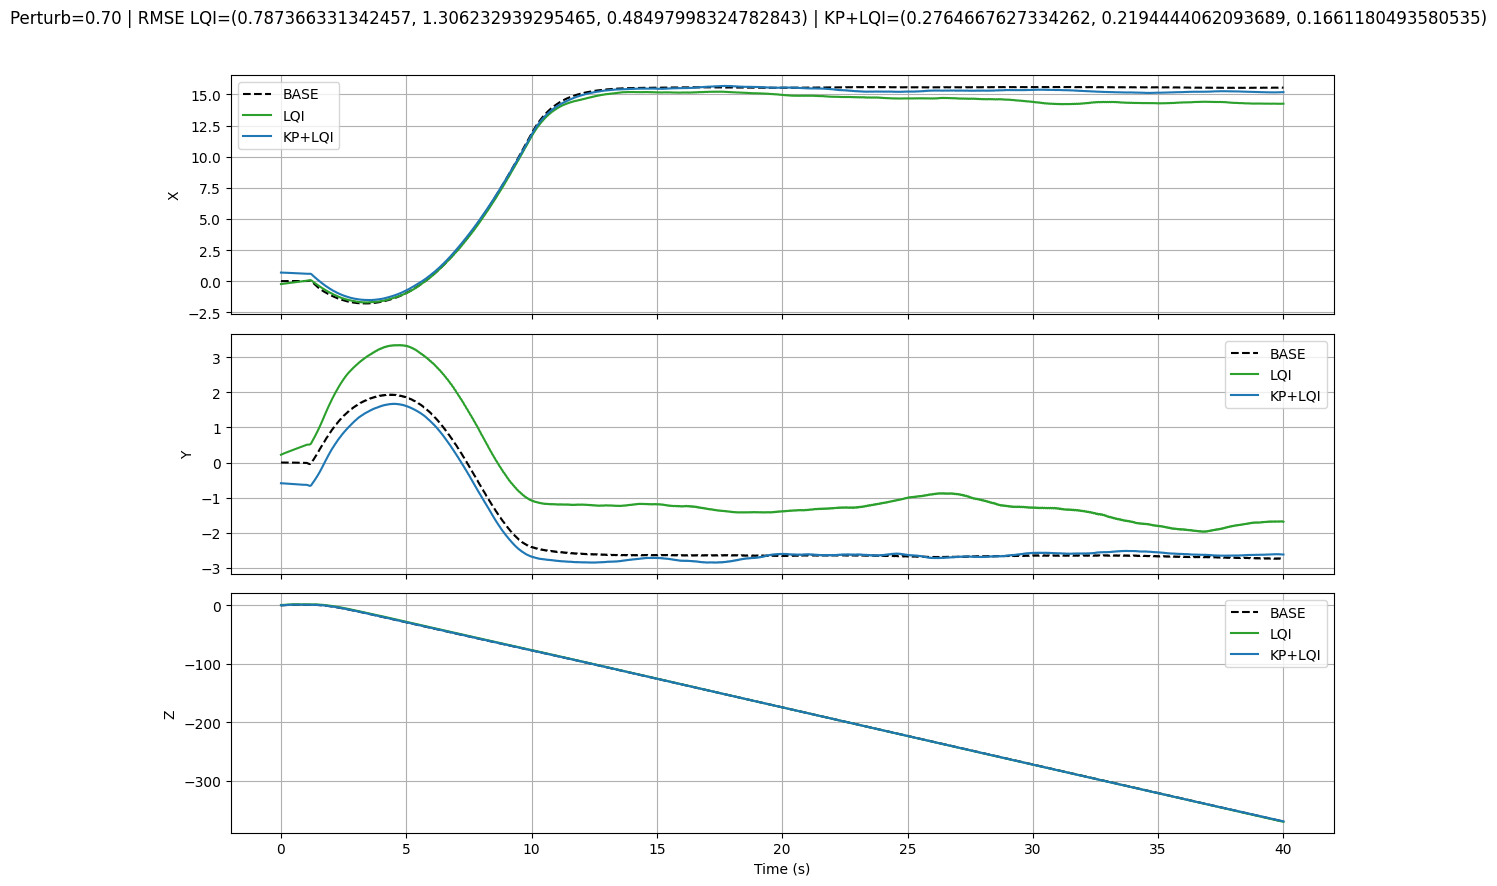

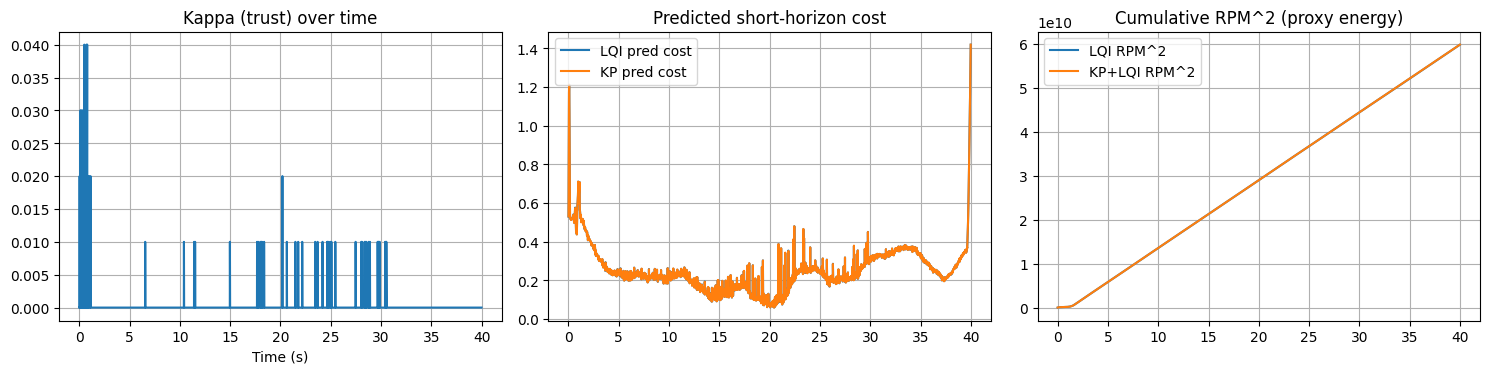


=== AVERAGE METRICS ACROSS SCENARIOS ===
LQI      | Avg RMSE X=0.3751 Y=0.6612 Z=0.5093 | Avg Eff=3.07e+06 Avg Ene=3.50e+04
KP+LQI   | Avg RMSE X=0.7454 Y=0.5012 Z=0.9442 | Avg Eff=3.07e+06 Avg Ene=3.50e+04
Done.


In [ ]:
# Full runnable cell: RK4 + TV-LQI + Online RLS Koopman-assist + wind + energy-aware acceptance + adaptive kappa
# Copy-paste into Colab / Jupyter and run.
import numpy as np, time, math, warnings
from scipy import linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.set_printoptions(precision=5, suppress=True)
warnings.filterwarnings("ignore")

# -------------------- CONFIG / hyperparameters --------------------
DT = 0.01              # integration timestep
T_RUN = 40.0           # seconds per scenario
STEPS = int(T_RUN / DT)
VERBOSE = True

# RLS hyperparameters (energy-aware / smoother learning)
RLS_LAMBDA = 0.997     # forgetting factor (slightly larger retention)
RLS_P0 = 1e5           # initial P diag scalar (reduced from huge)
RLS_REG = 1e-8

# Koopman-assist / regularization & trust tuning
DU_REG = 1e-2          # regularization for computing du
DU_MAX = 800.0         # limit for delta rpm (reduced for safety)
KAPPA_INIT = 0.0
KAPPA_STEP_UP = 0.01
KAPPA_STEP_DOWN = 0.05
KAPPA_MIN, KAPPA_MAX = 0.0, 0.5

# Energy-aware acceptance parameters
EVAL_HORIZON_S = 0.5        # seconds for short predictive evaluation
EVAL_HORIZON = max(1, int(EVAL_HORIZON_S / DT))
W_RMSE = 1.0                # weight for RMSE in combined cost
W_ENERGY = 1e-4             # weight for energy in combined cost (scale tuned)
ACCEPT_THRESH = 1.00        # accept if kp_cost <= lqi_cost * ACCEPT_THRESH

# Safety: ensure Koopman doesn't reduce LQI accuracy locally
TRUST_WINDOW = int(0.5 / DT)
RMSE_FAIL_THRESH = 1.02

# Wind hyperparameters (tune these)
WIND_BASE_X = 0.0
WIND_BASE_Y = 0.0
WIND_TURB_MAG = 0.3
WIND_GUST_MAG = 4.0
WIND_GUST_START = 1.0
WIND_GUST_END = 10.0

# -------------------- RK4 Quadcopter (13D) with time-aware wind --------------------
class QuadRK4:
    def __init__(self, dt=DT, m=1.0, L=0.2, k_f=6.11e-8, k_m=1.5e-9,
                 I=np.diag([0.005,0.005,0.009]), max_rpm=20000.0):
        self.dt = dt; self.m = m; self.L = L; self.k_f = k_f; self.k_m = k_m
        self.I = I.astype(np.float64); self.invI = np.linalg.inv(self.I)
        self.max_rpm = float(max_rpm); self.g = np.array([0.0,0.0,-9.81], dtype=np.float64)
        self.t = 0.0
        self.reset()
    def reset(self):
        self.pos = np.zeros(3, dtype=np.float64)
        self.vel = np.zeros(3, dtype=np.float64)
        self.q = np.array([1.0,0.0,0.0,0.0], dtype=np.float64)
        self.omega = np.zeros(3, dtype=np.float64)
        self.t = 0.0
    def state_vector(self):
        return np.hstack([self.pos, self.q, self.vel, self.omega])
    def set_state_vector(self, s):
        s = np.asarray(s, dtype=np.float64)
        self.pos = s[0:3].copy()
        self.q = s[3:7].copy()
        nq = np.linalg.norm(self.q)
        if nq < 1e-9: self.q = np.array([1.,0.,0.,0.])
        else: self.q /= nq
        self.vel = s[7:10].copy()
        self.omega = s[10:13].copy()
    def quat_to_rotm(self,q):
        w,x,y,z = q
        R = np.array([
            [1 - 2*(y*y + z*z), 2*(x*y - w*z),     2*(x*z + w*y)],
            [2*(x*y + w*z),     1 - 2*(x*x + z*z), 2*(y*z - w*x)],
            [2*(x*z - w*y),     2*(y*z + w*x),     1 - 2*(x*x + y*y)]
        ], dtype=np.float64)
        return R
    def quat_derivative(self, q, omega):
        wx,wy,wz = omega
        Omega = np.array([[0.0,-wx,-wy,-wz],[wx,0.0,wz,-wy],[wy,-wz,0.0,wx],[wz,wy,-wx,0.0]], dtype=np.float64)
        return 0.5 * (Omega @ q)
    def wind_force_world(self, t):
        # steady + gust window + small turbulence
        gust_factor = 0.0
        if WIND_GUST_START <= t <= WIND_GUST_END:
            dur = max(WIND_GUST_END - WIND_GUST_START, 1e-6)
            tau = (t - WIND_GUST_START) / dur
            gust_factor = 0.5*(1 - math.cos(math.pi * tau))
        fx = WIND_BASE_X + WIND_GUST_MAG * gust_factor + WIND_TURB_MAG * np.random.randn()
        fy = WIND_BASE_Y + 0.5 * WIND_GUST_MAG * gust_factor * math.cos(0.5*t) + WIND_TURB_MAG * np.random.randn()
        fz = 0.0 + 0.05 * WIND_TURB_MAG * np.random.randn()
        return np.array([fx, fy, fz], dtype=np.float64)
    def continuous_dynamics(self, state, rpm, t):
        pos = state[0:3]; q = state[3:7]; vel = state[7:10]; omega = state[10:13]
        rpm = np.clip(rpm, 0.0, self.max_rpm)
        thrusts = self.k_f * (rpm**2)  # per rotor thrust N
        total_thrust = float(np.sum(thrusts))
        tau = np.array([ self.L*(thrusts[1]-thrusts[3]),
                         self.L*(thrusts[2]-thrusts[0]),
                         self.k_m*(thrusts[0]-thrusts[1]+thrusts[2]-thrusts[3]) ], dtype=np.float64)
        R = self.quat_to_rotm(q)
        F_thrust_world = R @ np.array([0.0,0.0,total_thrust], dtype=np.float64)
        vnorm = np.linalg.norm(vel)
        F_drag = -0.1 * vel * vnorm
        F_wind = self.wind_force_world(t)
        acc = (F_thrust_world + F_drag + F_wind) / self.m + self.g
        pos_dot = vel
        q_dot = self.quat_derivative(q, omega)
        omega_dot = self.invI @ (tau - np.cross(omega, self.I @ omega))
        deriv = np.zeros(13, dtype=np.float64)
        deriv[0:3] = pos_dot
        deriv[3:7] = q_dot
        deriv[7:10] = acc
        deriv[10:13]= omega_dot
        return deriv
    def rk4_step(self, rpm):
        s0 = self.state_vector()
        t0 = self.t
        k1 = self.continuous_dynamics(s0, rpm, t0)
        k2 = self.continuous_dynamics(s0 + 0.5*self.dt*k1, rpm, t0 + 0.5*self.dt)
        k3 = self.continuous_dynamics(s0 + 0.5*self.dt*k2, rpm, t0 + 0.5*self.dt)
        k4 = self.continuous_dynamics(s0 + self.dt*k3, rpm, t0 + self.dt)
        s_next = s0 + (self.dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        self.set_state_vector(s_next)
        self.t += self.dt
    def hover_rpm_per_motor(self):
        fpm = self.m * abs(self.g[2]) / 4.0
        return float(np.sqrt(max(fpm / self.k_f, 0.0)))

def quat_to_euler(q):
    w,x,y,z = q
    sinr = 2*(w*x + y*z); cosr = 1 - 2*(x*x + y*y); roll = math.atan2(sinr, cosr)
    sinp = 2*(w*y - z*x); pitch = math.copysign(math.pi/2, sinp) if abs(sinp)>=1 else math.asin(sinp)
    siny = 2*(w*z + x*y); cosy = 1 - 2*(y*y + z*z); yaw = math.atan2(siny, cosy)
    return roll,pitch,yaw

# -------------------- Baseline generation (self-consistent PD generator) --------------------
def generate_baseline(sim, T=T_RUN):
    steps = int(T / sim.dt)
    t = np.linspace(0.0, (steps-1)*sim.dt, steps)
    ref = np.zeros((steps, 13), dtype=np.float64)
    ref[:,0] = 0.5 * np.sin(0.8 * t)
    ref[:,1] = 0.5 * np.cos(0.5 * t)
    ref[:,2] = 1.0 + 0.05 * np.sin(0.3 * t)
    ref[:,7] = 0.5 * 0.8 * np.cos(0.8*t)
    ref[:,8] = -0.5 * 0.5 * np.sin(0.5*t)
    ref[:,9] = 0.05 * 0.3 * np.cos(0.3*t)
    ref[:,3] = 1.0
    ref[:,4:7] = 0.01 * np.sin(0.2 * t)[:,None]
    for i in range(steps): ref[i,3:7] /= np.linalg.norm(ref[i,3:7])

    x_seq = np.zeros((steps+1, 13), dtype=np.float64)
    u_seq = np.zeros((steps, 4), dtype=np.float64)
    sim.reset()
    x_seq[0,:] = sim.state_vector()
    u_prev = np.ones(4) * sim.hover_rpm_per_motor()
    Kp_z = 80.0; Kd_z = 20.0; Kp_att = 6.0
    for k in range(steps):
        x = sim.state_vector(); x_ref = ref[k]
        z_err = x_ref[2] - x[2]; vz_err = x_ref[9] - x[9]
        thrust_total = sim.m * abs(sim.g[2]) + Kp_z*z_err + Kd_z*vz_err
        roll_ref, pitch_ref, _ = quat_to_euler(x_ref[3:7])
        roll, pitch, _ = quat_to_euler(x[3:7])
        tx = Kp_att * (roll_ref - roll)
        ty = Kp_att * (pitch_ref - pitch)
        tz = -0.5 * x[12] if x.size>12 else 0.0
        f0 = thrust_total/4.0 - ty/(2*sim.L) + tz/(4*sim.k_m)
        f1 = thrust_total/4.0 + tx/(2*sim.L) - tz/(4*sim.k_m)
        f2 = thrust_total/4.0 + ty/(2*sim.L) + tz/(4*sim.k_m)
        f3 = thrust_total/4.0 - tx/(2*sim.L) - tz/(4*sim.k_m)
        forces = np.array([f0,f1,f2,f3], dtype=np.float64)
        rpm = np.sqrt(np.clip(forces / sim.k_f, 0.0, None))
        rpm = 0.2 * rpm + 0.8 * u_prev
        rpm = np.clip(rpm, 0.0, sim.max_rpm)
        u_seq[k,:] = rpm.copy()
        sim.rk4_step(rpm)
        x_seq[k+1,:] = sim.state_vector()
        u_prev = rpm.copy()
    return ref, x_seq, u_seq

# -------------------- TV-LQI-Z (augmented DARE around ref) --------------------
def linearize_discrete_map(sim, x_ref, u_ref, eps=1e-6):
    saved_state = sim.state_vector().copy(); saved_t = sim.t
    nx = x_ref.size; nu = u_ref.size
    A = np.zeros((nx,nx), dtype=np.float64)
    B = np.zeros((nx,nu), dtype=np.float64)
    sim.set_state_vector(x_ref.copy()); sim.rk4_step(u_ref); xnext_base = sim.state_vector().copy()
    for i in range(nx):
        dx = np.zeros(nx); dx[i] = eps
        sim.set_state_vector(x_ref + dx); sim.rk4_step(u_ref); xp = sim.state_vector().copy()
        A[:,i] = (xp - xnext_base) / eps
    for j in range(nu):
        du = np.zeros(nu); du[j] = eps
        sim.set_state_vector(x_ref.copy()); sim.rk4_step(u_ref + du); xu = sim.state_vector().copy()
        B[:,j] = (xu - xnext_base) / eps
    sim.set_state_vector(saved_state); sim.t = saved_t
    return A, B

def tv_lqi_z_rpm(sim, x, x_ref, u_ff):
    try:
        A,B = linearize_discrete_map(sim, x_ref, u_ff, eps=1e-6)
        nx = A.shape[0]; nu = B.shape[1]
        C = np.zeros((1,nx)); C[0,2] = 1.0
        A_aug = np.block([[A, np.zeros((nx,1))],[C, np.eye(1)]])
        B_aug = np.vstack([B, np.zeros((1,nu))])
        Q_state = np.diag([5.0,5.0,200.0] + [1.0]*10)
        Q_i = np.array([[50.0]])
        Q_aug = linalg.block_diag(Q_state, Q_i)
        R = np.eye(nu) * 0.01
        P = linalg.solve_discrete_are(A_aug, B_aug, Q_aug, R)
        S = R + B_aug.T @ P @ B_aug
        K_aug = np.linalg.solve(S, B_aug.T @ P @ A_aug)
        dx = x - x_ref
        q = x[3:7].copy(); q_ref = x_ref[3:7];
        if np.dot(q, q_ref) < 0: q = -q
        dx[3:7] = q - q_ref
        z_int = 0.0
        x_aug = np.hstack([dx, z_int])
        delta_u = -K_aug @ x_aug
        delta_u = np.clip(delta_u, -2000.0, 2000.0)
        u_cmd = np.clip(u_ff + delta_u, 0.0, sim.max_rpm)
        return u_cmd
    except Exception:
        return np.clip(u_ff, 0.0, sim.max_rpm)

# -------------------- RLS object (row-wise) --------------------
class RLSLearner:
    def __init__(self, nx=13, nu=4, lam=RLS_LAMBDA, P0=RLS_P0):
        self.nx = nx; self.nu = nu
        self.lam = lam
        self.w_rows = [np.zeros(nu, dtype=np.float64) for _ in range(nx)]
        self.P_rows = [np.eye(nu, dtype=np.float64) * P0 for _ in range(nx)]
        self.W = np.vstack(self.w_rows)
    def predict_dx(self, du):
        return (np.vstack(self.w_rows) @ du).reshape(self.nx,)
    def update(self, du, dx_obs):
        du = du.reshape(-1)
        for i in range(self.nx):
            P = self.P_rows[i]; w = self.w_rows[i]
            denom = self.lam + du @ (P @ du)
            k = (P @ du) / (denom + 1e-12)
            r = float(dx_obs[i] - (w @ du))
            w = w + k * r
            P = (P - np.outer(k, du @ P)) / self.lam
            self.w_rows[i] = w; self.P_rows[i] = P
        self.W = np.vstack(self.w_rows)

# -------------------- Koopman-assist inversion --------------------
def koopman_assist_from_W(W, dx_err, du_reg=DU_REG, du_max=DU_MAX):
    W = np.asarray(W, dtype=np.float64)
    nx, nu = W.shape
    A = W.T @ W + du_reg * np.eye(nu)
    b = W.T @ dx_err
    try:
        du = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        du = np.linalg.lstsq(A, b, rcond=None)[0]
    du = np.clip(du, -du_max, du_max)
    return du

# -------------------- Helpers: predicted rollout cost (short horizon) --------------------
def predictive_cost(sim_template, x0, u_seq, horizon_steps):
    # Run a short cloned sim for horizon_steps applying u_seq (shape (H,4) or repeat first)
    sim_c = QuadRK4(dt=sim_template.dt, m=sim_template.m, L=sim_template.L,
                    k_f=sim_template.k_f, k_m=sim_template.k_m, I=sim_template.I, max_rpm=sim_template.max_rpm)
    sim_c.set_state_vector(x0.copy())
    sim_c.t = sim_template.t
    xs = []
    us = []
    for k in range(horizon_steps):
        if k < u_seq.shape[0]:
            u = u_seq[k]
        else:
            u = u_seq[-1]
        sim_c.rk4_step(u)
        xs.append(sim_c.state_vector().copy())
        us.append(u.copy())
    xs = np.vstack(xs)
    us = np.vstack(us)
    # RMSE to baseline for that horizon not available here (we will pass baseline slice externally)
    # Compute "energy" proxy for the horizon: sum total_thrust * |vz| * dt
    thrusts = sim_c.k_f * (us**2)
    total_th = np.sum(thrusts, axis=1)
    vz = xs[:,9]
    energy = float(np.sum(total_th * np.abs(vz) * sim_c.dt))
    # compute pos RMSE to returned xs if caller provides baseline; here return traj and energy
    return xs, energy

# -------------------- Runner for a single scenario (LQI-only vs KP+LQI) ------------
def run_scenario(sim_master, x_baseline, u_baseline, perturb=0.0, use_koopman=False, rls_init=None):
    N = u_baseline.shape[0]
    sim = QuadRK4(dt=sim_master.dt, m=sim_master.m, L=sim_master.L, k_f=sim_master.k_f, k_m=sim_master.k_m, I=sim_master.I, max_rpm=sim_master.max_rpm)
    x0 = x_baseline[0].copy()
    # add perturbation
    x0[0:3] += np.random.uniform(-perturb, perturb, 3)
    x0[7:10] += np.random.uniform(-perturb, perturb, 3) * 0.5
    x0[3:7] += np.random.uniform(-0.01*perturb, 0.01*perturb, 4)
    if np.linalg.norm(x0[3:7]) < 1e-9: x0[3:7] = np.array([1.,0.,0.,0.])
    x0[3:7] /= np.linalg.norm(x0[3:7])
    sim.set_state_vector(x0.copy())

    x_hist = np.zeros((N+1, 13), dtype=np.float64)
    u_hist = np.zeros((N,4), dtype=np.float64)
    x_hist[0,:] = sim.state_vector()
    rls = rls_init if rls_init is not None else RLSLearner(nx=13, nu=4)
    kappa = KAPPA_INIT; kappa_hist = np.zeros(N, dtype=np.float64)
    rmse_lqi_t = np.zeros((N,), dtype=np.float64); rmse_kp_t = np.zeros((N,), dtype=np.float64)
    u_prev = u_baseline[0].copy()
    effort_cum = np.zeros(N, dtype=np.float64); energy_cum = np.zeros(N, dtype=np.float64)

    # We'll keep small arrays to store predicted costs for diagnostics
    pred_costs_lqi = np.zeros(N, dtype=np.float64)
    pred_costs_kp = np.zeros(N, dtype=np.float64)

    for k in range(N):
        x = sim.state_vector(); x_ref = x_baseline[k]; u_ref = u_baseline[k]
        # compute LQI command
        u_lqi = tv_lqi_z_rpm(sim, x, x_ref, u_ref)
        u_cmd_final = u_lqi.copy()

        if use_koopman:
            # compute dx_err (with quaternion chordal)
            dx_err = x - x_ref
            q = x[3:7].copy(); qref = x_ref[3:7].copy()
            if np.dot(q, qref) < 0: q = -q
            dx_err[3:7] = q - qref

            W = rls.W
            # compute candidate du to reduce -dx_err
            du_candidate = koopman_assist_from_W(W, -dx_err, du_reg=DU_REG, du_max=DU_MAX)
            # candidate command (scaled by kappa)
            u_kp_candidate = np.clip(u_lqi + kappa * du_candidate, 0.0, sim.max_rpm)

            # PREDICTIVE EVALUATION: short horizon cost for LQI and KP candidate
            # Build short sequences: for candidate we use [u_kp_candidate] repeated EVAL_HORIZON
            u_seq_kp = np.tile(u_kp_candidate.reshape(1,-1), (EVAL_HORIZON,1))
            u_seq_lqi = np.tile(u_lqi.reshape(1,-1), (EVAL_HORIZON,1))

            # Simulate predicted trajectories starting from current sim state (use clones preserving current sim.t)
            # Predict for both LQI and KP candidate
            sim_clone_A = QuadRK4(dt=sim.dt, m=sim.m, L=sim.L, k_f=sim.k_f, k_m=sim.k_m, I=sim.I, max_rpm=sim.max_rpm)
            sim_clone_A.set_state_vector(x.copy()); sim_clone_A.t = sim.t
            xs_lqi = []
            for uu in u_seq_lqi:
                sim_clone_A.rk4_step(uu); xs_lqi.append(sim_clone_A.state_vector().copy())
            xs_lqi = np.vstack(xs_lqi)

            sim_clone_B = QuadRK4(dt=sim.dt, m=sim.m, L=sim.L, k_f=sim.k_f, k_m=sim.k_m, I=sim.I, max_rpm=sim.max_rpm)
            sim_clone_B.set_state_vector(x.copy()); sim_clone_B.t = sim.t
            xs_kp = []
            for uu in u_seq_kp:
                sim_clone_B.rk4_step(uu); xs_kp.append(sim_clone_B.state_vector().copy())
            xs_kp = np.vstack(xs_kp)

            # Compare predicted states to baseline future slice to compute RMSE over the horizon
            if k + 1 + EVAL_HORIZON <= x_baseline.shape[0]:
                baseline_future = x_baseline[k+1:k+1+EVAL_HORIZON]
            else:
                # last slice padded with last baseline
                end = x_baseline.shape[0]-1
                needed = EVAL_HORIZON
                baseline_future = []
                for j in range(1, EVAL_HORIZON+1):
                    idx = min(k+j, end)
                    baseline_future.append(x_baseline[idx])
                baseline_future = np.vstack(baseline_future)

            # compute RMSE over horizon (pos only)
            rmse_lqi_pred = math.sqrt(float(np.mean(((xs_lqi[:,:3] - baseline_future[:,:3])**2))))
            rmse_kp_pred  = math.sqrt(float(np.mean(((xs_kp[:,:3] - baseline_future[:,:3])**2))))

            # compute predicted energy proxies over horizon
            thrusts_lqi = sim.k_f * (u_seq_lqi**2); total_th_lqi = np.sum(thrusts_lqi, axis=1)
            vz_lqi = xs_lqi[:,9]
            pred_energy_lqi = float(np.sum(total_th_lqi * np.abs(vz_lqi) * sim.dt))

            thrusts_kp = sim.k_f * (u_seq_kp**2); total_th_kp = np.sum(thrusts_kp, axis=1)
            vz_kp = xs_kp[:,9]
            pred_energy_kp = float(np.sum(total_th_kp * np.abs(vz_kp) * sim.dt))

            # combined cost (weighted)
            cost_lqi = W_RMSE * rmse_lqi_pred + W_ENERGY * pred_energy_lqi
            cost_kp  = W_RMSE * rmse_kp_pred  + W_ENERGY * pred_energy_kp

            pred_costs_lqi[k] = cost_lqi
            pred_costs_kp[k] = cost_kp

            # Acceptance rule: accept KP assist only if cost_kp <= cost_lqi * ACCEPT_THRESH
            if cost_kp <= cost_lqi * ACCEPT_THRESH:
                # accept candidate
                u_cmd_final = u_kp_candidate.copy()
                # compute residual between predicted dx via W and observed dx (approx using clone)
                dx_pred_from_W = W @ (kappa * du_candidate)
                dx_obs = (xs_kp[0] - x)  # predicted immediate dx
                residual = np.linalg.norm(dx_obs - dx_pred_from_W)
                # adapt kappa
                if residual < 1.0 and cost_kp < cost_lqi:
                    kappa = min(KAPPA_MAX, kappa + KAPPA_STEP_UP)
                else:
                    kappa = max(KAPPA_MIN, kappa - KAPPA_STEP_DOWN)
            else:
                # reject; reduce trust
                u_cmd_final = u_lqi.copy()
                kappa = max(KAPPA_MIN, kappa - KAPPA_STEP_DOWN)

        # smoothing and apply
        alpha = 0.35
        u_cmd_sm = alpha * u_cmd_final + (1-alpha) * u_prev
        u_cmd_sm = np.clip(u_cmd_sm, 0.0, sim.max_rpm)

        # step real sim
        sim.rk4_step(u_cmd_sm)
        x_next = sim.state_vector()

        # store
        x_hist[k+1,:] = x_next.copy()
        u_hist[k,:] = u_cmd_sm.copy()
        kappa_hist[k] = kappa

        # RMSE (after step) to baseline next
        idx_next = min(k+1, x_baseline.shape[0]-1)
        rmse_now = math.sqrt(float(np.mean(((x_next[:3] - x_baseline[idx_next,:3])**2))))
        rmse_kp_t[k] = rmse_now

        # simulate LQI-only next state for comparison (predict)
        sim_tmp = QuadRK4(dt=sim.dt, m=sim.m, L=sim.L, k_f=sim.k_f, k_m=sim.k_m, I=sim.I, max_rpm=sim.max_rpm)
        sim_tmp.set_state_vector(x.copy()); sim_tmp.t = sim.t
        sim_tmp.rk4_step(u_lqi); x_lqi_next = sim_tmp.state_vector()
        rmse_pred_lqi = math.sqrt(float(np.mean(((x_lqi_next[:3] - x_baseline[idx_next,:3])**2))))

        # Update RLS with applied assist
        du_applied = (u_cmd_sm - u_lqi).copy()
        dx_observed = (x_next - x).copy()
        if use_koopman and np.linalg.norm(du_applied) > 1e-6:
            rls.update(du_applied, dx_observed)

        u_prev = u_cmd_sm.copy()

        # cumulative energy/effort
        effort_cum[k] = np.sum(np.abs(u_hist[:k+1,:])) * sim.dt
        thrusts = sim.k_f * (u_hist[:k+1,:]**2)
        vz = x_hist[:k+1,9]
        total_th = np.sum(thrusts, axis=1)
        energy_cum = np.sum(total_th * np.abs(vz) * sim.dt)  # single scalar for the full history
        # store energy as float in array per-step for plotting convenience
        if k == 0:
            energy_hist = np.zeros(N, dtype=np.float64)
        energy_hist[k] = energy_cum

    rmse_axis = rmse_per_axis(x_hist, x_baseline)
    effort, energy = compute_effort_energy(u_hist, x_hist, sim)
    return {
        'x_hist': x_hist, 'u_hist': u_hist,
        'rmse_axis': rmse_axis, 'effort': effort, 'energy': energy,
        'kappa_hist': kappa_hist, 'rmse_kp_t': rmse_kp_t,
        'pred_costs_lqi': pred_costs_lqi, 'pred_costs_kp': pred_costs_kp,
        'energy_hist': energy_hist if 'energy_hist' in locals() else np.zeros(N),
        'rls': rls
    }

# -------------------- RMSE / metrics utilities --------------------
def rmse_per_axis(x_hist, x_ref):
    err = x_hist[:,:3] - x_ref[:,:3]
    return float(np.sqrt(np.mean(err[:,0]**2))), float(np.sqrt(np.mean(err[:,1]**2))), float(np.sqrt(np.mean(err[:,2]**2)))

def compute_effort_energy(u_hist, x_hist, sim):
    dt = sim.dt
    effort = np.sum(np.sum(np.abs(u_hist), axis=1)) * dt
    thrusts = sim.k_f * (u_hist**2)
    if x_hist.shape[0] >= 2:
        vz = x_hist[:-1,9]
    else:
        vz = np.zeros(u_hist.shape[0])
    total_th = np.sum(thrusts, axis=1)
    energy = np.sum(total_th * np.abs(vz) * dt)
    return float(effort), float(energy)

# -------------------- MASTER: generate baseline, run multiple perturb scenarios --------------------
def master_run(perturb_levels=[0.0, 0.05, 0.15, 0.35, 0.7], do_plot=True):
    sim_tmp = QuadRK4(dt=DT)
    print("Generating baseline (self-consistent) ... (this will take a moment)")
    ref, x_baseline, u_baseline = generate_baseline(sim_tmp, T=T_RUN)
    print(f"Baseline generated. Steps: {u_baseline.shape[0]}")
    results = {'lqi':[], 'kp+lqi':[]}
    for pert in perturb_levels:
        print(f"\nRunning scenario perturb={pert:.3f} ...")
        res_lqi = run_scenario(sim_tmp, x_baseline, u_baseline, perturb=pert, use_koopman=False, rls_init=None)
        rls_init = RLSLearner(nx=13, nu=4)
        res_kp = run_scenario(sim_tmp, x_baseline, u_baseline, perturb=pert, use_koopman=True, rls_init=rls_init)
        results['lqi'].append((pert, res_lqi)); results['kp+lqi'].append((pert, res_kp))
        rx_l, ry_l, rz_l = res_lqi['rmse_axis']; rx_k, ry_k, rz_k = res_kp['rmse_axis']
        print(f" LQI    | RMSE X={rx_l:.3f} Y={ry_l:.3f} Z={rz_l:.3f} | Effort={res_lqi['effort']:.2e} Energy={res_lqi['energy']:.2e}")
        print(f" KP+LQI | RMSE X={rx_k:.3f} Y={ry_k:.3f} Z={rz_k:.3f} | Effort={res_kp['effort']:.2e} Energy={res_kp['energy']:.2e}")

        # plotting per scenario
        if do_plot:
            t_axis = np.arange(x_baseline.shape[0]) * DT
            fig = plt.figure(figsize=(14,6))
            ax3d = fig.add_subplot(121, projection='3d')
            ax3d.plot(x_baseline[:,0], x_baseline[:,1], x_baseline[:,2], 'k--', label='BASELINE', linewidth=2)
            ax3d.plot(res_lqi['x_hist'][:,0], res_lqi['x_hist'][:,1], res_lqi['x_hist'][:,2], color='tab:green', label='LQI')
            ax3d.plot(res_kp['x_hist'][:,0], res_kp['x_hist'][:,1], res_kp['x_hist'][:,2], color='tab:blue', label='KP+LQI')
            ax3d.set_title(f"3D trajectories (pert={pert:.2f})"); ax3d.legend()
            fig2, axs = plt.subplots(3,1,figsize=(12,9), sharex=True)
            labels = ['X','Y','Z']
            for i in range(3):
                axs[i].plot(t_axis, x_baseline[:,i], 'k--', label='BASE')
                axs[i].plot(t_axis, res_lqi['x_hist'][:,i], color='tab:green', label='LQI')
                axs[i].plot(t_axis, res_kp['x_hist'][:,i], color='tab:blue', label='KP+LQI')
                axs[i].set_ylabel(labels[i]); axs[i].grid(True); axs[i].legend()
            axs[2].set_xlabel('Time (s)')
            plt.suptitle(f'Perturb={pert:.2f} | RMSE LQI={res_lqi["rmse_axis"]} | KP+LQI={res_kp["rmse_axis"]}')
            plt.tight_layout(rect=[0,0,1,0.96])
            plt.show()

            # kappa, predicted cost, cumulative energy
            fig3, axes = plt.subplots(1,3,figsize=(15,4))
            axes[0].plot(np.arange(len(res_kp['kappa_hist']))*DT, res_kp['kappa_hist'])
            axes[0].set_title('Kappa (trust) over time'); axes[0].set_xlabel('Time (s)'); axes[0].grid(True)
            axes[1].plot(np.arange(len(res_kp['pred_costs_lqi']))*DT, res_kp['pred_costs_lqi'], label='LQI pred cost')
            axes[1].plot(np.arange(len(res_kp['pred_costs_kp']))*DT, res_kp['pred_costs_kp'], label='KP pred cost')
            axes[1].set_title('Predicted short-horizon cost'); axes[1].legend(); axes[1].grid(True)
            axes[2].plot(np.arange(len(res_lqi['u_hist']))*DT, np.cumsum(np.sum(res_lqi['u_hist']**2, axis=1))*DT, label='LQI RPM^2')
            axes[2].plot(np.arange(len(res_kp['u_hist']))*DT, np.cumsum(np.sum(res_kp['u_hist']**2, axis=1))*DT, label='KP+LQI RPM^2')
            axes[2].set_title('Cumulative RPM^2 (proxy energy)'); axes[2].legend(); axes[2].grid(True)
            plt.tight_layout(); plt.show()

    # averages
    print("\n=== AVERAGE METRICS ACROSS SCENARIOS ===")
    for name in ['lqi','kp+lqi']:
        rmses_x = [r[1]['rmse_axis'][0] for r in results[name]]
        rmses_y = [r[1]['rmse_axis'][1] for r in results[name]]
        rmses_z = [r[1]['rmse_axis'][2] for r in results[name]]
        effs = [r[1]['effort'] for r in results[name]]
        enes = [r[1]['energy'] for r in results[name]]
        print(f"{name.upper():8s} | Avg RMSE X={np.mean(rmses_x):.4f} Y={np.mean(rmses_y):.4f} Z={np.mean(rmses_z):.4f} | Avg Eff={np.mean(effs):.2e} Avg Ene={np.mean(enes):.2e}")
    return results

# -------------------- Run master --------------------
if __name__ == "__main__":
    levels = [0.0, 0.05, 0.15, 0.35, 0.7]
    results = master_run(perturb_levels=levels, do_plot=True)
    print("Done.")
